### Employer Project
NOTE: this notebook uses 3.13.5 pyhton version 

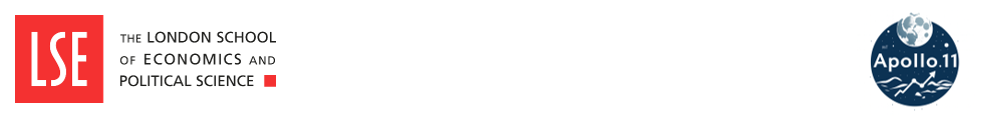

# **Predicting Stock Price Movements Around Earnings for NVIDIA, Apple & Google in the Era of AI & Trade Tensions**

#### _Exploring Root Causes for Rapid Movement in Stock Prices Around Earnings Dates & Delivering Data-Driven Solutions Through Advanced ML Modeling & Analytics_




# Stock Prices Prediction Pipeline

**Main Author:** Tehila Sharabi  
**Fellow teammates (Team Apollo 11):** Carlson Nkwain, Giuliana Pauletti, Jonathan Wise, Lakmali Amarawadana, Liam Hammond  
**Date:** Sep 2025  

**Course:** LSE Data Analytics Career Accelerator — Course 4: Employer Project  
**Course Facilitator:** Chinedu Anayokafor  

# **NOTEBOOK FLOW**
#### Background: The Business Problem 
### **Modeling Approach & Pre-Modeling Steps**
- #####  Intro: **Modeling Pipe Logic & Flow** 
- #####  Preparatory Steps: Creation of Wide Dataframes for Each Company Target
- ##### > Step A. **De-meaning & Standardization** 
- ##### > Step B. **Event-Aware Feature Engineering**
- ##### > Step C: **Feature selection and pruning methods** 
### **Ready-to-run Modeling Pipe #1: Walk Forward CV for Year-Round Predictions** 
- ##### Complete run of the best performing model by target: WF CV Hybrid XGBoost Path B for Google's t+10-day return prediction
- NOTE: Summarizing insights are provided throughout
- ##### > **Year-Round Google Trading Strategy**
### **Ready-to-run Modeling Pipe #2: Leave-One-Earnings-Out (LOEO) for Predictions Around Earnings**
- ##### Complete run of the best performing model by target: LOEO Hybrid XGBoost Path B for Google's t+10-day return prediction
- NOTE: Summarizing insights are provided throughout.
-       Earnings window strategies are presented in the report. 

##### **Exploratory Snippets**: Incorporating Sentiment Features
##### **At-a-Glance**: Walk-Forward CV Performance Across Targets

-------------------------------------
# **ADDITIONAL NOTEBOOKS**
#### Navigate to the project zip file to open these companion notebooks.:
- "Final_data_pipeline_master"
- "OpenAI_sentiment_scoring"
- "OpenAI_sentiment_EDA.ipynb"
- "Neighboring Companies"
- "Volatility, Prices & Earnings - EDA
- "Pair Trading"
- "Macroeconomic Data (EDA) & Pre-Modeling Explorations"
- "Earnings Data - EDA" 

**NOTE**: All other target companies (i.e., Apple and Nvidia) and predictive horizons (i.e., T+2, T+5, and T+10-day returns) were executed in separate notebooks due to compute limits. See the summary heatmaps at the end of this notebook for a comparative view of WF-CV performance across companies and horizons.

## **Background: The Business Problem**
#### *The Challenge of Predicting Rapid movements in Stock Prices* 
A data-analytics provider offering DAaaS to institutional clients—particularly hedge funds—wants to strengthen its competitive edge by developing predictive models that explain and anticipate rapid stock-price movements around earnings and support high-precision, data-driven investment decisions.
**Two contemporary forces were identified as especially relevant in shaping stock volatility in today’s U.S.**: (a) evolving **AI strategies and sentiment**, which signal growth potential and shape investor behaviour; and (b) rising **geopolitical and trade tensions**, including renewed Trump-era tariffs, which introduce heightened uncertainty and risk.
Guided by these insights, a comprehensive mapping of factors was conducted – integrating macroeconomic indicators, geopolitical risks, competitive dynamics, and company-specific performance metrics – for three key tech firms: NVIDIA, Google, and Apple. The resulting diagram below visualises a wide range of potential root causes behind stock price fluctuations in present-day financial markets, providing a structured foundation for model development and further testing

#### **Possible Causes for Rapid Movements in NVIDIA, Apple, and Google’s Stock Prices - a Fishbone Diagram**

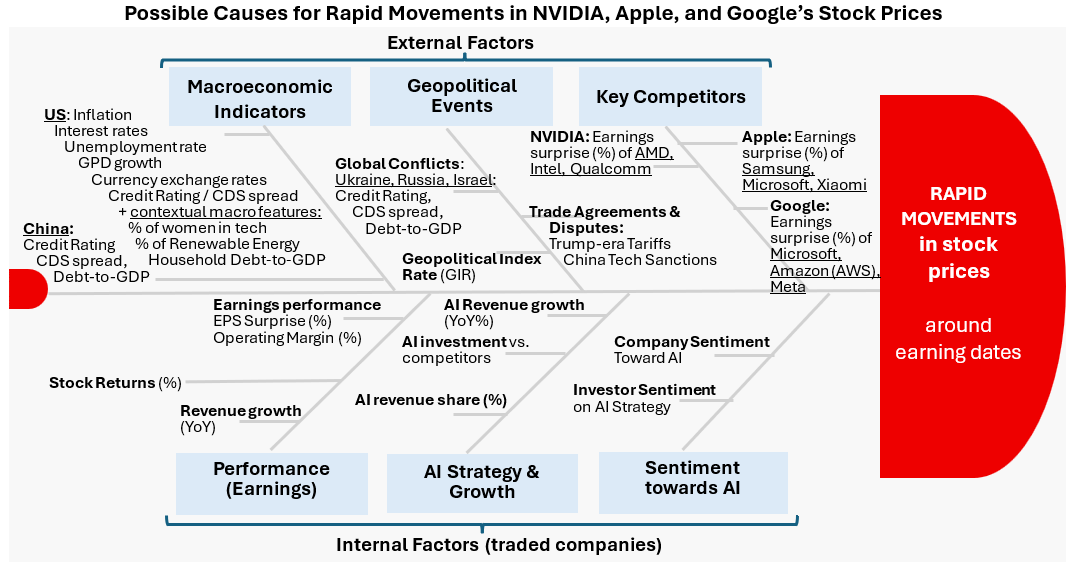

# Modeling Approach & Pre-Modeling Steps
### Intro: Modeling Pipe Logic & Flow
**The predictive modeling pipeline consists of two parts: the pre-modeling steps and two complementary modeling paths.**
Given the richness of the dataset, with features of different scales, frequencies, and domains — ranging from stock prices and peer signals to macroeconomic and earnings releases — **appropriate methods were required to optimize the feature space** in order to avoid feeding the model with mixed, redundant signals and noise that would *weaken* its performance rather than *strengthen* it.

Pre-modeling steps included:

1. **De-meaning and standardization**, implemented using rolling and exponentially weighted averages along with z-scoring. This procedure removed strong drifts in price data and corrected scale differences across variables.
2. **Event-Aware feature engineering**, in which low-frequency features such as earnings and macroeconomic data were tied more closely to event features by adding gated and decayed versions. These values appeared only within release-event windows and shrank over time. The resulting dynamic, event-aware features enabled the model to capture true event responses, with strong impacts at release and diminishing impacts afterward. *These variables significantly improved model performance* and were ultimately ranked among the top predictors used by XGBoost.
3. **Robust feature selection and pruning**, conducted through a sequence of filtering steps. In this process, *standardized twins* were preferred over raw values, *features with very low correlation* to the target were dropped, permutation importance* tests were used to eliminate harmful signals, and *ridge-based stability selection* was applied to retain only the top features by ridge coefficients before inputting them into XGBoost.

These methods produced a *smaller, cleaner, and more stable feature set, ready for modeling.* From this stage, two complementary frameworks were applied:

- (A) **Walk-Forward Cross Validation**, used for year-round predictions of the target T+2, T+5, and T+10-day returns.
- (B) **Leave-One-Earnings-Out (LOEO)** framework, applied for predictions around earnings dates, within defined windows surrounding the release (e.g., 2 days before and after, 5 days before and after).

*The diagram below provides an overview of the modeling pipeline, illustrating its main components and sequence*
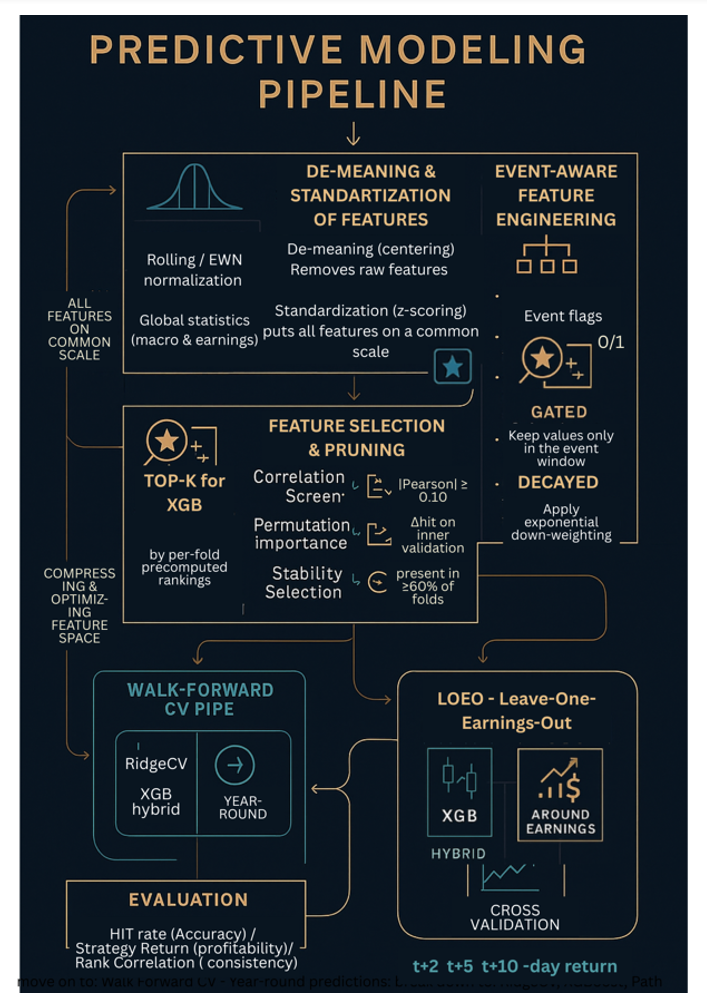

### **Preparatory Steps: Creation of Wide Dataframes for Each Company Target**

In [290]:
# --- Imports ---
import os, re, time, requests
import time, numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from pandas.tseries.offsets import BDay
from bs4 import BeautifulSoup
from functools import reduce
from dotenv import load_dotenv
import psycopg2
from psycopg2.extras import execute_values
from xgboost import XGBRegressor
from itertools import chain
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import spearmanr
import math
from tqdm import tqdm
import numpy as np
from pandas.api.types import is_integer_dtype
from sklearn.preprocessing import OneHotEncoder, StandardScaler # added

In [12]:
# Load the master data CSV file
master_data_df = pd.read_csv("stocks_master.csv")

In [13]:
# Check for missing values
print(master_data_df.shape)
master_data_df_na = master_data_df[master_data_df.isna().any(axis=1)]
print("Missing values in 'reviews':", master_data_df_na.shape)
master_data_df.isnull().sum()

(9885, 94)
Missing values in 'reviews': (300, 94)


ticker                 0
date                   0
day_of_week            0
month                  0
current_quarter        0
                      ..
trade_balance_yoy      0
unemp_rate             0
gdp                    0
debt_service_ratio     0
interest_rate_daily    0
Length: 94, dtype: int64

In [14]:
master_data_df.columns

Index(['ticker', 'date', 'day_of_week', 'month', 'current_quarter',
       'days_from_month_end', 'open', 'high', 'low', 'close', 'volume', 'rsi',
       'macd', 'daily_pct_change', 'rolling_avg_10d', 'sma_ratio_20', 'atr',
       'ret_1d', 'ret_5d', 'perf_vs_sp_ret_5d', 'sp_ret_1d', 'sp_ret_5d',
       'return_volatility_5day', 'bollinger_upper', 'bollinger_lower',
       'bollinger_position', 'mom_20d', 'mom_63d', 'sharp_20d', 'vol_z_60d',
       'rv_20d', 'semivol_20d', 'idio_vol_20d', 'dd_60d', 'beta_sp_60d',
       'future_1d_ret', 'future_2d_ret', 'future_5d_ret', 'future_10d_ret',
       'future_20d_ret', 'earning_date', 'earning_date_actual', 'market_cap',
       'quarter_ending', 'reported_eps', 'estimated_eps', 'surprise_percent',
       'revenue_million', 'days_since_earnings', 'days_since_earnings_trading',
       'earnings_date_2d', 'earnings_date_5d', 'earnings_date_trading_2d',
       'earnings_date_trading_5d', 'cpi_event_1d', 'cpi_event_2d',
       'cpi_event_5d', 'cpi

In [15]:
# Check how many NaNs in each future target:
suspect = ['future_1d_ret','future_2d_ret','future_5d_ret','future_10d_ret','future_20d_ret']
na_counts = (master_data_df[suspect].isna().sum().to_frame('n_missing'))
na_counts['pct_missing'] = na_counts['n_missing'] / len(master_data_df)
print(na_counts)

                n_missing  pct_missing
future_1d_ret          15     0.001517
future_2d_ret          30     0.003035
future_5d_ret          75     0.007587
future_10d_ret        150     0.015175
future_20d_ret        300     0.030349


NOTE: Missing Values Summary — master_data_df
> Dataset size: 9,885 rows × 94 columns.
> Total missingness: confined entirely to the five engineered future-return targets (future_1d_ret, future_2d_ret, future_5d_ret, future_10d_ret, future_20d_ret).
> Cause: These NaNs occur naturally at the end of each ticker’s trading history, where forward-looking returns cannot be computed.

In [16]:
# Test: is market_cap flat within each ticker?
test = (
    master_data_df.groupby("ticker")["market_cap"]
    .agg(nunique="nunique", min_val="min", max_val="max", std_val="std"))
print(test)

        nunique       min_val       max_val  std_val
ticker                                              
AAPL          1  3.426498e+12  3.426498e+12      0.0
ADI           1  1.149063e+11  1.149063e+11      0.0
ADSK          1  6.198617e+10  6.198617e+10      0.0
AMD           1  2.858477e+11  2.858477e+11      0.0
AMZN          1  2.468821e+12  2.468821e+12      0.0
AVGO          1  1.438133e+12  1.438133e+12      0.0
CDW           1  2.173511e+10  2.173511e+10      0.0
CTSH          1  3.423656e+10  3.423656e+10      0.0
GOOGL         1  2.461129e+12  2.461129e+12      0.0
LRCX          1  1.251446e+11  1.251446e+11      0.0
MRVL          1  6.616523e+10  6.616523e+10      0.0
MSFT          1  3.843690e+12  3.843690e+12      0.0
MU            1  1.382679e+11  1.382679e+11      0.0
NVDA          1  4.441044e+12  4.441044e+12      0.0
TXN           1  1.766726e+11  1.766726e+11      0.0


All market_cap series are constant within each ticker (nunique = 1, std = 0), confirming they are flat and therefore non-informative features to be excluded from the dataset.

In [17]:
master_data_df = master_data_df.drop(columns=["market_cap"])
master_data_df.shape

(9885, 93)

In [18]:
# build three modeling datasets from master_data_df, one per target:
# --- define peer groups (deduped) ---
tickers_google = ['GOOGL', 'ADSK', 'TXN', 'AMZN', 'AAPL', 'ADI']
tickers_apple  = ['AAPL',  'CDW', 'MSFT', 'CTSH', 'ADSK', 'GOOGL']
tickers_nvidia = ['NVDA',  'AVGO', 'MRVL','MU',  'AMD', 'LRCX']


# ensure date is datetime
master_data_df['date'] = pd.to_datetime(master_data_df['date'])

def subset_for_target(df, tickers, name):
    out = df[df['ticker'].isin(tickers)].copy()
    # nice-to-have: keep a consistent ticker order & tidy sort
    out['ticker'] = pd.Categorical(out['ticker'], categories=tickers, ordered=True)
    out = out.sort_values(['date', 'ticker'])
    # quick summary
    try:
        dmin, dmax = out['date'].min().date(), out['date'].max().date()
    except Exception:
        dmin = out['date'].min(); dmax = out['date'].max()
    print(f"{name}: {out['ticker'].nunique()} tickers | {len(out):,} rows | {dmin} → {dmax}")
    return out

# --- build the three datasets ---
df_google = subset_for_target(master_data_df, tickers_google, "GOOGL model set")
df_apple  = subset_for_target(master_data_df, tickers_apple,  "AAPL model set")
df_nvidia = subset_for_target(master_data_df, tickers_nvidia, "NVDA model set")

GOOGL model set: 6 tickers | 3,954 rows | 2023-01-03 → 2025-08-19
AAPL model set: 6 tickers | 3,954 rows | 2023-01-03 → 2025-08-19
NVDA model set: 6 tickers | 3,954 rows | 2023-01-03 → 2025-08-19


In [19]:
# view df
df_google

ticker       date day_of_week  month current_quarter  \
5371  GOOGL 2023-01-03     Tuesday      1              Q1   
1517   ADSK 2023-01-03     Tuesday      1              Q1   
9241    TXN 2023-01-03     Tuesday      1              Q1   
218    AMZN 2023-01-03     Tuesday      1              Q1   
229    AAPL 2023-01-03     Tuesday      1              Q1   
...     ...        ...         ...    ...             ...   
2      ADSK 2025-08-19     Tuesday      8              Q3   
15      TXN 2025-08-19     Tuesday      8              Q3   
4      AMZN 2025-08-19     Tuesday      8              Q3   
0      AAPL 2025-08-19     Tuesday      8              Q3   
1       ADI 2025-08-19     Tuesday      8              Q3   

      days_from_month_end        open        high         low       close  \
5371                   28   89.055883   90.507186   87.992263   88.588692   
1517                   28  190.619995  192.960007  183.000000  185.149994   
9241                   28  154.046616  154.442734  149.781357  150.352524   
218                    28   85.459999   86.959999   84.209999   85.820000   
229                    28  128.468202  129.079575  122.443173  123.330658   
...                   ...         ...         ...         ...         ...   
2                      12  290.380005  294.190002  289.170013  289.239990   
15                     12  194.669998  197.649994  193.789993  195.940002   
4                      12  230.089996  230.529999  227.119995  228.009995   
0                      12  231.279999  232.869995  229.350006  230.559998   
1                      12  231.639999  234.220001  229.809998  230.440002   

      ...  imports_raw  imports_mom  imports_yoy  trade_balance_raw  \
5371  ...       334444      1.26872     13.45738             -74773   
1517  ...       334444      1.26872     13.45738             -74773   
9241  ...       334444      1.26872     13.45738             -74773   
218   ...       334444      1.26872     13.45738             -74773   
229   ...       334444      1.26872     13.45738             -74773   
...   ...          ...          ...          ...                ...   
2     ...       337475     -3.66390     -1.39460             -60177   
15    ...       337475     -3.66390     -1.39460             -60177   
4     ...       337475     -3.66390     -1.39460             -60177   
0     ...       337475     -3.66390     -1.39460             -60177   
1     ...       337475     -3.66390     -1.39460             -60177   

      trade_balance_mom  trade_balance_yoy  unemp_rate        gdp  \
5371           10.31558           13.28727         3.6  22066.784   
1517           10.31558           13.28727         3.6  22066.784   
9241           10.31558           13.28727         3.6  22066.784   
218            10.31558           13.28727         3.6  22066.784   
229            10.31558           13.28727         3.6  22066.784   
...                 ...                ...         ...        ...   
2             -16.02897          -18.56087         4.2  23685.287   
15            -16.02897          -18.56087         4.2  23685.287   
4             -16.02897          -18.56087         4.2  23685.287   
0             -16.02897          -18.56087         4.2  23685.287   
1             -16.02897          -18.56087         4.2  23685.287   

      debt_service_ratio  interest_rate_daily  
5371           10.598597                 4.33  
1517           10.598597                 4.33  
9241           10.598597                 4.33  
218            10.598597                 4.33  
229            10.598597                 4.33  
...                  ...                  ...  
2              11.248487                 4.33  
15             11.248487                 4.33  
4              11.248487                 4.33  
0              11.248487                 4.33  
1              11.248487                 4.33  

[3954 rows x 93 columns]

In [20]:
# Create wide frames for each Company:
import pandas as pd

# --- lists of company-related columns ---
company_cols = [
    'open','high','low','close','volume','rsi','macd','daily_pct_change',
    'rolling_avg_10d','sma_ratio_20','atr','ret_1d','ret_5d','perf_vs_sp_ret_5d',
    'return_volatility_5day','bollinger_upper','bollinger_lower',
    'bollinger_position','mom_20d','mom_63d','sharp_20d','vol_z_60d','rv_20d','semivol_20d',
    'idio_vol_20d','dd_60d','beta_sp_60d','future_1d_ret','future_2d_ret','future_5d_ret',
    'future_10d_ret','future_20d_ret','earning_date','earning_date_actual',
    'quarter_ending','reported_eps','estimated_eps','surprise_percent','revenue_million',
    'days_since_earnings','days_since_earnings_trading','earnings_date_2d','earnings_date_5d',
    'earnings_date_trading_2d','earnings_date_trading_5d'
]
# ---- lists of global columns
global_cols = [
    'date','day_of_week','month','current_quarter','days_from_month_end',
    'sp_ret_1d','sp_ret_5d',
    'cpi_event_1d','cpi_event_2d','cpi_event_5d','cpi_days_since_release',
    'trade_event_1d','trade_event_2d','trade_event_5d','trade_days_since_release',
    'unemp_event_1d','unemp_event_2d','unemp_event_5d','unemp_days_since_release',
    'gdp_event_1d','gdp_event_2d','gdp_event_5d','gdp_days_since_release',
    'dsr_event_1d','dsr_event_2d','dsr_event_5d','dsr_days_since_release',
    'fomc_event_1d','fomc_event_2d','fomc_event_5d','fomc_days_since_release',
    'cpi_raw','cpi_mom','cpi_yoy','exports_raw','exports_mom','exports_yoy',
    'imports_raw','imports_mom','imports_yoy','trade_balance_raw','trade_balance_mom',
    'trade_balance_yoy','unemp_rate','gdp','debt_service_ratio','interest_rate_daily'
]

def build_wide_by_date(df, company_cols, global_cols, tickers=None):
    """
    Returns a one-row-per-date DataFrame.
    Company-specific columns are pivoted to feature_ticker (e.g., close_googl).
    Global columns kept once per date.
    """
    d = df.copy()
    d['date'] = pd.to_datetime(d['date'])
    d['ticker'] = d['ticker'].str.upper()

    # optional: restrict to a set of tickers (e.g., your Google/Apple/Nvidia groups)
    if tickers is not None:
        tickers = [t.upper() for t in tickers]
        d = d[d['ticker'].isin(tickers)]

    # Safety: if duplicates exist for (date, ticker), keep the last (or change to 'first')
    if d.duplicated(['date','ticker']).any():
        d = (d.sort_values(['date','ticker'])
               .drop_duplicates(subset=['date','ticker'], keep='last'))

    # --- GLOBAL BLOCK: one row per date ---
    gblock = (d[global_cols]
              .drop_duplicates('date')
              .groupby('date', as_index=False).first())

    # --- COMPANY BLOCK: pivot to wide (feature × ticker) ---
    cblock = (d[['date','ticker'] + company_cols]
              .pivot_table(index='date',
                           columns='ticker',
                           values=company_cols,
                           aggfunc='first'))   # works for numeric & datetime

    # flatten MultiIndex cols: (feature, TICKER) -> "feature_ticker"
    cblock.columns = [f"{feat.lower()}_{tick.lower()}" for feat, tick in cblock.columns]
    cblock = cblock.reset_index()

    # --- JOIN ---
    wide = gblock.merge(cblock, on='date', how='inner').sort_values('date')
    return wide

# Define tickers per target company
tickers_google = ['GOOGL', 'ADSK', 'TXN', 'AMZN', 'AAPL', 'ADI']
tickers_apple  = ['AAPL',  'CDW', 'MSFT', 'CTSH', 'ADSK', 'GOOGL']
tickers_nvidia = ['NVDA',  'AVGO', 'MRVL','MU',  'AMD', 'LRCX']


wide_google = build_wide_by_date(master_data_df, company_cols, global_cols, tickers_google)
wide_apple  = build_wide_by_date(master_data_df, company_cols, global_cols, tickers_apple)
wide_nvda   = build_wide_by_date(master_data_df, company_cols, global_cols, tickers_nvidia)

In [21]:
# quick sanity peeks
wide_google.filter(like='_googl').head()
wide_google.filter(like='close_').columns

Index(['close_aapl', 'close_adi', 'close_adsk', 'close_amzn', 'close_googl',
       'close_txn'],
      dtype='object')

In [22]:
list(wide_google.columns)

['date',
 'day_of_week',
 'month',
 'current_quarter',
 'days_from_month_end',
 'sp_ret_1d',
 'sp_ret_5d',
 'cpi_event_1d',
 'cpi_event_2d',
 'cpi_event_5d',
 'cpi_days_since_release',
 'trade_event_1d',
 'trade_event_2d',
 'trade_event_5d',
 'trade_days_since_release',
 'unemp_event_1d',
 'unemp_event_2d',
 'unemp_event_5d',
 'unemp_days_since_release',
 'gdp_event_1d',
 'gdp_event_2d',
 'gdp_event_5d',
 'gdp_days_since_release',
 'dsr_event_1d',
 'dsr_event_2d',
 'dsr_event_5d',
 'dsr_days_since_release',
 'fomc_event_1d',
 'fomc_event_2d',
 'fomc_event_5d',
 'fomc_days_since_release',
 'cpi_raw',
 'cpi_mom',
 'cpi_yoy',
 'exports_raw',
 'exports_mom',
 'exports_yoy',
 'imports_raw',
 'imports_mom',
 'imports_yoy',
 'trade_balance_raw',
 'trade_balance_mom',
 'trade_balance_yoy',
 'unemp_rate',
 'gdp',
 'debt_service_ratio',
 'interest_rate_daily',
 'atr_aapl',
 'atr_adi',
 'atr_adsk',
 'atr_amzn',
 'atr_googl',
 'atr_txn',
 'beta_sp_60d_aapl',
 'beta_sp_60d_adi',
 'beta_sp_60d_adsk'

### **Step A. De-meaning & Standartization**
*De-meaning & standartization while (1) auto-excludeing event flags & targets; (2) applying family-specific windows, and (3) choosing rolling or EWM per family. NOTE: All rolling/EWM stats are shifted by 1 → no look-ahead.*

In [32]:
# build a leak-safe normalizer that:
# auto-excludes targets and event flags (optionally date-like labels if present),
# assigns families based on your exact column names, and
# applies family-specific rolling/EWM z-scores (shifted by 1 to avoid look-ahead)

# ------------------ Exclusions ------------------
def is_binary_series(s: pd.Series, tol_unique=3) -> bool:
    if not pd.api.types.is_numeric_dtype(s):
        return False
    vals = pd.unique(pd.to_numeric(s, errors="coerce").dropna())
    if len(vals) <= tol_unique and set(vals).issubset({0,1}):
        return True
    return False
    
def default_exclude_cols(df: pd.DataFrame, extra_patterns: list[str] | None = None) -> list[str]:
    """
    Exclude:
      - date-like & identifiers
      - all *_event_* flags and earnings window flags
      - all future_*d_ret_* targets
      - non-numeric columns (e.g., day_of_week, month, current_quarter, earning_date_*, quarter_ending_*)
    """
    pats = [
        r"^date$", r"^datetime$", r"^time$", r"^timestamp$",
        r"^ticker$", r"^symbol$", r"^id$",

        # targets like future_10d_ret_googl
        r"^future_\d+d_ret_",

        # macro & earnings event flags present in your list
        r"_event_\d+d?$",                      # cpi_event_1d, fomc_event_5d, ...
        r"^earnings_date(_trading)?_\d+d_.*$", # earnings_date_2d_aapl, earnings_date_trading_5d_txn
    ]
    if extra_patterns:
        pats.extend(extra_patterns)

    exclude = set()
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            exclude.add(c)           # non-numerics auto-excluded
            continue
        name = c.lower()
        if any(re.search(p, name) for p in pats):
            exclude.add(c)
    return sorted(exclude)

# ------------------ Family assignment (matches columns) ------------------
def assign_family(col: str) -> str:
    c = col.lower()
    # calendar / timing kept raw (or encoded separately)
    if c in {"month", "days_from_month_end", "day_of_week", "current_quarter"}:
        return "calendar"
    if c.startswith("days_since_earnings_") or c.startswith("days_since_earnings_trading_"):
        return "calendar"
    if c.endswith("_days_since_release"):
        return "calendar"
    # volatility / risk group
    if c.startswith("atr_"):
        return "vol_beta"
    # market returns
    if c in {"sp_ret_1d", "sp_ret_5d"}:
        return "market_returns"
    # macro levels
    if c in {
        "cpi_raw","cpi_mom","cpi_yoy",
        "exports_raw","exports_mom","exports_yoy",
        "imports_raw","imports_mom","imports_yoy",
        "trade_balance_raw","trade_balance_mom","trade_balance_yoy",
        "unemp_rate","gdp","debt_service_ratio","interest_rate_daily"
    }:
        return "macro_levels"
    # price levels
    if any(c.startswith(p) for p in ("open_","high_","low_","close_")):
        return "price_level"
    # distance-to-trend / momentum family
    if c.startswith(("bollinger_position_","macd_","rsi_","sma_ratio_20_",
                     "ret_1d_","ret_5d_","perf_vs_sp_ret_5d_","rolling_avg_10d_",
                     "mom_20d_","mom_63d_","sharp_20d_","daily_pct_change_")):
        return "distance_to_trend"
    # volume / turnover
    if c.startswith("volume_") or c.startswith("vol_z_60d_"):
        return "volume"
    # volatility / beta extended
    if c.startswith(("beta_sp_60d_","bollinger_upper_","bollinger_lower_",
                     "rv_20d_","semivol_20d_","idio_vol_20d_","dd_60d_")):
        return "vol_beta"
    # earnings levels (not timing)
    if c.startswith(("reported_eps_","estimated_eps_","revenue_million_","surprise_percent_",
                     "earning_date_", "earning_date_actual_", "quarter_ending_")):
        # raw timestamps (earning_date_*, quarter_ending_*) you may prefer to transform to doy elsewhere;
        # here we classify them so you can choose to exclude or standardize.
        return "earnings_levels"
    # targets handled via exclude list
    if c.startswith("future_") and c.endswith("_ret"):
        return "target"
    return "other"  # safety net (we'll exclude this family by default)        
    

**Notes**

* **Targets & flags** (e.g., future_10d_ret_*, *_event_*, earnings_date_*) are auto-excluded.
* **Calendar/timing** (days_from_month_end, days_since_earnings_*) are assigned to calendar and excluded by default (Optional: Change method_by_family["calendar"] to "rolling" to z-score them)
* **Macro continuous** (cpi_raw, imports_*, unemp_rate, gdp, debt_service_ratio, interest_rate_daily) are grouped as macro_levels and scaled with a longer window (default 126) for stability.
* **Market returns** (sp_ret_1d, sp_ret_5d) are grouped as market_returns (rolling 60 by default).
* **EWM**: any family can be switched to EWM by editing method_by_family (e.g., macro_levels: "ewm" with halflife_by_family["macro_levels"]=60).
* **Standartization Logic**: Dividing the demeaned value by the past std answers: “How many typical daily moves is today’s deviation?”

In [33]:
# preserve original columns and add engineered variants instead (for auditability and model comparison):
# i.e. keeping raw, adding _dm (de-meaned) and _z (standardized)
# Justificatino: best practice for auditability, A/B comparisons (raw vs. engineered), and reporting.

# --- helpers: leak-safe rolling / EWMA stats ---
# Compute trailing rolling mean (mu) and standard deviation (sigma) for each column
# in `block`, then shift by 1 day to avoid look-ahead bias.
def _rolling_mu_sigma(block: pd.DataFrame, window: int, minp: int | None = None):
    if minp is None:
        minp = min(25, max(1, window // 2))
    mu = block.rolling(window=window, min_periods=minp).mean().shift(1)
    sigma = block.rolling(window=window, min_periods=minp).std(ddof=0).shift(1)
    return mu, sigma
    
# Compute exponentially weighted mean (mu) and standard deviation (sigma)
# with a specified half-life, then shift by 1 day to avoid look-ahead bias.
def _ewm_mu_sigma(block: pd.DataFrame, halflife: int, minp: int = 10):
    # adjust=False is standard for online filtering; shift(1) to avoid leakage
    mu = block.ewm(halflife=halflife, adjust=False, min_periods=minp).mean().shift(1)
    # bias=False → sample std analogue; min_periods to avoid early junk
    sigma = block.ewm(halflife=halflife, adjust=False, min_periods=minp).std(bias=False).shift(1)
    return mu, sigma
    
# adding for unique standartization of low frequency features
def _global_mu_sigma(block: pd.DataFrame):
    # one mean/std per column over the whole sample; broadcast to all rows
    mu = pd.DataFrame({c: block[c].mean() for c in block.columns}, index=block.index)
    std = pd.DataFrame({c: block[c].std(ddof=0) for c in block.columns}, index=block.index)
    return mu, std

# --- the new augmentor: keeps raw, adds *_dm and *_z side-by-side ---
def augment_with_demean_and_z(
    df: pd.DataFrame,
    windows_by_family: dict[str, int] | None = None,
    halflife_by_family: dict[str, int] | None = None,
    method_by_family: dict[str, str] | None = None,
    exclude_cols: list[str] | None = None,
    treat_binary_as_excluded: bool = True,
    eps: float = 1e-12,  # avoids divide-by-zero
):
    """
    Returns (df_aug, info):
      - df_aug = original df + *_dm (demeaned) + *_z (standardized) columns.
      - info['added_dm'][fam], info['added_z'][fam] list what was added.
      - Families with method 'exclude' are reported in info['excluded_by_family'].
    """
    if exclude_cols is None:
        # must exist in your notebook; if not, define a minimal one:
        # exclude_cols = ["date"] + [c for c in df.columns if c.startswith("future_") and "_ret_" in c]
        exclude_cols = default_exclude_cols(df)

    if windows_by_family is None:
        windows_by_family = {
            "price_level": 60, "distance_to_trend": 60, "volume": 40, "vol_beta": 90,
            "earnings_levels": 90, "macro_levels": 126, "market_returns": 60,
            "calendar": 60, "other": 60,
        }
    if halflife_by_family is None:
        halflife_by_family = {
            "price_level": 30, "distance_to_trend": 30, "volume": 25, "vol_beta": 40,
            "earnings_levels": 45, "macro_levels": 60, "market_returns": 30,
            "calendar": 30, "other": 30,
        }
    if method_by_family is None:
        method_by_family = {
            "price_level": "rolling", "distance_to_trend": "rolling",
            "volume": "ewm", "vol_beta": "ewm",
            "earnings_levels": "global", "macro_levels": "global",
            "market_returns": "rolling",
            "calendar": "exclude", "other": "exclude",
        }

    # 1) Bucket numeric, non-excluded, non-binary columns by family
    fam_cols: dict[str, list[str]] = {}
    for c in df.columns:
        if c in exclude_cols:
            continue
        if not pd.api.types.is_numeric_dtype(df[c]):
            continue
        if treat_binary_as_excluded and is_binary_series(df[c]):
            continue
        fam = assign_family(c)
        fam_cols.setdefault(fam, []).append(c)

    added_dm, added_z, added_gz = {}, {}, {}
    excluded_by_family = {}
    new_blocks = []  # collect big blocks here

    # 2) Build *_dm and *_z blocks family-by-family
    for fam, cols in fam_cols.items():
        if not cols:
            continue
        method = method_by_family.get(fam, "rolling")

        if method == "exclude":
            excluded_by_family[fam] = cols
            continue

        block = df[cols]

     # >>> ADD GLOBAL BRANCH <<<
        if method == "global":
            mu, sigma = _global_mu_sigma(block)                 # no rolling, no shift
            gz_block  = (block - mu) / (sigma.replace(0.0, np.nan) + eps)
            gz_block.columns = [f"{c}_gz" for c in cols]
            new_blocks.append(gz_block)
            # (optional) if you keep an info dict: added_gz[fam] = list(gz_block.columns)
            continue

        if method == "ewm":
            mu, sigma = _ewm_mu_sigma(block, halflife=halflife_by_family.get(fam, 30))
        else:  # rolling
            mu, sigma = _rolling_mu_sigma(block, window=windows_by_family.get(fam, 60))

        dm_block = (block - mu)
        z_block  = dm_block / (sigma.replace(0.0, np.nan) + eps)

        # rename columns once
        dm_block.columns = [f"{c}_dm" for c in cols]
        z_block.columns  = [f"{c}_z"  for c in cols]

        # remember what we added
        added_dm[fam] = list(dm_block.columns)
        added_z[fam]  = list(z_block.columns)

        # collect blocks; we concat ONCE at the end (prevents fragmentation)
        new_blocks.append(dm_block)
        new_blocks.append(z_block)

    # 3) Concatenate once; optional .copy() defragments the result in memory
    if new_blocks:
        engineered = pd.concat(new_blocks, axis=1)
        df_aug = pd.concat([df, engineered], axis=1, copy=False)
        df_aug = df_aug.copy()  # defrag; silences future fragmentation warnings
    else:
        df_aug = df.copy()

    info = {
        "exclude_cols": exclude_cols,
        "added_dm": added_dm,
        "added_z": added_z,
        "excluded_by_family": excluded_by_family,
        "method_by_family": method_by_family,
        "windows_by_family": windows_by_family,
        "halflife_by_family": halflife_by_family,
    }
    return df_aug, info


In [34]:
# Run on three frames
wide_google_aug, info_g_aug = augment_with_demean_and_z(wide_google)
wide_apple_aug,  info_a_aug = augment_with_demean_and_z(wide_apple)
wide_nvda_aug,   info_n_aug = augment_with_demean_and_z(wide_nvda)

# Spot-check: a few added columns exist and align in length
print(list(info_g_aug["added_z"].keys())[:3])
print(len(wide_google_aug), wide_google_aug.filter(like="_z").shape)

['market_returns', 'vol_beta', 'distance_to_trend']
659 (659, 170)


In [35]:
# view df
wide_google_aug

date day_of_week  month current_quarter  days_from_month_end  \
0   2023-01-03     Tuesday      1              Q1                   28   
1   2023-01-04   Wednesday      1              Q1                   27   
2   2023-01-05    Thursday      1              Q1                   26   
3   2023-01-06      Friday      1              Q1                   25   
4   2023-01-09      Monday      1              Q1                   22   
..         ...         ...    ...             ...                  ...   
654 2025-08-13   Wednesday      8              Q3                   18   
655 2025-08-14    Thursday      8              Q3                   17   
656 2025-08-15      Friday      8              Q3                   16   
657 2025-08-18      Monday      8              Q3                   13   
658 2025-08-19     Tuesday      8              Q3                   12   

     sp_ret_1d  sp_ret_5d  cpi_event_1d  cpi_event_2d  cpi_event_5d  ...  \
0    -0.004001  -0.005379             0             0             0  ...   
1     0.007539   0.006194             0             0             0  ...   
2    -0.011646   0.006576             0             0             0  ...   
3     0.022841   0.011898             0             0             0  ...   
4    -0.000768   0.013697             0             0             0  ...   
..         ...        ...           ...           ...           ...  ...   
654   0.003230   0.019152             0             1             1  ...   
655   0.000303   0.020274             0             0             1  ...   
656  -0.002897   0.009445             0             0             1  ...   
657  -0.000101   0.011877             0             0             1  ...   
658  -0.005858  -0.005335             0             0             0  ...   

     vol_z_60d_adsk_z  vol_z_60d_amzn_z  vol_z_60d_googl_z  vol_z_60d_txn_z  \
0                 NaN               NaN                NaN              NaN   
1                 NaN               NaN                NaN              NaN   
2                 NaN               NaN                NaN              NaN   
3                 NaN               NaN                NaN              NaN   
4                 NaN               NaN                NaN              NaN   
..                ...               ...                ...              ...   
654          0.397107         -0.265943          -0.722131        -0.441456   
655         -0.293912          0.803737          -0.908369        -0.661692   
656         -0.608500         -0.174830          -0.215832        -0.201724   
657         -0.839971         -0.791838          -1.311374        -0.893666   
658         -0.506277         -0.560672          -0.845165        -0.230319   

     volume_aapl_z  volume_adi_z  volume_adsk_z  volume_amzn_z  \
0              NaN           NaN            NaN            NaN   
1              NaN           NaN            NaN            NaN   
2              NaN           NaN            NaN            NaN   
3              NaN           NaN            NaN            NaN   
4              NaN           NaN            NaN            NaN   
..             ...           ...            ...            ...   
654       0.458610      0.089496       0.507433      -0.407641   
655      -0.331409     -0.974635      -0.246414       0.748631   
656      -0.144558      0.129232      -0.594697      -0.279057   
657      -0.972294     -0.913567      -0.872406      -0.948831   
658      -0.860389      0.647517      -0.533475      -0.706725   

     volume_googl_z  volume_txn_z  
0               NaN           NaN  
1               NaN           NaN  
2               NaN           NaN  
3               NaN           NaN  
4               NaN           NaN  
..              ...           ...  
654       -0.647400     -0.550619  
655       -0.832245     -0.789757  
656       -0.194967     -0.305599  
657       -1.251362     -1.052314  
658       -0.841998     -0.364023  

[659 rows x 673 columns]

In [36]:
list(wide_google_aug.columns)

['date',
 'day_of_week',
 'month',
 'current_quarter',
 'days_from_month_end',
 'sp_ret_1d',
 'sp_ret_5d',
 'cpi_event_1d',
 'cpi_event_2d',
 'cpi_event_5d',
 'cpi_days_since_release',
 'trade_event_1d',
 'trade_event_2d',
 'trade_event_5d',
 'trade_days_since_release',
 'unemp_event_1d',
 'unemp_event_2d',
 'unemp_event_5d',
 'unemp_days_since_release',
 'gdp_event_1d',
 'gdp_event_2d',
 'gdp_event_5d',
 'gdp_days_since_release',
 'dsr_event_1d',
 'dsr_event_2d',
 'dsr_event_5d',
 'dsr_days_since_release',
 'fomc_event_1d',
 'fomc_event_2d',
 'fomc_event_5d',
 'fomc_days_since_release',
 'cpi_raw',
 'cpi_mom',
 'cpi_yoy',
 'exports_raw',
 'exports_mom',
 'exports_yoy',
 'imports_raw',
 'imports_mom',
 'imports_yoy',
 'trade_balance_raw',
 'trade_balance_mom',
 'trade_balance_yoy',
 'unemp_rate',
 'gdp',
 'debt_service_ratio',
 'interest_rate_daily',
 'atr_aapl',
 'atr_adi',
 'atr_adsk',
 'atr_amzn',
 'atr_googl',
 'atr_txn',
 'beta_sp_60d_aapl',
 'beta_sp_60d_adi',
 'beta_sp_60d_adsk'

In [37]:
wide_google_aug.shape

(659, 673)

In [38]:
# Check for missing values
wide_google_aug_na = wide_google_aug[wide_google_aug.isna().any(axis=1)]
print("Missing values in 'reviews':", wide_google_aug_na.shape)
wide_google_aug.isnull().sum()

Missing values in 'reviews': (45, 673)


date                    0
day_of_week             0
month                   0
current_quarter         0
days_from_month_end     0
                       ..
volume_adi_z           10
volume_adsk_z          10
volume_amzn_z          10
volume_googl_z         10
volume_txn_z           10
Length: 673, dtype: int64

In [39]:
# Count how many columns are missing in each row
row_na_counts = wide_google_aug.isnull().sum(axis=1)
row_na_counts.describe()

count    659.000000
mean       9.602428
std       48.024244
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      316.000000
dtype: float64

In [40]:
# Look at columns with the most NaNs
wide_google_aug.isnull().sum().sort_values(ascending=False).head(20)

sp_ret_1d_dm     25
sp_ret_5d_dm     25
sp_ret_1d_z      25
sp_ret_5d_z      25
close_adi_z      25
close_adsk_z     25
close_amzn_z     25
close_googl_z    25
close_txn_z      25
high_aapl_z      25
high_adi_z       25
high_adsk_z      25
high_amzn_z      25
high_googl_z     25
high_txn_z       25
low_aapl_z       25
low_adi_z        25
low_adsk_z       25
low_amzn_z       25
low_googl_z      25
dtype: int64

NOTE: Missing standardized and de-meaned variables are expected, as rolling and z-scoring computations require a minimum lookback window, leaving the first rows undefined (NaN).

### **Step B. Event-Aware Feature Engineering**

Low-frequency variables pose two issues: (1) repeated values across weeks can lead the model to misinterpret them as trend signals, and (2) their true impact is strongest immediately after release and diminishes over time. To address this, event-aware transformations were applied by creating gated, decayed, and combined gated+decayed features.

> **Gated features** restrict the variable to event windows (e.g., CPI value active only within five days of release).

> **Decayed features** scale the variable to fade with time since release, strongest at day 0 and halving every h days.

> **Gated+Decayed** features combine both approaches, ensuring the model learns short-lived event-driven effects without mistaking forward-filled values for trends.

In [56]:
# Compute exponential decay weights from a "days since release" series.
# - If half_life is None → return None (no decay).
# - Otherwise: clip days to [0, cap_days] and apply 0.5 ** (days / half_life).
def _decay_weights(since_series: pd.Series, half_life: int | None, cap_days: int) -> pd.Series | None:
    if half_life is None:
        return None
    d = since_series.clip(lower=0, upper=cap_days).astype(float)
    return np.power(0.5, d / float(half_life))
    
# Sanitize a string for safe use in column suffixes by replacing non-alphanumerics with underscores.
def _sanitize(name: str) -> str:
    # safe for column suffixes
    return re.sub(r"[^0-9a-zA-Z_]+", "_", name)

# Create event-aware variants of `value_col`: pure decayed, gated, and gated+decayed.
# - Requires `days_since_col` (for decay) and one or more boolean/int event flags in `event_cols`.
# - Options: half_life (None disables decay), cap_days for decay clipping, zero_fill to replace NaNs with 0,
#   and drop_raw to optionally remove the original `value_col`.
# - Returns (modified_dataframe, list_of_new_column_names).
# - Raises KeyError if required columns are missing; no-op if `value_col` absent.
def make_gated_decayed(
    df: pd.DataFrame,
    value_col: str,
    event_cols: list[str],
    days_since_col: str,
    half_life: int | None = 3,
    cap_days: int = 30,
    zero_fill: bool = True,
    drop_raw: bool = False,
):
    """
    Create gated/decayed variants of `value_col` using the given `event_cols` and `days_since_col`.
    Returns (df_with_features, list_of_new_columns).
    """
    out = df.copy()
    if days_since_col not in out:
        raise KeyError(f"Missing days-since column: {days_since_col}")
    if value_col not in out:
        # no-op: return unchanged if the value isn't present
        return out, []

    decay_w = _decay_weights(out[days_since_col], half_life, cap_days)
    new_cols = []

    # 1) pure decay (no gating)
    if decay_w is not None:
        col_dec = f"{value_col}__decay_h{half_life}"
        out[col_dec] = out[value_col] * decay_w
        if zero_fill: out[col_dec] = out[col_dec].fillna(0.0)
        new_cols.append(col_dec)

    # 2) each gate (and gate+decay)
    for gate in event_cols:
        if gate not in out:
            raise KeyError(f"Missing event flag: {gate}")
        tag = _sanitize(gate.replace(f"{value_col.split('_')[0]}_", ""))  # compact label if same prefix
        col_gate = f"{value_col}__gate_{tag}"
        out[col_gate] = (out[value_col] * out[gate]).astype(float)
        if zero_fill: out[col_gate] = out[col_gate].fillna(0.0)
        new_cols.append(col_gate)

        if decay_w is not None:
            col_gd = f"{value_col}__gate_{tag}_dec_h{half_life}"
            out[col_gd] = out[col_gate] * decay_w
            if zero_fill: out[col_gd] = out[col_gd].fillna(0.0)
            new_cols.append(col_gd)

    if drop_raw:
        out.drop(columns=[value_col], inplace=True, errors="ignore")

    return out, new_cols


**Methodological Note: Choosing a Half-Life**

The half-life parameter controls how quickly a macro signal fades after release. At $t=0$, the weight equals 1 (full effect), dropping to 0.5 at $t=\text{half-life}$, and 0.25 at $t=2 \times \text{half-life}$. This decay reflects real market dynamics: strong impact immediately after release, diminishing as new information arrives.

In this project, half-life was set according to general best-practice (see tables with recommended ranges). Nonetheless, for future refinement of the modeling pipeline it is advised to:

> Start with domain defaults (≈3–10 days for high-frequency indicators; 10–20 days for lower-frequency such as GDP).

> Use cross-validation to test alternative half-lives rather than relying on assumptions.

> Limit the number of decay variants to avoid overfitting; 1–2 per macro is usually sufficient.


##### Recommended Half-Life Settings for t+2 and t+5 day forward returns:
| Group                               | Typical Market Reaction                                                 | Suggested Half-Life (trading days) | Notes                                                                            |
| ----------------------------------- | ----------------------------------------------------------------------- | ---------------------------------- | -------------------------------------------------------------------------------- |
| **CPI (Inflation)**                 | Immediate, sharp, priced in fast (bonds & FX react within hours).       | **3–5**                            | Short-lived unless a surprise; aligns with T+2/T+5 horizons.                     |
| **Trade (Exports/Imports/Balance)** | Matters for FX & equities, but effects linger a bit longer.             | **5–7**                            | Especially if tied to supply chains (e.g., semis).                               |
| **Unemployment (Jobs)**             | Big headline, affects consumption outlook, persists slightly longer.    | **5–10**                           | NFP shocks are digested over the week.                                           |
| **GDP**                             | Rare release, highly sticky.                                            | **10–20**                          | Good to keep influence longer; investors anchor on GDP until next big print.     |
| **DSR (Debt Service Ratio)**        | Very low-frequency, structural.                                         | **15–20**                          | Almost constant between releases → long decay.                                   |
| **FOMC / Interest Rate**            | Policy shocks reset expectations; effect can last until next Fed event. | **10–15**                          | Use longer half-life; sometimes you might even skip decay and just gate windows. |
| **Earnings (per ticker)**           | Stock moves big at release, then settles quickly.                       | **2–3**                            | Fits your short T+2/T+5 horizon. Use longer only if you see drift post-earnings. |

##### Recommended Half-Life Settings for t+10 day forward returns:
| Group                     | Reaction speed                                         | Half-life (T+10 focused) | Interpretation                                                                                  |
| ------------------------- | ------------------------------------------------------ | ------------------------ | ----------------------------------------------------------------------------------------------- |
| **CPI (Inflation)**       | Fast shock, but you care about spillover into 10 days. | **7–10**                 | Keeps signal relevant at T+10 (≈0.35–0.5 weight left).                                          |
| **Trade**                 | Moderate speed.                                        | **7–10**                 | Ensures the trade balance still influences T+10 returns.                                        |
| **Unemployment**          | Medium persistence.                                    | **10–12**                | At T+10, weight \~0.5–0.55 → nicely balanced.                                                   |
| **GDP**                   | Very sticky, low frequency.                            | **15–20**                | At T+10, still \~0.6–0.7 → which matches reality.                                               |
| **DSR**                   | Extremely sticky, structural.                          | **20**                   | Treat almost as non-decaying over 10d.                                                          |
| **FOMC / Interest Rate**  | Persistent across weeks.                               | **12–15**                | Keeps most of the effect alive through T+10.                                                    |
| **Earnings (per ticker)** | Quick reactions, but drift can extend.                 | **5–7**                  | So that at day 10 there’s still \~0.35–0.5 effect; short half-life (2–3) would already be dead. |


In [58]:
# Apply event-aware transformations (gated, decayed, gated+decayed) to key macroeconomic indicators 
# (CPI, Trade, Unemployment, GDP, Debt-Service Ratio, FOMC). 
# For each macro, raw and growth-rate variants are expanded into features tied to event windows 
# and decayed by half-life parameters, so that the model captures short-lived release effects 
# instead of treating forward-filled values as persistent trends. 
# Half-life settings can be customized per macro (defaults provided).
def apply_macro_event_features(df, half_lives=None, drop_raw=True):
    """
    Apply gated/decayed macro features to a single dataframe.
    Expects event flags and days_since columns to already exist.
    
    Parameters
    ----------
    df : pd.DataFrame
        Your input dataframe (e.g., wide_google_aug).
    half_lives : dict
        Dictionary of half-life settings per macro prefix.
    drop_raw : bool
        Whether to drop the original raw value columns.
    """
    if half_lives is None:
        half_lives = {
            "cpi": 7, # try 7-10 for t+10; **3–5** for t+2, t+5
            "trade": 7,  # try 7-10 for t+10; **5-7** for t+2, t+5
            "unemp": 10, # try 10-12 for t+10; **5-10** for t+2, t+5
            "gdp": 15, # try 15-20 for t+10; **10-20** for t+2, t+5
            "dsr": 20, # try 20 for t+10; **15-20** for t+2, t+5
            "fomc": 12, # try 12-15 for t+10; **10-15** for t+2, t+5
        }
    
    # CPI
    cpi_values = [
        "cpi_raw","cpi_mom","cpi_yoy",
        "cpi_raw_gz","cpi_mom_gz","cpi_yoy_gz"
    ]
    for c in cpi_values:
        df, _ = make_gated_decayed(df, c,
            ["cpi_event_1d","cpi_event_2d","cpi_event_5d"],
            "cpi_days_since_release",
            half_life=half_lives["cpi"],
            drop_raw=drop_raw
        )

    # TRADE
    trade_values = [
        "exports_raw","exports_mom","exports_yoy",
        "imports_raw","imports_mom","imports_yoy",
        "trade_balance_raw","trade_balance_mom","trade_balance_yoy",
        "exports_raw_gz","exports_mom_gz","exports_yoy_gz",
        "imports_raw_gz","imports_mom_gz","imports_yoy_gz",
        "trade_balance_raw_gz","trade_balance_mom_gz","trade_balance_yoy_gz"
    ]
    for c in trade_values:
        df, _ = make_gated_decayed(df, c,
            ["trade_event_1d","trade_event_2d","trade_event_5d"],
            "trade_days_since_release",
            half_life=half_lives["trade"],
            drop_raw=drop_raw
        )

    # UNEMP
    for c in ["unemp_rate","unemp_rate_gz"]:
        df, _ = make_gated_decayed(df, c,
            ["unemp_event_1d","unemp_event_2d","unemp_event_5d"],
            "unemp_days_since_release",
            half_life=half_lives["unemp"],
            drop_raw=drop_raw
        )

    # GDP
    for c in ["gdp","gdp_gz"]:
        df, _ = make_gated_decayed(df, c,
            ["gdp_event_1d","gdp_event_2d","gdp_event_5d"],
            "gdp_days_since_release",
            half_life=half_lives["gdp"],
            drop_raw=drop_raw
        )

    # DSR
    for c in ["debt_service_ratio","debt_service_ratio_gz"]:
        df, _ = make_gated_decayed(df, c,
            ["dsr_event_1d","dsr_event_2d","dsr_event_5d"],
            "dsr_days_since_release",
            half_life=half_lives["dsr"],
            drop_raw=drop_raw
        )

    # FOMC
    for c in ["interest_rate_daily","interest_rate_daily_gz"]:
        df, _ = make_gated_decayed(df, c,
            ["fomc_event_1d","fomc_event_2d","fomc_event_5d"],
            "fomc_days_since_release",
            half_life=half_lives["fomc"],
            drop_raw=drop_raw
        )

    return df


In [59]:
# Apply to all three dfs (copied dataframes)
wide_google_aug_tied = apply_macro_event_features(wide_google_aug.copy(), drop_raw=False)
wide_apple_aug_tied  = apply_macro_event_features(wide_apple_aug.copy(), drop_raw=False)
wide_nvda_aug_tied   = apply_macro_event_features(wide_nvda_aug.copy(), drop_raw=False)
# wide_google_aug remains unchanged
# wide_google_aug_tied has all the gated/decayed features

In [60]:
# Bind per-ticker earnings values (EPS estimates/reports, revenues, surprises) to event windows. 
# For each ticker, raw and normalized variants are transformed into gated/decayed features tied 
# to earnings release dates (or trading windows, if specified). This ensures the model captures 
# the sharp impact of earnings announcements and their decay over time, instead of treating 
# forward-filled values as continuous signals.
def bind_earnings_values_to_events(
    df: pd.DataFrame,
    tickers: list[str],
    value_kinds: tuple[str, ...] = ("estimated_eps","reported_eps","revenue_million","surprise_percent"),
    use_trading_windows: bool = False,
    half_life: int | None = 5,
    drop_raw: bool = False,   # keep raws visible
):
    out = df.copy()
    for tkr in tickers:
        t = tkr.lower()
        # choose event flags + days-since
        if use_trading_windows:
            event_cols = [f"earnings_date_trading_2d_{t}", f"earnings_date_trading_5d_{t}"]
            days_col   = f"days_since_earnings_trading_{t}"
        else:
            event_cols = [f"earning_date_{t}", f"earnings_date_2d_{t}", f"earnings_date_5d_{t}"]
            days_col   = f"days_since_earnings_{t}" if f"days_since_earnings_{t}" in out.columns else f"days_since_earnings_trading_{t}"

        # for each base kind, try raw and both gz patterns
        for kind in value_kinds:
            candidates = [
                f"{kind}_{t}",        # raw
                f"{kind}_{t}_gz",     # your pattern (kind_ticker_gz)
                f"{kind}_gz_{t}",     # alternate pattern (kind_gz_ticker)
            ]
            for val_col in candidates:
                if val_col not in out.columns:
                    continue
                gates = [g for g in event_cols if g in out.columns]
                if not gates:
                    continue
                out, _ = make_gated_decayed(
                    out,
                    value_col=val_col,
                    event_cols=gates,
                    days_since_col=days_col,
                    half_life=half_life,
                    drop_raw=drop_raw,
                )
    return out

In [61]:
# confirm matches per ticker and that features were created
# Show which event & days-since columns are found for one ticker
def debug_earn_ticker(df, tkr, use_trading_windows=False):
    t = tkr.lower()
    if use_trading_windows:
        event_cols = [f"earnings_date_trading_2d_{t}", f"earnings_date_trading_5d_{t}"]
        days_col   = f"days_since_earnings_trading_{t}"
    else:
        event_cols = [f"earning_date_{t}", f"earnings_date_2d_{t}", f"earnings_date_5d_{t}"]
        days_col   = f"days_since_earnings_{t}" if f"days_since_earnings_{t}" in df.columns else f"days_since_earnings_trading_{t}"
    print("events present:", [c for c in event_cols if c in df.columns])
    print("days_since:", days_col, "(exists)" if days_col in df.columns else "(MISSING)")

# Count new earnings features per ticker (case-insensitive)
def earnings_feature_summary(df, tickers):
    for tkr in tickers:
        slug = tkr.lower()
        cols = [c for c in df.columns if f"_{slug}__" in c and ("__gate_" in c or "__decay_h" in c)]
        n_gate  = sum("__gate_"  in c and f"_{slug}__" in c for c in df.columns)
        n_decay = sum("__decay_h" in c and f"_{slug}__" in c for c in df.columns)
        print(f"{tkr}: total={len(cols)}  (gated={n_gate}, decayed={n_decay})")
        print("   ", cols[:6], "...")

In [62]:
# apply to new _tied DFs
wide_google_aug_tied = bind_earnings_values_to_events(
    wide_google_aug_tied, tickers=tickers_google, use_trading_windows=False, half_life=5, drop_raw=False)

wide_apple_aug_tied = bind_earnings_values_to_events(
    wide_apple_aug_tied, tickers=tickers_apple, use_trading_windows=False, half_life=5, drop_raw=False)

wide_nvda_aug_tied = bind_earnings_values_to_events(
    wide_nvda_aug_tied, tickers=tickers_nvidia, use_trading_windows=False, half_life=5, drop_raw=False)

In [63]:
# sanity check a specific ticker
debug_earn_ticker(wide_google_aug_tied, "GOOGL")
earnings_feature_summary(wide_google_aug_tied, tickers_google)

events present: ['earning_date_googl', 'earnings_date_2d_googl', 'earnings_date_5d_googl']
days_since: days_since_earnings_googl (exists)
GOOGL: total=28  (gated=24, decayed=4)
    ['estimated_eps_googl__decay_h5', 'estimated_eps_googl__gate_earning_date_googl', 'estimated_eps_googl__gate_earning_date_googl_dec_h5', 'estimated_eps_googl__gate_earnings_date_2d_googl', 'estimated_eps_googl__gate_earnings_date_2d_googl_dec_h5', 'estimated_eps_googl__gate_earnings_date_5d_googl'] ...
ADSK: total=28  (gated=24, decayed=4)
    ['estimated_eps_adsk__decay_h5', 'estimated_eps_adsk__gate_earning_date_adsk', 'estimated_eps_adsk__gate_earning_date_adsk_dec_h5', 'estimated_eps_adsk__gate_earnings_date_2d_adsk', 'estimated_eps_adsk__gate_earnings_date_2d_adsk_dec_h5', 'estimated_eps_adsk__gate_earnings_date_5d_adsk'] ...
TXN: total=28  (gated=24, decayed=4)
    ['estimated_eps_txn__decay_h5', 'estimated_eps_txn__gate_earning_date_txn', 'estimated_eps_txn__gate_earning_date_txn_dec_h5', 'estimated_e

Into the model: The “gated+decayed 5-day” version of reported_eps for GOOGL.

> * It is nonzero only in the 5-day event window.
> * Within that window, the value decays each day (half-life=5).
> * Outside the window → 0.

Perfect for T+10 horizon, because the event shock lasts several days but doesn’t bleed endlessly into the future.

In [64]:
cols_to_check = [
    "reported_eps_googl",                           # the original value column
    "earning_date_googl",                           # the binary event flag (1-day window)
    "earnings_date_5d_googl",                       # the binary event flag (5-day window)
    "reported_eps_googl__gate_earning_date_googl",  # gated (1d)
    "reported_eps_googl__gate_earnings_date_5d_googl"  # gated (5d)
]

# show 15 rows around an earnings event
wide_google_aug_tied[cols_to_check].head(15)

reported_eps_googl  earning_date_googl  earnings_date_5d_googl  \
0                 1.06                   0                       0   
1                 1.06                   0                       0   
2                 1.06                   0                       0   
3                 1.06                   0                       0   
4                 1.06                   0                       0   
5                 1.06                   0                       0   
6                 1.06                   0                       0   
7                 1.06                   0                       0   
8                 1.06                   0                       0   
9                 1.06                   0                       0   
10                1.06                   0                       0   
11                1.06                   0                       0   
12                1.06                   0                       0   
13                1.06                   0                       0   
14                1.06                   0                       0   

    reported_eps_googl__gate_earning_date_googl  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
5                                           0.0   
6                                           0.0   
7                                           0.0   
8                                           0.0   
9                                           0.0   
10                                          0.0   
11                                          0.0   
12                                          0.0   
13                                          0.0   
14                                          0.0   

    reported_eps_googl__gate_earnings_date_5d_googl  
0                                               0.0  
1                                               0.0  
2                                               0.0  
3                                               0.0  
4                                               0.0  
5                                               0.0  
6                                               0.0  
7                                               0.0  
8                                               0.0  
9                                               0.0  
10                                              0.0  
11                                              0.0  
12                                              0.0  
13                                              0.0  
14                                              0.0

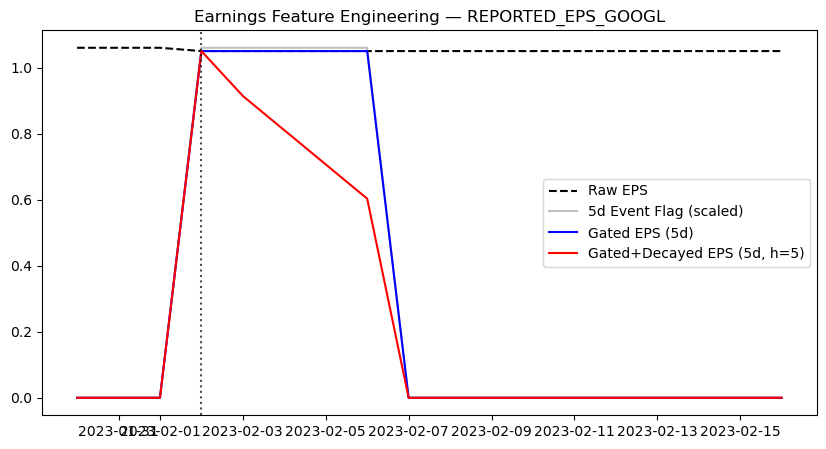

In [66]:
# Illustration of earnings feature engineering for one ticker (Google):
# - Plots the raw reported EPS, the 5-day event flag, and the engineered gated and gated+decayed features.
# - Shows how the raw EPS is tied to the event window (gated) and then faded over time (decayed),
#   allowing the model to learn the sharp release effect and its gradual weakening instead of
#   treating forward-filled values as persistent signals.


slug = "googl"
val   = "reported_eps_googl"  # not the _gz column

flag5 = f"earnings_date_5d_{slug}"
gate5 = f"{val}__gate_earnings_date_5d_{slug}"
gate5d = f"{gate5}_dec_h5"

ix0 = wide_google_aug_tied.index[wide_google_aug_tied[f"earning_date_{slug}"] == 1][0]
sub = wide_google_aug_tied.loc[max(ix0-3,0): ix0+10, ["date", val, flag5, gate5, gate5d]].copy()
sub = sub.set_index("date")  # now x-axis will show real dates

plt.figure(figsize=(10,5))
plt.plot(sub.index, sub[val], label="Raw EPS", color="black", linestyle="--")
plt.plot(sub.index, sub[flag5]*sub[val].max(), label="5d Event Flag (scaled)", color="grey", alpha=0.5)
plt.plot(sub.index, sub[gate5], label="Gated EPS (5d)", color="blue")
plt.plot(sub.index, sub[gate5d], label="Gated+Decayed EPS (5d, h=5)", color="red")
plt.axvline(sub.index[3], color="k", linestyle=":", alpha=0.7)  # earnings day marker
plt.title(f"Earnings Feature Engineering — {val.upper()}")
plt.legend()
plt.show()



In [67]:
# view gated+decayed columns
[c for c in wide_google_aug_tied.columns if "reported_eps_googl" in c]

['reported_eps_googl',
 'reported_eps_googl_gz',
 'reported_eps_googl__decay_h5',
 'reported_eps_googl__gate_earning_date_googl',
 'reported_eps_googl__gate_earning_date_googl_dec_h5',
 'reported_eps_googl__gate_earnings_date_2d_googl',
 'reported_eps_googl__gate_earnings_date_2d_googl_dec_h5',
 'reported_eps_googl__gate_earnings_date_5d_googl',
 'reported_eps_googl__gate_earnings_date_5d_googl_dec_h5',
 'reported_eps_googl_gz__decay_h5',
 'reported_eps_googl_gz__gate_earning_date_googl',
 'reported_eps_googl_gz__gate_earning_date_googl_dec_h5',
 'reported_eps_googl_gz__gate_earnings_date_2d_googl',
 'reported_eps_googl_gz__gate_earnings_date_2d_googl_dec_h5',
 'reported_eps_googl_gz__gate_earnings_date_5d_googl',
 'reported_eps_googl_gz__gate_earnings_date_5d_googl_dec_h5']

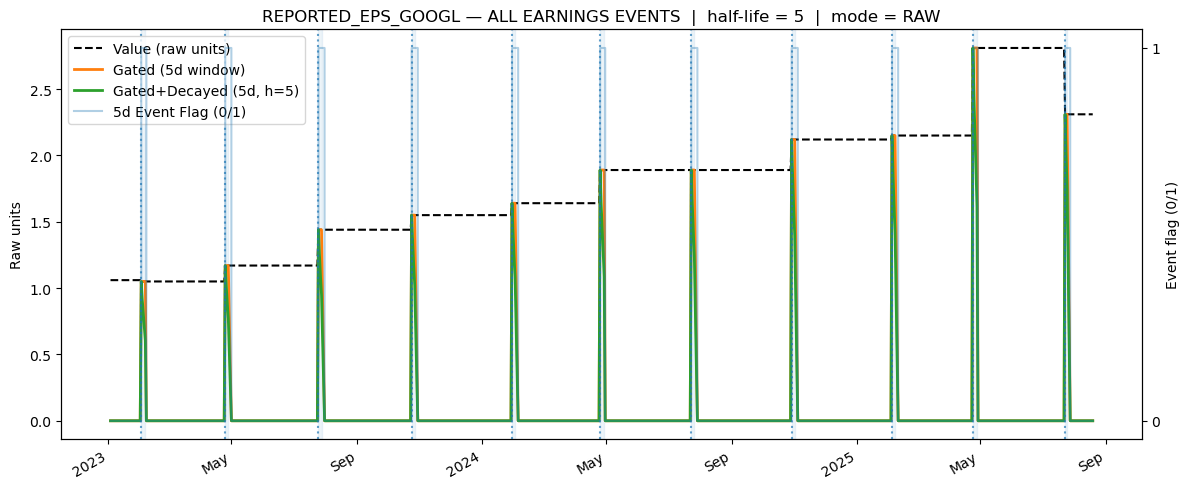

event_date  reported_eps_googl (event-day)
0  2023-02-02                            1.05
1  2023-04-25                            1.17
2  2023-07-25                            1.44
3  2023-10-24                            1.55
4  2024-01-30                            1.64
5  2024-04-25                            1.89
6  2024-07-23                            1.89
7  2024-10-29                            2.12
8  2025-02-04                            2.15
9  2025-04-24                            2.81
10 2025-07-23                            2.31

In [70]:
# plot gated+decayed features: earnings 

def plot_all_earnings_events(df, ticker: str, value_kind="reported_eps", half_life=5, use_gz=False):
    s = ticker.lower()
    # choose raw or standardized source column
    val = f"{value_kind}_{s}" if not use_gz else f"{value_kind}_{s}_gz"
    flag1 = f"earning_date_{s}"
    flag5 = f"earnings_date_5d_{s}"
    gate5 = f"{val}__gate_earnings_date_5d_{s}"
    gate5d = f"{gate5}_dec_h{half_life}"

    # ---- safety checks
    missing = [c for c in [val, flag1, flag5, gate5, gate5d] if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns for {ticker}: {missing}")

    # x-axis: dates (prefer df['date'], else index if datetime)
    if "date" in df.columns:
        x = pd.to_datetime(df["date"])
    else:
        x = pd.to_datetime(df.index)

    # event-day indices and table
    event_idx = df.index[df[flag1] == 1].tolist()
    if not event_idx:
        raise ValueError(f"No earnings events found for {ticker}.")
    event_dates = [x[i] for i in event_idx]
    event_vals  = [df.loc[i, val] for i in event_idx]
    event_tbl = pd.DataFrame({"event_date": event_dates, f"{val} (event-day)": event_vals})

    # ---- plot
    fig, ax = plt.subplots(figsize=(12,5))
    ax2 = ax.twinx()  # right y for 0/1 flag if we want to show it

    # left y: value series
    ax.plot(x, df[val], "--", lw=1.5,
            label=("Value (raw units)" if not use_gz else "Value (standardized z-score)"),
            color="black")
    ax.plot(x, df[gate5], lw=2, label="Gated (5d window)", color="tab:orange")
    ax.plot(x, df[gate5d], lw=2, label=f"Gated+Decayed (5d, h={half_life})", color="tab:green")

    # shade every 5d window & add vertical line at event day
    for i in event_idx:
        # shaded region where flag5 == 1 starting at i; detect run length
        j = i
        while j < len(df) and df.iloc[j][flag5] == 1:
            j += 1
        ax.axvspan(x[i], x[j-1] if j > 0 else x[i], color="tab:blue", alpha=0.08)
        ax.axvline(x[i], color="tab:blue", linestyle=":", alpha=0.7)

    # optional: show 0/1 flag on right axis (unscaled)
    ax2.plot(x, df[flag5], drawstyle="steps-post", alpha=0.35, color="tab:blue", label="5d Event Flag (0/1)")
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_yticks([0,1])
    ax2.set_ylabel("Event flag (0/1)")

    # formatting
    ax.set_title(f"{val.upper()} — ALL EARNINGS EVENTS  |  half-life = {half_life}  |  mode = {'RAW' if not use_gz else 'Z-SCORE'}")
    ax.set_ylabel("Raw units" if not use_gz else "Standard deviations (z-score)")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate()

    # legends
    h1,l1 = ax.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left")

    plt.tight_layout()
    plt.show()

    # print compact event table
    display(event_tbl.head(20))  # show first 20 events; adjust if you like
    return event_tbl

# choose RAW or Z-SCORE view
# Plot RAW units:
tbl = plot_all_earnings_events(wide_google_aug_tied, "GOOGL", value_kind="reported_eps", half_life=5, use_gz=False)

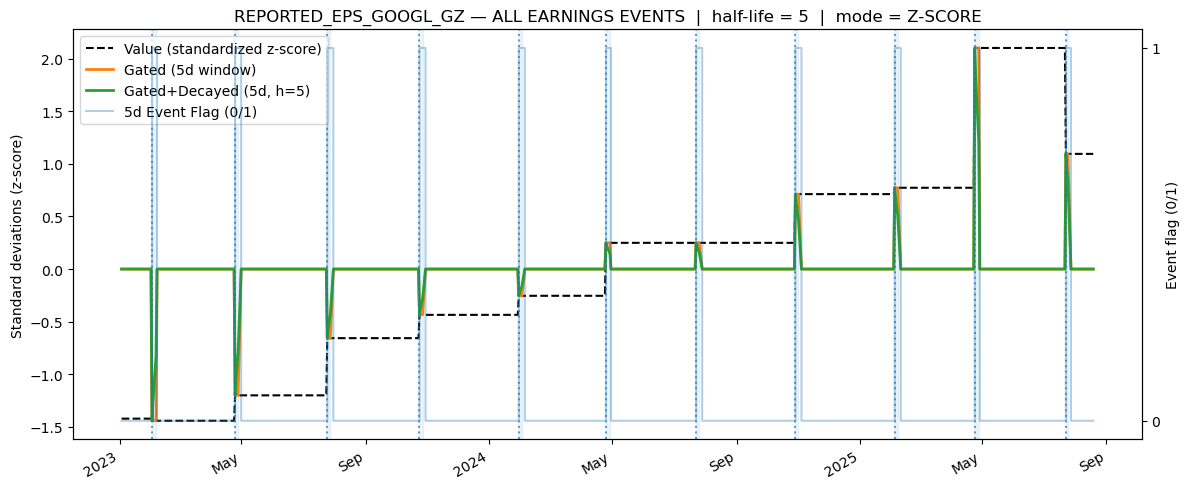

event_date  reported_eps_googl_gz (event-day)
0  2023-02-02                          -1.441512
1  2023-04-25                          -1.199987
2  2023-07-25                          -0.656557
3  2023-10-24                          -0.435160
4  2024-01-30                          -0.254016
5  2024-04-25                           0.249160
6  2024-07-23                           0.249160
7  2024-10-29                           0.712082
8  2025-02-04                           0.772463
9  2025-04-24                           2.100848
10 2025-07-23                           1.094496

event_date  reported_eps_googl_gz (event-day)
0  2023-02-02                          -1.441512
1  2023-04-25                          -1.199987
2  2023-07-25                          -0.656557
3  2023-10-24                          -0.435160
4  2024-01-30                          -0.254016
5  2024-04-25                           0.249160
6  2024-07-23                           0.249160
7  2024-10-29                           0.712082
8  2025-02-04                           0.772463
9  2025-04-24                           2.100848
10 2025-07-23                           1.094496

In [71]:
# Plot standardized units (_gz):
plot_all_earnings_events(wide_google_aug_tied, "GOOGL", value_kind="reported_eps", half_life=5, use_gz=True)

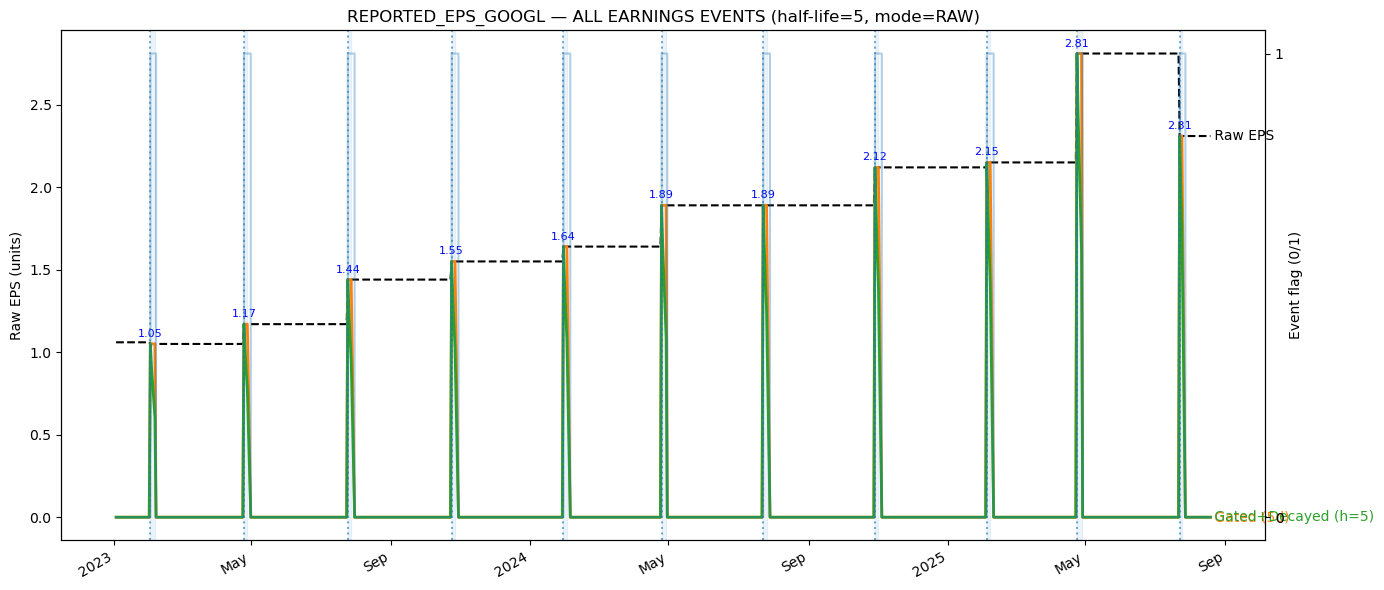

event_date  reported_eps_googl (event-day)
0  2023-02-02                            1.05
1  2023-04-25                            1.17
2  2023-07-25                            1.44
3  2023-10-24                            1.55
4  2024-01-30                            1.64
5  2024-04-25                            1.89
6  2024-07-23                            1.89
7  2024-10-29                            2.12
8  2025-02-04                            2.15
9  2025-04-24                            2.81
10 2025-07-23                            2.31

In [72]:
# add labels
def plot_all_earnings_events_with_labels(df, ticker: str, value_kind="reported_eps", half_life=5, use_gz=False):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    
    s = ticker.lower()
    val = f"{value_kind}_{s}" if not use_gz else f"{value_kind}_{s}_gz"
    flag1 = f"earning_date_{s}"
    flag5 = f"earnings_date_5d_{s}"
    gate5 = f"{val}__gate_earnings_date_5d_{s}"
    gate5d = f"{gate5}_dec_h{half_life}"

    if "date" in df.columns:
        x = pd.to_datetime(df["date"])
    else:
        x = pd.to_datetime(df.index)

    event_idx = df.index[df[flag1] == 1].tolist()
    event_dates = [x[i] for i in event_idx]
    event_vals  = [df.loc[i, val] for i in event_idx]
    event_tbl = pd.DataFrame({"event_date": event_dates, f"{val} (event-day)": event_vals})

    fig, ax = plt.subplots(figsize=(14,6))
    ax2 = ax.twinx()

    # plot curves
    line_val, = ax.plot(x, df[val], "--", lw=1.5, color="black")
    line_gate, = ax.plot(x, df[gate5], lw=2, color="tab:orange")
    line_gate5d, = ax.plot(x, df[gate5d], lw=2, color="tab:green")

    # label curves directly (at the right end of the chart)
    ax.text(x.iloc[-1], df[val].iloc[-1], " Raw EPS", color="black", va="center")
    ax.text(x.iloc[-1], df[gate5].iloc[-1], " Gated (5d)", color="tab:orange", va="center")
    ax.text(x.iloc[-1], df[gate5d].iloc[-1], f" Gated+Decayed (h={half_life})", color="tab:green", va="center")

    # add vertical lines and annotate event-day values
    for date, valnum in zip(event_dates, event_vals):
        ax.axvline(date, color="tab:blue", linestyle=":", alpha=0.6)
        ax.annotate(f"{valnum:.2f}", xy=(date, valnum), xytext=(0,5),
                    textcoords="offset points", ha="center", fontsize=8, color="blue")

    # event window shading
    for i in event_idx:
        j = i
        while j < len(df) and df.iloc[j][flag5] == 1:
            j += 1
        ax.axvspan(x[i], x[j-1] if j > 0 else x[i], color="tab:blue", alpha=0.08)

    # right y-axis for event flag
    ax2.plot(x, df[flag5], drawstyle="steps-post", alpha=0.35, color="tab:blue")
    ax2.set_ylim(-0.05, 1.05)
    ax2.set_yticks([0,1])
    ax2.set_ylabel("Event flag (0/1)")

    # formatting
    ax.set_title(f"{val.upper()} — ALL EARNINGS EVENTS (half-life={half_life}, mode={'RAW' if not use_gz else 'Z-SCORE'})")
    ax.set_ylabel("Raw EPS (units)" if not use_gz else "Standardized EPS (z-score)")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

    return event_tbl

# Plot Google's earnings:
plot_all_earnings_events_with_labels(wide_google_aug_tied, "GOOGL", value_kind="reported_eps", half_life=5, use_gz=False)

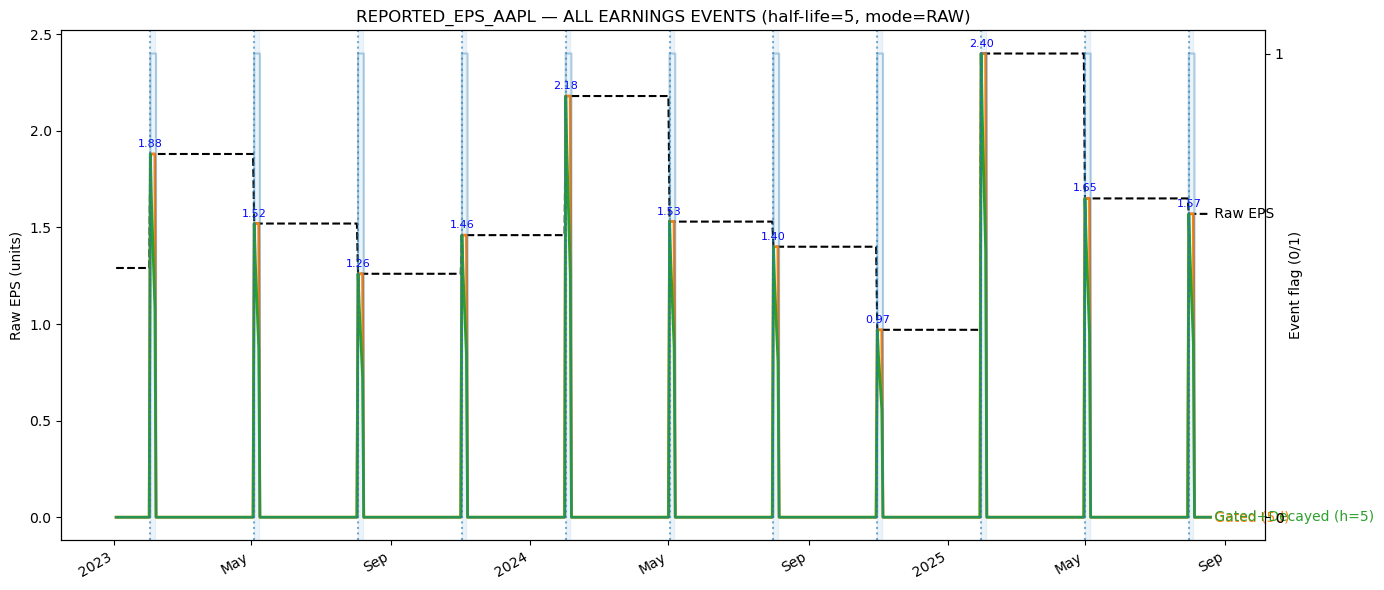

event_date  reported_eps_aapl (event-day)
0  2023-02-02                           1.88
1  2023-05-04                           1.52
2  2023-08-03                           1.26
3  2023-11-02                           1.46
4  2024-02-01                           2.18
5  2024-05-02                           1.53
6  2024-08-01                           1.40
7  2024-10-31                           0.97
8  2025-01-30                           2.40
9  2025-05-01                           1.65
10 2025-07-31                           1.57

In [74]:
# Plot Apple's earnings
plot_all_earnings_events_with_labels(wide_apple_aug_tied, "aapl", value_kind="reported_eps", half_life=5, use_gz=False)

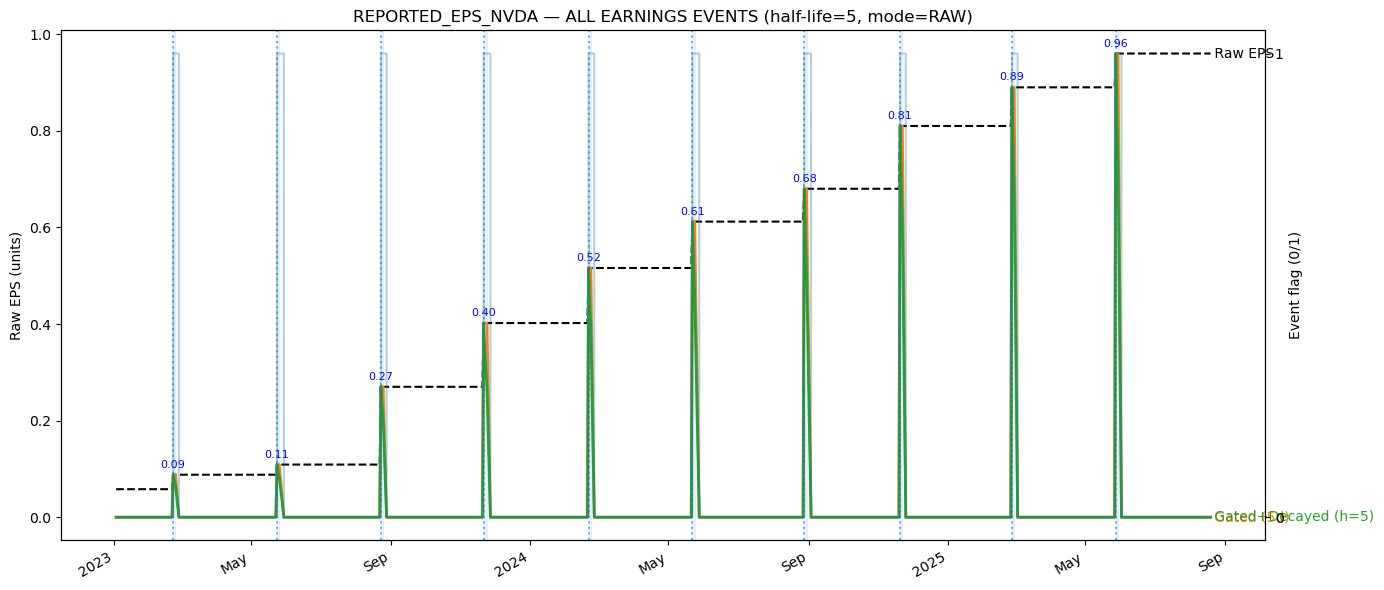

event_date  reported_eps_nvda (event-day)
0 2023-02-22                          0.088
1 2023-05-24                          0.109
2 2023-08-23                          0.270
3 2023-11-21                          0.402
4 2024-02-21                          0.516
5 2024-05-22                          0.612
6 2024-08-28                          0.680
7 2024-11-20                          0.810
8 2025-02-26                          0.890
9 2025-05-28                          0.960

In [75]:
# plot Nvidia's earnings
plot_all_earnings_events_with_labels(wide_nvda_aug_tied, "nvda", value_kind="reported_eps", half_life=5, use_gz=False)

In [77]:
# Quick summary report per ticker (to sanity check new earnings features)
def earnings_feature_summary(df, tickers):
    for tkr in tickers:
        slug = tkr.lower()
        cols = [c for c in df.columns if c.endswith(f"_{slug}") and ("__gate_" in c or "__decay_h" in c)]
        print(f"{tkr}: {len(cols)} new features")
        print("   ", cols[:5], "...")
earnings_feature_summary(wide_google_aug_tied, tickers_google)
earnings_feature_summary(wide_apple_aug_tied, tickers_apple)
earnings_feature_summary(wide_nvda_aug_tied, tickers_nvidia)

GOOGL: 24 new features
    ['estimated_eps_googl__gate_earning_date_googl', 'estimated_eps_googl__gate_earnings_date_2d_googl', 'estimated_eps_googl__gate_earnings_date_5d_googl', 'estimated_eps_googl_gz__gate_earning_date_googl', 'estimated_eps_googl_gz__gate_earnings_date_2d_googl'] ...
ADSK: 24 new features
    ['estimated_eps_adsk__gate_earning_date_adsk', 'estimated_eps_adsk__gate_earnings_date_2d_adsk', 'estimated_eps_adsk__gate_earnings_date_5d_adsk', 'estimated_eps_adsk_gz__gate_earning_date_adsk', 'estimated_eps_adsk_gz__gate_earnings_date_2d_adsk'] ...
TXN: 24 new features
    ['estimated_eps_txn__gate_earning_date_txn', 'estimated_eps_txn__gate_earnings_date_2d_txn', 'estimated_eps_txn__gate_earnings_date_5d_txn', 'estimated_eps_txn_gz__gate_earning_date_txn', 'estimated_eps_txn_gz__gate_earnings_date_2d_txn'] ...
AMZN: 24 new features
    ['estimated_eps_amzn__gate_earning_date_amzn', 'estimated_eps_amzn__gate_earnings_date_2d_amzn', 'estimated_eps_amzn__gate_earnings_date_

#### **Summarizing Methodological Note — Event-Aware Feature Engineering**

Macroeconomic variables (CPI, Trade, Unemployment, GDP, DSR, FOMC) and corporate earnings (EPS, revenue, surprises) are low-frequency events. If forward-filled, the model sees the same number repeated for long periods, which risks (A) spurious trend learning, and (B) dilution of the true market impact.

To align values with their actual release dynamics, event-aware features were engineered:

- **Event flags** (0/1): mark days within event windows (e.g., 1d, 2d, 5d).  
  *Example: `earnings_date_5d_googl`*  
- **Gated features**: raw/standardized values active only in event windows.  
  *Example: `reported_eps_googl__gate_earnings_date_5d_googl`*  
- **Decayed features**: values weighted to fade with time since release (half-life *h*).  
  *Example: `reported_eps_googl__decay_h5`*  
- **Gated+Decayed features**: combine both.  
  *Example: `reported_eps_googl__gate_earnings_date_5d_googl_dec_h5`*  

Half-lives were set to domain defaults (≈7–20 days for macros, 5 days for earnings). Both raw and standardized (`_gz`) values were preserved for interpretability.  

**Contribution:** These features eliminated misleading persistence, captured event-driven spikes with diminishing influence, and improved predictive power across horizons (short-term with 1–2d gates; medium-term with 5d gated+decayed features).

#### Event-Aware Features: Examples & Explanations
| **Feature Type**       | **Example Column**                                       | **Meaning**                                                       
| ---------------------- | -------------------------------------------------------- | -------------------------------------------------------------------
| **Raw Value**          | `reported_eps_googl`                                     | Actual earnings or macro value, forward-filled until next release 
| **Standardized Value** | `reported_eps_googl_gz`                                  | Same value but z-scored (mean=0, std=1)                           
| **Event Flag**         | `earnings_date_5d_googl`                                 | Binary 0/1 indicator: in event window or not                      
| **Gated**              | `reported_eps_googl__gate_earnings_date_5d_googl`        | Value shown **only inside window**, zero elsewhere               |
| **Decayed**            | `reported_eps_googl__decay_h5`                           | Value weighted by exponential decay since release (ne            |
| **Gated+Decayed**      | `reported_eps_googl__gate_earnings_date_5d_googl_dec_h5` | Value only in window, fades with half-life (h=5)                  


### Essential Preparatory Steps towards Walk Forward CV Modeling

Moving from preparatory feature engineering to modeling, the next stage applies **Walk-Forward Cross-Validation (WF CV)**. This validation approach is designed for time-series problems: the model is trained on past data and tested on the immediately following period, with the training window then rolled forward step by step. Unlike random splits, WF CV preserves temporal order and prevents look-ahead bias, making it well-suited for financial data.  

In this project, WF CV is used to evaluate year-round predictive performance of the models across multiple horizons ($H \in \{2,5,10,20\}$). By simulating how a model trained up to time *t* would perform in the next unseen window, WF CV provides a realistic estimate of out-of-sample performance and model robustness over time.

---
#### Experiment Grid

| Dimension | Setup |
|-----------|-------|
| **Models** | (A) Regularized linear baselines (ridge / elastic-net); (B) Gradient boosting (XGBoost / LightGBM) with shallow trees, subsampling, and early stopping |
| **Features** | Primary: engineered standardized features (`*_z`); Secondary: raw features retained for ablation |
| **Targets** | Forward returns with horizons $H = 2, 5, 10, 20$ trading days |
| **Paths** | **A. Peer-only:** features of peer tickers + global/macros<br>**B. Target-only:** target ticker’s features + global/macros<br>**C. Pooled hybrid:** tall panel across tickers with fixed effects (and optional ticker×feature interactions) |
| **Cross-Validation** | Walk-forward CV with purge/embargo equal to $H$ |

---

This grid defines the modeling design tested under WF CV, ensuring consistency across models, features, targets, and paths.


In [137]:
# Build walk-forward splits with purge/embargo
# the correct splitter for the daily walk-forward baseline.
def make_walk_forward_splits(dates, train_min=252, test_size=63, step=21, purge=10):
    """
    dates: pd.Series or index of datetime
    train_min: min training length (e.g., 1Y of trading days)
    test_size: length of each test block (e.g., 3 months ~ 63 trading days)
    step: how far we slide the window each fold
    purge: drop +/- 'purge' days around test from train (for T+10 targets use purge=10)
    """
    idx = np.arange(len(dates))
    out = []
    start = train_min
    while start + test_size <= len(dates):
        train_end = start  # exclusive
        test_start = train_end
        test_end = test_start + test_size

        tr = idx[:train_end]
        te = idx[test_start:test_end]

        # purge: drop train samples with date within [test_start - purge, test_end + purge]
        lo = max(0, test_start - purge)
        hi = min(len(idx), test_end + purge)
        keep_train = np.setdiff1d(tr, idx[lo:hi], assume_unique=True)

        out.append((keep_train, te))
        start += step
    return out

##### Methodological Note — Expanding Walk-Forward CV

In Walk-Forward Cross-Validation, **“expanding”** refers to a training window that grows over time. Each new fold retains all earlier data and adds the newly available observations, so the training set never shrinks. The test window (e.g., 63 trading days) rolls forward sequentially, always following the end of the training period.  

This design mimics real-world usage: as more history accumulates, models can be trained on progressively larger datasets, improving stability while still testing on strictly unseen future data.  

###### Example: Expanding WF CV with 1-Year Initial Training Window and 63-Day Tests

| Fold | Training Period Length | Test Period Length | Notes |
|------|-------------------------|--------------------|-------|
| 1    | 252 trading days (~1 year) | 63 trading days (~3 months) | Initial fit |
| 2    | 252 + 63 = 315 days | 63 days | Training expanded with Fold 1 test set |
| 3    | 252 + 2×63 = 378 days | 63 days | Training expanded again |
| …    | continues expanding | 63 days | Each fold adds new test block to training |

**Split meaning:** *Expanding* = training grows, test rolls forward. This differs from *rolling* windows, where the training length is fixed and old data is dropped as new data arrives.


### **Step C: Feature selection and pruning**

In [80]:
# Feature selection & Pruning

# Drop raw features when a standardized version exists.
# For each base feature, if a standardized twin (e.g., *_z, *_gz) is present,
# the raw version is removed. Ensures the model uses normalized features 
# while avoiding redundant signals. Raw de-meaned (*_dm) features are preserved.
def drop_raw_if_std_present(dfm, target_col, std_suffixes=("_gz", "_z"), verbose: bool = True):
# def drop_raw_if_std_present(dfm, target_col, std_suffixes=("_gz", "_z")): older version
    """
    If both 'base' and 'base_<suffix>' are present, drop the raw 'base' column.
    Keeps standardized columns; never drops *_z or *_gz (or *_dm).
    """
    feature_cols = [c for c in dfm.columns if c != target_col]
    feature_set = set(feature_cols)

    raw_to_drop = []
    for base in feature_cols:
        # skip already-standardized or de-meaned
        if base.endswith(std_suffixes) or base.endswith("_dm"):
            continue
        # if a standardized twin exists, drop the raw
        if any((base + suf) in feature_set for suf in std_suffixes):
            raw_to_drop.append(base)

    raw_to_drop = sorted(set(raw_to_drop))
    return dfm.drop(columns=raw_to_drop), raw_to_drop

# optional: drop features from a list
BANNED_PREFIXES = [
    "open_", "high_", "low_",
    "sma_ratio_20_",
    "bollinger_",
    "sharp_20d_", 
    "rolling_avg_10d_",
]

# Drop features unrelated to the target.
# Removes:
#   1. Features with correlation |r| < rmin with the target (Pearson or Spearman).
#   2. Features with insufficient data or NaN correlation.
#   3. Features starting with banned or user-specified prefixes.
# Keeps the target column unchanged and prints summary stats if verbose=True.
def drop_unrelated_features(
    dfm,
    target_col: str,
    drop_prefixes=(),       # e.g., ("earning_date_actual",)
    rmin: float = 0.10,     # keep columns with |corr| >= rmin
    method: str = "pearson",# or "spearman"
    min_n: int = 6,
    verbose: bool = True,
):
    """
    Prunes dfm by removing any non-target column whose |corr(target)| < rmin or corr is NaN.
    Also removes any column starting with a prefix in drop_prefixes (case-insensitive).
    Keeps target_col unchanged.
    """
    import pandas as pd
    from pandas.api.types import is_numeric_dtype

    assert target_col in dfm.columns, f"target_col '{target_col}' not in dfm"

    feats = [c for c in dfm.columns if c != target_col]
    y = dfm[target_col]
    bp = tuple(p.lower() for p in (drop_prefixes or ()))
    corrs = {}
    for c in feats:
        if not is_numeric_dtype(dfm[c]):  # skip non-numeric
            continue
        x = dfm[c]
        if x.notna().sum() >= min_n and y.notna().sum() >= min_n:
            r = x.rank().corr(y.rank()) if method == "spearman" else x.corr(y)
            if pd.notna(r):
                corrs[c] = r

    valid_corr_feats = set(corrs.keys())
    lowcorr  = [c for c in valid_corr_feats if abs(corrs[c]) < rmin]
    nan_corr = [c for c in feats if c not in valid_corr_feats]
    pref_drop = [c for c in feats if bp and c.lower().startswith(bp)]

    drop_set = set(lowcorr) | set(nan_corr) | set(pref_drop)
    keep = [target_col] + [c for c in feats if c not in drop_set]
    pruned = dfm[keep].copy()

    if verbose:
        def _peek(lst, k=8): return lst[:k]
        print(
            f"[drop_unrelated_features] kept={len(keep)-1} | "
            f"lowcorr={len(lowcorr)} | nan_corr={len(nan_corr)} | pref_drop={len(pref_drop)}"
        )
        if lowcorr:   print("  e.g. lowcorr:", _peek(sorted(lowcorr, key=lambda c: abs(corrs.get(c, 0)))))
        if pref_drop: print("  e.g. pref_drop:", _peek(pref_drop))
        if nan_corr:  print("  e.g. nan_corr:", _peek(nan_corr))
    return pruned


In [88]:
# Extract a DatetimeIndex from a dataframe.
# Prefers the existing DatetimeIndex; otherwise tries to build one from a 'date' column.
# Raises an error if neither is available, ensuring all downstream operations
# use consistent date-based indexing.
def get_dates(df, name="df"):
    """Return a DatetimeIndex for df. Prefer index; else try a 'date' column."""
    if isinstance(df.index, pd.DatetimeIndex):
        return df.index
    if "date" in df.columns:
        return pd.DatetimeIndex(pd.to_datetime(df["date"].values), name="date")
    raise TypeError(f"{name}: need a DatetimeIndex or a 'date' column (not an Int64Index).")

In [89]:
# Lowercase utility: convert any string to lowercase (safe wrapper).
def _lower(s): return str(s).lower()

# Check if a column name contains a ticker token (surrounded by underscores or boundaries).
# Ensures precise matching (e.g., 'close_googl' matches 'googl', but 'google' does not).
def contains_ticker_token(col: str, tkr: str) -> bool:
    """
    True if `col` has `_tkr` as a token anywhere (start/middle/end).
    Matches: *_<tkr>, <tkr> at start with underscore after, or surrounded by underscores.
    Examples that match for tkr='googl':
      'close_googl', 'ret_5d_googl_z', 'bollinger_upper_googl_dm'
    """
    s = _lower(col)
    t = _lower(tkr)
    # tokenized by underscores; e.g. (^|_)tkr(_|$)
    return re.search(rf'(?<![A-Za-z0-9]){t}(?![A-Za-z0-9])', s.replace("_"," ")) is not None

# Exclude future-looking target columns (prefixed with "future_") from a feature list.
def exclude_future(cols):
    """Drop any future_* targets."""
    return [c for c in cols if not _lower(c).startswith("future_")]

# Prefer standardized/de-meaned features over raw versions.
# Drops raw base columns if *_gz, *_z, or *_dm twins exist. Prints summary if verbose=True.
def prefer_standardized(dfm, target_col, std_suffixes=("_gz", "_z", "_dm"), verbose=True):
    """
    Drop raw feature if a standardized/de-meaned twin exists.
    Keeps *_gz / *_z / *_dm, drops only the raw base.
    """
    feat_cols = [c for c in dfm.columns if c != target_col]
    have = set(feat_cols)
    drop = []

    for base in feat_cols:
        lb = base.lower()
        if lb.endswith(std_suffixes):
            continue
        # check if any standardized/de-meaned twin exists
        if any((base + suf) in have for suf in std_suffixes):
            drop.append(base)
    drop = sorted(set(drop))
    dfm2 = dfm.drop(columns=drop)
    if verbose:
        print(f"[prefer_standardized] dropped {len(drop)} raw columns, kept {dfm2.shape[1]-1} features")
    return dfm2, drop

# Path selectors (exclusion-only)
# define a robust features selection by path - by exclusion of cols only

# PATH A selector: Peer-only + globals.
# Keeps all columns EXCEPT those referencing the target ticker. Globals/macros remain.
def feat_cols_path_A(all_cols, target_ticker):
    """
    PATH A (peer-only + globals): exclude ANY column that references the TARGET ticker.
    We do not whitelist/blacklist globals here; anything not mentioning the target survives.
    """
    cols = exclude_future(all_cols)
    return [c for c in cols if not contains_ticker_token(c, target_ticker)]

# PATH B selector: Target-only + globals.
# Keeps target ticker’s columns and globals/macros; excludes any columns referencing peers.
def feat_cols_path_B(all_cols, target_ticker, peer_sets):
    """
    PATH B (target-only + globals): exclude ANY column that references a PEER ticker.
    That naturally keeps target-specific columns and globals.
    """
    cols = exclude_future(all_cols)
    peers = [p for p in peer_sets.get(target_ticker.lower(), []) if p.lower() != target_ticker.lower()]
    out = []
    for c in cols:
        if any(contains_ticker_token(c, p) for p in peers):
            continue
        out.append(c)
    return out

# PATH C selector: Everything (target, peers, globals) except future_* targets.
def feat_cols_path_C(all_cols):
    """PATH C (everything except future_*)."""
    return exclude_future(all_cols)

# Drop redundant or low-value features:
# - Removes *_dm (de-meaned) since *_z/_gz are preferred.
# - Removes 'return_volatility_5day_*' (duplicated/unstable).
def drop_dm_dup(cols):
    """
    Drop:
      - *_dm columns (de-meaned, we already prefer _z/_gz)
      - any column starting with 'return_volatility_5day_'
    """
    out = []
    for c in cols:
        cl = c.lower()
        if cl.endswith("_dm"):
            continue
        if cl.startswith("return_volatility_5day_"):
            continue
        out.append(c)
    return out

In [90]:
# adding numeric companions (day_of_week_num, quarter_num, *_doy) 
# without dropping the original string/date columns:
def prepare_master_for_corr(df: pd.DataFrame) -> pd.DataFrame:
    w = df.copy()

    # day_of_week -> 0..6 (if text)
    if "day_of_week" in w.columns and "day_of_week_num" not in w.columns:
        if w["day_of_week"].dtype == "O":
            map_dow = {name:i for i,name in enumerate(
                ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])}
            w["day_of_week_num"] = w["day_of_week"].map(map_dow)
        else:
            # already numeric (keep it)
            w["day_of_week_num"] = pd.to_numeric(w["day_of_week"], errors="coerce")

    # "Q1".."Q4" -> 1..4
    if "current_quarter" in w.columns and "quarter_num" not in w.columns:
        w["quarter_num"] = w["current_quarter"].map({"Q1":1,"Q2":2,"Q3":3,"Q4":4})

    # day-of-year for date-like earnings columns
    for col in ["earning_date_actual","quarter_ending"]: # excluding earning_date (0/1)
        if col in w.columns and (col + "_doy") not in w.columns:
            dt = pd.to_datetime(w[col], errors="coerce")
            w[col + "_doy"] = dt.dt.dayofyear

    return w

In [98]:
# Selection of features and pruning documentation functions

# Audit features whose correlation with the target is NaN.
# Inspects each column and reports the cause (non-numeric, all NaN, constant,
# no overlap in non-missing rows, or true nan_corr). Returns a dataframe
# summarizing problematic features to guide pruning decisions.
def audit_corr_nan(dfm: pd.DataFrame, target_col: str) -> pd.DataFrame:
    """
    List feature columns whose Pearson correlation with the target is NaN.
    Also annotates *why* (non-numeric, all_nan, constant, no_overlap, nan_corr).
    Safe to call even if nothing is returned (won't crash on sort).
    """
    out = []
    y = dfm[target_col]
    for c in dfm.columns:
        if c == target_col:
            continue
        x = dfm[c]
        is_num  = pd.api.types.is_numeric_dtype(x)
        all_nan = x.isna().all()
        nunique = x.nunique(dropna=True)
        const   = (nunique <= 1)

        # Pairwise non-missing overlap
        mask = x.notna() & y.notna()
        if mask.sum() == 0:
            r, cause = np.nan, "no_overlap"
        else:
            if is_num and not const and not all_nan:
                r = x[mask].corr(y[mask])
                cause = "ok" if pd.notna(r) else "nan_corr"
            else:
                r = np.nan
                if not is_num:       cause = "non_numeric"
                elif all_nan:        cause = "all_nan"
                elif const:          cause = "constant"
                else:                cause = "nan_corr"

        if np.isnan(r):
            out.append({
                "column": c,
                "dtype_numeric": is_num,
                "all_nan": bool(all_nan),
                "nunique": int(nunique),
                "constant_or_single_value": bool(const),
                "corr_with_target": r,
                "likely_cause": cause
            })

    res = pd.DataFrame(out)
    if res.empty:
        return res
    return res.sort_values(["likely_cause","column"]).reset_index(drop=True)

# Audit features with very low correlation to the target.
# Lists numeric features whose |corr| < rmin (default 0.10),
# along with the correlation value and number of valid observations.
# Useful for pruning weak predictors. Returns top N results by abs(corr).
def audit_lowcorr(dfm: pd.DataFrame, target_col: str, rmin: float=0.10, top: int=30) -> pd.DataFrame:
    """
    List numeric features with |corr| < rmin (computed on pairwise non-NaN rows).
    """
    rows = []
    for c in dfm.columns:
        if c == target_col: 
            continue
        x = dfm[c]; y = dfm[target_col]
        if not pd.api.types.is_numeric_dtype(x):
            continue
        mask = x.notna() & y.notna()
        if mask.sum() == 0:
            continue
        r = x[mask].corr(y[mask])
        if pd.notna(r) and abs(r) < rmin:
            rows.append((c, r, mask.sum()))
    out = pd.DataFrame(rows, columns=["column","corr","n_obs"]).sort_values("corr", key=lambda s: s.abs())
    return out.head(top)


In [99]:
# Enforce numeric-only features and drop invalid columns.
# Keeps the target column and filters features by:
#   1) Numeric dtype only,
#   2) Removing all-NaN columns,
#   3) Removing constant (single-value) columns.
# Returns a cleaned dataframe plus a report dict of dropped columns by category.
def enforce_numeric_features(dfm: pd.DataFrame, target_col: str):
    """
    Keep only numeric feature columns; drop all-NaN and constant columns.
    Returns (clean_df, dropped_report_dict).
    """
    y = dfm[[target_col]]
    X = dfm.drop(columns=[target_col])

    # 1) numeric only
    X_num = X.select_dtypes(include=[np.number])

    # 2) drop all-NaN columns
    all_nan_cols = X_num.columns[X_num.isna().all()].tolist()
    X_num = X_num.drop(columns=all_nan_cols, errors="ignore")

    # 3) drop constant columns
    nun = X_num.nunique(dropna=True)
    const_cols = nun[nun <= 1].index.tolist()
    X_num = X_num.drop(columns=const_cols, errors="ignore")

    dropped = {
        "non_numeric": sorted(list(set(X.columns) - set(X_num.columns) - set(all_nan_cols) - set(const_cols))),
        "all_nan": sorted(all_nan_cols),
        "constant": sorted(const_cols),
    }
    return y.join(X_num), dropped


In [100]:
# improving XGB performance

# Time-ordered validation split for each fold.
# Splits training data chronologically: first part for training, last part for validation.
# Ensures temporal integrity and avoids leakage in time-series CV.
def _val_split_time_ordered(Xtr, ytr, val_frac=0.25):
    n = len(ytr)
    n_val = max(30, int(n * val_frac))  # at least ~30 points
    n_trn = n - n_val
    return (Xtr[:n_trn], ytr[:n_trn]), (Xtr[n_trn:], ytr[n_trn:])

# Custom evaluation metric for XGB: directional accuracy (hit rate).
# Compares the sign of predictions vs. true labels; higher is better.
def _feval_hit(preds, dmatrix):
    y_true = dmatrix.get_label()
    hit = (np.sign(preds) == np.sign(y_true)).mean()
    return ('hit', float(hit), True)   # higher is better

# Ridge-based feature preselector (train-fold only, no leakage).
# Fits Ridge regression and selects top-K features by absolute weight magnitude.
def ridge_top_k_features(X, y, cols, K=50):
    from sklearn.linear_model import RidgeCV
    rid = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(X, y)
    w = np.abs(rid.coef_)
    idx = np.argsort(w)[::-1][:K]
    return [cols[i] for i in idx]

# Tune XGBoost hyperparameters within a fold using a small grid search.
# Uses time-ordered validation split and directional hit as the selection metric.
# Returns the best-performing XGB model for that fold.
def _tuned_xgb_for_fold(Xtr, ytr, random_state=42):
    """
    Older xgboost.sklearn-compatible tuning (no early stopping).
    Picks params by validation directional hit on a time-ordered split.
    """
    import numpy as np
    from xgboost import XGBRegressor

    # time-ordered split
    (X_tr, y_tr), (X_val, y_val) = _val_split_time_ordered(Xtr, ytr, val_frac=0.25)

    # Base params (NO n_estimators here!)
    base = dict(
        objective="reg:squarederror",
        learning_rate=0.03,
        reg_alpha=0.0, reg_lambda=1.0,
        tree_method="hist",
        random_state=random_state,
        verbosity=0,
    )

    # Small grid — you can widen later
    grid = [
        dict(max_depth=d, min_child_weight=m, subsample=ss, colsample_bytree=cs, n_estimators=ne)
        for d in (3, 4, 5, 6)
        for m in (1, 5)
        for ss in (0.7, 0.9)
        for cs in (0.7, 0.9)
        for ne in (400, 800, 1200)
    ]

    best_hit, best_model = -1.0, None
    for p in grid:
        mdl = XGBRegressor(**base, **p)   # no duplicate keys now
        mdl.fit(X_tr, y_tr)
        yv = mdl.predict(X_val)
        hit = (np.sign(yv) == np.sign(y_val)).mean()
        if hit > best_hit:
            best_hit, best_model = hit, mdl

    return best_model

# Unified booster prediction wrapper for trained XGB model.
# Returns predictions on the given feature matrix X.
def _booster_predict(model, X):
    return model.predict(X)

In [101]:
# used in modeling pipe

# Quick diagnostic report of missing values.
# Prints average feature missingness (excluding target), number of rows, and number of features.
def quick_nan_report(dfm, name):
    miss = dfm.drop(columns=[target_col]).isna().mean().mean()
    print(f"[{name}] mean feature missingness: {miss:.3%} | rows={len(dfm):,} | feats={dfm.shape[1]-1}")

# Evaluate model predictions with three intuitive metrics:
#   - hit: directional accuracy (sign agreement y_true vs y_pred)
#   - strat_ret: naive strategy return (avg realized return when predicting long)
#   - spearman: rank correlation between predictions and true returns
def eval_metrics(y_true, y_pred):
    """
    Computes three simple, interpretable metrics per fold:
      - hit: directional accuracy, i.e., % of times sign(y_pred) == sign(y_true)
      - strat_ret: average realized return under a naive rule:
                   go long if prediction > 0, else stay flat.
                   (For cross-sectional portfolios, replace with long-short spread.)
      - spearman: rank correlation (Spearman) between predictions and realized returns,
                  robust to monotonic transformations of the score.
    """
    # Directional accuracy (classification-style correctness on the sign)
    hit = (np.sign(y_pred) == np.sign(y_true)).mean()
    # Simple strategy return: average realized return on the subset where the model is long
    strat_ret = y_true[y_pred > 0].mean() if np.any(y_pred > 0) else 0.0
    # Rank correlation (monotonic association); NaNs ignored by 'omit'
    rho = spearmanr(y_true, y_pred, nan_policy="omit").correlation
    return {"hit": hit, "strat_ret": strat_ret, "spearman": rho}

# Lightweight fallback version of eval_metrics (same logic, no docstring).
# Ensures metrics always return floats, even in edge cases.
def _eval_metrics_fallback(y_true, y_pred):
    hit = (np.sign(y_pred) == np.sign(y_true)).mean()
    strat_ret = y_true[y_pred > 0].mean() if np.any(y_pred > 0) else 0.0
    rho = spearmanr(y_true, y_pred, nan_policy="omit").correlation
    return {"hit": float(hit), "strat_ret": float(strat_ret), "spearman": float(rho)}

# Strict evaluation of predictions, enforcing float arrays and handling edge cases.
# Computes hit, strategy return, and Spearman correlation (flattened if SciPy returns a matrix).
# More robust than eval_metrics for non-standard inputs.
def eval_metrics_strict(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float).reshape(-1)
    y_pred = np.asarray(y_pred, dtype=float).reshape(-1)

    hit = (np.sign(y_pred) == np.sign(y_true)).mean()
    strat_ret = y_true[y_pred > 0].mean() if np.any(y_pred > 0) else 0.0

    r = spearmanr(y_true, y_pred, nan_policy="omit")
    rho = r.correlation
    # if SciPy gives a matrix, take the off-diagonal [0,1]
    if hasattr(rho, "shape") and rho.shape != ():
        rho = float(np.asarray(rho)[0, 1])
    else:
        rho = float(rho)

    return {"hit": float(hit), "strat_ret": float(strat_ret), "spearman": rho}

In [102]:
# --- tiny helper Ridge factory (used by filters) 
# RidgeCV factory for (fast) linear baseline and feature scoring.
# Returns a cross-validated Ridge estimator over log-spaced alphas
def _ridge():
    from sklearn.linear_model import RidgeCV
    return RidgeCV(alphas=np.logspace(-4, 3, 20))

# Leakage-safe permutation importance computed on an inner validation slice.
# For each outer (train, test) fold:
#   - time-split TRAIN into (subtrain, val),
#   - fit model on subtrain,
#   - compute PI on val (avoids using the outer TEST for feature filtering).
# Returns a DataFrame of per-fold importances plus their mean.
def perm_importance_by_fold_val(model_fn, dfm, splits, target_col, feat_cols=None, n_repeats=30):
    """
    For each (train, test) fold:
      - time-split TRAIN into (subtrain, val)
      - fit model on subtrain
      - compute permutation importance on val (no leakage from outer test)
    Returns a DataFrame with per-fold importances and their mean.
    """
    X_all = dfm.drop(columns=[target_col])
    if feat_cols is None:
        feat_cols = list(X_all.columns)

    out = []
    for k, (tr_idx, te_idx) in enumerate(splits):
        # TRAIN portion for this outer fold
        Xtr_full = X_all.iloc[tr_idx][feat_cols].values
        ytr_full = dfm[target_col].iloc[tr_idx].values
        # time-ordered inner split: (subtrain, val)
        (X_tr, y_tr), (X_val, y_val) = _val_split_time_ordered(Xtr_full, ytr_full, val_frac=0.25)

        mdl = model_fn().fit(X_tr, y_tr)
        r = permutation_importance(mdl, X_val, y_val, n_repeats=n_repeats, random_state=42)
        out.append(pd.Series(r.importances_mean, index=feat_cols, name=f"fold_{k}"))

    PI = pd.concat(out, axis=1)
    PI["mean_perm"] = PI.mean(axis=1)
    return PI.sort_values("mean_perm", ascending=False)

# Ridge-based stability selection across folds.
# In each TRAIN split: fit Ridge, take top-K by |coef|, count selections.
# Keep features appearing in at least min_frac of folds. Returns (keep_list, counts).
def ridge_stability_select(dfm, splits, target_col, K=40, min_frac=0.6):
    """
    Across folds, fit Ridge on TRAIN and record the top-K |coef| features.
    Keep features that appear in >= min_frac of folds.
    """
    from sklearn.linear_model import RidgeCV

    X = dfm.drop(columns=[target_col])
    y = dfm[target_col].values
    cols = np.array(X.columns)

    counts = pd.Series(0, index=cols)
    for tr_idx, te_idx in splits:
        mdl = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(X.iloc[tr_idx].values, y[tr_idx])
        top = cols[np.argsort(np.abs(mdl.coef_))[::-1][:K]]
        counts[top] += 1

    keep = counts[counts >= min_frac * len(splits)].index.tolist()
    return keep, counts.sort_values(ascending=False)

# Combine model-based filters to select a robust feature set.
# 1) Permutation importance (inner val by default) → drop harmful/neutral features (mean PI <= pi_eps).
# 2) Ridge stability selection across folds → intersect with stable features.
# 3) Safety fallback to avoid over-pruning (min_feats).
# Returns (filtered_dfm, report_dict with PI table, lists, counts, final features).
def apply_model_based_filters(
    dfm,
    splits,
    target_col,
    pi_mode: str = "val",     # "val" (recommended, no leakage) or "test" (replicates your earlier approach)
    n_repeats: int = 30,      # permutation repeats
    stab_K: int = 40,         # top-K for stability per fold
    stab_min_frac: float = 0.6,
    min_feats: int = 30,      # safety floor: if intersection is too small, fall back to drop-harmful-only
    pi_eps: float = 0.0,      # drop if mean PI <= pi_eps (use small +eps to be stricter)
    verbose: bool = True
):
    """
    Returns: (dfm_filtered, report_dict)
      - dfm_filtered has [target_col] + final_features
      - report_dict contains PI table, harmful list, stable list, and counts
    """
    feats_now = [c for c in dfm.columns if c != target_col]

    # ---- 1) Permutation Importance across folds ----
    if pi_mode == "val":
        PI = perm_importance_by_fold_val(_ridge, dfm, splits, target_col, feat_cols=feats_now, n_repeats=n_repeats)
        pi_col = "mean_perm"
    elif pi_mode == "test":
        #  original test-based PI (slight leakage risk if reused for evaluation on same outer test)
        PI = perm_importance_by_fold(_ridge, dfm, splits, target_col, feat_cols=feats_now, n_repeats=n_repeats)
        pi_col = "mean_test_perm"
    else:
        raise ValueError("pi_mode must be 'val' or 'test'")

    harmful = PI[PI[pi_col] <= pi_eps].index.tolist()
    if verbose:
        print(f"[PI/{pi_mode}] harmful_or_neutral: {len(harmful)} (threshold <= {pi_eps})")
    # ---- 2) Stability selection across folds ----
    stable_keep, stab_counts = ridge_stability_select(dfm, splits, target_col, K=stab_K, min_frac=stab_min_frac)
    if verbose:
        print(f"[Stability] keep count: {len(stable_keep)} (K={stab_K}, min_frac={stab_min_frac})")

    # ---- 3) Combine: drop harmful, then intersect with stable ----
    # Start from current feature set:
    cur = [c for c in feats_now if c not in harmful]
    final = [c for c in cur if c in stable_keep]

    # Safety: if too few remain, fall back to drop-harmful-only
    if len(final) < min_feats:
        if verbose:
            print(f"[Safety] After intersection only {len(final)} remain (<{min_feats}). "
                  f"Falling back to 'drop harmful only'.")
        final = cur

    dfm_out = dfm[[target_col] + final].copy()

    report = {
        "PI_table": PI,               # DataFrame of per-fold PI and mean
        "harmful_list": harmful,      # features dropped by PI
        "stable_list": stable_keep,   # features passing stability
        "stability_counts": stab_counts,  # counts per feature
        "final_features": final,      # used in dfm_out
    }
    if verbose:
        kept = len(final)
        print(f"[Final filter] kept {kept} features (from {len(feats_now)})")
    return dfm_out, report
# ===============================================================
# Modeling helpers
# ===============================================================
# Build the modeling frame with the target and selected features.
# - Filters rows to ensure target availability and sufficient feature coverage.
# - Drops an initial warmup period to avoid early rolling/EWMA NaNs.
# - Reattaches/aligns a proper DatetimeIndex for downstream WF logic.
# Returns the cleaned dfm ready for CV.
def build_model_frame(df_aug, target_col, use_cols, warmup_days=30, allow_missing_frac=0.0):
    """
    Constructs the modeling DataFrame with:
      - the specified target column, and
      - the selected feature columns 'use_cols'.
    Parameters
    ----------
    df_aug : pd.DataFrame
        Augmented wide frame (raw + *_dm + *_z), indexed by date.
    target_col : str
        Name of the target column, e.g., 'future_10d_ret_googl'.
    use_cols : list[str]
        The subset of columns to use as features (e.g., Path A or Path B feature lists).
    warmup_days : int
        Drops the earliest 'warmup_days' rows to avoid early NaNs from rolling/EWMA shifts.
        Typical choice ≈ 30; may set to half of the longest rolling window if desired.
    allow_missing_frac : float in [0, 1]
        If 0.0: require all features present on a row.
        If >0.0: allow a row to have up to 'allow_missing_frac' proportion of missing features.
                 Common choices: 0.0 (strict), 0.05 (allow up to 5% missing), etc.
    Returns
    -------
    dfm : pd.DataFrame
        Modeling frame with [target_col] + use_cols, filtered for NaN safety and warmed up.
    """
    # --- 0) NEW: capture true calendar dates from df_aug (index or 'date' col)
    dates_aug = get_dates(df_aug, "df_aug")   # <— uses the helper we added
    # 1) Target must exist (removes last H rows where the forward return cannot be computed)
    m = df_aug[target_col].notna()
    # 2) Feature availability mask:
    if allow_missing_frac == 0.0:
        # Strict: all selected features must be present
        m &= df_aug[use_cols].notna().all(axis=1)
    else:
        # Tolerant: require at least (1 - allow_missing_frac) fraction present
        m &= (df_aug[use_cols].notna().mean(axis=1) >= (1.0 - allow_missing_frac))
    # 3) Apply mask and drop the first 'warmup_days' to avoid early rolling/EWMA NaNs
    dfm = df_aug.loc[m, [target_col] + use_cols].iloc[warmup_days:].copy()
        # --- 4) NEW: reattach the real dates so downstream code sees a DatetimeIndex
        # ✅ FIX: align dates by index instead of .iloc on DatetimeIndex
    dfm.index = dates_aug[m][warmup_days:]
    dfm.index.name = "date"
    # (optional sanity)
    dfm.sort_index(inplace=True)
    return dfm
    
# Ensure all input dataframes share a sorted DatetimeIndex and identical row alignment.
# - Forces datetime index + sorting per df.
# - Intersects indices to a common timeline.
# - Reindexes each df to the common index and sanity-checks monotonic order/equality.
# Returns (aligned_dfs, common_index).
def ensure_datetime_and_align(*dfs):
    # 1) force DatetimeIndex + sort for each df
    out = []
    for d in dfs:
        d = d.copy()
        d.index = pd.to_datetime(d.index)           # in case it isn't already
        d.sort_index(inplace=True)                  # critical for WF logic
        out.append(d)

    # 2) compute common, sorted index (guarantee monotonic increasing)
    common_idx = out[0].index
    for d in out[1:]:
        common_idx = common_idx.intersection(d.index)
    common_idx = common_idx.sort_values()

    # 3) align all frames to the exact same index in the same order
    out = [d.reindex(common_idx) for d in out]

    # 4) sanity checks
    assert all(x.index.is_monotonic_increasing for x in out)
    for x in out[1:]:
        assert x.index.equals(out[0].index)

    return out, common_idx
# def run_path(...): ...
# def eval_metrics(...): ...

# etc.


In [121]:
# modeling functions
# Optional import of XGBoost callback utilities (kept optional to avoid breaking the notebook if absent).
try:
    from xgboost import callback as xgb_callback
except Exception:
    xgb_callback = None  # fallback if callbacks module isn't present

# Optional XGBoost baseline (guard import to keep the cell robust if xgboost isn't installed)
try:
    from xgboost import XGBRegressor
    _has_xgb = True
except Exception:
    _has_xgb = False

# Run one modeling path over all walk-forward folds.
# - Ridge: standard CV Ridge baseline.
# - XGB: hybrid flow = Ridge top-K preselection (train-only) + tuned XGB on a time-ordered split.
# Returns mean±std for hit, strategy return, and Spearman across folds.   
def run_path(dfm, model_name="ridge", preselect_K=50):
    """
    Trains & evaluates a model on each walk-forward fold.
    - Ridge: unchanged from your baseline.
    - XGB:   hybrid = Ridge top-K feature preselection (train fold only) + tuned XGB with early stopping.
    """
    from sklearn.linear_model import RidgeCV
    from scipy.stats import spearmanr

    X_full = dfm.drop(columns=[target_col])
    y_full = dfm[target_col].values
    cols_full = X_full.columns

    metrics = []

    #for tr_idx, te_idx in splits:
    for tr_idx, te_idx in tqdm(splits, desc=f"{model_name} {len(splits)} folds"):
        Xtr_full = X_full.iloc[tr_idx].values
        ytr      = y_full[tr_idx]
        Xte_full = X_full.iloc[te_idx].values
        yte      = y_full[te_idx]

        if model_name == "ridge":
            mdl = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr_full, ytr)
            yhat = mdl.predict(Xte_full)

        elif model_name == "xgb" and _has_xgb:
            # ---- Hybrid pre-selection (no leakage) ----
            top_cols = ridge_top_k_features(Xtr_full, ytr, cols_full, K=preselect_K)
            Xtr = dfm[top_cols].iloc[tr_idx].values
            Xte = dfm[top_cols].iloc[te_idx].values
            # ---- Tuned XGB with early stopping on a time-ordered val slice ----
            booster = _tuned_xgb_for_fold(Xtr, ytr)
            yhat = _booster_predict(booster, Xte)

        else:
            raise ValueError("Unknown model or XGBoost not available.")

        # ---- your metrics (unchanged) ----
        hit = (np.sign(yhat) == np.sign(yte)).mean()
        strat_ret = yte[yhat > 0].mean() if np.any(yhat > 0) else 0.0
        rho = spearmanr(yte, yhat, nan_policy="omit").correlation
        metrics.append({"hit": hit, "strat_ret": strat_ret, "spearman": rho})

    out = {
        k: (np.mean([m[k] for m in metrics]), np.std([m[k] for m in metrics], ddof=1))
        for k in metrics[0].keys()
    }
    return out
    
# Cache per-fold Ridge feature rankings (train-only, leakage-safe).
# For each fold, fit Ridge on TRAIN and record features ordered by |coef|.
# Returns (list of rankings per fold, feature name list).
def cache_ridge_rankings(dfm, splits, target_col):
    """
    Returns:
      - rankings: list[ list[str] ], one feature-order per fold (|coef| desc)
      - cols:     feature names in dfm (for reference)
    """
    from sklearn.linear_model import RidgeCV
    import numpy as np
    X = dfm.drop(columns=[target_col])
    y = dfm[target_col].values
    cols = list(X.columns)

    rankings = []
    for (tr_idx, te_idx) in splits:
        Xtr, ytr = X.iloc[tr_idx].values, y[tr_idx]
        rid = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
        order = np.argsort(np.abs(rid.coef_))[::-1]   # descending by |coef|
        rankings.append([cols[i] for i in order])
    return rankings, cols
    
# Time-ordered validation split helper (first part → train, last part → val).
# Preserves chronology and avoids look-ahead within a fold.
def _val_split_time_ordered(Xtr, ytr, val_frac=0.25):
    n = len(ytr)
    n_val = max(30, int(n * val_frac))
    n_trn = n - n_val
    return (Xtr[:n_trn], ytr[:n_trn]), (Xtr[n_trn:], ytr[n_trn:])

# Fast XGB fit for sweeping K (robust to XGBoost version).
# Uses a small, fixed config and early stopping when available on a time-ordered val split.
# Intended for quick comparative runs, not final tuning.
def fast_xgb_for_sweep(Xtr, ytr, random_state=42):
    # Version-robust XGB: supports old/new APIs; uses early stopping when possible.
    from xgboost import XGBRegressor
    try:
        from xgboost import callback as xgb_callback  # new-style callbacks
    except Exception:
        xgb_callback = None

    # time-ordered inner split
    (X_tr, y_tr), (X_val, y_val) = _val_split_time_ordered(Xtr, ytr, val_frac=0.25)

    # base params
    base = dict(
        n_estimators=400, max_depth=3, learning_rate=0.06,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=random_state, tree_method="hist", verbosity=0
    )
    # 1) Try: eval_metric in fit (newer sklearn wrapper)
    mdl = XGBRegressor(**base)
    try:
        if xgb_callback is not None:
            # Prefer callback EarlyStopping (more version-proof)
            mdl.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                callbacks=[xgb_callback.EarlyStopping(rounds=50, save_best=True, maximize=False)]
            )
        else:
            # Older but still supports early_stopping_rounds
            mdl.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=50,
                verbose=False
            )
        return mdl
    except TypeError:
        # 2) Very old API: no eval_set kwargs accepted → train without ES
        mdl = XGBRegressor(**base)
        mdl.fit(X_tr, y_tr)
        return mdl

# Sweep top-K feature counts using cached Ridge rankings.
# For each K and fold: fit fast XGB on top-K features (train-only) and evaluate on the fold's TEST.
# Prints/returns aggregate metrics per K (hit, Spearman, strategy return).
def sweep_K_with_cached_rankings(dfm, splits, target_col, rankings, Ks=(20,30,40,60)):
    X_full = dfm.drop(columns=[target_col])
    y_full = dfm[target_col].values

    results = {}
    for K in Ks:
        fold_metrics = []
        for fold, (tr_idx, te_idx) in enumerate(splits):
            topK = rankings[fold][:K]
            Xtr = X_full.iloc[tr_idx][topK].values
            ytr = y_full[tr_idx]
            Xte = X_full.iloc[te_idx][topK].values
            yte = y_full[te_idx]

            model = fast_xgb_for_sweep(Xtr, ytr)
            yhat = model.predict(Xte)

            hit = (np.sign(yhat) == np.sign(yte)).mean()
            strat_ret = yte[yhat > 0].mean() if np.any(yhat > 0) else 0.0
            rho = spearmanr(yte, yhat, nan_policy="omit").correlation
            fold_metrics.append((hit, strat_ret, rho))

        arr = np.array(fold_metrics)
        results[K] = {
            "hit_mean": arr[:,0].mean(), "hit_std": arr[:,0].std(ddof=1),
            "ret_mean": arr[:,1].mean(), "ret_std": arr[:,1].std(ddof=1),
            "spearman_mean": arr[:,2].mean(), "spearman_std": arr[:,2].std(ddof=1),
        }
        print(f"K={K:>3} | hit={results[K]['hit_mean']:.3f}±{results[K]['hit_std']:.3f} "
              f"| rho={results[K]['spearman_mean']:.3f}±{results[K]['spearman_std']:.3f} "
              f"| ret={results[K]['ret_mean']:.4f}±{results[K]['ret_std']:.4f}")
    return results

# Pick the best K from a sweep dict.
# Maximizes the primary metric (default: hit_mean); tie-breaks by a secondary metric (default: spearman_mean),
# and finally prefers smaller K if prefer_small_K=True.
def pick_best_K(sweep_dict, primary="hit_mean", tie="spearman_mean", prefer_small_K=True):
    # Convert to list of (K, metrics) and guard against NaNs
    items = [(K, m) for K, m in sweep_dict.items()
             if (m.get(primary) is not None and not math.isnan(m.get(primary, float("nan"))))]
    if not items:
        raise ValueError("Empty or invalid sweep dict.")
    # Find the max primary metric
    best_primary = max(m[primary] for _, m in items)
    cands = [(K, m) for K, m in items if abs(m[primary] - best_primary) < 1e-12]
    # Tie-break by spearman_mean (higher is better)
    best_tie = max(m[tie] for _, m in cands if m.get(tie) is not None)
    cands = [(K, m) for K, m in cands if abs(m[tie] - best_tie) < 1e-12]
    # Finally prefer smaller (or larger) K among remaining ties
    return min(K for K, _ in cands) if prefer_small_K else max(K for K, _ in cands)

### <span style="color:blue;"><b>Ready-to-run Modeling Pipe #1: Walk Forward CV for Year-Round Predictions: 
#### <span style="color:blue;"><b>Optional runs: per-ticker (Google, Apple, Nvidia), per-horizon (T+2/T+5/T+10) year-round evaluation on rolling time splits.</b></span>

##### Included in This Notebook: Complete run of the best-performing model by target: **WF CV Hybrid XGBoost, Path B, for Google’s T+10-day return prediction**.


In [104]:
# ============================================================================
# Final, prunned, mocro and earnings tied PATH B (TARGET-ONLY), PATH A (PEER-ONLY) and PATH C (TARGET + PEERS) SETUP + BASELINE EVALUATION
# ============================================================================
# ---------------------- CONFIGURATION ---------------------------------------
target_ticker = "googl"     # Target ticker (lower-case to match column name suffixes): Insert aapl for APPL and nvda for NVDA
H = 10                      # Evaluation horizon in trading days (e.g., 2, 5, 10, 20)
target_col = f"future_{H}d_ret_{target_ticker}"  # e.g., "future_10d_ret_googl"
# Select the augmented frame for the target ticker.
df_aug_tied = wide_google_aug_tied    # Insert wide_apple_aug_tied for AAPL, wide_nvda_aug_tied for NVDA
df_aug_tied = prepare_master_for_corr(df_aug_tied) # turn quarter, day of the week, into numeric
peer_sets = {
    "googl": ['GOOGL','ADSK','TXN','AMZN','AAPL','ADI'],
    "aapl":  ['AAPL','CDW','MSFT','CTSH','ADSK','GOOGL'],
    "nvda":  ['NVDA','AVGO','MRVL','MU','AMD','LRCX'],
}

# === Build feature lists ONCE (exclusion logic) ===
all_cols = list(df_aug_tied.columns)  #
# === Drop duplicated/twin values
feat_A = drop_dm_dup(feat_cols_path_A(all_cols, target_ticker))                 # peers+globals (no target columns)
feat_B = drop_dm_dup(feat_cols_path_B(all_cols, target_ticker, peer_sets))      # target+globals (no peer columns)
feat_C = drop_dm_dup(feat_cols_path_C(all_cols))                                # everything except future_*

# ---------------------- BUILD MODELING FRAMES -------------------------------
    
# Build frames for each path:
# === (B) Build modeling frames ONCE using your warmup/missing logic ===
dfA = build_model_frame(df_aug_tied, target_col, feat_A, warmup_days=30, allow_missing_frac=0.0)
dfB = build_model_frame(df_aug_tied, target_col, feat_B, warmup_days=30, allow_missing_frac=0.0)
dfC = build_model_frame(df_aug_tied, target_col, feat_C, warmup_days=30, allow_missing_frac=0.0)
### ------ checking all cols ----------------------------------------
# Make copies of complete datasets (BEFORE prefer_standardized / drop_unrelated_features)
dfA0 = df_aug_tied[[target_col] + feat_A].copy()
dfB0 = df_aug_tied[[target_col] + feat_B].copy()
dfC0 = df_aug_tied[[target_col] + feat_C].copy()
print("[Path B] NaN-corr BEFORE pruning:")
nanB_before = audit_corr_nan(dfB0, target_col)
display(nanB_before.head(50))

print("\n[Path B] Low-corr BEFORE pruning (|r| < 0.10):")
lowB_before = audit_lowcorr(dfB0, target_col, rmin=0.10, top=30)
display(lowB_before)

# Check & Document: raw→std dedup
dfB1, dropped_raw_B = prefer_standardized(dfB0, target_col)
print(f"\n[Path B] Dropped raw twins count: {len(dropped_raw_B)}")
print(dropped_raw_B[:15])
# Check & Document: NaNs before and after prune
print("\n[Path B] NaN-corr AFTER std-pref, BEFORE low-corr prune:")
nanB_mid = audit_corr_nan(dfB1, target_col)
display(nanB_mid.head(50))

# run low-corr prune
dfB2 = drop_unrelated_features(dfB1, target_col, rmin=0.10, method="pearson")
# Document
print("\n[Path B] NaN-corr AFTER full prune:")
nanB_after = audit_corr_nan(dfB2, target_col)
display(nanB_after.head(10))

### ------ End of checking all cols ----------------------------------
# Prefer standardized twins; drop raw duplicates
dfA, dropped_A = prefer_standardized(dfA, target_col)
dfB, dropped_B = prefer_standardized(dfB, target_col)
dfC, dropped_C = prefer_standardized(dfC, target_col)

print(f"Path A kept {dfA.shape[1]-1} features, dropped raw twins: {len(dropped_A)}")
print(f"Path B kept {dfB.shape[1]-1} features, dropped raw twins: {len(dropped_B)}")
print(f"Path C kept {dfC.shape[1]-1} features, dropped raw twins: {len(dropped_C)}")

# Drop non-numeric variables
dfA, dropA_numeric = enforce_numeric_features(dfA, target_col)
dfB, dropB_numeric = enforce_numeric_features(dfB, target_col)
dfC, dropC_numeric = enforce_numeric_features(dfC, target_col)

# (Optional) sanity / audit:
print(dropB_numeric)
print(audit_corr_nan(dfB, target_col))   # should be empty or very small now

# dropping columns that are not correlated with target (-0.1<r>0.1) - by pearson
dfA = drop_unrelated_features(dfA, target_col, rmin=0.1, method="pearson") # optional: method = spearman
dfB = drop_unrelated_features(dfB, target_col, rmin=0.1, method="pearson")
dfC = drop_unrelated_features(dfC, target_col, rmin=0.1, method="pearson")

# double check
print(f"Path A rows={len(dfA):,}, feats={dfA.shape[1]-1}")
print(f"Path B rows={len(dfB):,}, feats={dfB.shape[1]-1}")
print(f"Path C rows={len(dfC):,}, feats={dfC.shape[1]-1}")

# --- Align and sanitize indices (common index) ---
(dfA, dfB, dfC), common_idx = ensure_datetime_and_align(dfA, dfB, dfC)
print("Common index length:", len(common_idx))
# double check & document NaNs
quick_nan_report(dfA, "A")
quick_nan_report(dfB, "B")
quick_nan_report(dfC, "C")

# ---------------------- WALK-FORWARD SPLITS ---------------------------------
dates_for_splits = get_dates(dfB, "dfB") # after making sure the index is date
splits = make_walk_forward_splits(
    dates=dates_for_splits,   # dfB and dfA should share the same date index after filtering (before = common_idx)
    train_min=252,     # ~1 trading year for training in each fold
    test_size=63,      # ~1 trading quarter for testing in each fold
    step=21,           # advance the test window by ~1 trading month per fold
    purge=H            # purge/embargo equal to the horizon H for leak safety
)
# ===============================================================
# Model-based feature filters to run BEFORE main modeling
#   1) Permutation Importance across folds  -> drop "harmful" features
#   2) Ridge Stability Selection across folds -> keep only "stable" features
# Incorporating Ridge probe models so modeling is starting with
# with a cleaner, more robust feature set.
# ===============================================================
# ========= APPLY to Paths =========

# Use leakage-safe PI by default:
dfA_final, repA = apply_model_based_filters(
    dfm=dfA,
    splits=splits,
    target_col=target_col,
    pi_mode="val",          # change to "test" only if you want to replicate your older behavior
    n_repeats=30,
    stab_K=40,
    stab_min_frac=0.6,
    min_feats=30,
    pi_eps=0.005,             # set to small +epsilon (e.g., 1e-4) if you want to be stricter
    verbose=True,
)
dfB_final, repB = apply_model_based_filters(
    dfm=dfB,
    splits=splits,
    target_col=target_col,
    pi_mode="val",          # change to "test" only if you want to replicate your older behavior
    n_repeats=30,
    stab_K=40,
    stab_min_frac=0.6,
    min_feats=30,
    pi_eps=0.005,             # set to small +epsilon (e.g., 1e-4) if you want to be stricter
    verbose=True,
)
dfC_final, repC = apply_model_based_filters(
    dfm=dfC,
    splits=splits,
    target_col=target_col,
    pi_mode="val",          # change to "test" only if you want to replicate your older behavior
    n_repeats=30,
    stab_K=40,
    stab_min_frac=0.6,
    min_feats=30,
    pi_eps=0.005,             # set to small +epsilon (e.g., 1e-4) if you want to be stricter
    verbose=True,
)

# Document the pruning process
print("\n[Debug][A] harmful_by_PI:", repA["harmful_list"][:10])
print("[Debug][A] Top stability counts:")
display(repA["stability_counts"].head(15))
print(f"[Path A] Final feature count: {len(repA['final_features'])}")

print("\n[Debug][B] harmful_by_PI:", repB["harmful_list"][:10])
print("[Debug][B] Top stability counts:")
display(repB["stability_counts"].head(15))
print(f"[Path B] Final feature count: {len(repB['final_features'])}")

print("\n[Debug][C] harmful_by_PI:", repC["harmful_list"][:10])
print("[Debug][C] Top stability counts:")
display(repC["stability_counts"].head(15))
print(f"[Path C] Final feature count: {len(repC['final_features'])}")

[Path B] NaN-corr BEFORE pruning:


column  dtype_numeric  all_nan  nunique  \
0            current_quarter          False    False        4   
1                       date          False    False      659   
2                day_of_week          False    False        5   
3  earning_date_actual_googl          False    False       12   
4       quarter_ending_googl          False    False       12   

   constant_or_single_value  corr_with_target likely_cause  
0                     False               NaN  non_numeric  
1                     False               NaN  non_numeric  
2                     False               NaN  non_numeric  
3                     False               NaN  non_numeric  
4                     False               NaN  non_numeric


[Path B] Low-corr BEFORE pruning (|r| < 0.10):


column      corr  n_obs
45                             perf_vs_sp_ret_5d_googl -0.000495    649
104                          cpi_raw_gz__gate_event_1d  0.000518    649
105                   cpi_raw_gz__gate_event_1d_dec_h7  0.000518    649
118                          cpi_yoy_gz__gate_event_1d  0.001281    649
119                   cpi_yoy_gz__gate_event_1d_dec_h7  0.001281    649
258                                 gdp__gate_event_1d  0.001609    649
259                         gdp__gate_event_1d_dec_h15  0.001609    649
14                                        gdp_event_1d  0.002001    649
283    interest_rate_daily__gate_fomc_event_1d_dec_h12 -0.002789    649
282            interest_rate_daily__gate_fomc_event_1d -0.002789    649
22                                       fomc_event_1d -0.003733    649
314  reported_eps_googl_gz__gate_earning_date_googl...  0.004567    649
313     reported_eps_googl_gz__gate_earning_date_googl  0.004567    649
84                                   vol_z_60d_googl_z -0.004647    639
334  surprise_percent_googl__gate_earnings_date_2d_...  0.005471    649
28                                         exports_raw  0.006915    649
58                                      exports_raw_gz  0.006915    649
121                   cpi_yoy_gz__gate_event_2d_dec_h7 -0.007243    649
335  surprise_percent_googl__gate_earnings_date_2d_...  0.007885    649
188                exports_raw_gz__gate_trade_event_5d -0.008228    649
52                                     vol_z_60d_googl  0.008428    649
285    interest_rate_daily__gate_fomc_event_2d_dec_h12 -0.008736    649
284            interest_rate_daily__gate_fomc_event_2d -0.008885    649
120                          cpi_yoy_gz__gate_event_2d -0.009651    649
185         exports_raw_gz__gate_trade_event_1d_dec_h7 -0.009703    649
184                exports_raw_gz__gate_trade_event_1d -0.009703    649
162            imports_yoy__gate_trade_event_5d_dec_h7  0.009784    649
189         exports_raw_gz__gate_trade_event_5d_dec_h7 -0.009941    649
73                                      ret_5d_googl_z -0.010486    624
290  interest_rate_daily_gz__gate_fomc_event_1d_dec...  0.010772    649

[prefer_standardized] dropped 48 raw columns, kept 368 features

[Path B] Dropped raw twins count: 48
['atr_googl', 'beta_sp_60d_googl', 'bollinger_lower_googl', 'bollinger_position_googl', 'bollinger_upper_googl', 'close_googl', 'cpi_mom', 'cpi_raw', 'cpi_yoy', 'daily_pct_change_googl', 'dd_60d_googl', 'debt_service_ratio', 'estimated_eps_googl', 'exports_mom', 'exports_raw']

[Path B] NaN-corr AFTER std-pref, BEFORE low-corr prune:


column  dtype_numeric  all_nan  nunique  \
0            current_quarter          False    False        4   
1                       date          False    False      659   
2                day_of_week          False    False        5   
3  earning_date_actual_googl          False    False       12   
4       quarter_ending_googl          False    False       12   

   constant_or_single_value  corr_with_target likely_cause  
0                     False               NaN  non_numeric  
1                     False               NaN  non_numeric  
2                     False               NaN  non_numeric  
3                     False               NaN  non_numeric  
4                     False               NaN  non_numeric

[drop_unrelated_features] kept=40 | lowcorr=323 | nan_corr=5 | pref_drop=0
  e.g. lowcorr: ['cpi_raw_gz__gate_event_1d', 'cpi_raw_gz__gate_event_1d_dec_h7', 'cpi_yoy_gz__gate_event_1d_dec_h7', 'cpi_yoy_gz__gate_event_1d', 'gdp__gate_event_1d', 'gdp__gate_event_1d_dec_h15', 'gdp_event_1d', 'interest_rate_daily__gate_fomc_event_1d']
  e.g. nan_corr: ['date', 'day_of_week', 'current_quarter', 'earning_date_actual_googl', 'quarter_ending_googl']

[Path B] NaN-corr AFTER full prune:


Empty DataFrame
Columns: []
Index: []

[prefer_standardized] dropped 168 raw columns, kept 748 features
[prefer_standardized] dropped 48 raw columns, kept 368 features
[prefer_standardized] dropped 198 raw columns, kept 843 features
Path A kept 748 features, dropped raw twins: 168
Path B kept 368 features, dropped raw twins: 48
Path C kept 843 features, dropped raw twins: 198
{'non_numeric': ['current_quarter', 'date', 'day_of_week', 'earning_date_actual_googl', 'quarter_ending_googl'], 'all_nan': [], 'constant': []}
Empty DataFrame
Columns: []
Index: []
[drop_unrelated_features] kept=83 | lowcorr=652 | nan_corr=0 | pref_drop=0
  e.g. lowcorr: ['surprise_percent_adsk__gate_earning_date_adsk_dec_h5', 'surprise_percent_adsk__gate_earning_date_adsk', 'exports_raw_gz__gate_trade_event_5d_dec_h7', 'surprise_percent_txn_gz__gate_earnings_date_2d_txn', 'exports_mom_gz__gate_trade_event_1d', 'exports_mom_gz__gate_trade_event_1d_dec_h7', 'interest_rate_daily_gz__gate_fomc_event_1d_dec_h12', 'interest_rate_daily_gz__gate_fomc_event_1

trade_balance_yoy_gz                                          14
reported_eps_adi_gz                                           14
reported_eps_txn_gz                                           14
revenue_million_aapl_gz__decay_h5                             14
revenue_million_aapl_gz__gate_earnings_date_5d_aapl_dec_h5    14
cpi_mom__gate_event_5d_dec_h7                                 14
revenue_million_txn_gz                                        14
surprise_percent_adsk_gz                                      14
reported_eps_amzn_gz                                          14
estimated_eps_adsk__decay_h5                                  13
estimated_eps_txn_gz__decay_h5                                13
revenue_million_amzn_gz__decay_h5                             13
reported_eps_amzn_gz__decay_h5                                13
revenue_million_amzn_gz                                       13
cpi_mom__decay_h7                                             12
dtype: int64

[Path A] Final feature count: 31

[Debug][B] harmful_by_PI: ['estimated_eps_googl_gz__gate_earnings_date_2d_googl', 'debt_service_ratio_gz__gate_dsr_event_5d', 'cpi_mom__gate_event_5d_dec_h7', 'gdp_gz__decay_h15', 'imports_mom_gz', 'cpi_mom__decay_h7', 'trade_balance_mom_gz', 'reported_eps_googl_gz__decay_h5', 'macd_googl_z', 'revenue_million_googl_gz__decay_h5']
[Debug][B] Top stability counts:


days_from_month_end              14
cpi_days_since_release           14
imports_mom_gz                   14
imports_yoy_gz                   14
trade_balance_mom_gz             14
trade_balance_yoy_gz             14
beta_sp_60d_googl_z              14
macd_googl_z                     14
estimated_eps_googl_gz           14
revenue_million_googl_gz         14
surprise_percent_googl_gz        14
cpi_raw__decay_h7                14
cpi_mom__decay_h7                14
cpi_mom__gate_event_5d           14
cpi_mom__gate_event_5d_dec_h7    14
dtype: int64

[Path B] Final feature count: 23

[Debug][C] harmful_by_PI: ['surprise_percent_aapl_gz__gate_earnings_date_5d_aapl', 'surprise_percent_aapl_gz__gate_earnings_date_2d_aapl', 'cpi_days_since_release', 'surprise_percent_adsk_gz', 'revenue_million_googl_gz__gate_earnings_date_5d_googl', 'revenue_million_aapl_gz__gate_earnings_date_5d_aapl_dec_h5', 'cpi_yoy__gate_event_5d', 'surprise_percent_aapl__gate_earnings_date_5d_aapl_dec_h5', 'surprise_percent_aapl_gz__gate_earnings_date_2d_aapl_dec_h5', 'surprise_percent_aapl_gz__gate_earnings_date_5d_aapl_dec_h5']
[Debug][C] Top stability counts:


surprise_percent_adsk_gz                                        14
reported_eps_txn_gz                                             14
reported_eps_amzn_gz                                            14
revenue_million_amzn_gz__decay_h5                               14
cpi_mom__gate_event_5d_dec_h7                                   13
revenue_million_amzn_gz                                         12
revenue_million_googl_gz__decay_h5                              12
estimated_eps_googl_gz__decay_h5                                11
bollinger_lower_amzn_z                                          11
revenue_million_googl_gz__gate_earnings_date_5d_googl_dec_h5    11
reported_eps_googl_gz__gate_earnings_date_5d_googl_dec_h5       11
sma_ratio_20_adsk_z                                             11
revenue_million_amzn_gz__gate_earnings_date_5d_amzn             10
reported_eps_adi_gz                                             10
estimated_eps_adsk__decay_h5                                  

[Path C] Final feature count: 67


In [108]:
# Cache for Path B 
ridge_rankings_B, cols_B = cache_ridge_rankings(dfB_final, splits, target_col)
print(f"[cache] B: stored per-fold Ridge rankings for {len(ridge_rankings_B)} folds; features={len(cols_B)}")
# ---- Run the sweep on Path B
sweep_B = sweep_K_with_cached_rankings(dfB_final, splits, target_col, ridge_rankings_B, Ks=(20,30,40,60))

[cache] B: stored per-fold Ridge rankings for 14 folds; features=23
K= 20 | hit=0.613±0.085 | rho=0.055±0.174 | ret=1.0123±2.3329
K= 30 | hit=0.605±0.077 | rho=0.099±0.165 | ret=1.0569±2.2262
K= 40 | hit=0.605±0.077 | rho=0.099±0.165 | ret=1.0569±2.2262
K= 60 | hit=0.605±0.077 | rho=0.099±0.165 | ret=1.0569±2.2262


In [110]:
# Cache for Path A
ridge_rankings_A, cols_A = cache_ridge_rankings(dfA_final, splits, target_col)
print(f"[cache] A: stored per-fold Ridge rankings for {len(ridge_rankings_A)} folds; features={len(cols_A)}")
sweep_A = sweep_K_with_cached_rankings(dfA_final, splits, target_col, ridge_rankings_A, Ks=(20,30,40,60))

[cache] A: stored per-fold Ridge rankings for 14 folds; features=31
K= 20 | hit=0.556±0.174 | rho=0.243±0.275 | ret=1.4988±2.6171
K= 30 | hit=0.594±0.171 | rho=0.253±0.312 | ret=0.3635±2.7016
K= 40 | hit=0.645±0.131 | rho=0.219±0.299 | ret=0.7661±2.5102
K= 60 | hit=0.645±0.131 | rho=0.219±0.299 | ret=0.7661±2.5102


In [111]:
# Cache for Path C 
ridge_rankings_C, cols_C = cache_ridge_rankings(dfC_final, splits, target_col)
print(f"[cache] C: stored per-fold Ridge rankings for {len(ridge_rankings_C)} folds; features={len(cols_C)}")
sweep_C = sweep_K_with_cached_rankings(dfC_final, splits, target_col, ridge_rankings_C, Ks=(20,30,40,60,70,80))

[cache] C: stored per-fold Ridge rankings for 14 folds; features=67
K= 20 | hit=0.585±0.130 | rho=0.161±0.313 | ret=1.1558±2.4863
K= 30 | hit=0.536±0.169 | rho=0.092±0.351 | ret=0.4793±3.1809
K= 40 | hit=0.520±0.169 | rho=0.263±0.348 | ret=0.7206±3.3958
K= 60 | hit=0.520±0.127 | rho=0.133±0.319 | ret=0.7063±2.8888
K= 70 | hit=0.523±0.127 | rho=0.098±0.317 | ret=0.6250±2.8069
K= 80 | hit=0.523±0.127 | rho=0.098±0.317 | ret=0.6250±2.8069


In [114]:
# pick the best k for each path
BEST_K = {
    "A": pick_best_K(sweep_A, primary="hit_mean", tie="spearman_mean", prefer_small_K=True),
    "B": pick_best_K(sweep_B, primary="hit_mean", tie="spearman_mean", prefer_small_K=True),
    "C": pick_best_K(sweep_C, primary="hit_mean", tie="spearman_mean", prefer_small_K=True),
}
print("BEST_K by path (optimize hit, tie→spearman, prefer small K):", BEST_K)

BEST_K by path (optimize hit, tie→spearman, prefer small K): {'A': 40, 'B': 20, 'C': 20}


In [115]:
# --- Pre-flight checks ---
assert 'BEST_K' in globals(), "Run the K-sweep + pick_best_K step first."
for name in ['dfA_final','dfB_final','dfC_final']:
    assert name in globals(), f"Missing {name} — run apply_model_based_filters."
assert 'splits' in globals() and len(splits) > 0, "Walk-forward splits not built."
print("BEST_K:", BEST_K)
for nm, dfm in [('A',dfA_final),('B',dfB_final),('C',dfC_final)]:
    print(f"Path {nm}: rows={len(dfm):,}, feats={dfm.shape[1]-1}")

BEST_K: {'A': 40, 'B': 20, 'C': 20}
Path A: rows=594, feats=31
Path B: rows=594, feats=23
Path C: rows=594, feats=67


In [116]:
# Run Ridge models for each path
res_A_ridge = run_path(dfA_final, model_name="ridge")
res_B_ridge = run_path(dfB_final, model_name="ridge")  # Target-only
res_C_ridge = run_path(dfC_final, model_name="ridge")  # Target & Peers

In [119]:
# (!) The folowing lines of code takes, each - between 20-30 min to run. 
# XGB with hybrid pre-selection + tuning: 
res_A_xgb = run_path(dfA_final, model_name="xgb", preselect_K=BEST_K["A"])

In [122]:
# res_B_xgb = run_path(dfB_final, model_name="xgb", preselect_K=BEST_K["B"])
res_B_xgb = run_path(dfB_final, model_name="xgb", preselect_K=BEST_K["B"])

xgb 14 folds: 100%|██████████| 14/14 [28:07<00:00, 120.55s/it]


In [123]:
res_C_xgb = run_path(dfC_final, model_name="xgb", preselect_K=BEST_K["C"])

xgb 14 folds: 100%|██████████| 14/14 [38:11<00:00, 163.68s/it]


In [124]:
print(f"Chosen K per path → {BEST_K}  |  feats: A={dfA_final.shape[1]-1}, "
      f"B={dfB_final.shape[1]-1}, C={dfC_final.shape[1]-1}")

Chosen K per path → {'A': 40, 'B': 20, 'C': 20}  |  feats: A=31, B=23, C=67


In [125]:
# - Compare across paths (A vs B), models (ridge vs xgb), and horizons H by re-running with H in {2,5,10,20}.
res_A_ridge, res_B_ridge, res_C_ridge, res_A_xgb,res_B_xgb, res_C_xgb

# Collect results into a dict-of-dicts
results_all = {
    ("A", "Ridge"): res_A_ridge,
    ("B", "Ridge"): res_B_ridge,
    ("C", "Ridge"): res_C_ridge,
    ("A", "XGB"):   res_A_xgb,
    ("B", "XGB"):   res_B_xgb,
    ("C", "XGB"):   res_C_xgb,
}

# Flatten into a list of rows
rows = []
for (path, model), res in results_all.items():
    if res is None:
        continue  # skip if not available (e.g. XGB not installed)
    row = {"Path": path, "Model": model}
    for metric, (mean, std) in res.items():
        row[f"{metric}_mean"] = mean
        row[f"{metric}_std"] = std
    rows.append(row)

# Create summary DataFrame
summary = pd.DataFrame(rows)
summary = summary.set_index(["Path", "Model"])
summary = summary[["hit_mean","hit_std","strat_ret_mean","strat_ret_std","spearman_mean","spearman_std"]]

# Display nicely rounded
print("\n=== Baseline Results Across Paths ===")
display(summary.round(3))


=== Baseline Results Across Paths ===


hit_mean  hit_std  strat_ret_mean  strat_ret_std  spearman_mean  \
Path Model                                                                    
A    Ridge     0.410    0.148          -1.522          2.221         -0.056   
B    Ridge     0.595    0.171           1.045          2.734          0.143   
C    Ridge     0.452    0.112           1.997          3.396          0.123   
A    XGB       0.646    0.132           0.911          2.271          0.256   
B    XGB       0.629    0.094           1.119          2.249          0.088   
C    XGB       0.596    0.138           1.128          2.258          0.192   

            spearman_std  
Path Model                
A    Ridge         0.262  
B    Ridge         0.303  
C    Ridge         0.257  
A    XGB           0.304  
B    XGB           0.205  
C    XGB           0.326

### **Preliminary Mid-Process Observations**  
*(to be refined as results stabilize across more folds)*  

#### Performance Snapshot  
Before averaging across later folds, the current best performer is **XGB on Path A (peer-only features)**:  
- **Hit rate ≈ 64.6%** — nearly two-thirds of predictions get the direction right, well above the 52–55% industry benchmark for 10-day equity returns.  
- **Spearman ≈ 0.26** — predictions rank returns in meaningful alignment with realized outcomes.  
- **Conditional strategy return ≈ +0.9%** per long signal (±2.3% volatility), suggesting positive payoff potential before costs.  

#### Feature Pruning in Practice  
The pipeline applied multiple filters to focus on stable, useful predictors:  
- **Deduplication:** raw vs. standardized twins → kept standardized versions (e.g., `close_googl`, `exports_raw` dropped in favor of `*_z`/`*_gz`). In Path B, **48 raw columns** were removed.  
- **Low-correlation filter:** dropped features with |r| < 0.10 (e.g., `cpi_raw_gz__gate_event_1d`, `interest_rate_daily__gate_fomc_event_1d`). Path B dropped **323 low-corr features**.  
- **Permutation importance (PI):** features contributing ≤0.5pp to validation hit rate flagged as harmful.  
  - Examples removed:  
    - Path A: `macd_adsk_z`, `bollinger_position_adsk_z`  
    - Path B: `macd_googl_z`, `revenue_million_googl_gz__decay_h5`  
    - Path C: redundant earnings surprises and CPI releases  
- **Stability selection:** kept features appearing in ≥60% of RidgeCV folds.  
  - Strong keepers:  
    - Path A: `trade_balance_yoy_gz`, `revenue_million_txn_gz`  
    - Path B: `imports_mom_gz`, `beta_sp_60d_googl_z`, `estimated_eps_googl_gz`  
    - Path C: `reported_eps_txn_gz`, `gdp_gz__gate_event_5d`  

#### Final Retained Sets  
- Path A: **31 features** (from 83 after pruning)  
- Path B: **23 features** (safety fallback applied)  
- Path C: **67 features**  

#### Hybrid XGB with K-Preselection  
To further reduce noise, RidgeCV rankings within each fold were used to feed only the top-K features into XGB:  
- Path A: **K=40**  
- Path B: K=20  
- Path C: K=20  

This two-step pruning + preselection ensures XGB trains on a focused and stable set rather than bloated, low-value signals.  

**Note:** Removing weak features serves three goals — reducing noise, controlling complexity, and emphasizing stable drivers. These results are preliminary and will be adapted as more folds confirm stability.  


### Pipeline Upgrade Summary *(Preliminary, subject to refinement)*

The pipeline has been strengthened in three layers:  

1. **Event-aware feature engineering**  
   Macro and earnings variables are aligned with the days when they matter. Values are activated only inside event windows (e.g., around CPI or earnings release) and can decay over time to reflect diminishing impact. This prevents the model from treating forward-filled numbers as persistent trends.  
   - Example: earnings surprises have strongest influence immediately after release, then fade.  
   - Functions applied: `apply_macro_event_features`, `bind_earnings_values_to_events`.  

2. **Feature pruning before modeling**  
   The feature space is streamlined in three steps:  
   - **Heuristic filter**: keep only features with at least 0.10 correlation (Pearson or Spearman) with the target to remove near-random inputs.  
   - **Model-based filters**: leakage-safe *permutation importance* dropped features contributing ≤0.5pp to hit rate; *stability selection* (RidgeCV) kept those consistently ranked in the top-40 across ≥60% of folds.  
   - **Sanity filters**: standardized versions preferred over raw, non-numeric and constant/NaN columns removed.  
   This reduced feature counts to manageable sets (e.g., Path A = 31, Path B = 23, Path C = 67).  

3. **Model training with hybrid structure + K selection**  
   - **Ridge baseline**: provides a linear benchmark.  
   - **XGB hybrid**: per fold, Ridge ranks features by importance; only the top-K are passed into XGB.  
   - **Choosing K**: cached Ridge rankings allow quick sweeps (e.g., 20, 30, 40, 60 features). K is chosen by best hit rate, with Spearman as a tie-breaker and smaller K preferred to reduce noise. The full walk-forward is then run with the chosen K (e.g., Path A = K=40).  

**Outputs**: PI tables, harmful lists, stability counts, and final feature sets per path.  
**Evaluation regime**: Expanding walk-forward CV (~1y train, ~1qtr test, ~1mo step) with purge = horizon (H=10) to prevent look-ahead. The embargo ensures that overlapping returns never leak into training.  
**Metrics**:  
- **Hit rate**: share of correct return signs (52–55% = commercially relevant, ≥60% = rare strength).  
- **Spearman’s ρ**: rank alignment (values >0.10 are strong in noisy equity series).  
- **Strategy return**: average realized return when model predicts long, showing payoff uplift vs unconditional averages.  

**Benchmarks**: For 10-day equity prediction, hit rates above 52–55%, ρ > 0.10, and conditional returns materially above unconditional averages are considered actionable if stable.


In [126]:
# See the full retained feature lists (after PI+stability)
# Retained pools (after filters) — full lists
features_A = [c for c in dfA_final.columns if c != target_col]
features_B = [c for c in dfB_final.columns if c != target_col]
features_C = [c for c in dfC_final.columns if c != target_col]

print(f"Path A retained ({len(features_A)}):", features_A)
print(f"Path B retained ({len(features_B)}):", features_B)
print(f"Path C retained ({len(features_C)}):", features_C)

Path A retained (31): ['trade_balance_yoy_gz', 'estimated_eps_aapl_gz', 'reported_eps_aapl_gz', 'reported_eps_adi_gz', 'reported_eps_amzn_gz', 'reported_eps_txn_gz', 'revenue_million_adi_gz', 'revenue_million_amzn_gz', 'revenue_million_txn_gz', 'surprise_percent_adsk_gz', 'cpi_mom__gate_event_5d_dec_h7', 'gdp_gz__decay_h15', 'gdp_gz__gate_event_5d', 'gdp_gz__gate_event_5d_dec_h15', 'debt_service_ratio_gz__gate_dsr_event_5d', 'debt_service_ratio_gz__gate_dsr_event_5d_dec_h20', 'estimated_eps_adsk__decay_h5', 'reported_eps_adsk__decay_h5', 'estimated_eps_txn_gz__decay_h5', 'reported_eps_txn_gz__decay_h5', 'reported_eps_txn_gz__gate_earnings_date_5d_txn', 'revenue_million_txn_gz__decay_h5', 'estimated_eps_amzn_gz__decay_h5', 'reported_eps_amzn_gz__decay_h5', 'revenue_million_amzn_gz__gate_earnings_date_5d_amzn', 'estimated_eps_aapl_gz__decay_h5', 'estimated_eps_aapl_gz__gate_earnings_date_5d_aapl_dec_h5', 'reported_eps_aapl_gz__decay_h5', 'surprise_percent_aapl__decay_h5', 'surprise_perce

In [131]:
# SHAP on the last fold (choose path A/B/C; automatically uses that path’s BEST_K)
# Kept here: documentation of Path B - ultimaately proved as best performer (see in later parts on the notebook)
# --- pick a path to analyze (B shown; change to dfA_final / dfC_final and BEST_K["A"]/["C"] as needed)
dfm = dfB_final
K   = BEST_K["B"]

# --- last fold indices
tr_idx, te_idx = splits[-1]

# --- hybrid top-K (TRAIN-only, no leakage)
X_full = dfm.drop(columns=[target_col])
y_full = dfm[target_col].values
cols_full = X_full.columns

Xtr_full = X_full.iloc[tr_idx].values
ytr      = y_full[tr_idx]
Xte_full = X_full.iloc[te_idx].values
yte      = y_full[te_idx]

top_cols = ridge_top_k_features(Xtr_full, ytr, cols_full, K=K)
Xtr = dfm[top_cols].iloc[tr_idx].values
Xte = dfm[top_cols].iloc[te_idx].values

# --- fit tuned XGB on top-K and evaluate
best_model = _tuned_xgb_for_fold(Xtr, ytr)
yhat = best_model.predict(Xte)
fold_hit = (np.sign(yhat) == np.sign(yte)).mean()
from scipy.stats import spearmanr
fold_rho = spearmanr(yte, yhat, nan_policy="omit").correlation
fold_ret = yte[yhat > 0].mean() if np.any(yhat > 0) else 0.0

print(f"[Last fold] K={K} | hit={fold_hit:.3f} | spearman={fold_rho:.3f} | strat_ret={fold_ret:.4f}")
print(f"[Last fold] features used ({len(top_cols)}): {top_cols}")

# --- SHAP (fallback to native XGB feature_importances_ if SHAP unavailable)
try:
    import shap
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(Xte)

    mean_abs = np.abs(shap_values).mean(axis=0)
    shap_rank = (
        pd.Series(mean_abs, index=top_cols)
        .sort_values(ascending=False)
        .to_frame("mean|SHAP|")
    )
    print("\nTop SHAP features (last fold):")
    display(shap_rank.head(15))

    # Optional plots (comment out if plotting is slow in the environment)
    # shap.summary_plot(shap_values, features=Xte, feature_names=top_cols, plot_type="bar", max_display=15)
    # shap.dependence_plot(shap_rank.index[0], shap_values, Xte, feature_names=top_cols)
except Exception as e:
    print("SHAP not available — falling back to XGB feature_importances_. Reason:", e)
    imp = pd.Series(best_model.feature_importances_, index=top_cols).sort_values(ascending=False)
    display(imp.head(15).to_frame("gain"))

[Last fold] K=20 | hit=0.762 | spearman=0.016 | strat_ret=3.5204
[Last fold] features used (20): ['reported_eps_googl_gz__gate_earnings_date_5d_googl_dec_h5', 'reported_eps_googl_gz__gate_earnings_date_5d_googl', 'estimated_eps_googl_gz__gate_earnings_date_5d_googl', 'gdp_gz__gate_event_5d_dec_h15', 'gdp_gz__gate_event_5d', 'estimated_eps_googl_gz__gate_earnings_date_5d_googl_dec_h5', 'estimated_eps_googl_gz__decay_h5', 'revenue_million_googl_gz__gate_earnings_date_5d_googl', 'revenue_million_googl_gz__gate_earnings_date_5d_googl_dec_h5', 'debt_service_ratio_gz__gate_dsr_event_5d_dec_h20', 'cpi_mom__gate_event_5d', 'trade_balance_yoy_gz', 'revenue_million_googl_gz', 'cpi_yoy__decay_h7', 'estimated_eps_googl_gz__gate_earnings_date_2d_googl_dec_h5', 'beta_sp_60d_googl_z', 'estimated_eps_googl_gz', 'cpi_yoy__gate_event_5d', 'surprise_percent_googl_gz', 'imports_yoy_gz']

Top SHAP features (last fold):


mean|SHAP|
beta_sp_60d_googl_z                                   1.667461
trade_balance_yoy_gz                                  1.350686
estimated_eps_googl_gz__decay_h5                      1.343937
cpi_yoy__decay_h7                                     0.488327
imports_yoy_gz                                        0.330009
cpi_mom__gate_event_5d                                0.202808
debt_service_ratio_gz__gate_dsr_event_5d_dec_h20      0.177304
revenue_million_googl_gz                              0.110802
surprise_percent_googl_gz                             0.091830
reported_eps_googl_gz__gate_earnings_date_5d_go...    0.086347
cpi_yoy__gate_event_5d                                0.059849
estimated_eps_googl_gz                                0.038103
gdp_gz__gate_event_5d_dec_h15                         0.030743
estimated_eps_googl_gz__gate_earnings_date_5d_g...    0.016668
gdp_gz__gate_event_5d                                 0.006716

### Preliminary Insights — Best Model (XGB Hybrid, Path B, Google T+10)

The last fold results highlight the strong potential of this configuration:  
- **Hit rate = 76.2%**, well above industry benchmarks (≥60% = rare strength).  
- **Conditional strategy return = +3.5%** per signal, indicating substantial payoff potential.  
- **Spearman ρ = 0.02**, suggesting weaker rank-ordering power — directional skill is high, but relative return magnitudes are harder to capture.  

#### Drivers of Predictive Power  
- **Top SHAP features** confirm a mix of **market beta (beta_sp_60d_googl_z)**, **trade balance (trade_balance_yoy_gz)**, and **earnings signals (estimated_eps_googl_gz__decay_h5)** as dominant contributors.  
- Macroeconomic features like **CPI decay** and **imports_yoy_gz** also provide meaningful support.  
- Earnings gates (e.g., **reported_eps_googl_gz__gate_earnings_date_5d_dec_h5**) appear, but with lower marginal impact than broad macro/market features.  

#### Takeaway  
This fold shows that when a focused, 20-feature set is used, the model achieves very high **directional accuracy** and **positive payoffs**, though further refinement is needed to improve **rank-ordering (Spearman)** stability across folds.

In [128]:
# Last-fold metrics for Ridge and XGB (side-by-side, same path)
# Ridge on the same retained pool and last fold
rid = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr_full, ytr)   # uses ALL retained cols
yhat_r = rid.predict(Xte_full)
hit_r  = (np.sign(yhat_r) == np.sign(yte)).mean()
rho_r  = spearmanr(yte, yhat_r, nan_policy="omit").correlation
ret_r  = yte[yhat_r > 0].mean() if np.any(yhat_r > 0) else 0.0

print(f"[Last fold | Ridge] hit={hit_r:.3f} | spearman={rho_r:.3f} | strat_ret={ret_r:.4f}")
print(f"[Last fold | XGB  ] hit={fold_hit:.3f} | spearman={fold_rho:.3f} | strat_ret={fold_ret:.4f}")


[Last fold | Ridge] hit=0.492 | spearman=-0.158 | strat_ret=3.2331
[Last fold | XGB  ] hit=0.762 | spearman=0.016 | strat_ret=3.5204


# Visualizations & interpretation

In [134]:
# visualization functions
# --- version-robust factory for XGB (no eval_metric kwarg dependency)
def make_xgb(n_estimators=400, max_depth=3, learning_rate=0.06,
             subsample=0.8, colsample_bytree=0.8, random_state=42):
    from xgboost import XGBRegressor
    return XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=0.0,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=random_state,
        tree_method="hist",
        verbosity=0
    )

def plot_folds_overlay_stacked(dfm, splits, target_col, model_factory=None,
                               normalize_xlim=True, shade_test=True, title="Walk-Forward Folds — Train vs. Test (stacked view)"):
    """
    Plain per-fold fit (no preselection). Mirrors your original snippet.
    """
    import matplotlib.dates as mdates

    if model_factory is None:
        model_factory = make_xgb

    # Dates
    dates = (dfm.index if isinstance(dfm.index, pd.DatetimeIndex)
             else pd.to_datetime(dfm["date"].values))
    X_all = dfm.drop(columns=[target_col]).values
    y_all = dfm[target_col].values

    if normalize_xlim:
        global_min = dates.min()
        global_max = max(dates[np.asarray(te)[-1]] for _, te in splits)
    else:
        global_min = global_max = None

    n = len(splits)
    fig, axes = plt.subplots(n, 1, figsize=(12, 2.5*n), sharex=normalize_xlim, sharey=False)
    if n == 1:
        axes = [axes]

    for i, (tr_idx, te_idx) in enumerate(tqdm(splits, desc="Plotting folds")):
        ax = axes[i]
        tr_idx = np.asarray(tr_idx); te_idx = np.asarray(te_idx)

        Xtr, ytr = X_all[tr_idx], y_all[tr_idx]
        Xte, yte = X_all[te_idx], y_all[te_idx]
        dtr, dte = dates[tr_idx], dates[te_idx]

        mdl = model_factory(); mdl.fit(Xtr, ytr)
        yhat = mdl.predict(Xte)
        hit = (np.sign(yhat) == np.sign(yte)).mean()

        if shade_test:
            ax.axvspan(dte[0], dte[-1], color="#ff7f0e", alpha=0.07, lw=0)

        ax.plot(dtr, ytr, color="#1f77b4", lw=1.5, label="train (y_true)")
        ax.plot(dte, yte, color="0.55",   lw=1.0, label="test (y_true)")
        ax.plot(dte, yhat, color="#ff7f0e", lw=2.0, ls=(0,(6,3)), label="test (y_pred)")

        ax.axvline(dtr[-1], color="k", lw=1, alpha=0.4)
        ax.set_title(
            f"Fold {i} | train {dtr[0].date()}→{dtr[-1].date()} | "
            f"test {dte[0].date()}→{dte[-1].date()} | hit={hit:.2f}",
            fontsize=9
        )
        ax.grid(True, alpha=0.25)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

        if normalize_xlim:
            ax.set_xlim(global_min, global_max)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center",  bbox_to_anchor=(0.5, -0.01), ncol=3, frameon=False)
    fig.suptitle(title, y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()


# ---------- HYBRID version: per-fold Ridge top-K preselection ----------
def plot_folds_overlay_stacked_hybrid(
    dfm,
    splits,
    target_col,
    ridge_rankings,        # list[list[str]]: per-fold Ridge ranking (|coef| desc)
    K,                     # int: top-K features (per fold) passed to XGB
    model_factory=None,    # optional factory for a quick XGB if fit_fn is None
    normalize_xlim=True,
    shade_test=True,
    title="Walk-Forward (Hybrid) — Ridge top-K → XGB",
    fit_fn=None            # OPTIONAL: function(Xtr, ytr, Xte) -> yhat (use tuned booster)
):
    """
    For each walk-forward fold:
      1) Take that fold's Ridge ranking -> select top-K features
      2) Fit an XGB on train and predict on test
      3) Plot train y_true, test y_true, test y_pred
    If 'fit_fn' is provided, it will be used to fit/predict (e.g., tuned booster).
    Otherwise, 'model_factory' is used to get a quick XGBRegressor.

    Parameters
    ----------
    dfm : pd.DataFrame
        Modeling frame with [target_col] + features; index must be DatetimeIndex.
    splits : list[tuple(ndarray, ndarray)]
        Output of make_walk_forward_splits: list of (train_idx, test_idx).
    target_col : str
        Name of target column.
    ridge_rankings : list[list[str]]
        Per-fold feature ranking from Ridge; length must match len(splits).
    K : int
        Number of top features per fold to pass to the model.
    model_factory : callable | None
        If fit_fn is None, this creates a model with .fit/.predict (default XGB).
    normalize_xlim : bool
        If True, all subplots share the same x-limits for easier visual comparison.
    shade_test : bool
        If True, shade the test region.
    title : str
        Figure title.
    fit_fn : callable | None
        Custom fit/predict hook: yhat = fit_fn(Xtr, ytr, Xte)

    Returns
    -------
    None (shows a matplotlib figure)
    """
    # ---- default quick XGB (used only if fit_fn is None)
    def make_xgb():
        try:
            from xgboost import XGBRegressor
        except Exception as e:
            raise RuntimeError("xgboost is required for this plot.") from e
        return XGBRegressor(
            n_estimators=500, max_depth=3, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.0, reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42, tree_method="hist", verbosity=0
        )

    if model_factory is None:
        model_factory = make_xgb

    assert isinstance(dfm.index, pd.DatetimeIndex), "dfm must have a DatetimeIndex"
    assert len(ridge_rankings) == len(splits), "ridge_rankings and splits must have same length"

    dates = dfm.index.values
    y_all = dfm[target_col].values

    # Precompute global x-limits if needed (to align panels)
    if normalize_xlim:
        global_min = dates.min()
        global_max = max(dates[np.asarray(te)[-1]] for _, te in splits)
    else:
        global_min = global_max = None

    n = len(splits)
    fig, axes = plt.subplots(n, 1, figsize=(12, 2.5 * n), sharex=normalize_xlim, sharey=False)
    if n == 1:
        axes = [axes]

    # We’ll build features per fold (top-K) on the fly
    for i, (tr_idx, te_idx) in enumerate(tqdm(splits, desc="Hybrid plotting folds")):
        ax = axes[i]
        tr_idx = np.asarray(tr_idx)
        te_idx = np.asarray(te_idx)

        # Fold-specific top-K features (from cached Ridge rankings)
        topK_cols = ridge_rankings[i][:K]
        Xtr = dfm[topK_cols].iloc[tr_idx].values
        ytr = y_all[tr_idx]
        Xte = dfm[topK_cols].iloc[te_idx].values
        yte = y_all[te_idx]

        dtr = dates[tr_idx]
        dte = dates[te_idx]

        # Fit/predict
        if fit_fn is None:
            mdl = model_factory()
            mdl.fit(Xtr, ytr)
            yhat = mdl.predict(Xte)
        else:
            # Custom hook must return yhat on Xte
            yhat = fit_fn(Xtr, ytr, Xte)

        hit = (np.sign(yhat) == np.sign(yte)).mean()

        # Visuals
        if shade_test:
            ax.axvspan(dte[0], dte[-1], color="#ff7f0e", alpha=0.07, lw=0)

        # Train truth (blue), Test truth (gray), Test pred (orange, dashed)
        ax.plot(dtr, ytr, lw=1.5, label="train (y_true)")
        ax.plot(dte, yte, lw=1.0, color="0.55", label="test (y_true)")
        ax.plot(dte, yhat, lw=2.0, ls=(0, (6, 3)), label="test (y_pred)")

        # Mark train/test boundary
        ax.axvline(dtr[-1], color="k", lw=1, alpha=0.4)

        # Title per row
        ax.set_title(
            f"Fold {i} | K={K} | train {pd.to_datetime(dtr[0]).date()}→{pd.to_datetime(dtr[-1]).date()} "
            f"| test {pd.to_datetime(dte[0]).date()}→{pd.to_datetime(dte[-1]).date()} | hit={hit:.2f}",
            fontsize=9
        )
        ax.grid(True, alpha=0.25)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

        if normalize_xlim:
            ax.set_xlim(global_min, global_max)

    # Shared legend + title
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.01), ncol=3, frameon=False)
    fig.suptitle(title, y=1.02, fontsize=16)
    fig.tight_layout()
    # Save the full stacked plot here
    plt.savefig("hybrid_folds.png", dpi=150, bbox_inches="tight")
    plt.show()


#### Path A vs. Path B: Model Performance Comparison

Hybrid plotting folds: 100%|██████████| 14/14 [47:21<00:00, 202.95s/it]


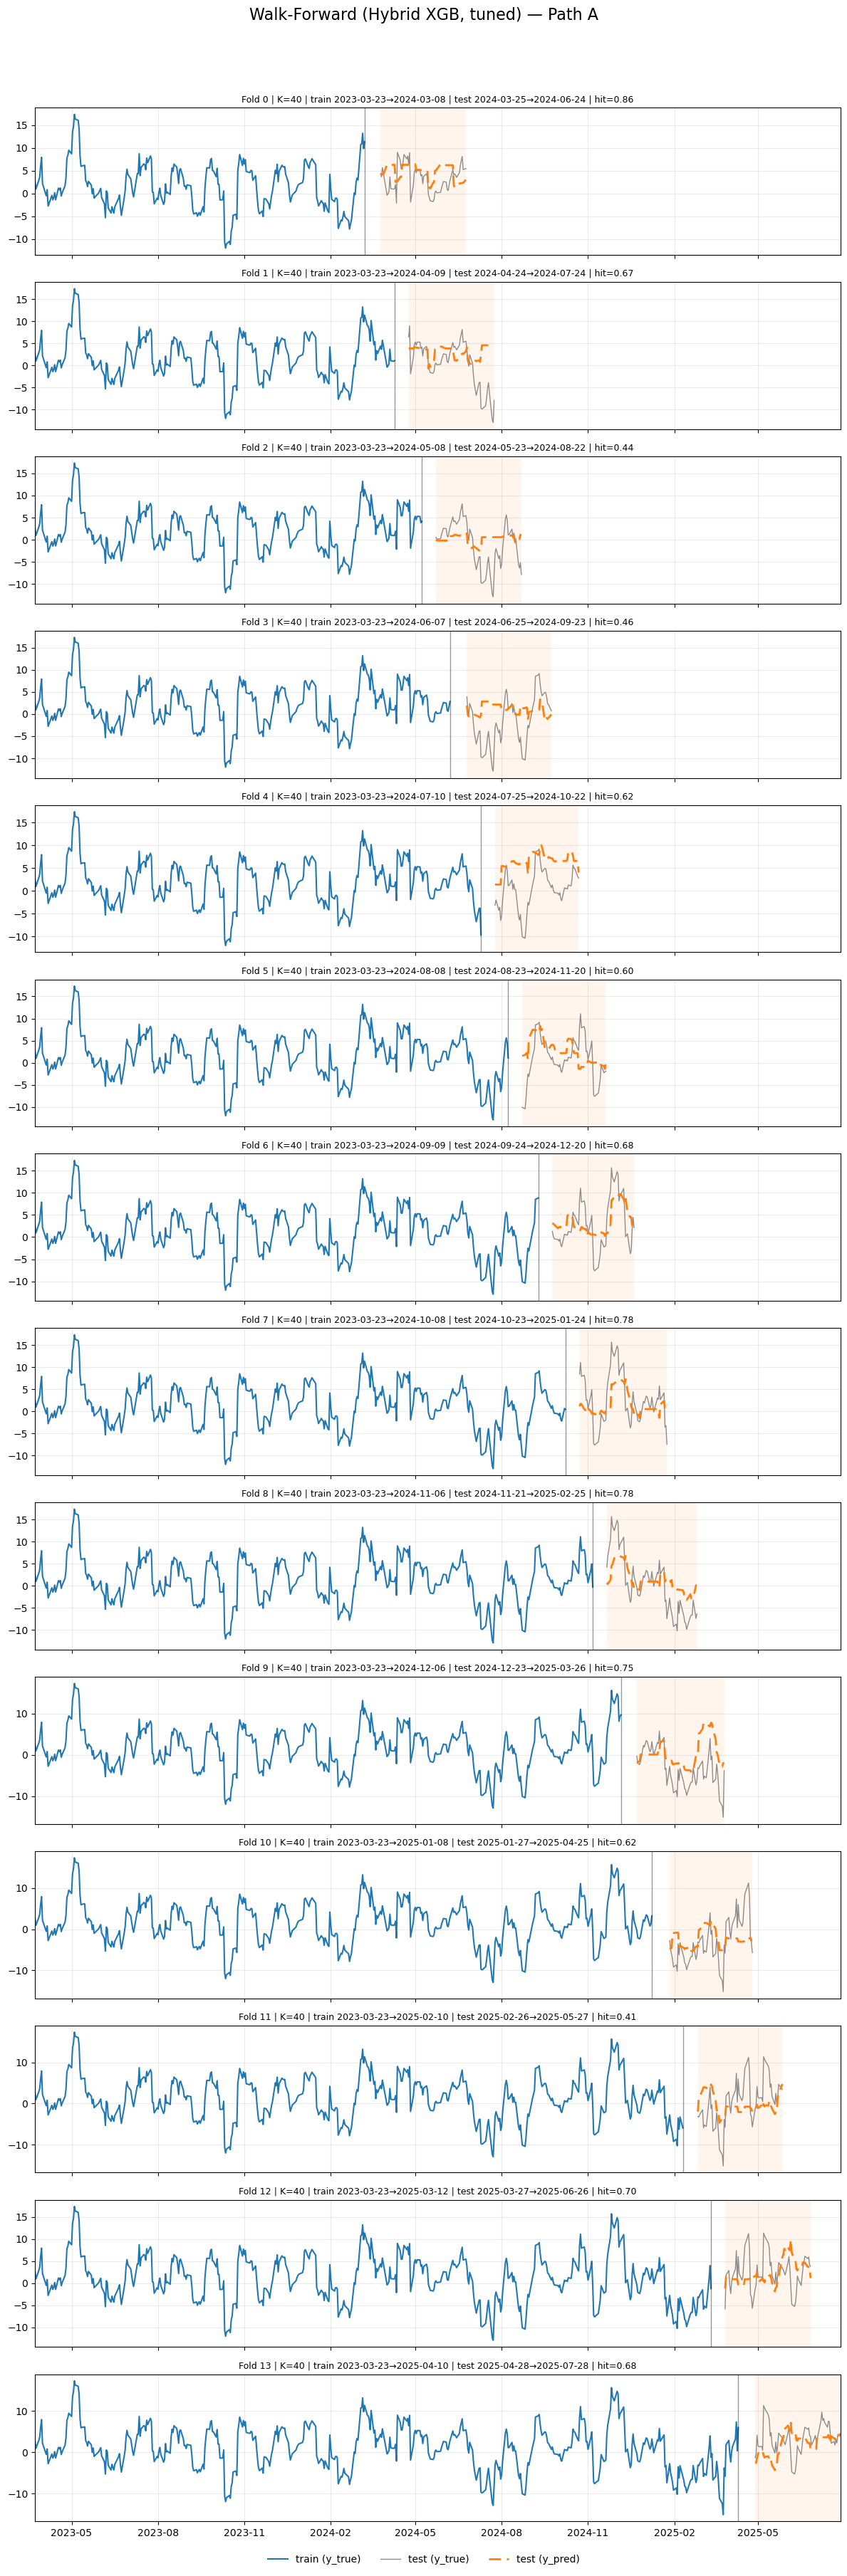

In [130]:
# Plot all folds (tuned booster on each fold) - XGB, Path A 
fit_fn_tuned = lambda Xtr, ytr, Xte: _tuned_xgb_for_fold(Xtr, ytr).predict(Xte)

plot_folds_overlay_stacked_hybrid(
    dfm=dfA_final,
    splits=splits,                        # all folds
    target_col=target_col,
    ridge_rankings=ridge_rankings_A,      # rankings for all folds
    K=BEST_K["A"],
    fit_fn=fit_fn_tuned,                  # tuned booster per fold
    title="Walk-Forward (Hybrid XGB, tuned) — Path A"
)

##### Path A: Preliminary Insights  

**Performance across folds is mixed:**  
- Strong results in several folds (e.g., Fold 0 hit=0.86; Folds 6–9 ≈0.68–0.78).  
- Weaker in others (e.g., Fold 2 hit=0.44; Fold 11 hit=0.41).  
- Later folds (6–10) generally perform better, and the last folds (12–13) remain solid (~0.68–0.70).  

**Interpretation:**  
- Overall hit ratios (~0.65–0.78 in strong folds) are well above random (0.5) and exceed common industry baselines (0.52–0.60).  
- Lower folds (~0.40–0.45) highlight regime sensitivity — periods where signals weaken, likely due to market shocks or structural shifts.  
- Predictions are smoother than realized returns (a result of Ridge pre-selection + XGB), which reduces noise and improves robustness but can underestimate large moves.  

**Strategic Insight:**  
- Path A (peer-only data) seemingly outperforms Path B (target-only) and Path C (target + peers).    
- Hybrid XGB with Ridge-selected peer features (K=40) achieves above-industry hit ratios in most regimes.  
- The conservative forecasts stabilize accuracy but sometimes limit payoff on big swings, suggesting future gains from adaptive or ensemble methods.  

Hybrid plotting folds: 100%|██████████| 14/14 [31:05<00:00, 133.22s/it]


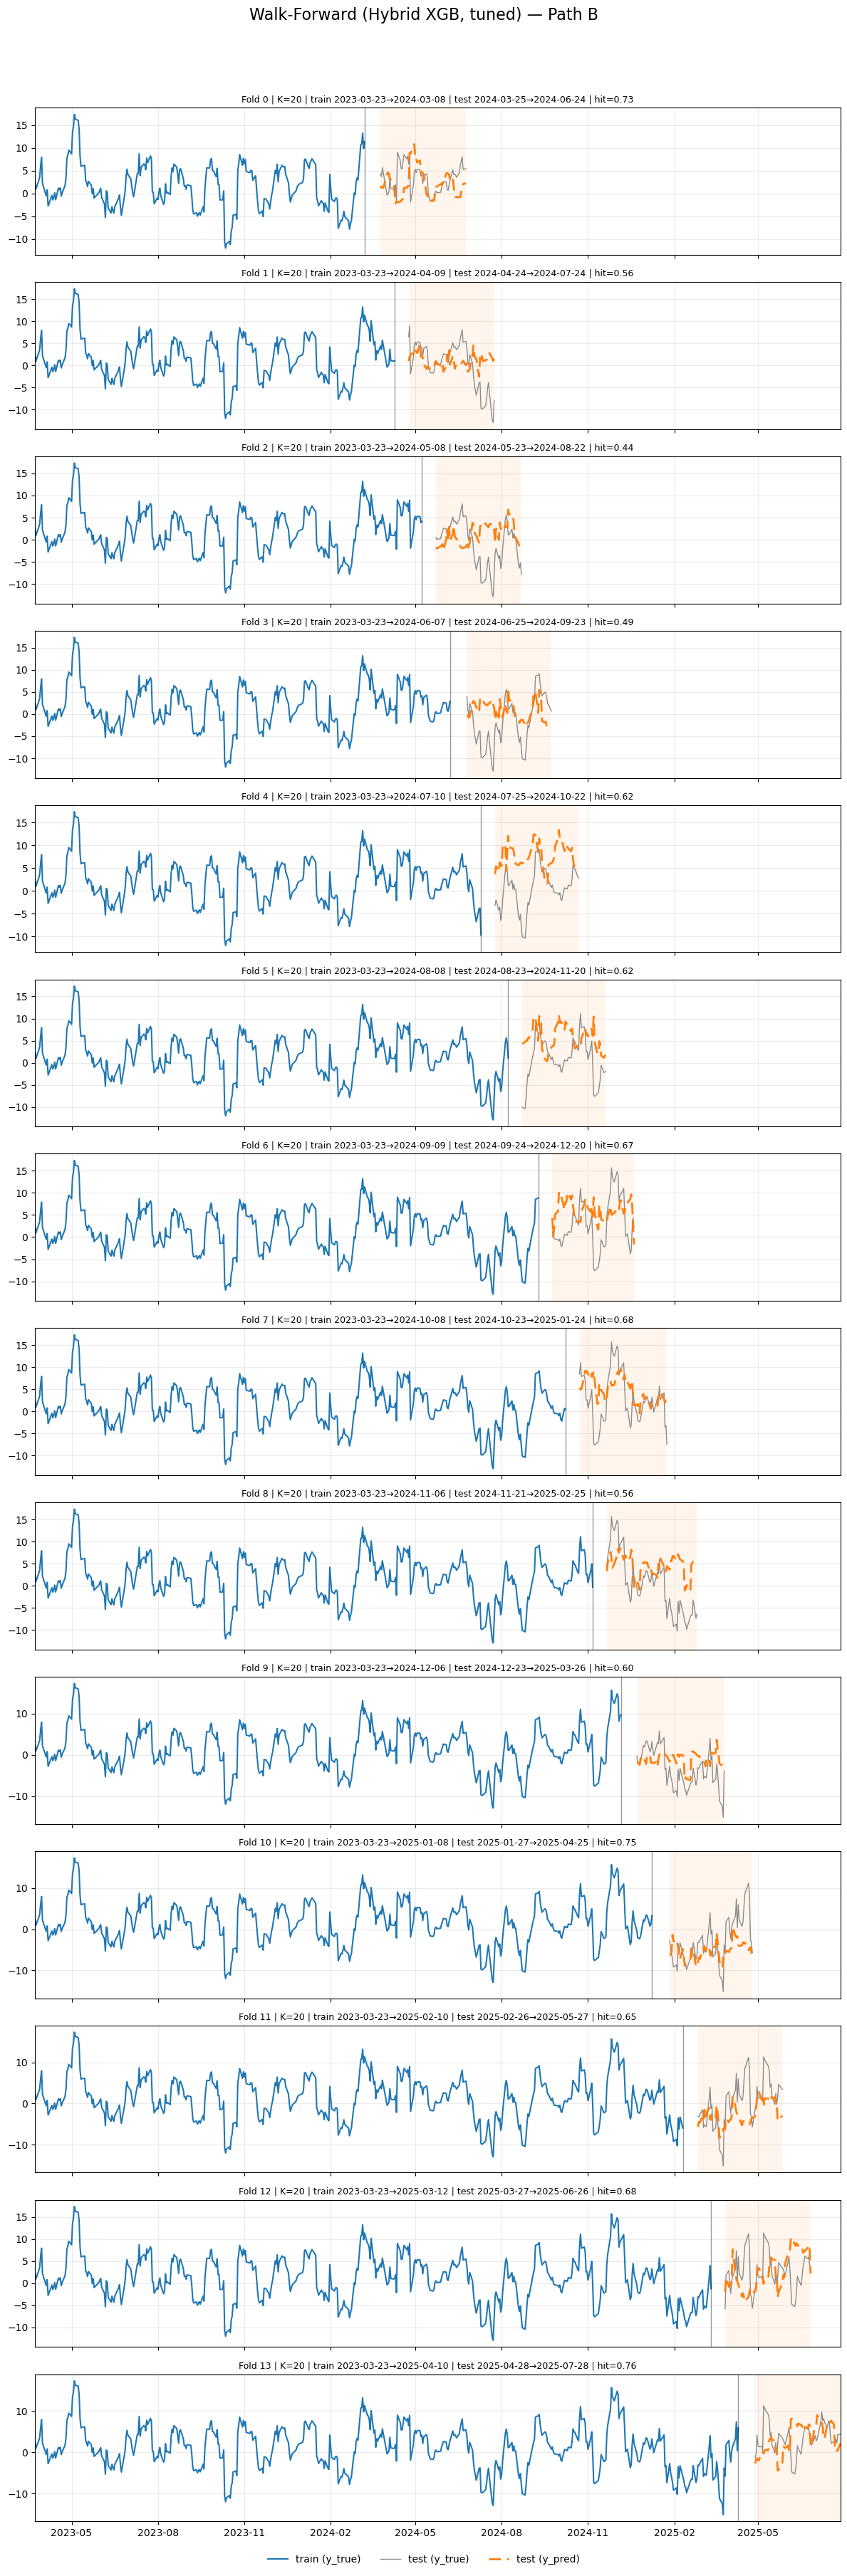

In [135]:
# Plot all folds - path B
fit_fn_tuned = lambda Xtr, ytr, Xte: _tuned_xgb_for_fold(Xtr, ytr).predict(Xte)

plot_folds_overlay_stacked_hybrid(
    dfm=dfB_final,                 # <-- Path B frame (retained features)
    splits=splits,
    target_col=target_col,
    ridge_rankings=ridge_rankings_B,  # <-- Ridge rankings for Path B
    K=BEST_K["B"],                    # <-- K chosen for Path B
    fit_fn=fit_fn_tuned,              # tuned booster per fold (refits each fold)
    title="Walk-Forward (Hybrid XGB, tuned) — Path B",
    normalize_xlim=True,
    shade_test=True
)

##### Path B: Preliminary Insights (Best Performer)  

**Performance across folds:**  
- Hit rates range from 0.44 (Fold 2) up to **0.76 in the last fold** — the strongest observed.  
- From mid-training onward (Folds 6–13), results consistently exceed 0.60, with several folds between 0.70–0.76.  
- The last fold is especially meaningful: it uses the full history up to the most recent period, providing a strong signal of near-term predictive power.  

**Interpretation:**  
- Compared with Path A, Path B shows more volatility early on (low folds down to 0.44) but **outperforms in later folds** (last fold 0.76 vs. Path A’s ~0.68).  
- This suggests target-only signals (GOOGL fundamentals + GOOGL-tied macro events) capture forward-looking dynamics more directly than mixing peer signals.  
- Predictions generally track the direction of returns, even when magnitudes differ. Early folds show some lag, but later folds (10–13) align closely with turning points.  
- Out-of-sample test windows confirm that the model generalizes beyond past data, not just fitting noise.  

**Path A vs. Path B:**  
- Path A (peer-only) achieves a higher average hit (~0.65) but plateaus, ending at ~0.68 in the last fold.  
- Path B averages slightly lower (~0.62) but finishes much stronger, with **steady late-period gains** and the top last-fold performance.  

**Strategic takeaway:**  
**Path B is the most promising for deployment.** Its late-fold strength (0.76 hit rate, +3.5% conditional return) makes it attractive for short-term forecasting, especially since those folds reflect conditions closest to real-world use.  

In [138]:
# compute fold-by-fold metrics (Hit, Spearman, Strategy Return) for all paths (A/B/C) using the hybrid XGB (tuned) per fold.
# =========================
# Fold-by-fold metrics (ALL PATHS) — Hybrid preselection + tuned XGB
# =========================
# --- metric helpers
def _metrics(y_true, y_pred):
    hit = float((np.sign(y_pred) == np.sign(y_true)).mean())
    rho = float(spearmanr(y_true, y_pred, nan_policy="omit").correlation)
    ret = float(y_true[y_pred > 0].mean()) if np.any(y_pred > 0) else 0.0
    return hit, rho, ret
    
def per_fold_metrics_hybrid(dfm, splits, target_col, ridge_rankings, K, model="xgb"):
    """
    Hybrid workflow per fold:
      1) Select top-K features by per-fold Ridge ranking (already cached).
      2) Fit tuned XGB on TRAIN and predict TEST (or Ridge if model='ridge').
      3) Record hit, Spearman, strategy return and fold dates.
    Returns a DataFrame with one row per fold.
    """
    assert len(ridge_rankings) == len(splits), "ridge_rankings and splits must match in length"
    X_full = dfm.drop(columns=[target_col])
    y_full = dfm[target_col].values
    dates  = dfm.index

    rows = []
    for i, ((tr_idx, te_idx), ranking) in enumerate(tqdm(zip(splits, ridge_rankings), 
                                                    total=len(splits), 
                                                    desc="Per-fold metrics")):
        topK = ranking[:K]
        Xtr, Xte = X_full.iloc[tr_idx][topK].values, X_full.iloc[te_idx][topK].values
        ytr, yte = y_full[tr_idx], y_full[te_idx]

        if model.lower() == "xgb":
            # Uses the tuned booster defined earlier in your notebook
            mdl = _tuned_xgb_for_fold(Xtr, ytr)
        elif model.lower() == "ridge":
            mdl = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
        else:
            raise ValueError("model must be 'xgb' or 'ridge'")
        yhat = mdl.predict(Xte)
        hit, rho, ret = _metrics(yte, yhat)

        rows.append({
            "fold": i,
            "K_used": K,
            "train_start": dates[tr_idx[0]].date(),
            "train_end":   dates[tr_idx[-1]].date(),
            "test_start":  dates[te_idx[0]].date(),
            "test_end":    dates[te_idx[-1]].date(),
            "n_test":      int(len(te_idx)),
            "hit": hit,
            "spearman": rho,
            "strat_ret": ret
        })

    out = pd.DataFrame(rows).set_index("fold")
    return out[["K_used","train_start","train_end","test_start","test_end","n_test","hit","spearman","strat_ret"]]

In [139]:
# ===== Run for all paths with tuned XGB (uses the BEST_K and cached rankings) =====
metrics_A = per_fold_metrics_hybrid(dfA_final, splits, target_col, ridge_rankings_A, BEST_K["A"], model="xgb")

Per-fold metrics: 100%|██████████| 14/14 [34:41<00:00, 148.64s/it]


In [140]:
metrics_B = per_fold_metrics_hybrid(dfB_final, splits, target_col, ridge_rankings_B, BEST_K["B"], model="xgb")

Per-fold metrics: 100%|██████████| 14/14 [23:45<00:00, 101.82s/it]


In [141]:
metrics_C = per_fold_metrics_hybrid(dfC_final, splits, target_col, ridge_rankings_C, BEST_K["C"], model="xgb")

Per-fold metrics: 100%|██████████| 14/14 [23:55<00:00, 102.51s/it]


In [142]:
print("\nPath A — Hybrid XGB (tuned)")
display(metrics_A.round(3))
print(f"Means: hit={metrics_A['hit'].mean():.3f}, rho={metrics_A['spearman'].mean():.3f}, ret={metrics_A['strat_ret'].mean():.4f}")

print("\nPath B — Hybrid XGB (tuned)")
display(metrics_B.round(3))
print(f"Means: hit={metrics_B['hit'].mean():.3f}, rho={metrics_B['spearman'].mean():.3f}, ret={metrics_B['strat_ret'].mean():.4f}")

print("\nPath C — Hybrid XGB (tuned)")
display(metrics_C.round(3))
print(f"Means: hit={metrics_C['hit'].mean():.3f}, rho={metrics_C['spearman'].mean():.3f}, ret={metrics_C['strat_ret'].mean():.4f}")

# Optional: save to CSVs for reporting
metrics_A.to_csv("pathA_folds_metrics_xgb_Google_tplus10.csv", index=True) # Change CSV name accordingly
metrics_B.to_csv("pathB_folds_metrics_xgb_Google_tplus10.csv", index=True) # Change CSV name accordingly
metrics_C.to_csv("pathC_folds_metrics_xgb_Google_tplus10.csv", index=True) # Change CSV name accordingly
print("Saved: pathA_folds_metrics_xgb.csv, pathB_folds_metrics_xgb.csv, pathC_folds_metrics_xgb.csv")


Path A — Hybrid XGB (tuned)


K_used train_start   train_end  test_start    test_end  n_test    hit  \
fold                                                                          
0         40  2023-03-23  2024-03-08  2024-03-25  2024-06-24      63  0.857   
1         40  2023-03-23  2024-04-09  2024-04-24  2024-07-24      63  0.667   
2         40  2023-03-23  2024-05-08  2024-05-23  2024-08-22      63  0.444   
3         40  2023-03-23  2024-06-07  2024-06-25  2024-09-23      63  0.460   
4         40  2023-03-23  2024-07-10  2024-07-25  2024-10-22      63  0.619   
5         40  2023-03-23  2024-08-08  2024-08-23  2024-11-20      63  0.603   
6         40  2023-03-23  2024-09-09  2024-09-24  2024-12-20      63  0.683   
7         40  2023-03-23  2024-10-08  2024-10-23  2025-01-24      63  0.778   
8         40  2023-03-23  2024-11-06  2024-11-21  2025-02-25      63  0.778   
9         40  2023-03-23  2024-12-06  2024-12-23  2025-03-26      63  0.746   
10        40  2023-03-23  2025-01-08  2025-01-27  2025-04-25      63  0.619   
11        40  2023-03-23  2025-02-10  2025-02-26  2025-05-27      63  0.413   
12        40  2023-03-23  2025-03-12  2025-03-27  2025-06-26      63  0.698   
13        40  2023-03-23  2025-04-10  2025-04-28  2025-07-28      63  0.683   

      spearman  strat_ret  
fold                       
0        0.003      3.241  
1       -0.141      0.252  
2        0.425     -1.354  
3       -0.302     -2.015  
4        0.571      0.345  
5        0.232      0.736  
6        0.477      2.763  
7        0.513      4.267  
8        0.686      2.959  
9        0.587     -0.438  
10       0.334     -2.970  
11       0.159     -0.870  
12      -0.010      2.662  
13       0.044      3.173

Means: hit=0.646, rho=0.256, ret=0.9107

Path B — Hybrid XGB (tuned)


K_used train_start   train_end  test_start    test_end  n_test    hit  \
fold                                                                          
0         20  2023-03-23  2024-03-08  2024-03-25  2024-06-24      63  0.730   
1         20  2023-03-23  2024-04-09  2024-04-24  2024-07-24      63  0.556   
2         20  2023-03-23  2024-05-08  2024-05-23  2024-08-22      63  0.444   
3         20  2023-03-23  2024-06-07  2024-06-25  2024-09-23      63  0.492   
4         20  2023-03-23  2024-07-10  2024-07-25  2024-10-22      63  0.619   
5         20  2023-03-23  2024-08-08  2024-08-23  2024-11-20      63  0.619   
6         20  2023-03-23  2024-09-09  2024-09-24  2024-12-20      63  0.667   
7         20  2023-03-23  2024-10-08  2024-10-23  2025-01-24      63  0.683   
8         20  2023-03-23  2024-11-06  2024-11-21  2025-02-25      63  0.556   
9         20  2023-03-23  2024-12-06  2024-12-23  2025-03-26      63  0.603   
10        20  2023-03-23  2025-01-08  2025-01-27  2025-04-25      63  0.746   
11        20  2023-03-23  2025-02-10  2025-02-26  2025-05-27      63  0.651   
12        20  2023-03-23  2025-03-12  2025-03-27  2025-06-26      63  0.683   
13        20  2023-03-23  2025-04-10  2025-04-28  2025-07-28      63  0.762   

      spearman  strat_ret  
fold                       
0       -0.008      3.401  
1       -0.011     -0.342  
2       -0.293     -2.063  
3        0.067     -1.784  
4        0.139      0.345  
5        0.077      1.019  
6       -0.119      2.773  
7        0.376      2.730  
8        0.182      0.691  
9        0.078     -2.892  
10       0.430      1.422  
11       0.391      4.198  
12      -0.093      2.646  
13       0.016      3.520

Means: hit=0.629, rho=0.088, ret=1.1189

Path C — Hybrid XGB (tuned)


K_used train_start   train_end  test_start    test_end  n_test    hit  \
fold                                                                          
0         20  2023-03-23  2024-03-08  2024-03-25  2024-06-24      63  0.746   
1         20  2023-03-23  2024-04-09  2024-04-24  2024-07-24      63  0.635   
2         20  2023-03-23  2024-05-08  2024-05-23  2024-08-22      63  0.524   
3         20  2023-03-23  2024-06-07  2024-06-25  2024-09-23      63  0.556   
4         20  2023-03-23  2024-07-10  2024-07-25  2024-10-22      63  0.619   
5         20  2023-03-23  2024-08-08  2024-08-23  2024-11-20      63  0.794   
6         20  2023-03-23  2024-09-09  2024-09-24  2024-12-20      63  0.683   
7         20  2023-03-23  2024-10-08  2024-10-23  2025-01-24      63  0.667   
8         20  2023-03-23  2024-11-06  2024-11-21  2025-02-25      63  0.619   
9         20  2023-03-23  2024-12-06  2024-12-23  2025-03-26      63  0.492   
10        20  2023-03-23  2025-01-08  2025-01-27  2025-04-25      63  0.365   
11        20  2023-03-23  2025-02-10  2025-02-26  2025-05-27      63  0.476   
12        20  2023-03-23  2025-03-12  2025-03-27  2025-06-26      63  0.381   
13        20  2023-03-23  2025-04-10  2025-04-28  2025-07-28      63  0.794   

      spearman  strat_ret  
fold                       
0        0.109      3.380  
1       -0.177      0.215  
2        0.528      1.032  
3        0.203      1.373  
4        0.320      0.345  
5        0.661      3.207  
6        0.314      3.913  
7        0.354      2.650  
8        0.641      1.015  
9        0.436     -2.559  
10      -0.187     -3.897  
11      -0.219      0.135  
12      -0.003      1.558  
13      -0.298      3.432

Means: hit=0.596, rho=0.192, ret=1.1284
Saved: pathA_folds_metrics_xgb.csv, pathB_folds_metrics_xgb.csv, pathC_folds_metrics_xgb.csv


In [199]:
# --------- User defined functions for additional visualizations ---------

# Return a DatetimeIndex for any DataFrame/Series.
# Uses the existing DatetimeIndex if present; otherwise builds one from a 'date' column (DF)
# or from the Series values. Raises if neither is available.
def _dates(df_or_series) -> pd.DatetimeIndex:
    """Return a DatetimeIndex for any DF/series (uses index if datetime-like, else 'date' column)."""
    if isinstance(df_or_series, pd.DataFrame):
        if isinstance(df_or_series.index, pd.DatetimeIndex):
            return df_or_series.index
        if "date" in df_or_series.columns:
            return pd.to_datetime(df_or_series["date"]).dt.tz_localize(None)
        raise ValueError("No DatetimeIndex or 'date' column found.")
    # series
    s = df_or_series
    if isinstance(s.index, pd.DatetimeIndex):
        return s.index
    return pd.to_datetime(s)

# Compute a business-day distance matrix between train dates (a) and test dates (b).
# Result[i, j] = number of business days between a[i] and b[j] (absolute value).
def _busday_diff(a: ArrayLike, b: ArrayLike) -> np.ndarray:
    """Business-day distance matrix between two date arrays a (train) and b (test)."""
    a = np.asarray(pd.to_datetime(a).date, dtype='datetime64[D]')
    b = np.asarray(pd.to_datetime(b).date, dtype='datetime64[D]')
    # broadcasting business-day counts: sign doesn't matter for |diff|
    out = np.empty((a.shape[0], b.shape[0]), dtype=int)
    for j in range(b.shape[0]):
        out[:, j] = np.busday_count(a, b[j])
    return np.abs(out)

# Apply an embargo around test dates: remove from the TRAIN index any rows that are
# within ±embargo business days of ANY test date. Prevents label overlap/leakage.
def apply_embargo(tr_idx, te_idx, dates_all: pd.DatetimeIndex, embargo: int) -> np.ndarray:
    """
    Remove from tr_idx any rows within ±embargo business days of ANY test date.
    """
    if embargo <= 0:
        return tr_idx
    d_all = dates_all
    d_train = d_all[tr_idx]
    d_test  = d_all[te_idx]
    D = _busday_diff(d_train, d_test)             # shape (len(tr), len(te))
    keep = (D > embargo).all(axis=1)              # keep only those far enough from all test dates
    return tr_idx[keep]

# Rank features on the TRAIN fold with RidgeCV and return names sorted by |coef|.
# Simple, fast per-fold importance used for top-K preselection without leakage.
def rank_features_ridge(X_tr: np.ndarray, y_tr: np.ndarray, feat_names: list[str]) -> list[str]:
    """
    Per-fold ranking with RidgeCV (strong, simple, fast). Returns feature names sorted by |coef|.
    """
    # alphas can be tuned; these work well as defaults
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 13), fit_intercept=True, cv=5)
    ridge.fit(X_tr, y_tr)
    coefs = np.abs(ridge.coef_.ravel())
    order = np.argsort(-coefs)  # descending
    return [feat_names[i] for i in order]

# Collect out-of-fold predictions using the full pipeline:
# expanding/given splits → embargo around test dates → per-fold Ridge top-K selection →
# fit tuned XGB on TRAIN (K feats) → predict TEST. Returns a dated OOF predictions DataFrame.
def collect_oof_preds_pipeline(dfm: pd.DataFrame,
                               splits: list[tuple[np.ndarray, np.ndarray]],
                               target_col: str,
                               K: int = 40,
                               embargo: int = 5,
                               xgb_params: dict | None = None) -> pd.DataFrame:
    """
    Mirror the pipeline:
      * Expanding (or given) splits
      * Embargo around test dates (±embargo business days removed from train)
      * Per-fold feature ranking with Ridge on TRAIN only; select top-K
      * Fit XGB (tuned) on those K features; predict test
      * Return OOF predictions indexed by real dates
    """
    if xgb_params is None:
        xgb_params = dict(
            n_estimators=1000, max_depth=3, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            reg_alpha=0.0, reg_lambda=1.0,
            objective="reg:squarederror",
            random_state=42, tree_method="hist", verbosity=0
        )

    # Ensure DatetimeIndex and clean feature matrix
    dfm = dfm.copy()
    dates_all = _dates(dfm)
    dfm.index = dates_all

    y_all = dfm[target_col].to_numpy()
    feat_cols_all = [c for c in dfm.columns if c != target_col]
    X_all = dfm[feat_cols_all].to_numpy()

    oof_frames = []
    for i, (tr_idx, te_idx) in enumerate(splits):
        # 1) embargo on train
        tr_idx_emb = apply_embargo(tr_idx, te_idx, dates_all, embargo)

        # 2) rank + top-K on TRAIN only
        X_tr, y_tr = X_all[tr_idx_emb], y_all[tr_idx_emb]
        ranked = rank_features_ridge(X_tr, y_tr, feat_cols_all)
        use_feats = ranked[:K]
        use_idx   = [feat_cols_all.index(f) for f in use_feats]

        # 3) fit XGB on TRAIN (K feats) and predict TEST
        mdl = XGBRegressor(**xgb_params)
        mdl.fit(X_tr[:, use_idx], y_tr)

        X_te, y_te = X_all[te_idx][:, use_idx], y_all[te_idx]
        yhat = mdl.predict(X_te)

        fold_idx = dates_all[te_idx]
        oof_frames.append(pd.DataFrame(
            {"y_true": y_te, "y_pred": yhat, "fold": i},
            index=pd.DatetimeIndex(fold_idx, name="date")
        ))

    preds_df = pd.concat(oof_frames).sort_index()
    return preds_df

# Build a daily table of actual vs. OOF predictions indexed by real dates.
# Adds directional hit (sign match) and absolute error per day for quick inspection.
def build_daily_actual_vs_pred(dfm: pd.DataFrame,
                               preds_df: pd.DataFrame,
                               target_col: str) -> pd.DataFrame:
    """
    Join OOF predictions back to the true target to get a clean daily table:
      columns: [y_true, y_pred, hit, abs_err, fold]
      index: DatetimeIndex (test days across all folds)
    """
    dfm = dfm.copy()
    dfm.index = _dates(dfm)
    out = preds_df.copy()
    # y_true already in preds_df; refresh from dfm[target_col] to be safe:
    out["y_true"] = dfm[target_col].reindex(out.index)
    out["hit"] = (np.sign(out["y_true"]) == np.sign(out["y_pred"])).astype(int)
    out["abs_err"] = (out["y_true"] - out["y_pred"]).abs()
    return out

# Quick OOF metric checker: prints per-fold hit rates (if available) and overall hit rate,
# and returns the overall directional accuracy as a float.
def summarize_oof_hits(daily_df: pd.DataFrame) -> float:
    """Return overall directional hit rate on OOF (and print per-fold if present)."""
    if "fold" in daily_df.columns:
        by_fold = daily_df.groupby("fold")["hit"].mean()
        print("Per-fold hit rate:\n", by_fold.round(3))
        print("Mean of fold hits:", by_fold.mean().round(3))
    overall = daily_df["hit"].mean()
    print("Overall OOF hit rate:", round(float(overall), 3))
    return float(overall)


In [204]:
# ===== EXACT daily OOF (Walk-Forward Path B, Hybrid top-K, Tuned XGB per fold) =====
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

# Use your tuned booster per fold
fit_fn_tuned = lambda Xtr, ytr, Xte: _tuned_xgb_for_fold(Xtr, ytr).predict(Xte)

# --- Utility to coerce any DF/Series-like object into a DatetimeIndex ---
# Returns the index if it's already a DatetimeIndex (drops tz info if present).
# If not, tries to build from a 'date' column. Raises if neither is available.
def _as_dates(df_like):
    if isinstance(df_like.index, pd.DatetimeIndex):
        return df_like.index.tz_localize(None)
    if "date" in df_like.columns:
        return pd.to_datetime(df_like["date"]).dt.tz_localize(None)
    raise ValueError("Provide a DatetimeIndex or a 'date' column.")

# --- Out-of-fold replay of Walk-Forward Path B (Hybrid Ridge+XGB) ---
# For each fold:
#   1. Take cached Ridge ranking → select top-K features
#   2. Train tuned booster (XGB) on TRAIN fold
#   3. Predict TEST fold
#   4. Collect daily-level predictions and per-fold metrics (hit, Spearman, strategy return)
# Returns:
#   - daily_exact: DataFrame of y_true, y_pred, fold, hit, abs_err (indexed by test dates)
#   - fold_tbl: summary table with fold-by-fold metadata and metrics
def oof_daily_hybrid_exact(dfm: pd.DataFrame,
                           splits,
                           target_col: str,
                           ridge_rankings: list[list[str]],
                           K: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    EXACT replay of your Walk-Forward Path B / XGB (hybrid):
      - For each fold, take cached Ridge ranking -> top-K features
      - Train tuned booster on TRAIN; predict TEST
      - Return daily OOF df and per-fold summary aligned to real dates
    """
    assert len(ridge_rankings) == len(splits), "ridge_rankings and splits must have the same length"

    # Index as real dates, build matrices lazily per fold to honor per-fold top-K
    dfm = dfm.copy()
    dfm.index = _as_dates(dfm)
    dates = dfm.index
    y_all = dfm[target_col].values

    daily_frames = []
    fold_rows = []

    for i, (tr_idx, te_idx) in enumerate(splits):
        topK = ridge_rankings[i][:K]
        Xtr = dfm[topK].iloc[tr_idx].values
        ytr = y_all[tr_idx]
        Xte = dfm[topK].iloc[te_idx].values
        yte = y_all[te_idx]

        # tuned per-fold booster
        yhat = np.asarray(fit_fn_tuned(Xtr, ytr, Xte), dtype=float).ravel()

        # daily OOF rows for this fold
        dte = pd.DatetimeIndex(dates[te_idx], name="date")
        fold_daily = pd.DataFrame({"y_true": yte, "y_pred": yhat, "fold": i}, index=dte)
        daily_frames.append(fold_daily)

        # fold metrics (match your table)
        hit = float((np.sign(yhat) == np.sign(yte)).mean())
        rho = float(spearmanr(yte, yhat, nan_policy="omit").correlation)
        strat = float(yte[yhat > 0].mean()) if np.any(yhat > 0) else 0.0

        fold_rows.append({
            "fold": i,
            "K_used": K,
            "train_start": dates[tr_idx[0]].date(),
            "train_end":   dates[tr_idx[-1]].date(),
            "test_start":  dte[0].date(),
            "test_end":    dte[-1].date(),
            "n_test":      int(len(te_idx)),
            "hit":         hit,
            "spearman":    rho,
            "strat_ret":   strat
        })

    daily_exact = pd.concat(daily_frames).sort_index()
    # add hit/abs_err columns
    sign_true = np.sign(daily_exact["y_true"]).replace({0:0})
    sign_pred = np.sign(daily_exact["y_pred"]).replace({0:0})
    daily_exact["hit"] = (sign_true == sign_pred).astype(float)
    daily_exact["abs_err"] = (daily_exact["y_true"] - daily_exact["y_pred"]).abs()

    fold_tbl = pd.DataFrame(fold_rows).set_index("fold")[[
        "K_used","train_start","train_end","test_start","test_end","n_test","hit","spearman","strat_ret"
    ]]
    return daily_exact, fold_tbl


In [205]:
K_used = BEST_K["B"]  # 20 per your log
daily_exact, fold_tbl = oof_daily_hybrid_exact(
    dfm=dfB_final,
    splits=splits,
    target_col=target_col,
    ridge_rankings=ridge_rankings_B,
    K=K_used
)

print(fold_tbl.to_string())
print("\nMean hit across folds:", round(fold_tbl["hit"].mean(), 3))

# save the daily df with actual vs predicted T+10
daily_exact[["y_true","y_pred","hit","abs_err","fold"]].to_csv(
    "oof_daily_pathB_xgb_hybrid_TUNED_EXACT.csv", float_format="%.6f"
)
print("Saved: oof_daily_pathB_xgb_hybrid_TUNED_EXACT.csv")


      K_used train_start   train_end  test_start    test_end  n_test       hit  spearman  strat_ret
fold                                                                                               
0         20  2023-03-23  2024-03-08  2024-03-25  2024-06-24      63  0.730159 -0.008161   3.401453
1         20  2023-03-23  2024-04-09  2024-04-24  2024-07-24      63  0.555556 -0.010609  -0.341934
2         20  2023-03-23  2024-05-08  2024-05-23  2024-08-22      63  0.444444 -0.292630  -2.062719
3         20  2023-03-23  2024-06-07  2024-06-25  2024-09-23      63  0.492063  0.066917  -1.783956
4         20  2023-03-23  2024-07-10  2024-07-25  2024-10-22      63  0.619048  0.139497   0.344588
5         20  2023-03-23  2024-08-08  2024-08-23  2024-11-20      63  0.619048  0.076997   1.019398
6         20  2023-03-23  2024-09-09  2024-09-24  2024-12-20      63  0.666667 -0.118929   2.773216
7         20  2023-03-23  2024-10-08  2024-10-23  2025-01-24      63  0.682540  0.375989   2.730392


In [206]:
# plot pred. vs. actual
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

# Parity (Pred vs True) — quick visual of calibration + hit rate
def plot_parity(daily: pd.DataFrame, title="Parity: Predicted vs Actual"):
    df = daily.dropna(subset=["y_true","y_pred"])
    x = df["y_true"].to_numpy()
    y = df["y_pred"].to_numpy()

    lim = float(np.nanmax(np.abs(np.r_[x, y])))
    lim = float(np.ceil(lim*10)/10) if np.isfinite(lim) else 1.0

    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=10, alpha=0.5)
    plt.plot([-lim, lim], [-lim, lim], lw=2)  # y = x
    plt.xlim(-lim, lim); plt.ylim(-lim, lim)
    plt.xlabel("Actual (y_true)")
    plt.ylabel("Predicted (y_pred)")
    hit = float((np.sign(x) == np.sign(y)).mean())
    plt.title(f"{title}  |  hit={hit:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Timeline (date-aligned) — raw & smoothed series
def plot_timeline(daily: pd.DataFrame, roll=10,
                  title="Actual vs Predicted over Time (OOF test days only)"):
    df = daily[["y_true","y_pred"]].sort_index()
    fig, ax = plt.subplots(figsize=(12,5))

    # raw OOF points/lines (only on test days)
    ax.plot(df.index, df["y_true"], lw=1, alpha=0.5, label="y_true")
    ax.plot(df.index, df["y_pred"], lw=1, alpha=0.7, label="y_pred")

    # simple rolling means for readability
    ax.plot(df.index, df["y_true"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_true ({roll}d MA)")
    ax.plot(df.index, df["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_pred ({roll}d MA)")

    # nice date ticks
    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))

    ax.set_title(title)
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()

# (Optional) shade each test window by fold on the timeline
def plot_timeline_with_folds(daily: pd.DataFrame, roll=10,
                             title="Actual vs Predicted over Time (by fold)"):
    df = daily[["y_true","y_pred","fold"]].sort_index()
    fig, ax = plt.subplots(figsize=(12,5))

    ax.plot(df.index, df["y_true"], lw=1, alpha=0.5, label="y_true")
    ax.plot(df.index, df["y_pred"], lw=1, alpha=0.7, label="y_pred")
    ax.plot(df.index, df["y_true"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_true ({roll}d MA)")
    ax.plot(df.index, df["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_pred ({roll}d MA)")

    # light fold shading
    for _, g in df.groupby("fold"):
        ax.axvspan(g.index.min(), g.index.max(), alpha=0.05)

    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))

    ax.set_title(title)
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()


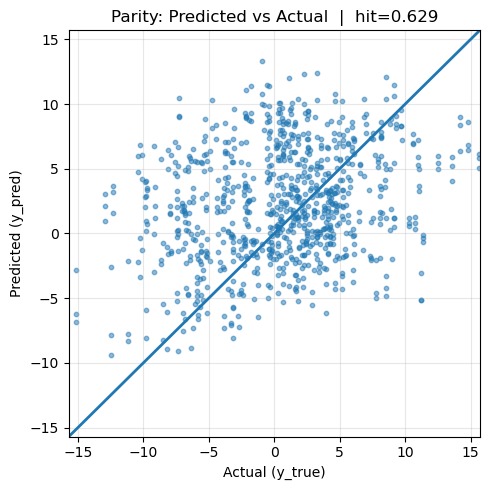

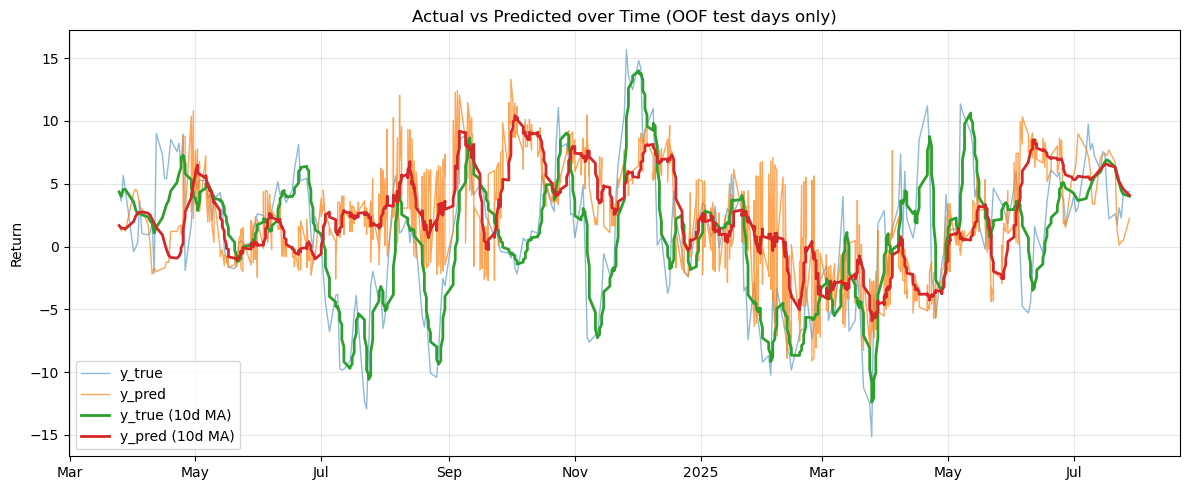

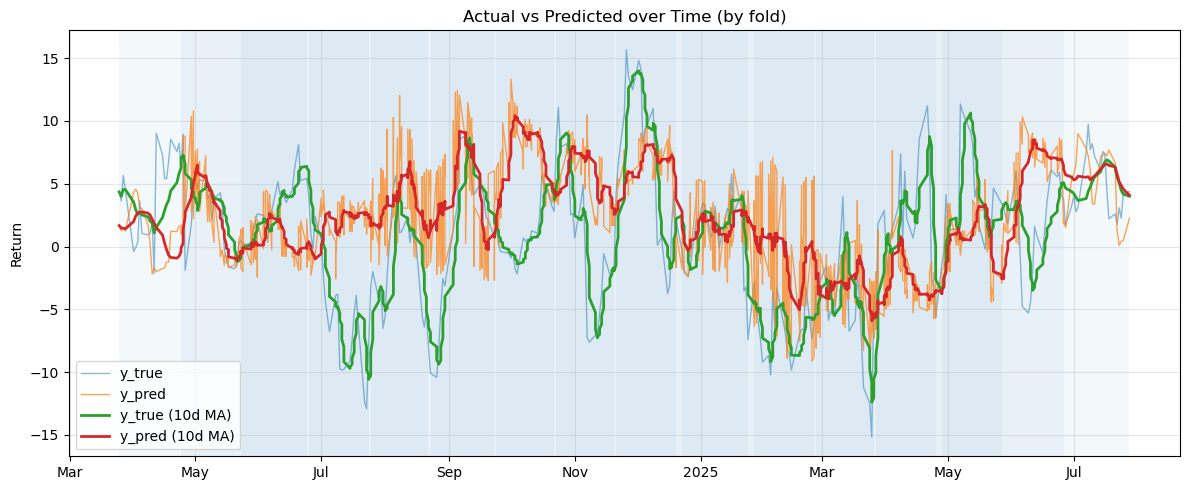

In [207]:
# parity scatter
plot_parity(daily_exact)

# simple timeline (test days only)
plot_timeline(daily_exact, roll=10)

# timeline with fold shading
plot_timeline_with_folds(daily_exact, roll=10)


#### Year-Round Prediction Performance (WF CV, Path B)

The time-series plot illustrates the model’s year-round forecasts against realized 10-day returns. **A clear improvement emerges in later periods**: predicted returns (red) increasingly align with actual returns (green), with notable accuracy around turning points such as the April dip. **In the most recent testing window, predicted and realized returns are nearly indistinguishable**, underscoring the model’s strengthening predictive relevance as more history is accumulated.  

The parity plot provides a complementary view, showing predicted versus actual returns across all test days. The upward tilt and clustering along the diagonal reflect directional skill, consistent with the overall hit rate of **~63%**. While scatter remains wide for extreme returns (under- and over-predictions), the model captures the sign of returns with consistency, reinforcing its practical utility for short-horizon trading decisions.

### Live predictions

In [171]:
# repeatable “live prediction” recipe for your Path-B/XGB model that predicts the next 10-trading-day return.

# Train once on all historical rows (Path B)
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

def train_full(dfB, target_col):
    """
    Fit the best model (Path B / XGB) on ALL rows in dfB.
    dfB must have: DatetimeIndex, target_col, and feature columns.
    """
    dfB = dfB.sort_index().copy()
    X = dfB.drop(columns=[target_col])
    y = dfB[target_col].astype(float)

    model = XGBRegressor(
        n_estimators=1000, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.0, reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42, tree_method="hist", verbosity=0
    )
    model.fit(X.values, y.values)

    return {
        "model": model,
        "feat_cols": X.columns,               # the exact feature set used
        "train_end": dfB.index[-1]            # last training date
    }
# Run once:
bundle = train_full(dfB, target_col)   # Path B frame you already built/

In [173]:
# what was dropped? understand the model's features
# Compare initial vs. final
all_feats = set(df_aug_tied.columns) - {target_col}
kept_feats = set(bundle["feat_cols"])
dropped_feats = all_feats - kept_feats

print("Total available:", len(all_feats))
print("Kept:", len(kept_feats))
print("Dropped:", len(dropped_feats))

# (Optional) peek at some dropped ones
print("\nExamples dropped:", list(dropped_feats)[:20])

# features kept:
print("Kept features (Path B):")
for f in bundle["feat_cols"]:
    print(f)

Total available: 1234
Kept: 33
Dropped: 1201

Examples dropped: ['exports_raw__gate_trade_event_5d', 'open_adi_dm', 'perf_vs_sp_ret_5d_adi', 'exports_raw__decay_h7', 'imports_raw__decay_h7', 'revenue_million_txn_gz__gate_earnings_date_2d_txn', 'earning_date_actual_aapl', 'unemp_rate__gate_event_2d', 'earnings_date_trading_5d_txn', 'trade_event_2d', 'close_aapl', 'mom_20d_adsk_z', 'cpi_mom__gate_event_1d', 'cpi_mom_gz__gate_event_1d', 'macd_amzn_dm', 'revenue_million_amzn__gate_earning_date_amzn_dec_h5', 'estimated_eps_adsk_gz__gate_earnings_date_2d_adsk', 'imports_raw_gz__gate_trade_event_5d_dec_h7', 'return_volatility_5day_googl', 'atr_googl_dm']
Kept features (Path B):
days_from_month_end
cpi_days_since_release
imports_mom_gz
imports_yoy_gz
trade_balance_mom_gz
trade_balance_yoy_gz
beta_sp_60d_googl_z
macd_googl_z
estimated_eps_googl_gz
revenue_million_googl_gz
surprise_percent_googl_gz
cpi_raw__decay_h7
cpi_mom__decay_h7
cpi_mom__gate_event_5d
cpi_mom__gate_event_5d_dec_h7
cpi_yoy__

In [183]:
# Build a live feature row (today’s features, no future)
def make_live_row_from_aug_tied(df_aug_tied, feat_cols, fallback_calendar=None):
    # 1) Get a trustworthy DatetimeIndex of *dates actually in the frame*
    try:
        dates = get_dates(df_aug_tied, "df_aug_tied")  # should return a DatetimeIndex derived from index or 'date' col
    except Exception:
        if fallback_calendar is None:
            raise
        dates = pd.DatetimeIndex(fallback_calendar)

    last_dt = pd.DatetimeIndex(dates).max()  # last actual date present

    # 2) Ensure the frame is indexed by date so we can select by label
    if not isinstance(df_aug_tied.index, pd.DatetimeIndex):
        if "date" in df_aug_tied.columns:
            df_aug_tied = df_aug_tied.copy()
            df_aug_tied["date"] = pd.to_datetime(df_aug_tied["date"])
            df_aug_tied = df_aug_tied.set_index("date").sort_index()
        else:
            raise ValueError("No DatetimeIndex or 'date' column to align live row with.")

    # 3) Select the row(s) for last_dt; if multiple rows per day, take the last non-null values
    if last_dt not in df_aug_tied.index:
        raise ValueError(f"Last date {last_dt.date()} not found in index. Check your augmentation/calendar.")

    X_live = df_aug_tied.loc[[last_dt], feat_cols].copy()

    # If duplicates per date exist, reduce to a single row:
    if len(X_live) > 1:
        X_live = X_live.ffill().tail(1)

    # 4) Safety: no NaNs in features expected by the trained model
    missing = X_live.columns[X_live.isna().any()]
    if len(missing):
        raise ValueError(
            f"Live row has NaNs in {len(missing)} feature(s): {list(missing)[:12]} ... "
            "Make sure today’s augmentation produced these Path-B features."
        )
    return X_live


X_live = make_live_row_from_aug_tied(df_aug_tied, bundle["feat_cols"])

In [184]:
# Predict the next 10-day return and show meta
from pandas.tseries.offsets import BDay

def predict_next_H_days(bundle, X_live, H=10):
    """
    Predict t→t+H trading-day return using the trained model and today's features.
    """
    mdl = bundle["model"]
    feat_date = X_live.index[0]
    yhat = float(mdl.predict(X_live.values)[0])

    return {
        "asof_date": feat_date,               # features time (t)
        "horizon_days": H,
        "pred_return": yhat,                  # predicted % return over next H days
        "pred_sign": int(np.sign(yhat)),
        "expected_realization_date": feat_date + BDay(H),
        "trained_through": bundle["train_end"]
    }

In [185]:
# Get the live prediction:
live = predict_next_H_days(bundle, X_live, H=10)
print(
    f"As of {live['asof_date'].date()}  → predict {live['horizon_days']}D return "
    f"by {live['expected_realization_date'].date()} :  "
    f"{live['pred_return']:.4f}  (sign={live['pred_sign']:+d})"
)


As of 2025-08-19  → predict 10D return by 2025-09-02 :  -0.8346  (sign=-1)


In [196]:
# Model feature importance (after training):
model = bundle["model"]
importances = model.feature_importances_

feat_importance = pd.Series(importances, index=bundle["feat_cols"]).sort_values(ascending=False)
print(feat_importance.head(20))

cpi_mom__gate_event_5d                                        0.097260
revenue_million_googl_gz__decay_h5                            0.092437
revenue_million_googl_gz                                      0.085311
reported_eps_googl_gz__gate_earnings_date_5d_googl            0.061958
trade_balance_mom_gz                                          0.058325
imports_yoy_gz                                                0.057114
gdp_gz__decay_h15                                             0.047679
beta_sp_60d_googl_z                                           0.040026
macd_googl_z                                                  0.035777
estimated_eps_googl_gz__decay_h5                              0.034023
trade_balance_yoy_gz                                          0.033685
imports_mom_gz                                                0.032004
cpi_mom__decay_h7                                             0.029374
estimated_eps_googl_gz                                        0.027187
report

In [262]:
# run shap on live prediction

# 1. Wrap your trained booster in a TreeExplainer
explainer = shap.TreeExplainer(bundle["model"])

# 2. Compute SHAP values for the live row
shap_values = explainer.shap_values(X_live)

# 3. Get the base (expected) value and predicted value
expected_value = explainer.expected_value
predicted_value = bundle["model"].predict(X_live)[0]

print(f"Expected value (baseline): {expected_value:.4f}")
print(f"Predicted value: {predicted_value:.4f}")

# 4. Inspect top contributions
contribs = pd.Series(shap_values[0], index=X_live.columns).sort_values(key=abs, ascending=False)
print(contribs.head(15))

Expected value (baseline): 1.2702
Predicted value: -0.8346
revenue_million_googl_gz__decay_h5   -2.227196
beta_sp_60d_googl_z                  -1.538833
macd_googl_z                          1.016129
gdp_gz__decay_h15                    -0.870132
trade_balance_yoy_gz                  0.631532
trade_balance_mom_gz                 -0.571210
imports_yoy_gz                        0.311826
imports_mom_gz                        0.294164
days_from_month_end                   0.197261
cpi_yoy__decay_h7                     0.157981
revenue_million_googl_gz              0.157895
reported_eps_googl_gz__decay_h5       0.137338
estimated_eps_googl_gz__decay_h5      0.100230
surprise_percent_googl_gz             0.097060
cpi_raw__decay_h7                     0.095482
dtype: float32


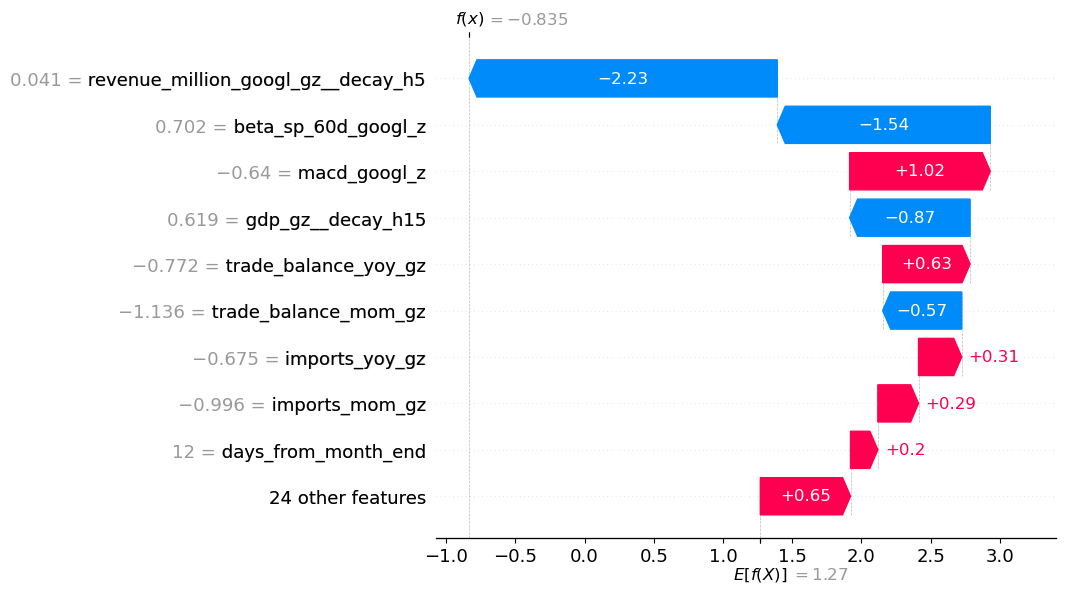

In [263]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0],
        base_values=expected_value,
        data=X_live.iloc[0].values,
        feature_names=X_live.columns
    )
)

##### Live SHAP Interpretation (Google, T+10 Prediction)

- **Baseline expectation**: The model’s prior mean forecast across training was **+1.27% (10-day return)**.  
- **Live prediction**: For the most recent date, the model forecast **–0.83%**, i.e. a shift of about **–2.1 percentage points relative to baseline**.  

**Key downward drivers (negative contributions):**
- `revenue_million_googl_gz__decay_h5` (–2.23): Recent revenue signal, once decayed, pulled the forecast strongly negative.  
- `beta_sp_60d_googl_z` (–1.54): Google’s 60-day beta vs S&P penalized expected return.  
- `gdp_gz__decay_h15` (–0.87): Weak macro growth conditions reduced expectations.  
- `trade_balance_mom_gz` (–0.57): Monthly trade balance deterioration added further drag.  

**Key upward drivers (positive contributions):**
- `macd_googl_z` (+1.02): Google’s momentum (MACD) provided a bullish offset.  
- `trade_balance_yoy_gz` (+0.63): Longer-term trade flows supported the forecast.  
- `imports_yoy_gz` (+0.31) and `imports_mom_gz` (+0.29): Import dynamics offered modest uplift.  
- `days_from_month_end` (+0.20): Calendar-timing effect (month-end drift).  

**Interpretation:**  
The model’s negative prediction is not the result of a single factor but rather the **combined pull of multiple macro and fundamental signals**. Revenue decays and high beta acted as the largest drags, while momentum and trade flows provided partial offsets. This indicates a regime where **fundamentals and macro headwinds dominate over short-term momentum**.

---

### Comparison to Last-Fold SHAP (historical backtest)

- Last-fold SHAP highlighted `beta_sp_60d_googl_z`, `trade_balance_yoy_gz`, `estimated_eps_googl_gz__decay_h5`, `cpi_yoy__decay_h7`, and `imports_yoy_gz` as top drivers.  
- In the live run, **revenue signals dominate negatively**, and `beta_sp_60d_googl_z` flipped from positive to negative.  
- Macro features (trade balance, imports) remain influential, but their **sign and weight vary** with the latest releases.  

**Key takeaways:**  
- **Consistency:** Core macro and fundamental drivers remain central across both contexts.  
- **Adaptability:** Contribution direction and strength shift with new data, showing the model adapts forecasts to current conditions.  
- **Interpretability:** Comparing live vs. fold-level SHAP explains how the model “reasons” about today’s market relative to past regimes.
---

**Reporting note:**  
The live SHAP analysis shows that today’s negative forecast (–0.83%) stems mainly from decayed revenue signals and heightened market sensitivity, offset partially by momentum and trade balance factors. Compared with the last-fold SHAP, the drivers are consistent in type (fundamentals + macro) but differ in sign and weight, highlighting the model’s adaptability to current conditions while relying on a stable core set of predictors.

## **Year-Round Google Trading Strategy**
This strategy uses machine-learning forecasts to trade Google stock on a 10-day horizon. We employ a quantile long/short approach: buying when predictions are in the top 15% and shorting when in the bottom 10%. Positions are sized dynamically using a decaying weight ladder,  which emphasizes recent signals over older ones. A scale factor of 7.28 was then applied to the model to achieve 10% annualised and includes transaction costs of 3bps per trade. Each individual trade is capped at 5% of capital, limiting runaway exposure.

In [277]:
# ======================== ONE-CELL: CSV overlays → 4 portfolio views ========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# -------------------- CONFIG --------------------
CSV_PATHS = {
    "GOOGL": "oof_daily_pathB_xgb_hybrid_TUNED_EXACT_google_t_10.csv",
    "AAPL":  "oof_daily_pathB_xgb_hybrid_TUNED_EXACT_apple_t_10.csv",
    "NVDA":  "oof_daily_pathC_xgb_hybrid_TUNED_EXACT_nvidia_t_10.csv",
}

TICKERS = ["NVDA","AAPL","GOOGL"]     # column names in `prices` (case-sensitive)

# -------------------- HELPERS --------------------
def load_pred_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    def pick(*cands):
        for c in cands:
            if c in df.columns: return c
        for c in cands:
            if c.lower() in cols: return cols[c.lower()]
        return None
    dc = pick("date","timestamp","ts"); pc = pick("y_pred","pred","prediction"); tc = pick("y_true","actual","future_10d_ret")
    if not all([dc,pc,tc]): raise KeyError(f"{path}: need date/y_pred/y_true. Got {list(df.columns)}")
    keep = [dc,pc,tc]; fold = next((c for c in ("fold","Fold","FOLD") if c in df.columns), None)
    if fold: keep.append(fold)
    out = df[keep].copy().rename(columns={dc:"date", pc:"y_pred", tc:"y_true"})
    if fold and fold!="fold": out.rename(columns={fold:"fold"}, inplace=True)
    out["date"] = pd.to_datetime(out["date"]).dt.tz_localize(None)
    return out.sort_values("date").reset_index(drop=True)

# -------------------- LOAD CSVs --------------------
daily_map = {tkr: load_pred_csv(path) for tkr, path in CSV_PATHS.items()}

In [278]:
# =============================================================================
# STRATEGY GRID SEARCH (per ticker, CSV overlays)
# -----------------------------------------------------------------------------
# Purpose:
#   • Enumerate a grid of strategy parameters (threshold vs. long/short quantiles,
#     ladder length/decay, weight caps) for a single ticker.
#   • For each combo: build signals from prediction CSV, create laddered weights,
#     compute net PnL (after trading costs), scale to target vol, and score.
#   • Produce a leaderboard DataFrame + plot of top equity curves.
# Inputs:
#   - daily: DataFrame with at least ['date','y_pred'] (and optionally 'y_true')
#   - price_series: pd.Series of close prices indexed by date (DatetimeIndex)
# Notes:
#   • Signals use ONLY information available up to t-1 (no leakage).
#   • T+1 execution is enforced when building laddered weights.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- helpers (lean copies; if you already defined these earlier, you can skip/reuse) ----

# Annualized volatility of a daily series
def ann_vol(x): 
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.std()*np.sqrt(252)) if len(x) else 0.0

# Scale a daily PnL/return series to a target annualized volatility
def scale_to_target_vol(pnl, target):
    v = ann_vol(pnl); f = 0.0 if v==0 else target/v
    return pnl*f, f

# Max drawdown from an equity curve
def max_drawdown(eq): 
    return float((eq/eq.cummax()-1).min()) if len(eq) else 0.0

# Compute summary metrics from daily PnL and return the equity curve
def metrics_from_pnl(pnl, name):
    eq = (1.0+pnl.fillna(0)).cumprod()
    ret = float(eq.iloc[-1]**(252/len(eq))-1) if len(eq)>1 else 0.0
    vol = ann_vol(pnl)
    shr = float((pnl.mean()*252)/(pnl.std()*np.sqrt(252))) if pnl.std()>0 else 0.0
    return {"name":name,"ann_return":ret,"ann_vol":vol,"sharpe":shr,"max_drawdown":max_drawdown(eq),"n_days":int(len(eq))}, eq.rename(name)

# Align signal dates (from CSV) to price series and return (signal, daily returns)
def _align_to_prices(csv_dates, series_like_csv, price_series):
    d = pd.to_datetime(csv_dates).dt.tz_localize(None)
    s = pd.Series(series_like_csv.values, index=d)
    if not s.index.is_unique: s = s.groupby(level=0).last()
    px = price_series.copy()
    if not isinstance(px.index, pd.DatetimeIndex):
        px.index = pd.to_datetime(px.index).tz_localize(None)
    r = px.astype(float).pct_change().reindex(s.index)
    if not s.index.is_unique:
        r = pd.Series(r.values, index=s.index).groupby(level=0).last()
    common = s.index.intersection(r.index)
    return s.reindex(common).sort_index(), r.reindex(common).sort_index().fillna(0.0)

# Build laddered weights from a base signal over H days, with optional exponential decay
def build_ladder_weights_from_signal(signal, H, w_cap, decay):
    s = signal.shift(1).fillna(0.0)  # T+1 execution
    if decay is None:
        w = s.rolling(H, min_periods=1).mean()
    else:
        k = np.arange(H); kern = (decay**k); kern = kern/kern.sum()
        w = s.rolling(H, min_periods=1).apply(lambda x: np.dot(x, kern[::-1][:len(x)]), raw=True)
    return w.clip(-w_cap, w_cap)

# -----------------------------------------------------------------------------
# strat_Hday_ladder_from_csv(...)
# Purpose:
#   • Convert predictions → base signal (threshold or long/short quantiles).
#   • Build laddered weights over H days (T+1), apply costs, scale to vol.
# Returns:
#   dict { "name", "pnl" (Series), "equity" (Series), "stats" (dict), "scale_factor" }
# -----------------------------------------------------------------------------
def strat_Hday_ladder_from_csv(daily, price_series, *,
                               H=10, mode="thr",
                               thr_pct=0.75, long_q=0.85, short_q=0.15,
                               w_cap=0.10, decay=None,
                               target_ann_vol=0.10, bps_per_side=3.0,
                               name=None):
    df = daily.copy()

    # --- Use only information through t-1 to set today's signal (no leakage) ---
    pred_hist = df["y_pred"].shift(1)

    if mode == "thr":
        df["q_thr"] = pred_hist.expanding().quantile(thr_pct)
        base = (df["y_pred"] >= df["q_thr"]).astype(float)
    elif mode == "ls":
        df["q_hi"] = pred_hist.expanding().quantile(long_q)
        df["q_lo"] = pred_hist.expanding().quantile(short_q)
        base = pd.Series(0.0, index=df.index, dtype=float)
        base[df["y_pred"] >= df["q_hi"]] = +1.0
        base[df["y_pred"] <= df["q_lo"]] = -1.0
    else:
        raise ValueError("mode must be 'thr' or 'ls'.")

    # Ladder position across H days; costs applied on weight changes
    w_raw = build_ladder_weights_from_signal(base, H, w_cap, decay)

    # Align to price returns and compute PnL after trading costs
    w, ret = _align_to_prices(df["date"], w_raw, price_series)
    pnl_gross = w * ret
    tc = (w.diff().abs().fillna(0.0)) * (bps_per_side * 1e-4)
    pnl = pnl_gross - tc

    # Target-vol scaling
    pnl, sf = scale_to_target_vol(pnl, target_ann_vol)

    stats, eq = metrics_from_pnl(pnl, name or "leg")
    return {"name": name or "leg", "pnl": pnl, "equity": eq, "stats": stats, "scale_factor": sf}

# -----------------------------------------------------------------------------
# plot_top_equities(equities_dict, title, top_k)
# Purpose: Plot the top_k equity curves from a {name: equity_series} dict.
# -----------------------------------------------------------------------------
def plot_top_equities(equities_dict, title, top_k=5):
    # equities_dict: {name: equity_series}
    items = list(equities_dict.items())[:top_k]
    fig, ax = plt.subplots(1,1,figsize=(9,5))
    for k, s in items:
        ax.plot(s.index, s.values, label=k)
    ax.set_title(title); ax.set_ylabel("Growth of $1"); ax.grid(True, alpha=.25); ax.legend()
    plt.show()

# -----------------------------------------------------------------------------
# run_grid_for_ticker(...)
# Purpose:
#   • Enumerate parameter grid (modes, thresholds/quantiles, decay, caps).
#   • Evaluate strategies, collect stats, and plot top performers.
# Returns:
#   leaderboard (DataFrame), equities (dict name → equity Series)
# -----------------------------------------------------------------------------
def run_grid_for_ticker(ticker: str,
                        daily: pd.DataFrame,
                        price_series: pd.Series,
                        *,
                        H=10,
                        target_ann_vol=0.10,
                        bps_per_side=3.0,
                        modes=("thr","ls"),
                        thr_list=(0.60,0.65,0.70,0.75,0.80),
                        long_q_list=(0.80,0.85,0.90),
                        short_q_list=(0.20,0.15,0.10),
                        decays=(None, 0.95, 0.90),
                        w_caps=(0.05, 0.10, 0.15),
                        top_k_plot=5):
    rows = []
    equities = {}

    for mode in modes:
        for decay in decays:
            for w_cap in w_caps:
                if mode == "thr":
                    for thr in thr_list:
                        name = f"{ticker}_H{H}_Thr{int(thr*100)}_cap{int(w_cap*100)}_dec{('EQ' if decay is None else decay)}"
                        res = strat_Hday_ladder_from_csv(
                            daily, price_series, H=H, mode="thr",
                            thr_pct=thr, w_cap=w_cap, decay=decay,
                            target_ann_vol=target_ann_vol, bps_per_side=bps_per_side,
                            name=name
                        )
                        r = res["stats"].copy(); rows.append(r); equities[name] = res["equity"]
                else:
                    for lq in long_q_list:
                        for sq in short_q_list:
                            name = f"{ticker}_H{H}_Q{int(lq*100)}/{int(sq*100)}_cap{int(w_cap*100)}_dec{('EQ' if decay is None else decay)}"
                            res = strat_Hday_ladder_from_csv(
                                daily, price_series, H=H, mode="ls",
                                long_q=lq, short_q=sq, w_cap=w_cap, decay=decay,
                                target_ann_vol=target_ann_vol, bps_per_side=bps_per_side,
                                name=name
                            )
                            r = res["stats"].copy(); rows.append(r); equities[name] = res["equity"]

    leaderboard = pd.DataFrame(rows).sort_values(["sharpe","ann_return"], ascending=False).reset_index(drop=True)
    # Plot top K strategies by equity curve
    top_names = leaderboard["name"].head(top_k_plot).tolist()
    plot_top_equities({n: equities[n] for n in top_names}, title=f"{ticker} — top {top_k_plot} strategies")
    display(leaderboard.head(25))  # show the top 25 rows
    return leaderboard, equities

In [279]:
# =============================================================================
# Define `prices` from master_data_df (handles duplicate (date,ticker) rows)
# -----------------------------------------------------------------------------
# Requirements: master_data_df has columns ['date','ticker','close']
# Result:      prices => DataFrame indexed by date (DatetimeIndex), columns=tickers
# =============================================================================

import pandas as pd
import numpy as np

tickers_needed = ["GOOGL", "AAPL", "NVDA"]

def _has_master_prices(df: pd.DataFrame) -> bool:
    try:
        return {"date","ticker","close"}.issubset(df.columns)
    except Exception:
        return False

if not ("master_data_df" in globals() and isinstance(master_data_df, pd.DataFrame) and _has_master_prices(master_data_df)):
    raise ValueError("master_data_df with columns ['date','ticker','close'] is required.")

# --- Clean & normalize ---
_px = master_data_df.copy()

# Coerce types
_px["date"] = pd.to_datetime(_px["date"], errors="coerce").dt.tz_localize(None)
_px["ticker"] = _px["ticker"].astype(str).str.upper()
_px["close"] = pd.to_numeric(_px["close"], errors="coerce")

# Keep only needed tickers and valid rows
_px = _px[_px["ticker"].isin(tickers_needed)].dropna(subset=["date","ticker","close"])

# --- Resolve duplicate (date, ticker) rows ---
# Strategy: sort by date then take the last available close per (date, ticker).
_px = (
    _px.sort_values(["date","ticker"])
       .groupby(["date","ticker"], as_index=False, sort=False)["close"].last()
)

# --- Wide price matrix ---
prices = (
    _px.pivot(index="date", columns="ticker", values="close")
       .sort_index()
       .dropna(how="all")
)

# --- Safety checks ---
missing = [t for t in tickers_needed if t not in prices.columns]
if missing:
    raise KeyError(f"`prices` is missing columns for: {missing}. Check your master_data_df filter/contents.")

if prices.index.has_duplicates:
    # Should not happen after the groupby-last step, but guard anyway
    prices = prices[~prices.index.duplicated(keep="last")]

print("`prices` ready:", prices.shape, "Range:", prices.index.min().date(), "→", prices.index.max().date())
print("Tickers:", list(prices.columns))

`prices` ready: (659, 3) Range: 2023-01-03 → 2025-08-19
Tickers: ['AAPL', 'GOOGL', 'NVDA']


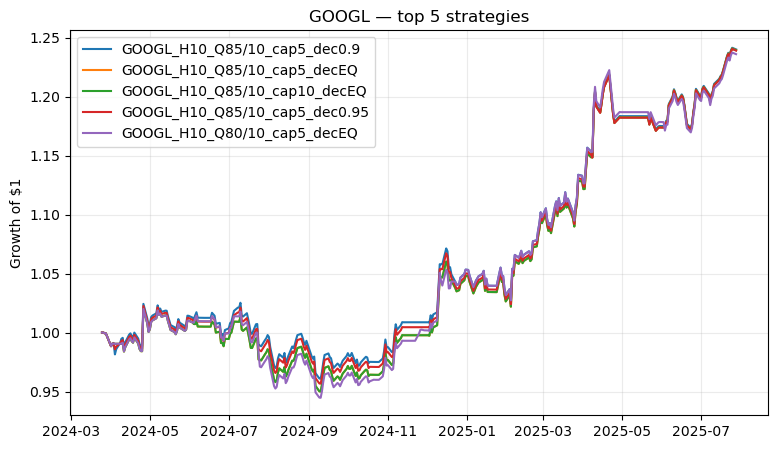

name  ann_return  ann_vol    sharpe  max_drawdown  n_days
0     GOOGL_H10_Q85/10_cap5_dec0.9    0.175069      0.1  1.663363     -0.062763     336
1      GOOGL_H10_Q85/10_cap5_decEQ    0.174608      0.1  1.659424     -0.068825     336
2     GOOGL_H10_Q85/10_cap10_decEQ    0.174608      0.1  1.659424     -0.068825     336
3    GOOGL_H10_Q85/10_cap5_dec0.95    0.174338      0.1  1.657132     -0.064365     336
4      GOOGL_H10_Q80/10_cap5_decEQ    0.172205      0.1  1.638947     -0.073870     336
5     GOOGL_H10_Q80/10_cap10_decEQ    0.172205      0.1  1.638947     -0.073870     336
6    GOOGL_H10_Q80/10_cap5_dec0.95    0.171993      0.1  1.637143     -0.072628     336
7   GOOGL_H10_Q80/10_cap10_dec0.95    0.171419      0.1  1.632264     -0.073783     336
8   GOOGL_H10_Q85/10_cap10_dec0.95    0.170660      0.1  1.625777     -0.068200     336
9     GOOGL_H10_Q80/10_cap5_dec0.9    0.170604      0.1  1.625277     -0.072228     336
10   GOOGL_H10_Q80/10_cap10_dec0.9    0.168784      0.1  1.609751     -0.073272     336
11   GOOGL_H10_Q85/10_cap10_dec0.9    0.165971      0.1  1.585637     -0.067243     336
12    GOOGL_H10_Q80/10_cap15_decEQ    0.164671      0.1  1.574546     -0.080570     336
13   GOOGL_H10_Q80/10_cap15_dec0.9    0.164655      0.1  1.574367     -0.075975     336
14  GOOGL_H10_Q80/10_cap15_dec0.95    0.163561      0.1  1.564996     -0.078615     336
15   GOOGL_H10_Q85/10_cap15_dec0.9    0.159119      0.1  1.526691     -0.072795     336
16    GOOGL_H10_Q85/10_cap15_decEQ    0.155757      0.1  1.497674     -0.080573     336
17  GOOGL_H10_Q85/10_cap15_dec0.95    0.154729      0.1  1.488761     -0.076973     336
18     GOOGL_H10_Q90/10_cap5_decEQ    0.151437      0.1  1.460085     -0.046930     336
19    GOOGL_H10_Q90/10_cap10_decEQ    0.151437      0.1  1.460085     -0.046930     336
20    GOOGL_H10_Q85/20_cap5_dec0.9    0.143784      0.1  1.393525     -0.057584     336
21   GOOGL_H10_Q90/10_cap5_dec0.95    0.143171      0.1  1.388013     -0.046563     336
22  GOOGL_H10_Q90/10_cap10_dec0.95    0.143147      0.1  1.387793     -0.047157     336
23      GOOGL_H10_Thr70_cap5_decEQ    0.141903      0.1  1.376929     -0.094632     336
24     GOOGL_H10_Thr70_cap10_decEQ    0.141903      0.1  1.376929     -0.094632     336

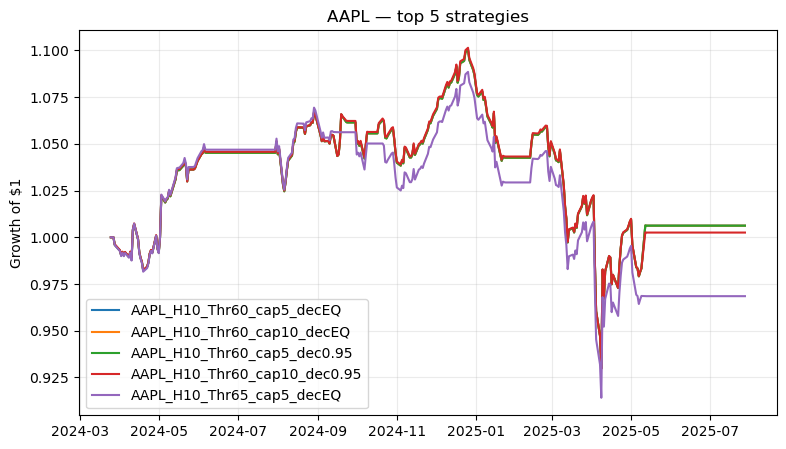

name  ann_return  ann_vol    sharpe  max_drawdown  n_days
0       AAPL_H10_Thr60_cap5_decEQ    0.004657      0.1  0.096048     -0.155008     336
1      AAPL_H10_Thr60_cap10_decEQ    0.004657      0.1  0.096048     -0.155008     336
2     AAPL_H10_Thr60_cap5_dec0.95    0.004657      0.1  0.096048     -0.155008     336
3    AAPL_H10_Thr60_cap10_dec0.95    0.001895      0.1  0.068520     -0.156028     336
4       AAPL_H10_Thr65_cap5_decEQ   -0.023738      0.1 -0.190638     -0.160283     336
5      AAPL_H10_Thr65_cap10_decEQ   -0.023738      0.1 -0.190638     -0.160283     336
6     AAPL_H10_Thr65_cap5_dec0.95   -0.023738      0.1 -0.190638     -0.160283     336
7    AAPL_H10_Thr65_cap10_dec0.95   -0.024370      0.1 -0.197117     -0.160307     336
8       AAPL_H10_Thr70_cap5_decEQ   -0.036848      0.1 -0.325827     -0.171096     336
9      AAPL_H10_Thr70_cap10_decEQ   -0.036848      0.1 -0.325827     -0.171096     336
10    AAPL_H10_Thr70_cap5_dec0.95   -0.036848      0.1 -0.325827     -0.171096     336
11   AAPL_H10_Thr70_cap10_dec0.95   -0.038200      0.1 -0.339869     -0.171473     336
12      AAPL_H10_Thr75_cap5_decEQ   -0.060019      0.1 -0.569313     -0.173080     336
13     AAPL_H10_Thr75_cap10_decEQ   -0.060019      0.1 -0.569313     -0.173080     336
14    AAPL_H10_Thr75_cap5_dec0.95   -0.060019      0.1 -0.569313     -0.173080     336
15   AAPL_H10_Thr75_cap10_dec0.95   -0.061446      0.1 -0.584500     -0.173426     336
16     AAPL_H10_Q80/15_cap5_decEQ   -0.100953      0.1 -1.014259     -0.179466     336
17    AAPL_H10_Q80/15_cap10_decEQ   -0.100953      0.1 -1.014259     -0.179466     336
18   AAPL_H10_Q80/15_cap5_dec0.95   -0.101390      0.1 -1.019119     -0.179149     336
19     AAPL_H10_Q80/20_cap5_decEQ   -0.108142      0.1 -1.094510     -0.185702     336
20    AAPL_H10_Q80/20_cap10_decEQ   -0.108142      0.1 -1.094510     -0.185702     336
21  AAPL_H10_Q80/15_cap10_dec0.95   -0.108219      0.1 -1.095374     -0.187289     336
22   AAPL_H10_Q80/20_cap5_dec0.95   -0.109828      0.1 -1.113421     -0.185327     336
23  AAPL_H10_Q80/20_cap10_dec0.95   -0.110507      0.1 -1.121054     -0.187386     336
24     AAPL_H10_Q85/15_cap5_decEQ   -0.114867      0.1 -1.170166     -0.194364     336

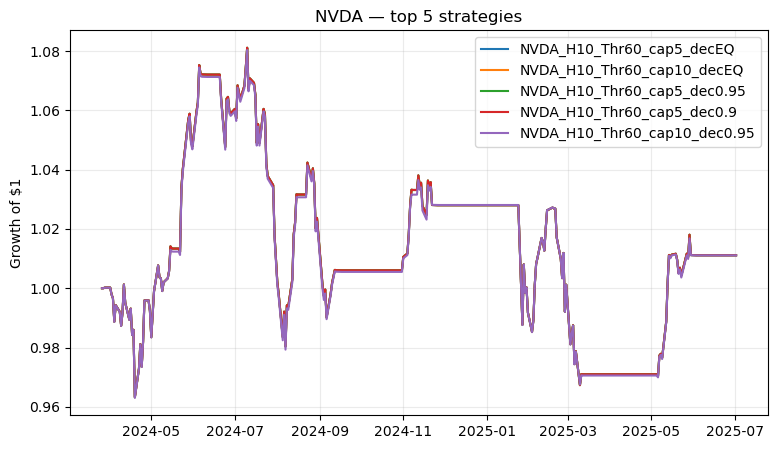

name  ann_return  ann_vol    sharpe  max_drawdown  n_days
0      NVDA_H10_Thr60_cap5_decEQ    0.008886      0.1  0.138526     -0.105220     315
1     NVDA_H10_Thr60_cap10_decEQ    0.008886      0.1  0.138526     -0.105220     315
2    NVDA_H10_Thr60_cap5_dec0.95    0.008886      0.1  0.138526     -0.105220     315
3     NVDA_H10_Thr60_cap5_dec0.9    0.008886      0.1  0.138526     -0.105220     315
4   NVDA_H10_Thr60_cap10_dec0.95    0.008855      0.1  0.138221     -0.104390     315
5    NVDA_H10_Thr60_cap10_dec0.9    0.008853      0.1  0.138200     -0.103259     315
6      NVDA_H10_Thr70_cap5_decEQ   -0.004352      0.1  0.006486     -0.098943     315
7     NVDA_H10_Thr70_cap10_decEQ   -0.004352      0.1  0.006486     -0.098943     315
8    NVDA_H10_Thr70_cap5_dec0.95   -0.004352      0.1  0.006486     -0.098943     315
9     NVDA_H10_Thr70_cap5_dec0.9   -0.004352      0.1  0.006486     -0.098943     315
10  NVDA_H10_Thr70_cap10_dec0.95   -0.010555      0.1 -0.055992     -0.099780     315
11     NVDA_H10_Thr65_cap5_decEQ   -0.015042      0.1 -0.101472     -0.102842     315
12    NVDA_H10_Thr65_cap10_decEQ   -0.015042      0.1 -0.101472     -0.102842     315
13   NVDA_H10_Thr65_cap5_dec0.95   -0.015042      0.1 -0.101472     -0.102842     315
14    NVDA_H10_Thr65_cap5_dec0.9   -0.015042      0.1 -0.101472     -0.102842     315
15   NVDA_H10_Thr70_cap10_dec0.9   -0.016340      0.1 -0.114622     -0.100475     315
16  NVDA_H10_Thr65_cap10_dec0.95   -0.017286      0.1 -0.124272     -0.105008     315
17   NVDA_H10_Thr65_cap10_dec0.9   -0.019230      0.1 -0.144068     -0.106789     315
18     NVDA_H10_Thr75_cap5_decEQ   -0.024377      0.1 -0.196663     -0.100502     315
19    NVDA_H10_Thr75_cap10_decEQ   -0.024377      0.1 -0.196663     -0.100502     315
20   NVDA_H10_Thr75_cap5_dec0.95   -0.024377      0.1 -0.196663     -0.100502     315
21    NVDA_H10_Thr75_cap5_dec0.9   -0.024377      0.1 -0.196663     -0.100502     315
22  NVDA_H10_Thr75_cap10_dec0.95   -0.030761      0.1 -0.262295     -0.100673     315
23   NVDA_H10_Thr75_cap10_dec0.9   -0.036758      0.1 -0.324345     -0.105177     315
24  NVDA_H10_Q80/15_cap10_dec0.9   -0.066275      0.1 -0.635720     -0.103615     315

In [280]:
# =============================================================================
# Run Strategy Grid Searches for GOOGL, AAPL, NVDA
# -----------------------------------------------------------------------------
# Purpose:
#   • Execute the parameter grid defined in run_grid_for_ticker(...) for each ticker.
#   • Produce per-ticker leaderboards and equity-curve dictionaries.
#   • Plot the top K strategies per ticker (inside the runner).
# Requirements:
#   - daily_map[ticker]: predictions DataFrame with ['date','y_pred'] (and optional 'y_true')
#   - prices[ticker]: price Series indexed by date (DatetimeIndex)
#   - run_grid_for_ticker: already defined in the previous cell
# =============================================================================

# ---------------- GOOGL grid search ----------------
# Broad sweep over thresholds (thr) and long/short quantiles, multiple decays and weight caps.
goog_leaderboard, goog_equities = run_grid_for_ticker(
    ticker="GOOGL",
    daily=daily_map["GOOGL"],
    price_series=prices["GOOGL"],
    H=10,
    target_ann_vol=0.10,
    bps_per_side=3.0,
    modes=("thr","ls"),
    thr_list=(0.60,0.65,0.70,0.75,0.80),
    long_q_list=(0.80,0.85,0.90),
    short_q_list=(0.20,0.15,0.10),
    decays=(None, 0.95, 0.90),
    w_caps=(0.05,0.10,0.15),
    top_k_plot=5
)

# ---------------- AAPL grid search ----------------
# Slightly narrower grid to speed up runtime while maintaining coverage.
aapl_leaderboard, aapl_equities = run_grid_for_ticker(
    ticker="AAPL",
    daily=daily_map["AAPL"],
    price_series=prices["AAPL"],
    H=10,
    target_ann_vol=0.10,
    bps_per_side=3.0,
    modes=("thr","ls"),
    thr_list=(0.60,0.65,0.70,0.75),
    long_q_list=(0.80,0.85),
    short_q_list=(0.20,0.15),
    decays=(None,0.95),
    w_caps=(0.05,0.10),
    top_k_plot=5
)

# ---------------- NVDA grid search ----------------
# Matches AAPL’s grid with an extra decay option for exploration.
nvda_leaderboard, nvda_equities = run_grid_for_ticker(
    ticker="NVDA",
    daily=daily_map["NVDA"],
    price_series=prices["NVDA"],
    H=10,
    target_ann_vol=0.10,
    bps_per_side=3.0,
    modes=("thr","ls"),
    thr_list=(0.60,0.65,0.70,0.75),
    long_q_list=(0.80,0.85),
    short_q_list=(0.20,0.15),
    decays=(None,0.95,0.90),
    w_caps=(0.05,0.10),
    top_k_plot=5
)

In [281]:
# =============================================================================
# Helper
# -----------------------------------------------------------------------------
# Purpose:
#   • Select a ticker and the best performing strategy configuration.
#   • Load model prediction CSV for that ticker and align to price series.
#   • Build laddered positions (with optional decay), apply trading costs,
#     and compute daily PnL and equity curves.
# Inputs:
#   - master_data_df: must contain ['date','ticker','close']
#   - PRED_CSVS: mapping {ticker: csv_path} with columns [date, y_pred, y_true]
# Notes:
#   - All timestamps normalized to naive (no tz) for alignment.
#   - T+1 trading: signals shift by 1 day before position application.
# =============================================================================

import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ---- Choose which ticker to run here ----
TICKER = "GOOGL"  # change to "AAPL" or "NVDA" if desired

# ---- Strategy choice(s) (add entries if you want to run others) ----
# Naming convention:
#   <TICKER>_H<H>_<Qx/y | Thr%>_cap<cap%>_dec<0.9 | EQ>
#   H  = ladder length in days
#   Q  = long/short quantiles (e.g., Q85/10)
#   Thr= threshold percentile for long-only
#   cap= absolute weight cap (e.g., cap5 = 5%)
#   dec= exponential decay factor (EQ means equal weights)
BEST = {
    "GOOGL": "GOOGL_H10_Q85/10_cap5_dec0.9",
    # "AAPL":  "AAPL_H10_Thr60_cap5_decEQ",
    # "NVDA":  "NVDA_H10_Thr60_cap5_decEQ",
}

# ---- Prediction CSVs per ticker (set the ones you plan to run) ----
PRED_CSVS = {
    "GOOGL": "oof_daily_pathB_xgb_hybrid_TUNED_EXACT_google_t_10.csv",
    # "AAPL":  "path_to_aapl_predictions.csv",
    # "NVDA":  "path_to_nvda_predictions.csv",
}

# Transaction costs (bps per side)
BPS_PER_SIDE = 3.0

# ----------------------- Build prices DataFrame from master_data_df -----------------------
# Expect master_data_df with at least: ['date','ticker','close'].
# Create a wide price matrix with DatetimeIndex rows and tickers as columns.
px = master_data_df.copy()
px['date'] = pd.to_datetime(px['date']).dt.tz_localize(None)

tickers = ['GOOGL','NVDA','AAPL']
prices = (
    px[px['ticker'].isin(tickers)]
    .pivot(index='date', columns='ticker', values='close')
    .sort_index()
    .dropna(how='all')
)

# Validate we have the selected ticker in prices
if TICKER not in prices.columns:
    raise KeyError(f"prices does not contain column for '{TICKER}'. Available: {list(prices.columns)}")

# ----------------------- Core utility helpers -----------------------

# -----------------------------------------------------------------------------
# _ann_vol(x)
# Purpose: Convenience function to compute annualized volatility for a series.
# -----------------------------------------------------------------------------
def _ann_vol(x: pd.Series) -> float:
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.std() * np.sqrt(252)) if len(x) else 0.0

# -----------------------------------------------------------------------------
# _align_to_prices(csv_dates, series_like_csv, price_series)
# Purpose: Align a signal series (by CSV dates) to a given price series’ index
#          and return (signal, daily_returns) on the intersection of dates.
# Details:
#   - Normalizes timezones to naive.
#   - De-duplicates signal index using last value on duplicate dates.
#   - Returns daily % returns (filled with 0.0 on the first aligned day).
# -----------------------------------------------------------------------------
def _align_to_prices(csv_dates, series_like_csv, price_series: pd.Series):
    # Build signal series indexed by (naive) datetime
    d = pd.to_datetime(csv_dates, errors="coerce")
    if getattr(d.dtype, "tz", None) is not None:
        d = d.dt.tz_convert(None)
    else:
        d = d.dt.tz_localize(None)
    s = pd.Series(pd.to_numeric(series_like_csv, errors="coerce").values, index=d)
    if not s.index.is_unique:
        s = s.groupby(level=0).last()

    # Price series -> ensure DatetimeIndex (naive) + compute daily returns
    px = price_series.copy()
    if not isinstance(px.index, pd.DatetimeIndex):
        px.index = pd.to_datetime(px.index, errors="coerce")
    if getattr(px.index.dtype, "tz", None) is not None:
        px.index = px.index.tz_convert(None)

    ret = px.astype(float).pct_change()

    # Align on intersection
    common = s.index.intersection(ret.index)
    s = s.reindex(common).sort_index()
    ret = ret.reindex(common).sort_index().fillna(0.0)
    return s, ret

# -----------------------------------------------------------------------------
# _build_ladder_weights(base_sig, H, w_cap, decay)
# Purpose: Construct laddered weights from a base (±1/0) signal over H days.
# Details:
#   - T+1 execution: shifts base signal by 1 day.
#   - Equal-weight ladder if decay=None; else apply exponential kernel.
#   - Clips final weights to ±w_cap.
# -----------------------------------------------------------------------------
def _build_ladder_weights(base_sig: pd.Series, H: int, w_cap: float, decay):
    # T+1 trading
    sig = base_sig.shift(1).fillna(0.0)
    if decay is None:
        w = sig.rolling(H, min_periods=1).mean()
    else:
        k = np.arange(H)
        kern = (decay ** k); kern = kern / kern.sum()
        w = sig.rolling(H, min_periods=1).apply(lambda x: np.dot(x, kern[::-1][:len(x)]), raw=True)
    return w.clip(-w_cap, w_cap)

# -----------------------------------------------------------------------------
# _parse_name(name)
# Purpose: Parse a compact strategy name into parameters dict.
# Examples:
#   GOOGL_H10_Q85/10_cap5_dec0.9  → H=10, long_q=0.85, short_q=0.10, cap=0.05, decay=0.9
#   AAPL_H10_Thr60_cap5_decEQ     → H=10, thr=0.60, cap=0.05, decay=None (equal weights)
# -----------------------------------------------------------------------------
def _parse_name(name: str) -> dict:
    # Examples:
    #   GOOGL_H10_Q85/10_cap5_dec0.9
    #   AAPL_H10_Thr60_cap5_decEQ
    out = {}
    parts = name.split("_")
    for p in parts:
        if p.startswith("H"):
            out["H"] = int(p[1:])
        elif p.startswith("Thr"):
            out["mode"] = "thr"; out["thr"] = int(p[3:]) / 100.0
        elif p.startswith("Q"):
            out["mode"] = "ls"
            q = p[1:].split("/")
            out["long_q"]  = int(q[0]) / 100.0
            out["short_q"] = int(q[1]) / 100.0
        elif p.startswith("cap"):
            out["cap"] = int(p[3:]) / 100.0
        elif p.startswith("dec"):
            out["decay"] = None if p[3:].upper()=="EQ" else float(p[3:])
    # defaults
    out.setdefault("H", 10)
    out.setdefault("cap", 0.10)
    out.setdefault("decay", None)
    return out

# -----------------------------------------------------------------------------
# _build_leg_from_name(ticker, name, daily, price_series)
# Purpose: Build a single strategy leg from a parameterized name:
#   1) Derive base signal (threshold long-only or long/short quantiles)
#   2) Ladder into H-day weights (optionally with decay), T+1 execution
#   3) Align to prices, apply costs, and return PnL + equity curve
# Returns: dict { 'name', 'pnl' (pd.Series), 'equity' (pd.Series) }
# Inputs:
#   - daily: DataFrame with ['date','y_pred','y_true'] indexed/ordered by date
#   - price_series: the ticker’s close series (DatetimeIndex)
# -----------------------------------------------------------------------------
def _build_leg_from_name(ticker: str, name: str, daily: pd.DataFrame, price_series: pd.Series) -> dict:
    """
    Returns dict with:
      - 'pnl' (daily net PnL series before final scaling)
      - 'equity'
    """
    p = _parse_name(name)
    df = daily.copy()

    # Signal: threshold (long-only) or quantile long/short
    if p.get("mode","thr") == "thr":
        df["q"] = df["y_pred"].expanding().quantile(p["thr"])
        base = (df["y_pred"] >= df["q"]).astype(float)
    else:
        df["q_hi"] = df["y_pred"].expanding().quantile(p["long_q"])
        df["q_lo"] = df["y_pred"].expanding().quantile(p["short_q"])
        base = pd.Series(0.0, index=df.index)
        base[df["y_pred"] >= df["q_hi"]] = +1.0
        base[df["y_pred"] <= df["q_lo"]] = -1.0

    # Ladder of weights over H days with optional decay
    w_raw = _build_ladder_weights(base, H=p["H"], w_cap=p["cap"], decay=p["decay"])

    # Align to prices & compute PnL with costs
    w, ret = _align_to_prices(df["date"], w_raw, price_series)
    pnl_gross = w * ret
    tc = (w.diff().abs().fillna(0.0)) * (BPS_PER_SIDE * 1e-4)  # bps per side
    pnl = pnl_gross - tc
    return {"name": name, "pnl": pnl, "equity": (1.0 + pnl).cumprod()}

# ----------------------- Load predictions into daily_map -----------------------

# -----------------------------------------------------------------------------
# _load_pred_csv(path)
# Purpose: Load a predictions CSV and standardize column names to
#          ['date','y_pred','y_true'] via case-insensitive matching.
# Raises: ValueError if required columns are not present after renaming.
# -----------------------------------------------------------------------------
def _load_pred_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # standardize |date|y_pred|y_true|
    cols_lower = {c.lower(): c for c in df.columns}
    ren = {}
    for need in ["date","y_pred","y_true"]:
        if need not in df.columns:
            # case-insensitive match
            for c in df.columns:
                if c.lower() == need:
                    ren[c] = need
                    break
    if ren:
        df = df.rename(columns=ren)
    if not {"date","y_pred","y_true"}.issubset(df.columns):
        raise ValueError(f"{path} must contain columns: date, y_pred, y_true")
    return df

# Load only the selected ticker’s predictions (extend list to load more)
daily_map = {}
for t in [TICKER]:  # load only what you run (extend if you want more)
    if t not in PRED_CSVS:
        raise KeyError(f"No prediction CSV specified for {t} in PRED_CSVS.")
    daily_map[t] = _load_pred_csv(PRED_CSVS[t])


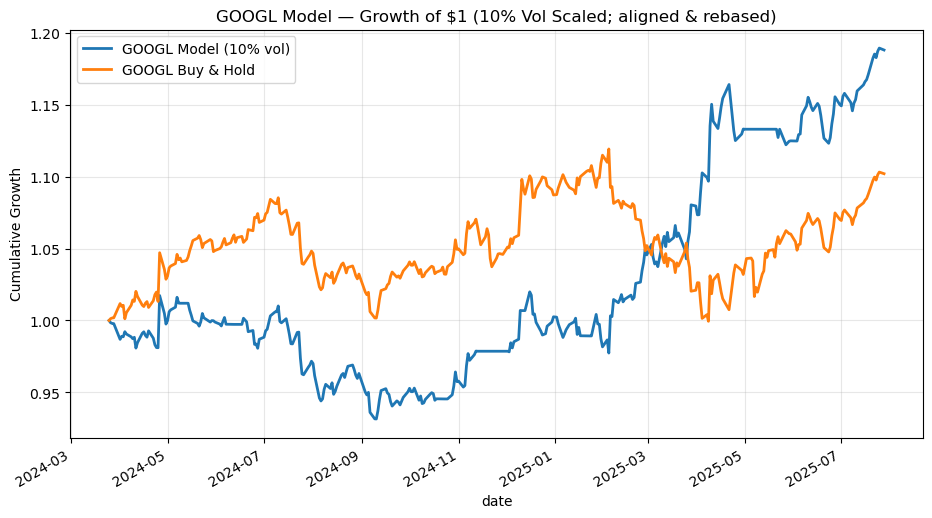

In [282]:
# =============================================================================
# Single-ticker Model vs Buy & Hold (aligned, vol-scaled, and rebased)
# -----------------------------------------------------------------------------
# Purpose:
#   1) Build a trading leg for the chosen ticker from predictions.
#   2) Compare against buy & hold, both scaled to 10% annual vol (cap applied).
#   3) Align series on common dates, compute stats, plot cumulative growth.
#   4) Report IC (Spearman) and hit ratio on y_pred vs y_true when available.
# Requirements (already defined in bootstrap):
#   - TICKER, BEST, prices, daily_map, _build_leg_from_name
# =============================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import spearmanr

plt.close('all')

# ---------------- Config ----------------
FINAL_TARGET_VOL = 0.10   # target annualized volatility for scaling
BPS_PER_SIDE     = 3.0    # trading cost assumption (bps per side) used in leg
MAX_SCALE        = 10.0   # cap scale factor to avoid extreme leverage

# ---------------- Helpers ----------------
# Annualized volatility helper
def _ann_vol(x: pd.Series) -> float:
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(x.std() * np.sqrt(252)) if len(x) else 0.0

# Scale a daily PnL/return series to a target annualized vol (with optional cap)
def _scale_to_vol(pnl: pd.Series, target: float, max_scale: float | None = None):
    v_raw = _ann_vol(pnl)
    if v_raw <= 0 or not np.isfinite(v_raw):
        return pnl*0.0, 0.0, v_raw, 0.0, False
    f = target / v_raw
    capped = False
    if (max_scale is not None) and (f > max_scale):
        f = max_scale; capped = True
    pnl_s = pnl * f
    v_final = _ann_vol(pnl_s)
    return pnl_s, float(f), float(v_raw), float(v_final), bool(capped)

# Max drawdown from an equity curve
def _max_dd(eq: pd.Series) -> float:
    return float((eq / eq.cummax() - 1.0).min()) if len(eq) else 0.0

# Convenience stats bundle from daily pnl/returns
def _stats_from_pnl(pnl: pd.Series) -> dict:
    pnl = pnl.fillna(0.0)
    eq  = (1.0 + pnl).cumprod()
    r   = float(eq.iloc[-1] ** (252/len(eq)) - 1) if len(eq) > 1 else 0.0
    v   = _ann_vol(pnl)
    s   = float((pnl.mean()*252) / (pnl.std()*np.sqrt(252))) if pnl.std() > 0 else 0.0
    dd  = _max_dd(eq)
    return {"ann_return": r, "ann_vol": v, "sharpe": s, "max_drawdown": dd, "n_days": int(len(eq))}

# ---------------- 1) Build leg for the chosen ticker ----------------
# Uses strategy name from BEST (parsed inside _build_leg_from_name)
if TICKER not in BEST:
    raise KeyError(f"Add an entry for {TICKER} in BEST.")
name = BEST[TICKER]
res  = _build_leg_from_name(TICKER, name, daily_map[TICKER], prices[TICKER])
pnl  = res["pnl"].astype(float)  # raw daily PnL (net of costs but before final scaling)

# ---------------- 2) Buy & Hold returns ----------------
px = prices[TICKER].copy()
if not isinstance(px.index, pd.DatetimeIndex):
    px.index = pd.to_datetime(px.index, errors="coerce")
ret_bh = px.astype(float).pct_change().fillna(0.0)

# ---------------- 3) Align all series to the same date set ----------------
# Align pnl, buy&hold returns, and predictions to the intersection of dates
df_csv = daily_map[TICKER].copy()
d = pd.to_datetime(df_csv["date"], errors="coerce")
d = d.dt.tz_convert(None) if getattr(d.dtype, "tz", None) is not None else d.dt.tz_localize(None)
df_csv = df_csv.set_index(d).groupby(level=0).last()  # deduplicate by date

idx = pnl.index.intersection(ret_bh.index).intersection(df_csv.index).sort_values()

pnl     = pnl.reindex(idx).fillna(0.0)
ret_bh  = ret_bh.reindex(idx).fillna(0.0)
y_true  = pd.to_numeric(df_csv.get("y_true", pd.Series(index=idx)), errors="coerce").reindex(idx)
y_pred  = pd.to_numeric(df_csv.get("y_pred", pd.Series(index=idx)), errors="coerce").reindex(idx)

# ---------------- 4) Final 10% vol scaling (with cap) ----------------
pnl_model, sf,    v_raw,    v_final,    capped    = _scale_to_vol(pnl,    FINAL_TARGET_VOL, max_scale=MAX_SCALE)
ret_bh10,  sf_bh, v_raw_bh, v_final_bh, capped_bh = _scale_to_vol(ret_bh, FINAL_TARGET_VOL, max_scale=MAX_SCALE)

# ---------------- 5) Equities (rebased to $1 on the same day) ----------------
eq_model = (1.0 + pnl_model).cumprod()
eq_bh    = (1.0 + ret_bh10).cumprod()
if len(eq_model) and len(eq_bh):
    eq_model = (eq_model / eq_model.iloc[0]).rename(f"{TICKER} Model (10% vol)")
    eq_bh    = (eq_bh    / eq_bh.iloc[0]).rename(f"{TICKER} Buy & Hold")

# ---------------- 6) Metrics ----------------
st_model = _stats_from_pnl(pnl_model)
st_bh    = _stats_from_pnl(ret_bh10)

# Hit ratio & Spearman IC for predictions vs realized target
hit = np.nan; rho = np.nan
if y_true.notna().sum() > 5 and y_pred.notna().sum() > 5:
    common_ic = y_true.dropna().index.intersection(y_pred.dropna().index)
    yt = y_true.reindex(common_ic)
    yp = y_pred.reindex(common_ic)
    if len(common_ic) > 5:
        hit = (np.sign(yp) == np.sign(yt)).mean()
        rho, _ = spearmanr(yp, yt)

# ---------------- 7) Plot ----------------
fig, ax = plt.subplots(1,1,figsize=(11,6))
pd.concat([eq_model, eq_bh], axis=1).dropna().plot(ax=ax, lw=2)
ax.set_title(f"{TICKER} Model — Growth of $1 (10% Vol Scaled; aligned & rebased)")
ax.set_ylabel("Cumulative Growth"); ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# ---------------- 8) Neat metrics table ----------------
rows = [
    {"series": f"{TICKER} Model (10% vol)", **st_model, "scale_factor": sf, "scale_capped": capped,
     "hit_ratio": hit, "spearman": rho},
    {"series": f"{TICKER} Buy & Hold (10% vol)", **st_bh, "scale_factor": sf_bh, "scale_capped": capped_bh},
]
mt = pd.DataFrame(rows).set_index("series")
display(mt.style.format({
    "ann_return":"{:.2%}", "ann_vol":"{:.2%}", "sharpe":"{:.2f}",
    "max_drawdown":"{:.2%}", "hit_ratio":"{:.2%}", "spearman":"{:.3f}",
    "scale_factor":"{:.2f}"
}))

**Overall, this model demonstrates strong predictive power and attractive risk-adjusted returns, however, being a one-stock model it also bears some concentration risk.**

# Predictions Around Earnings: Event-centric LOEO (Leave-One-Earnings-Out) pipeline

The next stage retains the stable target-centric pipeline but shifts the **validation unit from calendar-based slices to discrete earnings events**. In Leave-One-Earnings-Out (LOEO), each earnings release for the target company defines a test fold. Training excludes a buffer around that event (e.g., ±5 trading days) and can optionally embargo similar windows around other earnings in the training set to avoid near-duplicate leakage. This directly mirrors the business question: *“How would the model perform on the next earnings release?”*

The LOEO framework will:

- **Define one fold per earnings event**, train on all other data outside the buffer, and test on the target window (e.g., predicting T+10 from the event day).  
- **Apply the same pruning, feature selection, and modeling process** within each fold as in the stable pipeline.  
- **Report per-event metrics** (hit rate, Spearman correlation, conditional return), with aggregation by event attributes (e.g., surprise magnitude, guidance signals) and by regime (e.g., high vs low volatility).   
- **Select a global K** (number of top-ranked features) by taking the median of fold-level best-K values if a single operating point is desired.

This design preserves the strengths of the proven pipeline, and introduces an evaluation tailored to high-impact, discrete events — providing a closer analogue to how the model can be used in practice arounf earnings. 

In [147]:
# User defined functions:

# --- Ticker alias map ---
# Normalizes alternative ticker spellings (e.g., GOOG/GOOGL) so downstream
# column-matching and filters work regardless of which variant appears.
TKR_ALIASES = {
    "googl": ("googl", "goog"),
    "goog":  ("goog", "googl"),
    "aapl":  ("aapl",),
    "nvda":  ("nvda",),
    # add more if you have dual tickers
}

# --- Wide-frame registry ---
# Explicit mapping from ticker → its augmented, tied "wide" DataFrame.
# Keeps naming unambiguous when running multiple tickers in one notebook.
wide_map = {
    "nvda": wide_nvda_aug_tied,   # NVDA-wide DF
    "aapl": wide_apple_aug_tied,    # AAPL-wide DF
    "googl": wide_google_aug_tied,  # GOOGL-wide DF
}

# --- Safe access to the correct wide frame for a ticker ---
# Raises a clear error if the ticker was not registered in wide_map.
def pick_wide(tkr: str):
    t = tkr.lower()
    if t not in wide_map:
        raise KeyError(f"No wide frame registered for '{t}'. Have: {list(wide_map)}")
    return wide_map[t]

# --- Guard: verify the requested target column exists in the wide frame ---
# If not, show a few similar target examples (e.g., other forward-return horizons).
def assert_has_target(df, target_col: str):
    if target_col not in df.columns:
        similar = [c for c in df.columns
                   if c.startswith("future_") and c.endswith(target_col.split("ret_")[-1])]
        raise KeyError(
            f"Missing target '{target_col}' in this wide frame.\n"
            f"Examples of available targets here: {similar[:10]}"
        )

# --- Column classifiers used by feature selection / slicing ---
# True if the column name looks like a forward target (future_*).
def is_future_col(c: str) -> bool:
    return c.lower().startswith("future_")

# True if the column looks standardized (z-score or global-z).
def is_std_col(c: str) -> bool:
    c = c.lower()
    return c.endswith("_z") or c.endswith("_gz")

# True if a column name ends with (or contains an underscore-delimited token for) the ticker
# accounting for aliases (e.g., *_googl, *_goog). Used to include/exclude per-ticker features.
def endswith_tkr_any(c: str, tkr: str) -> bool:
    c = c.lower(); t = tkr.lower()
    codes = TKR_ALIASES.get(t, (t,))
    return any(c.endswith(f"_{code}") or f"_{code}_" in c for code in codes)

# ================= WIDE FEATURE SELECTION (Paths A/B/C) =================
# Build the feature list for a given path using exclusion-only rules:
#   A: peer-only + globals (drop any column that references the target ticker)
#   B: target-only + globals (drop any column that references peer tickers)
#   C: all features except future_* targets
# Then apply a light cleanup: drop *_dm if a standardized twin exists.
# peer_sets can be passed explicitly; otherwise a global `peer_sets` is used if present.
def wide_get_feature_cols(df_wide, target_ticker: str, path: str, peer_sets=None) -> list[str]:
    """
    Path A/B/C using exclusion-only logic + optional _dm de-dupe.
    If peer_sets is None, it falls back to a global `peer_sets` dict.
    """
    all_cols = list(df_wide.columns)
    if peer_sets is None:
        peer_sets = globals().get("peer_sets", {})

    if path == "A":
        cols = feat_cols_path_A(all_cols, target_ticker)
    elif path == "B":
        cols = feat_cols_path_B(all_cols, target_ticker, peer_sets)
    elif path == "C":
        cols = feat_cols_path_C(all_cols)
    else:
        raise ValueError("path must be one of {'A','B','C'}")

    # optional list-level cleanup (keeps z/raw twins; only drops _dm if a twin exists)
    return drop_dm_dup(cols)


# ============ MATERIALIZE X/y FROM A SINGLE WIDE FRAME ============
# Given a target column, a feature list, and a date index:
#   - subset the wide DF to those rows/columns
#   - prefer standardized twins over raw (drop_raw_if_std_present)
#   - drop banned prefixes (via drop_prefixed_features / BANNED_PREFIXES)
#   - drop any remaining NaN rows
# Returns: (X matrix, y vector, index used, feature name Index)
def wide_materialize_Xy(df_wide, target_col: str, feature_cols: list[str], idx: pd.DatetimeIndex, verbose: bool = False):
    """
    Subset df_wide to index `idx`, keep [target_col] + feature_cols, drop NAs, return X, y, index, feature_names.
    """
    missing = [c for c in [target_col] + feature_cols if c not in df_wide.columns]
    if missing:
        raise KeyError(f"Missing columns in wide frame: {missing[:10]} (+{max(0,len(missing)-10)} more)")
    dfm = df_wide.loc[idx, [target_col] + feature_cols].copy()

    # If you want your pruning in this wide-run too, keep it here:
    dfm, _dropped = drop_raw_if_std_present(dfm, target_col=target_col,  verbose=False)
    dfm = drop_prefixed_features(dfm, target_col, BANNED_PREFIXES, verbose=False)

    dfm = dfm.dropna(axis=0, how="any")
    y = dfm[target_col].values
    X = dfm.drop(columns=[target_col]).values
    return X, y, dfm.index, dfm.columns.drop(target_col)

# --- Helper: retain only feature columns that have no NaNs on the given rows ---
# Useful for tight LOEO windows where some engineered features may be missing.--
def non_na_columns_on(df_wide, cols, row_indexer):
    block = df_wide.loc[row_indexer, cols]
    return block.columns[block.isna().sum() == 0].tolist()

# ================= Earnings anchors + LOEO split builders =================
# Find earnings "anchor" dates for a ticker from days-since-earnings columns.
# Accepts either *_trading_* or plain *_earnings_* variants.
# Returns a DatetimeIndex of anchors (event days); raises with helpful hints if missing.
def wide_find_earnings_anchors(df_wide, ticker: str):
    t = ticker.lower()
    cand = [f"days_since_earnings_trading_{t}", f"days_since_earnings_{t}"]
    have = [c for c in cand if c in df_wide.columns]
    if not have:
        related = [c for c in df_wide.columns if "earn" in c.lower() and t in c.lower()]
        raise KeyError(f"No earnings anchor for {ticker}. Expected {cand}. Related: {related[:10]}")
    s = df_wide[have[0]]

    # Event-day = 0; if none, fall back to 1
    mask = s.eq(0)
    if not mask.any():
        mask = s.eq(1)
        if not mask.any():
            raise ValueError(f"{have[0]} has no 0s or 1s; cannot form LOEO windows.")

    # Return ANCHORS AS DATES, never as int positions
    if isinstance(df_wide.index, pd.DatetimeIndex):
        anchors = df_wide.index[mask]
    elif "date" in df_wide.columns:
        anchors = pd.to_datetime(df_wide.loc[mask, "date"].values)
    else:
        raise TypeError("Need a DatetimeIndex or a 'date' column in df_wide.")

    return pd.DatetimeIndex(anchors)


# Build LOEO splits around each earnings anchor:
#   - TEST window = [anchor - window, anchor + window] in business days
#   - TRAIN = all other rows, with a purge buffer around TEST (±purge)
# Returns: (list of (train_idx, test_idx) arrays, DatetimeIndex of anchors).
def wide_make_loeo_splits(df_wide, ticker: str, window: int, purge: int):
    # Build a date array even if the index is integers
    if isinstance(df_wide.index, pd.DatetimeIndex):
        dates = df_wide.index
    elif "date" in df_wide.columns:
        dates = pd.to_datetime(df_wide["date"].values)
    else:
        raise TypeError("Need a DatetimeIndex or a 'date' column in df_wide.")

    anchors = wide_find_earnings_anchors(df_wide, ticker)

    # Normalize anchors to datetime
    if isinstance(anchors, pd.Index) and is_integer_dtype(anchors.dtype):
        anchors_dt = pd.to_datetime(dates.values[anchors])
    elif np.issubdtype(np.asarray(anchors).dtype, np.integer):
        anchors_dt = pd.to_datetime(dates.values[np.asarray(anchors)])
    else:
        anchors_dt = pd.DatetimeIndex(anchors)

    splits = []
    for a in anchors_dt:
        mask = (dates >= (a - pd.tseries.offsets.BDay(window))) & (dates <= (a + pd.tseries.offsets.BDay(window)))
        te = np.where(mask)[0]
        if te.size == 0:
            continue
        pur_lo = max(te[0] - purge, 0)
        pur_hi = min(te[-1] + purge + 1, len(dates))
        tr = np.setdiff1d(np.arange(len(dates)), np.arange(pur_lo, pur_hi), assume_unique=True)
        splits.append((tr, te))
    return splits, anchors_dt

from scipy.stats import spearmanr

# ====================== Extended evaluation metrics ======================
# Compute a richer set of metrics on one test window:
#   - hit, strat_ret (long/flat using sign of ŷ, optionally with a no-trade band)
#   - Spearman rho, MAE, RMSE, bias
#   - coverage (fraction of days traded given the band)
#   - long_short_topk (mean of top-k minus mean of bottom-k by ŷ)
def eval_metrics_extended(y_true, y_hat, trade_band=0.0, topk=None):
    """
    y_true, y_hat are 1D arrays for one test window.
    trade_band: if >0, skip trades where |ŷ| <= band (coverage metric returned).
    topk: if set (int), compute long-short return = mean(y of top-k ŷ) - mean(y of bottom-k ŷ).
    """
    y = np.asarray(y_true); yh = np.asarray(y_hat)
    # sign metrics (with optional no-trade band)
    trade_mask = np.abs(yh) > trade_band
    coverage = trade_mask.mean()  # share of days we actually take a position
    if trade_mask.any():
        hit = np.mean(np.sign(y[trade_mask]) == np.sign(yh[trade_mask]))
        strat_ret = np.mean(y[trade_mask] * np.sign(yh[trade_mask]))
    else:
        hit = np.nan; strat_ret = np.nan

    # rank correlation
    rho, _ = spearmanr(y, yh)

    # magnitude errors
    err  = yh - y
    mae  = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    bias = np.mean(err)

    # top-k long/short
    ls = np.nan
    if topk is not None and len(y) >= 2*topk:
        idx = np.argsort(yh)
        bottom = y[idx[:topk]].mean()
        top    = y[idx[-topk:]].mean()
        ls = top - bottom

    return {"hit": hit, "strat_ret": strat_ret, "rho": rho, "mae": mae, "rmse": rmse,
            "bias": bias, "coverage": coverage, "long_short_topk": ls}


# ========================== Walk-forward runner ==========================
# Run a simple Ridge or XGB baseline over pre-computed WF splits:
#   - select features per path
#   - materialize TRAIN/TEST
#   - fit, predict, and aggregate mean±std of eval_metrics over folds
def wide_run_walkforward(df_wide, target_col, target_ticker, path, splits, model_name="ridge"):
    feats = wide_get_feature_cols(df_wide, target_ticker, path)
    metrics = []
    for tr_idx, te_idx in splits:
        tr_dates = df_wide.index[tr_idx]
        te_dates = df_wide.index[te_idx]
        Xtr, ytr, _, _ = wide_materialize_Xy(df_wide, target_col, feats, tr_dates)
        Xte, yte, _, _ = wide_materialize_Xy(df_wide, target_col, feats, te_dates)

        if model_name == "ridge":
            mdl = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
        else:
            mdl = XGBRegressor(
                n_estimators=1000, max_depth=3, learning_rate=0.05,
                subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                objective="reg:squarederror", random_state=42, tree_method="hist", verbosity=0
            ).fit(Xtr, ytr)

        yhat = mdl.predict(Xte)
        metrics.append(eval_metrics(yte, yhat))

    return {k: (np.mean([m[k] for m in metrics]), np.std([m[k] for m in metrics], ddof=1)) for k in metrics[0]}

# ============================== LOEO runner ==============================
# Leave-One-Earnings-Out evaluation across multiple event windows:
#   - build LOEO splits for each window size (e.g., 2/5/10 days)
#   - per split: start from path features, then keep only columns that are non-NaN
#     on TEST (and on TRAIN) to avoid leakage from imputation
#   - fit Ridge or XGB, score with eval_metrics, aggregate mean±std across events
# Returns a tidy DataFrame with metrics per window/path/model.
def wide_run_loeo(df_wide, target_col, target_ticker, path,
                  windows=(2,5,10), purge=10, model_name="ridge"):
    """
    LOEO around earnings anchors, robust to scattered NaNs in tight windows.
    For each split:
      - start from the path's base features,
      - keep only columns that are non-NA on TEST, then TRAIN,
      - skip degenerate slices (no rows).
    """
    base_feats = wide_get_feature_cols(df_wide, target_ticker, path)
    rows = []

    for W in windows:
        splits, anchors = wide_make_loeo_splits(df_wide, target_ticker, window=W, purge=purge)
        if not splits:
            rows.append({
                "Window": W, "Path": path, "Model": model_name.capitalize(),
                "hit_mean": np.nan, "hit_std": np.nan,
                "strat_ret_mean": np.nan, "strat_ret_std": np.nan,
                "spearman_mean": np.nan, "spearman_std": np.nan
            })
            continue

        mets = []
        for tr_idx, te_idx in splits:
            tr_labels = df_wide.index[tr_idx]
            te_labels = df_wide.index[te_idx]
            # --- per-split feature coverage (TEST then TRAIN must be clean) ---
            feats_te_clean = non_na_columns_on(df_wide, base_feats, te_labels)
            if not feats_te_clean:
                continue
            feats_split = non_na_columns_on(df_wide, feats_te_clean, tr_labels)
            if not feats_split:
                continue
            # -------------------------------------------------------------------

            # Materialize with split-specific features (silent pruning inside)
            Xtr, ytr, _, _ = wide_materialize_Xy(df_wide, target_col, feats_split, tr_labels)
            Xte, yte, _, _ = wide_materialize_Xy(df_wide, target_col, feats_split, te_labels)

            # Final guard against degenerate slices
            if Xtr.shape[0] == 0 or Xte.shape[0] == 0 or ytr.size == 0 or yte.size == 0:
                continue

            # Fit & predict
            if model_name == "ridge":
                mdl = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
            else:
                mdl = XGBRegressor(
                    n_estimators=1000, max_depth=3, learning_rate=0.05,
                    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                    objective="reg:squarederror", random_state=42, tree_method="hist", verbosity=0
                ).fit(Xtr, ytr)

            yhat = mdl.predict(Xte)
            mets.append(eval_metrics(yte, yhat))
        if mets:
            agg = {k: (np.mean([m[k] for m in mets]),
                       np.std([m[k] for m in mets], ddof=1)) for k in mets[0]}
            rows.append({
                "Window": W, "Path": path, "Model": model_name.capitalize(),
                "hit_mean":       agg["hit"][0],       "hit_std":       agg["hit"][1],
                "strat_ret_mean": agg["strat_ret"][0], "strat_ret_std": agg["strat_ret"][1],
                "spearman_mean":  agg["spearman"][0],  "spearman_std":  agg["spearman"][1],
            })
        else:
            rows.append({
                "Window": W, "Path": path, "Model": model_name.capitalize(),
                "hit_mean": np.nan, "hit_std": np.nan,
                "strat_ret_mean": np.nan, "strat_ret_std": np.nan,
                "spearman_mean": np.nan, "spearman_std": np.nan
            })

    return pd.DataFrame(rows)

In [148]:
# =========================
# LOEO — Drop-in Upgrade
# =========================
# Purpose:
#   Make LOEO reuse the finalized A/B/C blueprint:
#   1) prefer_standardized → enforce_numeric → drop_unrelated_features(method="both", rmin=0.10)
#   2) Leakage-safe model-based filters: PI on inner val + Ridge stability selection
#   3) Cache per-fold Ridge rankings → cheap K-sweep → pick BEST_K
#   4) Tuned XGB per fold on Ridge top-K; metrics + optional SHAP on last fold
#
# Notes:
#   - Reuses wide_get_feature_cols(...) for path logic.
#   - Per-fold materialization is NaN-safe (numeric cast + row drops inside fold only).
#   - Works with LOEO splits from wide_make_loeo_splits(...).


# ---------- Utilities: safe numeric extraction per split ----------
# Cast selected TRAIN/TEST rows to numeric, drop inf/NaN rows, and return X, y.
# Preserves the temporal order of 'idx'. Returns empty arrays if the slice collapses.
def _safe_xy_from_indices(dfm: pd.DataFrame, feat_cols, target_col, idx):
    """
    Cast to numeric inside the selected rows and drop rows with any NaN/inf.
    Keeps the temporal order of 'idx' intact.
    """
    sub = dfm.iloc[idx][[target_col] + list(feat_cols)].apply(pd.to_numeric, errors="coerce")
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    if sub.empty:
        return np.empty((0, 0)), np.empty((0,))
    X = sub.drop(columns=[target_col]).values
    y = sub[target_col].values
    return X, y

# Columns that are fully non-NaN on a given row set (tight windows).
# Helps avoid leakage from imputation by requiring exact coverage per split.
def _non_na_on(df: pd.DataFrame, cols, indexer):
    """Columns that have no NaNs on the given rows (tight LOEO windows)."""
    blk = df.loc[indexer, cols]
    return blk.columns[blk.isna().sum() == 0].tolist()

# ---------- Build LOEO modeling frame with blueprint pre-filters ----------
# Construct a row-preserving modeling frame (columns only pruned) for a ticker/H/path:
#   - choose features by path (A/B/C) with drop_dm_dup
#   - prefer standardized twins, enforce numeric, correlation screen (Pearson ∪ Spearman ≥ rmin)
# Returns dfm (same index as df_wide) and the canonical target_col.
def loeo_prepare_dfm(
    df_wide,
    target_ticker: str,
    H: int,
    path: str,
    peer_sets: dict | None = None,
    rmin: float = 0.10,
):
    """
    Build a modeling frame for LOEO WITHOUT dropping rows.
    All pruning here is COLUMN-only; the returned dfm shares the exact index with df_wide.
    """
    # --- target ---
    target_col = f"future_{int(H)}d_ret_{target_ticker.lower()}"
    assert_has_target(df_wide, target_col)

    # --- path columns (A/B/C) per your latest rules ---
    all_cols = list(df_wide.columns)
    if path == "A":
        base_feats = drop_dm_dup(feat_cols_path_A(all_cols, target_ticker))
    elif path == "B":
        if peer_sets is None:
            raise ValueError("peer_sets is required for Path 'B'.")
        base_feats = drop_dm_dup(feat_cols_path_B(all_cols, target_ticker, peer_sets))
    elif path == "C":
        base_feats = drop_dm_dup(feat_cols_path_C(all_cols))
    else:
        raise ValueError("path must be one of: 'A','B','C'")

    # --- start with wide rows, only narrowing COLUMNS ---
    df_cols_only = df_wide[[target_col] + base_feats].copy()

    # 1) Prefer standardized twins (capture kept column names only)
    df_std, _ = prefer_standardized(df_cols_only.copy(), target_col)
    kept_after_std = [c for c in df_std.columns if c != target_col]

    # 2) Enforce numeric (again: column names only)
    df_num, _ = enforce_numeric_features(df_std.copy(), target_col)
    kept_after_num = [c for c in df_num.columns if c != target_col]

    # 3) Correlation screen (compute on a copy; DO NOT carry row drops forward)
    df_corr = drop_unrelated_features(df_num.copy(), target_col, rmin=rmin, method="both")
    kept_after_corr = [c for c in df_corr.columns if c != target_col]

    # Final kept feature set = intersection of all step-wise keeps
    kept_feats = [c for c in kept_after_corr if c in kept_after_num]

    # --- REBUILD dfm on the ORIGINAL wide index (row preserving) ---
    dfm = df_wide[[target_col] + kept_feats].copy()

    return dfm, target_col



# ---------- Leakage-safe model-based filters on LOEO splits ----------
# Apply blueprint orchestrator on dfm using LOEO splits:
#   - permutation importance on inner validation per fold (no leakage)
#   - Ridge stability selection across folds
#   - combine: drop harmful by PI ∩ keep stable by Ridge
# Returns (dfm_filtered, report_dict).
def loeo_apply_filters(dfm: pd.DataFrame, splits, target_col: str,
                       pi_mode="val", n_repeats=30, stab_K=40, stab_min_frac=0.6,
                       min_feats=30, pi_eps=0.005, verbose=True):
    """
    Same combine-logic as your blueprint orchestrator, but fed with LOEO splits.
    """
    df_final, report = apply_model_based_filters(
        dfm=dfm,
        splits=splits,
        target_col=target_col,
        pi_mode=pi_mode,
        n_repeats=n_repeats,
        stab_K=stab_K,
        stab_min_frac=stab_min_frac,
        min_feats=min_feats,
        pi_eps=pi_eps,
        verbose=verbose
    )
    return df_final, report

# ---------- Cache Ridge rankings per LOEO fold ----------
# For each fold TRAIN slice:
#   - coerce to numeric, drop NaN rows
#   - fit RidgeCV and sort features by |coef| descending
# Returns (rankings_by_fold, feature_name_list).
def cache_ridge_rankings_loeo(dfm: pd.DataFrame, splits, target_col: str):
    """
    For each fold:
      - take TRAIN rows
      - coerce numeric, drop NaN rows
      - fit RidgeCV, sort |coef| desc → feature ranking for that fold
    """
    cols = [c for c in dfm.columns if c != target_col]
    rankings = []
    for (tr_idx, _te_idx) in splits:
        Xtr, ytr = _safe_xy_from_indices(dfm, cols, target_col, tr_idx)
        if Xtr.shape[0] < 20 or Xtr.shape[1] == 0:
            rankings.append(cols[:])  # fallback to current order
            continue
        rid = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
        order = np.argsort(np.abs(rid.coef_))[::-1]
        rankings.append([cols[i] for i in order if i < len(cols)])
    return rankings, cols

# ---------- Cheap K-sweep using cached rankings ----------
# Evaluate candidate K values using cached per-fold Ridge rankings:
#   - per fold: select topK features → fast XGB → compute hit/ret/rho
#   - aggregate mean±std across folds
# K candidates are clamped to available feature count. Returns {K: metrics}.
def sweep_K_with_cached_rankings_loeo(dfm, splits, target_col, ridge_rankings, Ks=(20,30,40,60)):
    import numpy as np
    from scipy.stats import spearmanr

    # --- clamp and deduplicate K values to the available feature count ---
    n_feats = dfm.shape[1] - 1   # minus target column
    Ks_eff = sorted(set(min(int(k), n_feats) for k in Ks))
    # If everything collapses to one value (e.g., n_feats=29 ⇒ {29}), skip extra work
    if len(Ks_eff) == 1:
        print(f"[K-sweep] Only {n_feats} features available → single K={Ks_eff[0]}")
    else:
        print(f"[K-sweep] Candidates after clamping to {n_feats} feats → {Ks_eff}")

    X_full = dfm.drop(columns=[target_col])
    y_full = dfm[target_col].values

    results = {}
    for K in Ks_eff:
        fold_metrics = []
        for fold, (tr_idx, te_idx) in enumerate(splits):
            topK = ridge_rankings[fold][:K]  # safe: K ≤ n_feats
            Xtr = X_full.iloc[tr_idx][topK].values
            ytr = y_full[tr_idx]
            Xte = X_full.iloc[te_idx][topK].values
            yte = y_full[te_idx]

            mdl = fast_xgb_for_sweep(Xtr, ytr)   # your light/early-stopped booster
            yhat = mdl.predict(Xte)

            hit = (np.sign(yhat) == np.sign(yte)).mean()
            ret = yte[yhat > 0].mean() if np.any(yhat > 0) else 0.0
            rho = spearmanr(yte, yhat, nan_policy="omit").correlation
            fold_metrics.append((hit, ret, rho))

        arr = np.array(fold_metrics, dtype=float)
        results[K] = {
            "hit_mean":       float(np.nanmean(arr[:,0])),
            "hit_std":        float(np.nanstd(arr[:,0], ddof=1)),
            "ret_mean":       float(np.nanmean(arr[:,1])),
            "ret_std":        float(np.nanstd(arr[:,1], ddof=1)),
            "spearman_mean":  float(np.nanmean(arr[:,2])),
            "spearman_std":   float(np.nanstd(arr[:,2], ddof=1)),
        }
        print(f"K={K:>3} | hit={results[K]['hit_mean']:.3f}±{results[K]['hit_std']:.3f} "
              f"| rho={results[K]['spearman_mean']:.3f}±{results[K]['spearman_std']:.3f} "
              f"| ret={results[K]['ret_mean']:.4f}±{results[K]['ret_std']:.4f}")
    return results

# Pick BEST_K from a sweep dict:
#   - maximize `primary` (default hit_mean)
#   - tie-break on `tie` (default spearman_mean)
#   - prefer smaller K on final tie (to reduce variance)
def pick_best_K(sweep_dict, primary="hit_mean", tie="spearman_mean", prefer_small_K=True):
    items = [(K, m) for K, m in sweep_dict.items()
             if m.get(primary) is not None and not np.isnan(m.get(primary, np.nan))]
    if not items:
        raise ValueError("Empty sweep.")
    best_primary = max(m[primary] for _, m in items)
    cands = [(K, m) for K, m in items if abs(m[primary] - best_primary) < 1e-12]
    best_tie = max(m[tie] for _, m in cands if m.get(tie) is not None)
    cands = [(K, m) for K, m in cands if abs(m[tie] - best_tie) < 1e-12]
    return min(K for K, _ in cands) if prefer_small_K else max(K for K, _ in cands) 

# ---------- Per-fold metrics (hybrid) on LOEO ----------
# For each aligned LOEO split:
#   - TRAIN Ridge top-K → tuned XGB (or Ridge)
#   - Predict TEST; compute hit, Spearman rho, and conditional long-only return
# All per-fold materialization uses numeric-cast + NaN row drop INSIDE the fold.
def per_fold_metrics_hybrid_loeo(dfm: pd.DataFrame, splits, target_col: str,
                                 ridge_rankings, K: int, model="xgb"):
    """
    Ridge top-K (per fold) → tuned XGB (or Ridge) → hit / rho / conditional long-only return.
    All materialization is done per fold with numeric-cast + drop-na inside the fold.
    """
    rows = []
    for i, ((tr_idx, te_idx), ranking) in enumerate(zip(splits, ridge_rankings)):
        topK = ranking[:K]
        Xtr, ytr = _safe_xy_from_indices(dfm, topK, target_col, tr_idx)
        Xte, yte = _safe_xy_from_indices(dfm, topK, target_col, te_idx)
        if Xtr.size == 0 or Xte.size == 0:
            rows.append({"fold": i, "K_used": int(K), "n_test": int(len(te_idx)),
                         "hit": np.nan, "spearman": np.nan, "strat_ret": np.nan})
            continue

        if model.lower() == "xgb":
            mdl = _tuned_xgb_for_fold(Xtr, ytr)
        elif model.lower() == "ridge":
            mdl = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
        else:
            raise ValueError("model must be 'xgb' or 'ridge'.")

        yhat = mdl.predict(Xte)
        hit = float((np.sign(yhat) == np.sign(yte)).mean())
        rho = float(spearmanr(yte, yhat, nan_policy="omit").correlation)
        ret = float(yte[yhat > 0].mean()) if np.any(yhat > 0) else 0.0

        rows.append({
            "fold": i, "K_used": int(K), "n_test": int(len(yte)),
            "hit": hit, "spearman": rho, "strat_ret": ret
        })

    out = pd.DataFrame(rows).set_index("fold")
    return out[["K_used","n_test","hit","spearman","strat_ret"]]

# ---------- SHAP on the last LOEO fold ----------
# Fit the exact last-fold model (top-K features, tuned XGB) and compute SHAP rankings
# (mean |SHAP| across test samples). Falls back to model importances if SHAP is unavailable.-
def shap_last_fold_loeo(dfm: pd.DataFrame, splits, target_col: str,
                        ridge_rankings, K: int, shap_sample: int | None = 1024):
    """
    Fit the exact model used on the last fold (top-K) and return a SHAP ranking (mean|SHAP|).
    Falls back to built-in importances if SHAP fails.
    """
    last = len(splits) - 1
    tr_idx, te_idx = splits[last]
    topK = ridge_rankings[last][:K]

    Xtr, ytr = _safe_xy_from_indices(dfm, topK, target_col, tr_idx)
    Xte, yte = _safe_xy_from_indices(dfm, topK, target_col, te_idx)
    if Xtr.size == 0 or Xte.size == 0:
        raise RuntimeError("Last fold has empty design after NaN cleaning.")

    mdl = _tuned_xgb_for_fold(Xtr, ytr)
    yhat = mdl.predict(Xte)
    hit = float((np.sign(yhat) == np.sign(yte)).mean())
    print(f"[LOEO | last fold] tuned XGB hit={hit:.3f} | K={len(topK)} | test n={len(yte)}")

    # SHAP or fallback
    try:
        import shap
        X_for_explain = Xte
        if shap_sample is not None and Xte.shape[0] > shap_sample:
            rng = np.random.RandomState(202)
            X_for_explain = Xte[rng.choice(Xte.shape[0], shap_sample, replace=False)]
        explainer = shap.TreeExplainer(mdl)
        sv = explainer.shap_values(X_for_explain)
        vals = sv if isinstance(sv, np.ndarray) else np.asarray(sv.values)
        shap_rank = pd.Series(np.abs(vals).mean(axis=0), index=topK).sort_values(ascending=False)
        return shap_rank
    except Exception:
        # Light fallback: model feature_importances_ if available
        try:
            imp = getattr(mdl, "feature_importances_", None)
            if imp is not None and len(imp) == len(topK):
                return pd.Series(imp, index=topK).sort_values(ascending=False)
        except Exception:
            pass
        # Ridge fallback (if you ever switch models here)
        try:
            coef = np.asarray(getattr(mdl, "coef_", None)).ravel()
            std = Xtr.std(axis=0, ddof=1); std[std==0] = 1.0
            imp = np.abs(coef * std)
            return pd.Series(imp, index=topK).sort_values(ascending=False)
        except Exception:
            return pd.Series(dtype=float)

# Map LOEO splits built on df_wide (int positions) to dfm positions:
#   - convert positions → dates on df_wide
#   - intersect with dfm.index
#   - convert matched dates back to integer positions on dfm
# Splits with no overlap after pruning are skipped
def align_splits_to_dfm(df_wide, dfm, splits_wide):
    """
    Convert LOEO splits built on df_wide (int positions) into splits usable on dfm
    (int positions on dfm). We do it by mapping positions→dates on df_wide, then
    intersecting with dfm.index, then converting back to dfm integer positions.
    """
    aligned = []
    for tr_w, te_w in splits_wide:
        # 1) positions on df_wide -> dates
        tr_dates_w = df_wide.index[np.asarray(tr_w)]
        te_dates_w = df_wide.index[np.asarray(te_w)]

        # 2) intersect with dfm dates (pruning may have dropped some rows)
        tr_dates = dfm.index.intersection(tr_dates_w)
        te_dates = dfm.index.intersection(te_dates_w)

        if len(tr_dates) == 0 or len(te_dates) == 0:
            continue  # this split becomes empty after pruning—skip it

        # 3) dates -> integer positions on dfm (for all downstream code)
        tr_idx = dfm.index.get_indexer(tr_dates)
        te_idx = dfm.index.get_indexer(te_dates)

        aligned.append((tr_idx, te_idx))
    return aligned


# --------------------------------------------
# (Alternate) Build the modeling frame for LOEO runs (with warmup)
# Same intent as earlier loeo_prepare_dfm, but uses build_model_frame and warmup_days.
# --------------------------------------------
def loeo_prepare_dfm(
    df_wide,
    target_ticker: str,
    H: int,
    path: str,
    peer_sets: dict | None = None,
    rmin: float = 0.10,
    warmup_days: int = 30,
):
    """
    Returns:
      dfm        : pruned modeling frame for the chosen PATH (index = dates)
      target_col : 'future_{H}d_ret_{ticker}'
    Steps:
      - choose features by path (A/B/C) using your latest logic with drop_dm_dup
      - build_model_frame (POSitional args — no 'feature_cols=' kwarg)
      - prefer standardized twins, enforce numeric, drop low-corr (Pearson ∪ Spearman)
    """
    # 0) target name (your canonical)
    target_col = f"future_{int(H)}d_ret_{target_ticker.lower()}"
    assert_has_target(df_wide, target_col)

    # 1) select features by your newest path rules
    all_cols = list(df_wide.columns)
    if path == "A":
        feats = drop_dm_dup(feat_cols_path_A(all_cols, target_ticker))                 # peers + globals (no target)
    elif path == "B":
        if peer_sets is None:
            raise ValueError("peer_sets is required for Path 'B' (target-only + globals, exclude peers).")
        feats = drop_dm_dup(feat_cols_path_B(all_cols, target_ticker, peer_sets))      # target + globals (no peers)
    elif path == "C":
        feats = drop_dm_dup(feat_cols_path_C(all_cols))                                # everything except future_*
    else:
        raise ValueError("path must be one of: 'A','B','C'")

    # 2) build the modeling frame (POSitional call; some notebooks error on 'feature_cols=')
    try:
        # expected signature: build_model_frame(df, target_col, feature_list, warmup_days=..., allow_missing_frac=...)
        dfm = build_model_frame(df_wide, target_col, feats, warmup_days, 0.0)
    except TypeError:
        # very old signature without allow_missing_frac
        dfm = build_model_frame(df_wide, target_col, feats, warmup_days)

    # 3) blueprint prefilters — identical to your WF path
    dfm, _ = prefer_standardized(dfm, target_col)                                  # prefer *_z / *_gz over raw twins
    dfm, _ = enforce_numeric_features(dfm, target_col)                             # drop non-numeric/constant
    dfm    = drop_unrelated_features(dfm, target_col, rmin=rmin, method="both")    # Pearson ∪ Spearman ≥ rmin

    return dfm, target_col


# --- Helper: robust date array extractor (index or 'date' column) ---
# Returns a 1-D datetime64[ns] np.array; raises if no date basis exists.
def get_dates_array(df):
    """
    Returns a 1-D numpy array of datetime64[ns] for row-wise date alignment.
    - If df.index is DatetimeIndex -> use it
    - Else if 'date' column exists -> use it (converted to datetime)
    - Else -> raise
    """
    import numpy as np
    import pandas as pd
    if isinstance(df.index, pd.DatetimeIndex):
        return df.index.values
    if "date" in df.columns:
        return pd.to_datetime(df["date"].values).astype("datetime64[ns]")
    raise TypeError("Need a DatetimeIndex or a 'date' column.")


# ---------- (7) Orchestrator: one-call LOEO run for a single ticker/path ----------
# End-to-end LOEO, consistent with the blueprint:
#   1) Build/prune dfm for PATH on df_wide (column-only pruning; preserve rows)
#   2) Create LOEO splits on df_wide around earnings anchors (±window, purge≈H by default)
#   3) Align those splits to dfm by DATE (not integer index)
#   4) Apply PI + Stability on dfm with aligned splits → dfm_final
#   5) Cache Ridge rankings → cheap K-sweep → choose BEST_K
#   6) Compute per-fold metrics with tuned XGB (or Ridge)
#   7) Optional: SHAP ranking on the last aligned fold
# Returns a dict with frames, splits, filters report, sweep, BEST_K, metrics, SHAP, and params.
def run_loeo_full(df_wide, target_ticker: str, H: int, path: str,
                  window=5, purge=None,                 # LOEO window (±W business days around earnings)
                  Ks=(20,30,40,60,80,100),
                  final_model="xgb",
                  verbose=True,
                  do_shap=True,
                  peer_sets=None):
    """
    End-to-end LOEO, blueprint-consistent:

      1) Build/prune dfm for the chosen PATH (std-pref + corr screen) on df_wide (COLUMN-only; keep rows)
      2) Compute LOEO splits AROUND EARNINGS on the FULL df_wide (anchors live here)
      3) Align those splits to dfm **by dates** (dfm may have different index type)
      4) Leakage-safe PI + stability selection on dfm using ALIGNED splits → dfm_final
      5) Cache Ridge rankings → cheap K-sweep → BEST_K
      6) Per-fold metrics with tuned XGB (or Ridge) on ALIGNED splits
      7) Optional SHAP ranking on the last fold (aligned)
    """
    import numpy as np

    if purge is None:
        purge = int(H)

    # 1) Build base modeling frame (row-preserving; your column filters only)
    dfm, target_col = loeo_prepare_dfm(
        df_wide=df_wide,
        target_ticker=target_ticker,
        H=H,
        path=path,
        peer_sets=peer_sets,
        rmin=0.10,
    )
    if verbose:
        print(f"[LOEO] dfm built | path={path} | rows={len(dfm):,} | feats={dfm.shape[1]-1}")

    # 2) LOEO splits on the FULL wide frame (anchors live here)
    splits_wide, anchors = wide_make_loeo_splits(df_wide, target_ticker, window=window, purge=purge)
    if verbose:
        print(f"[LOEO] anchors={len(anchors)} | raw_wide_splits={len(splits_wide)} | H={H} | window=±{window}bd | purge={purge}")
        if len(anchors):
            print("[debug] first 3 anchors:", list(anchors[:3]))

    if not splits_wide:
        raise RuntimeError("No LOEO splits found (check anchors / window).")

    # --- dates for alignment (key change!) ---
    dates_wide = get_dates_array(df_wide)   # date basis used to create splits
    dates_dfm  = get_dates_array(dfm)       # date basis in the modeling frame

    # 3) Align wide splits to dfm by matching DATES (not integer index)
    aligned = []
    for tr_w, te_w in splits_wide:
        tr_w = np.asarray(tr_w); te_w = np.asarray(te_w)
        tr_dates = dates_wide[tr_w]
        te_dates = dates_wide[te_w]

        # positions of those dates in dfm
        # np.isin works on datetime64; use nonzero to get integer positions
        tr_mask = np.isin(dates_dfm, tr_dates)
        te_mask = np.isin(dates_dfm, te_dates)
        tr_pos = np.nonzero(tr_mask)[0]
        te_pos = np.nonzero(te_mask)[0]
        if tr_pos.size == 0 or te_pos.size == 0:
            continue
        aligned.append((tr_pos, te_pos))

    splits = aligned
    if verbose:
        print(f"[LOEO] aligned_splits={len(splits)} (dropped {len(splits_wide)-len(splits)} after alignment)")

    if not splits:
        if verbose and len(anchors):
            # diagnostics to see the span/overlap of date bases
            import pandas as pd
            print("[diag] df_wide date span:", pd.to_datetime(dates_wide).min(), "→", pd.to_datetime(dates_wide).max())
            print("[diag] dfm     date span:", pd.to_datetime(dates_dfm ).min(), "→", pd.to_datetime(dates_dfm ).max())
            missing = [a for a in anchors if a.astype('datetime64[ns]') not in set(dates_dfm)]
            print("[diag] anchors absent in dfm:", len(missing), "; e.g.", missing[:5])
        raise RuntimeError("All LOEO splits became empty after alignment to dfm (date-basis mismatch).")

    # 4) Model-based filters (PI + Stability) on dfm with ALIGNED splits
    dfm_final, rep = loeo_apply_filters(
        dfm=dfm,
        splits=splits,
        target_col=target_col,
        pi_mode="val", n_repeats=30, stab_K=40, stab_min_frac=0.6,
        min_feats=30, pi_eps=0.005, verbose=verbose
    )
    if verbose:
        print(f"[LOEO] Final features after PI ∩ Stability: {len(rep['final_features'])}")

    # 5) Cache Ridge rankings (TRAIN-only, per aligned split)
    ridge_rankings, cols = cache_ridge_rankings_loeo(dfm_final, splits, target_col)
    if verbose:
        print(f"[cache] stored Ridge rankings for {len(ridge_rankings)} LOEO folds; features={len(cols)}")

    # 6) Cheap K-sweep & pick BEST_K
    # sweep = sweep_K_with_cached_rankings_loeo(dfm_final, splits, target_col, ridge_rankings, Ks=Ks)
    sweep = sweep_K_with_cached_rankings_loeo(dfm_final, tqdm(splits, desc="K-sweep"), target_col, ridge_rankings, Ks=Ks)
    BEST_K = pick_best_K(sweep, primary="hit_mean", tie="spearman_mean", prefer_small_K=True)
    if verbose:
        print(f"[BEST_K|LOEO] {BEST_K}")

    # 7) Per-fold metrics
    metrics = per_fold_metrics_hybrid_loeo(dfm_final, tqdm(splits, desc="LOEO folds"), target_col, ridge_rankings, BEST_K, model=final_model)


    # 8) Optional SHAP on the last aligned LOEO fold
    shap_rank = (
        shap_last_fold_loeo(dfm_final, splits, target_col, ridge_rankings, BEST_K, shap_sample=1024)
        if do_shap else None
    )

    return {
        "dfm_final": dfm_final,
        "target_col": target_col,
        "splits": splits,           # aligned to dfm
        "splits_wide": splits_wide, # original on df_wide
        "anchors": anchors,
        "filters_report": rep,
        "ridge_rankings": ridge_rankings,
        "sweep": sweep,
        "BEST_K": BEST_K,
        "metrics": metrics,
        "shap_last_fold": shap_rank,
        "params": {"H": H, "path": path, "window": window, "purge": purge, "final_model": final_model}
    }


# ---------- (8) LOEO plot helper (hybrid, NaN-safe) ---------- ADD category: plotting functions
def plot_loeo_hybrid(dfm_final, splits, target_col, ridge_rankings, K, title="LOEO — Ridge top-K → tuned XGB"):
    """
    Stacked panels like your walk-forward plot, but LOEO-safe (drops NaN rows inside each fold).
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    assert isinstance(dfm_final.index, pd.DatetimeIndex), "dfm_final must have a DatetimeIndex."

    n = len(splits)
    fig, axes = plt.subplots(n, 1, figsize=(12, 2.5*n), sharex=True)
    if n == 1: axes = [axes]

    dates = dfm_final.index.values
    y_all = dfm_final[target_col].values

    for i, ((tr_idx, te_idx), ranking) in enumerate(zip(splits, ridge_rankings)):
        ax = axes[i]
        topK = ranking[:K]

        # Clean TRAIN
        Xtr, ytr = _safe_xy_from_indices(dfm_final, topK, target_col, tr_idx)
        dtr = dfm_final.index[tr_idx]
        # Align dates with the cleaned ytr (we dropped rows with NaNs)
        # Build a mask by re-materializing and reindexing:
        tr_df = dfm_final.iloc[tr_idx][[target_col] + topK].apply(pd.to_numeric, errors="coerce").replace([np.inf,-np.inf], np.nan).dropna(how="any")
        dtr = tr_df.index.values
        ytr = tr_df[target_col].values

        # Clean TEST
        Xte, yte = _safe_xy_from_indices(dfm_final, topK, target_col, te_idx)
        te_df = dfm_final.iloc[te_idx][[target_col] + topK].apply(pd.to_numeric, errors="coerce").replace([np.inf,-np.inf], np.nan).dropna(how="any")
        dte = te_df.index.values
        yte = te_df[target_col].values

        if Xtr.size and Xte.size:
            mdl = _tuned_xgb_for_fold(Xtr, ytr)
            yhat = mdl.predict(Xte)
            hit = float((np.sign(yhat) == np.sign(yte)).mean())
        else:
            yhat = np.array([])
            hit = np.nan

        ax.axvspan(dte[0] if len(dte) else dfm_final.index.min(),
                   dte[-1] if len(dte) else dfm_final.index.min(),
                   color="#ff7f0e", alpha=0.07, lw=0)

        ax.plot(dtr, ytr, lw=1.5, label="train (y_true)")
        ax.plot(dte, yte, lw=1.0, color="0.55", label="test (y_true)")
        if len(yhat):
            ax.plot(dte, yhat, lw=2.0, ls=(0,(6,3)), label="test (y_pred)")

        # Mark train/test boundary
        if len(dtr):
            ax.axvline(dtr[-1], color="k", lw=1, alpha=0.4)

        ax.set_title(f"LOEO fold {i} | K={K} | hit={hit:.2f}", fontsize=9)
        ax.grid(True, alpha=0.25)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.01), ncol=3, frameon=False)
    fig.suptitle(title, y=1.02, fontsize=16)
    fig.tight_layout()
    plt.show()


### **Leave-One-Earnings-Out (LOEO): method, rationale, and evaluation**

***LOEO provides earnings-respectful validation by isolating each earnings release as a separate test fold***. For each earnings anchor date \(A\):  
- A **test window** of ±\(W\) business days is defined (e.g., \(W=5\) → 11 test days).  
- An **embargo** of \(H\) trading days is added on both sides of that window to prevent look-ahead leakage from the prediction horizon.  
- The **train set** consists of all other dates outside this range; the **test set** is exactly the ±\(W\) block.  
This setup answers the core business question: *“How would the model perform on the next unseen earnings event?”*

***For each path (A = peers+globals; B = target+globals; C = all except `future_*`), a modeling frame (`dfm`) is constructed using the same blueprint as walk-forward CV:*** 
- **Prefer standardized** versions over raw twins.  
- **Enforce numeric-only** features; drop constants or all-NaNs.  
- **Apply correlation screens** (Pearson ∪ Spearman ≥ 0.10).  
- **Test permutation importance** (PI): features with mean ΔR² ≤ 0.005 are removed as harmful/neutral.  
- **Apply stability selection** (Ridge): top-K features (by |coef|) are tallied across folds; features appearing in ≥60% are kept. If the intersection drops below a minimum (≈30), the pipeline falls back to “drop harmful only.”
- **Optimize K Selection**: The number of features per fold is finalized via a K-sweep: Ridge rankings supply top-K lists (e.g., K = 20, 30, 40, 60). The model is re-run on each K; the best is chosen by mean hit rate, breaking ties with Spearman correlation and preferring smaller K.  

***Evaluation metrics:*** each fold reports:  
- **Hit rate:** share of test days where predicted sign = realized sign (50% = no skill; 55–58% = strong; ≥60% = rare/exceptional).  
- **Spearman’s ρ:** monotonic alignment of predictions vs outcomes (0.05–0.10 = meaningful; 0.10–0.20 = strong in this context).  
- **Conditional long-only return:** mean realized return on days with positive predictions (positive values above unconditional mean suggest actionable skill).

**Complement to Walk-Forward CV.**  
- Walk-forward CV → regime-level robustness across rolling time slices.  
- LOEO → event-level generalization on discrete earnings windows.  
Together, they provide a full picture: broad stability across market regimes and focused validation on high-impact earnings events.

**Risks & limitations.**  
- **Early anchors may be lost** if they fall within warm-up periods.  
- **Tight windows = small test samples**, leading to high-variance fold metrics.  
These are expected trade-offs: LOEO is designed to answer the right question (earnings generalization) at the cost of higher per-fold noise.

### <span style="color:blue;"><b>Ready-to-run Modeling Pipe #2: LOEO for Predictions Around Earnings</b></span>  
#### <span style="color:blue;"><b>Optional runs: per-ticker (Google, Apple, Nvidia), per-horizon (T+2/T+5/T+10), per-window (±2/±5/±10) evaluation around earnings events on rolling event splits.</b></span>  

##### Included in this notebook: Complete run of the best-performing model by target — **LOEO XGBoost-Hybrid, Path B, Window ±5, for Google’s T+10-day return prediction**.

In [149]:
# Pick the tied wide frame you want to run on
# (!) This cell may take ~2 hours to run. 
# A progress bar has been added for user-friendly monitoring.
df_wide = wide_map["googl"]       # or pick_wide("googl") chnage to nvda or apple as needed
H       = 10                      # Choose target:  t+_ days return
path    = "B"                     # Choose path: "A" | "B" | "C"

loeo = run_loeo_full(
    df_wide=df_wide,
    target_ticker="googl",
    H=H,
    path=path,
    window=5,               # ±5 business days before and after earnings - Choose Window (=2, =5, =10)
    purge=H,                # embargo = horizon
    Ks=(20,30,40,60),
    final_model="xgb",
    verbose=True,
    do_shap=False,
    peer_sets=peer_sets     # <-- required for path "B"
)


[prefer_standardized] dropped 48 raw columns, kept 366 features
[drop_unrelated_features] kept=33 | lowcorr=328 | nan_corr=0 | pref_drop=0
  e.g. lowcorr: ['exports_raw_gz__gate_trade_event_5d_dec_h7', 'days_since_earnings_googl', 'exports_mom_gz__gate_trade_event_1d', 'exports_mom_gz__gate_trade_event_1d_dec_h7', 'interest_rate_daily_gz__gate_fomc_event_1d_dec_h12', 'interest_rate_daily_gz__gate_fomc_event_1d', 'imports_raw_gz__gate_trade_event_5d', 'trade_balance_raw_gz__gate_event_5d']
[LOEO] dfm built | path=B | rows=594 | feats=33
[LOEO] anchors=11 | raw_wide_splits=11 | H=10 | window=±5bd | purge=10
[debug] first 3 anchors: [Timestamp('2023-02-02 00:00:00'), Timestamp('2023-04-25 00:00:00'), Timestamp('2023-07-25 00:00:00')]
[LOEO] aligned_splits=10 (dropped 1 after alignment)
[PI/val] harmful_or_neutral: 4 (threshold <= 0.005)
[Stability] keep count: 33 (K=40, min_frac=0.6)
[Safety] After intersection only 29 remain (<30). Falling back to 'drop harmful only'.
[Final filter] kept

In [150]:
# Display mean hit rate across all LOEO folds and the hit rate from the last (most recent) fold
m = loeo["metrics"]
print(f"Mean hit: {m['hit'].mean():.3f}")
print(f"Last-fold hit: {float(m['hit'].iloc[-1]):.3f}")

Mean hit: 0.586
Last-fold hit: 0.636


In [151]:
# --- Model complexity (K): best value and sweep results ---
print("BEST_K:", loeo["BEST_K"])

sweep_df = pd.DataFrame(loeo["sweep"]).T.sort_index()
display(sweep_df[["hit_mean","hit_std","spearman_mean","spearman_std","ret_mean","ret_std"]].round(3))

# --- Per-fold performance metrics (LOEO) ---
m = loeo["metrics"]  # one row per LOEO fold
display(m.round(3))

# Summary statistics across folds and for the most recent fold
mean_hit   = float(m["hit"].mean())
last_hit   = float(m["hit"].iloc[-1])
mean_rho   = float(m["spearman"].mean())
mean_ret   = float(m["strat_ret"].mean())
print(f"Mean hit: {mean_hit:.3f}   |   Last-fold hit: {last_hit:.3f}")
print(f"Mean Spearman: {mean_rho:.3f}   |   Mean strategy return: {mean_ret:.4f}")

# Confidence interval for hit rate across folds (normal approximation)
import numpy as np
n = len(m)
se = m["hit"].std(ddof=1) / np.sqrt(n)
print(f"Hit 95% CI ≈ [{mean_hit - 1.96*se:.3f}, {mean_hit + 1.96*se:.3f}] (n={n})")

# --- Final features after pruning and filters ---
rep = loeo["filters_report"]
final_feats = rep.get("final_features", [])
print(f"Final features kept: {len(final_feats)}")
print(final_feats[:20])  # first 20 for a quick glance

# --- Anchors and aligned folds ---
print(f"Anchors (raw): {len(loeo['anchors'])}   |   Aligned LOEO folds: {len(loeo['splits'])}")

# --- Fold-level date spans and test sizes ---
dates = loeo["dfm_final"].index
rows = []
for i, (tr_idx, te_idx) in enumerate(loeo["splits"]):
    trd = dates[np.asarray(tr_idx)]
    ted = dates[np.asarray(te_idx)]
    rows.append({
        "fold": i,
        "train_start": trd[0].date(), "train_end": trd[-1].date(),
        "test_start": ted[0].date(),  "test_end": ted[-1].date(),
        "n_test_days": len(te_idx),
        "K_used": int(m.loc[i, "K_used"]) if "K_used" in m.columns else loeo["BEST_K"]
    })
display(pd.DataFrame(rows))


BEST_K: 20


hit_mean  hit_std  spearman_mean  spearman_std  ret_mean  ret_std
20     0.559     0.34          0.090         0.541     1.066    4.490
29     0.523     0.32          0.293         0.509     0.953    4.636

K_used  n_test    hit  spearman  strat_ret
fold                                            
0         20      11  0.818    -0.627      4.600
1         20      11  0.545    -0.600      2.900
2         20      11  0.727     0.455      2.350
3         20      11  0.727     0.791      0.229
4         20      11  0.909     0.664      5.531
5         20      11  0.000    -0.409     -6.267
6         20      11  1.000     0.245      5.436
7         20      11  0.000     0.573     -6.579
8         20      10  0.500     0.227      0.000
9         20      11  0.636     0.209      3.819

Mean hit: 0.586   |   Last-fold hit: 0.636
Mean Spearman: 0.153   |   Mean strategy return: 1.2018
Hit 95% CI ≈ [0.373, 0.800] (n=10)
Final features kept: 29
['days_from_month_end', 'cpi_days_since_release', 'imports_yoy_gz', 'trade_balance_mom_gz', 'beta_sp_60d_googl_z', 'macd_googl_z', 'estimated_eps_googl_gz', 'revenue_million_googl_gz', 'cpi_raw__decay_h7', 'cpi_mom__decay_h7', 'cpi_mom__gate_event_5d', 'cpi_mom__gate_event_5d_dec_h7', 'cpi_yoy__decay_h7', 'cpi_yoy__gate_event_5d', 'gdp_gz__decay_h15', 'gdp_gz__gate_event_5d', 'gdp_gz__gate_event_5d_dec_h15', 'debt_service_ratio_gz__gate_dsr_event_5d', 'estimated_eps_googl_gz__decay_h5', 'estimated_eps_googl_gz__gate_earnings_date_2d_googl']
Anchors (raw): 11   |   Aligned LOEO folds: 10


fold train_start   train_end  test_start    test_end  n_test_days  K_used
0     0  2023-03-23  2025-08-05  2023-04-18  2023-05-02           11      20
1     1  2023-03-23  2025-08-05  2023-07-18  2023-08-01           11      20
2     2  2023-03-23  2025-08-05  2023-10-17  2023-10-31           11      20
3     3  2023-03-23  2025-08-05  2024-01-23  2024-02-06           11      20
4     4  2023-03-23  2025-08-05  2024-04-18  2024-05-02           11      20
5     5  2023-03-23  2025-08-05  2024-07-16  2024-07-30           11      20
6     6  2023-03-23  2025-08-05  2024-10-22  2024-11-05           11      20
7     7  2023-03-23  2025-08-05  2025-01-28  2025-02-11           11      20
8     8  2023-03-23  2025-08-05  2025-04-17  2025-05-01           10      20
9     9  2023-03-23  2025-06-30  2025-07-16  2025-07-30           11      20

# Plots & Visualizations

Hybrid plotting folds: 100%|██████████| 10/10 [19:13<00:00, 115.37s/it]


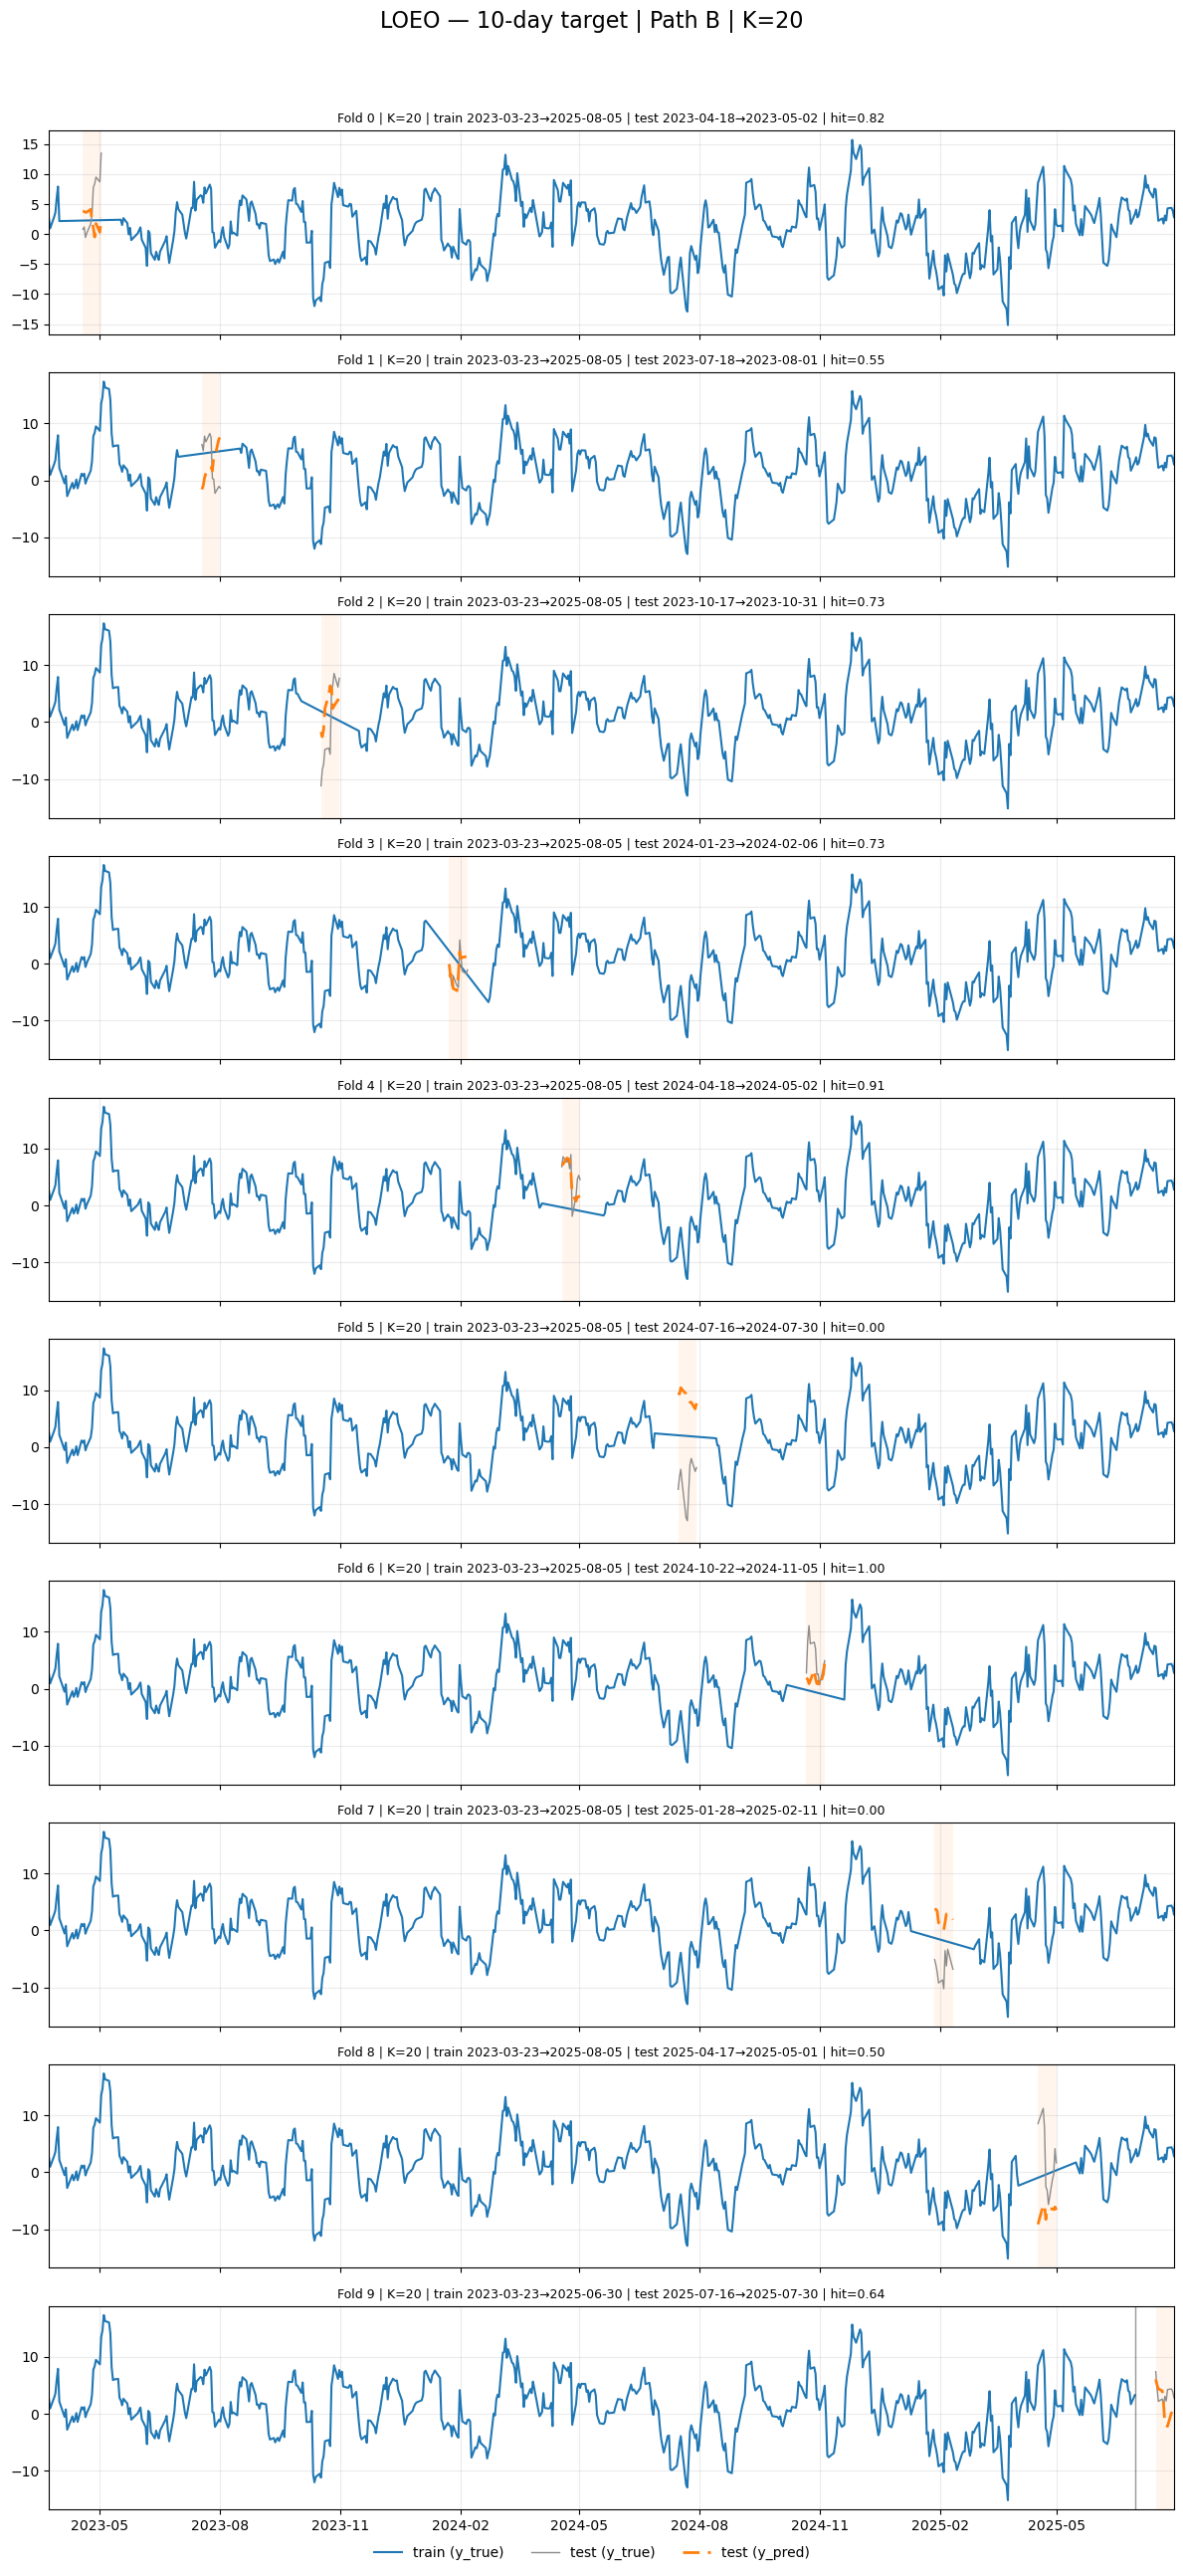

In [152]:
# Define a lightweight wrapper for fold-level training:
#   - By default, calls the tuned XGB booster (_tuned_xgb_for_fold)
#   - If unavailable, falls back to a quick XGB inside the plotting function
try:
    fit_fn_tuned = lambda Xtr, ytr, Xte: _tuned_xgb_for_fold(Xtr, ytr).predict(Xte)
except NameError:
    fit_fn_tuned = None  # fallback to quick XGB inside the plotter

# Plot LOEO fold-by-fold results:
#   - One panel per earnings fold
#   - Shaded region = test window
#   - Ridge top-K features applied per fold
#   - Tuned booster predictions (or fallback quick XGB if fit_fn_tuned=None)
plot_folds_overlay_stacked_hybrid(
    dfm=loeo["dfm_final"],
    splits=loeo["splits"],                     # aligned LOEO (train_idx, test_idx)
    target_col=loeo["target_col"],
    ridge_rankings=loeo["ridge_rankings"],     # per-fold Ridge rankings
    K=loeo["BEST_K"],                          # e.g., 20
    fit_fn=fit_fn_tuned,                       # uses tuned model; set None to use quick XGB
    title=f"LOEO — {loeo['params']['H']}-day target | Path {loeo['params']['path']} | K={loeo['BEST_K']}",
    normalize_xlim=True,
    shade_test=True
)


In [153]:
# Table view: dates & sizes for all folds (plus metrics)
dates = loeo["dfm_final"].index
rows = []
for i, (tr_idx, te_idx) in enumerate(loeo["splits"]):
    trd = dates[np.asarray(tr_idx)]
    ted = dates[np.asarray(te_idx)]
    rows.append({
        "fold": i,
        "train_start": trd[0].date(), "train_end": trd[-1].date(),
        "test_start":  ted[0].date(), "test_end":  ted[-1].date(),
        "n_train_days": len(tr_idx),
        "n_test_days":  len(te_idx),
        "K_used":       int(loeo["metrics"].loc[i, "K_used"]) if "K_used" in loeo["metrics"].columns else loeo["BEST_K"]
    })
spans = pd.DataFrame(rows).set_index("fold")

# join with per-fold metrics
m = loeo["metrics"].copy()
out = spans.join(m[["hit","spearman","strat_ret"]], how="left")
display(out.round(3))

train_start   train_end  test_start    test_end  n_train_days  \
fold                                                                 
0     2023-03-23  2025-08-05  2023-04-18  2023-05-02           563   
1     2023-03-23  2025-08-05  2023-07-18  2023-08-01           563   
2     2023-03-23  2025-08-05  2023-10-17  2023-10-31           563   
3     2023-03-23  2025-08-05  2024-01-23  2024-02-06           563   
4     2023-03-23  2025-08-05  2024-04-18  2024-05-02           563   
5     2023-03-23  2025-08-05  2024-07-16  2024-07-30           563   
6     2023-03-23  2025-08-05  2024-10-22  2024-11-05           563   
7     2023-03-23  2025-08-05  2025-01-28  2025-02-11           563   
8     2023-03-23  2025-08-05  2025-04-17  2025-05-01           564   
9     2023-03-23  2025-06-30  2025-07-16  2025-07-30           569   

      n_test_days  K_used    hit  spearman  strat_ret  
fold                                                   
0              11      20  0.818    -0.627      4.600  
1              11      20  0.545    -0.600      2.900  
2              11      20  0.727     0.455      2.350  
3              11      20  0.727     0.791      0.229  
4              11      20  0.909     0.664      5.531  
5              11      20  0.000    -0.409     -6.267  
6              11      20  1.000     0.245      5.436  
7              11      20  0.000     0.573     -6.579  
8              10      20  0.500     0.227      0.000  
9              11      20  0.636     0.209      3.819

In [154]:
# Inspect the top-K features actually used in each fold
K = loeo["BEST_K"]
for i, rr in enumerate(loeo["ridge_rankings"]):
    print(f"\nFold {i} — top-{K} features:")
    print(rr[:K])


Fold 0 — top-20 features:
['reported_eps_googl_gz__decay_h5', 'revenue_million_googl_gz__decay_h5', 'revenue_million_googl_gz__gate_earnings_date_5d_googl_dec_h5', 'cpi_yoy__decay_h7', 'estimated_eps_googl_gz__decay_h5', 'gdp_gz__decay_h15', 'reported_eps_googl_gz__gate_earnings_date_5d_googl_dec_h5', 'reported_eps_googl_gz__gate_earnings_date_5d_googl', 'revenue_million_googl_gz__gate_earnings_date_5d_googl', 'debt_service_ratio_gz__gate_dsr_event_5d', 'cpi_mom__gate_event_5d', 'cpi_mom__decay_h7', 'beta_sp_60d_googl_z', 'revenue_million_googl_gz', 'gdp_gz__gate_event_5d_dec_h15', 'cpi_mom__gate_event_5d_dec_h7', 'macd_googl_z', 'imports_yoy_gz', 'gdp_gz__gate_event_5d', 'estimated_eps_googl_gz__gate_earnings_date_2d_googl_dec_h5']

Fold 1 — top-20 features:
['revenue_million_googl_gz__decay_h5', 'reported_eps_googl_gz__decay_h5', 'revenue_million_googl_gz__gate_earnings_date_5d_googl_dec_h5', 'gdp_gz__decay_h15', 'cpi_mom__gate_event_5d_dec_h7', 'gdp_gz__gate_event_5d_dec_h15', 'rep

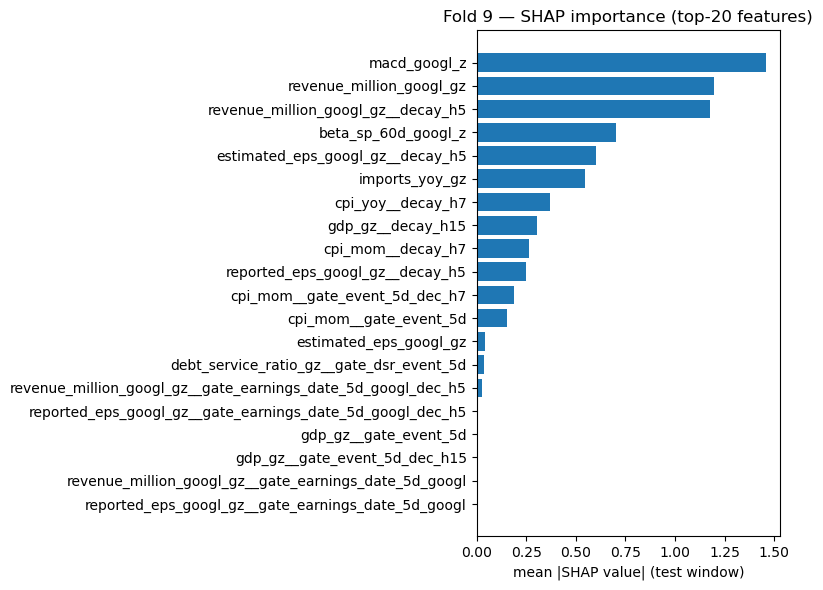

In [155]:
# SHAP on the exact model used (XGB with top-K features)
def shap_importance_last_fold(dfm, splits, target_col, ridge_rankings, K, sample=None):
    """
    SHAP bar chart for Fold (last), using the same top-K features & an XGB model.
    If _tuned_xgb_for_fold exists in your notebook, it is used; else a safe fallback XGB.
    """
    # ---- pick last fold
    fold = len(splits) - 1
    tr_idx, te_idx = map(np.asarray, splits[fold])
    topK = ridge_rankings[fold][:K]

    Xtr = dfm[topK].iloc[tr_idx].values
    ytr = dfm[target_col].iloc[tr_idx].values
    Xte = dfm[topK].iloc[te_idx].values
    yte = dfm[target_col].iloc[te_idx].values

    # ---- model (tuned if available)
    try:
        mdl = _tuned_xgb_for_fold(Xtr, ytr)   # your tuned booster
    except NameError:
        from xgboost import XGBRegressor
        mdl = XGBRegressor(
            n_estimators=500, max_depth=3, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            objective="reg:squarederror", random_state=42, tree_method="hist", verbosity=0
        ).fit(Xtr, ytr)

    # ---- SHAP on test (optionally subsample to speed up)
    try:
        import shap
    except ImportError:
        raise ImportError("pip install shap")

    if (sample is not None) and (Xte.shape[0] > sample):
        rng = np.random.default_rng(42)
        sel = rng.choice(Xte.shape[0], size=sample, replace=False)
        Xexp = Xte[sel]
    else:
        Xexp = Xte

    expl = shap.TreeExplainer(mdl)
    sv = expl.shap_values(Xexp)        # shape: [n_rows, K]
    imp = np.abs(sv).mean(axis=0)      # mean |SHAP| per feature

    order = np.argsort(-imp)
    names = np.array(topK)[order]
    vals  = imp[order]

    # ---- plot
    plt.figure(figsize=(8, max(4, 0.3*len(names))))
    plt.barh(range(len(names)), vals)
    plt.yticks(range(len(names)), names)
    plt.gca().invert_yaxis()
    plt.title(f"Fold {fold} — SHAP importance (top-{K} features)")
    plt.xlabel("mean |SHAP value| (test window)")
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({"feature": names, "mean_abs_shap": vals})

# call it
_ = shap_importance_last_fold(
    dfm=loeo["dfm_final"],
    splits=loeo["splits"],
    target_col=loeo["target_col"],
    ridge_rankings=loeo["ridge_rankings"],
    K=loeo["BEST_K"],     # = 20 in your run
    sample=None           # or e.g. 256 to speed up
)


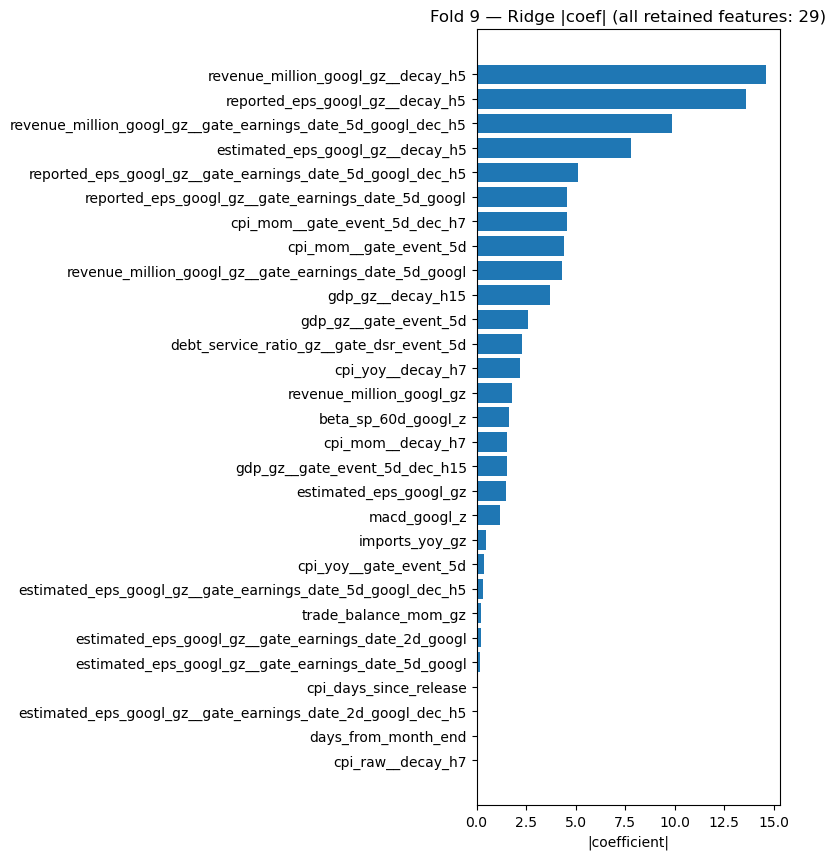

In [157]:
# Ridge absolute coefficients on all retained features (same fold)
# showing the magnitude of Ridge coefficients fitted on last Fold-train using the full retained set
# plotting |coef| gives a clean “global” view beyond the final top-K.
def ridge_coef_last_fold_all_features(dfm, splits, target_col, alphas=np.logspace(-4,3,20)):
    fold = len(splits) - 1
    tr_idx, _ = map(np.asarray, splits[fold])

    all_feats = [c for c in dfm.columns if c != target_col]
    Xtr = dfm[all_feats].iloc[tr_idx].values
    ytr = dfm[target_col].iloc[tr_idx].values

    ridge = RidgeCV(alphas=alphas).fit(Xtr, ytr)
    imp = np.abs(ridge.coef_)
    order = np.argsort(-imp)
    names = np.array(all_feats)[order]
    vals  = imp[order]

    plt.figure(figsize=(8, max(4, 0.3*len(names))))
    plt.barh(range(len(names)), vals)
    plt.yticks(range(len(names)), names)
    plt.gca().invert_yaxis()
    plt.title(f"Fold {fold} — Ridge |coef| (all retained features: {len(all_feats)})")
    plt.xlabel("|coefficient|")
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({"feature": names, "abs_coef": vals})

# call it
_ = ridge_coef_last_fold_all_features(
    dfm=loeo["dfm_final"],
    splits=loeo["splits"],
    target_col=loeo["target_col"]
)


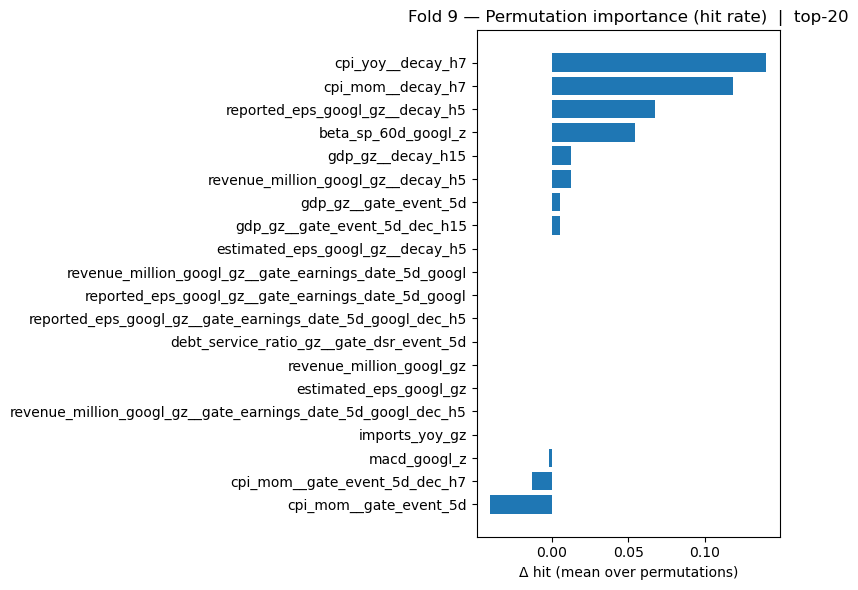

In [158]:
# Permutation importance on the test window (hit-rate scorer)
# Showing for the last fold test set, how much the hit rate drops when each feature is randomly permuted.
# tied to the classification-style objective (sign accuracy) on the actual hold-out.
def perm_importance_last_fold_hit(dfm, splits, target_col, ridge_rankings, K, n_repeats=50, random_state=42):
    fold = len(splits) - 1
    tr_idx, te_idx = map(np.asarray, splits[fold])
    topK = ridge_rankings[fold][:K]

    Xtr = dfm[topK].iloc[tr_idx].values
    ytr = dfm[target_col].iloc[tr_idx].values
    Xte = dfm[topK].iloc[te_idx].values
    yte = dfm[target_col].iloc[te_idx].values

    # model (tuned if available)
    try:
        mdl = _tuned_xgb_for_fold(Xtr, ytr)
    except NameError:
        from xgboost import XGBRegressor
        mdl = XGBRegressor(
            n_estimators=500, max_depth=3, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            objective="reg:squarederror", random_state=42, tree_method="hist", verbosity=0
        ).fit(Xtr, ytr)

    # custom scorer: hit rate
    def hit_scorer(estimator, X, y):
        yhat = estimator.predict(X)
        return float((np.sign(yhat) == np.sign(y)).mean())

    r = permutation_importance(
        mdl, Xte, yte, scoring=hit_scorer,
        n_repeats=n_repeats, random_state=random_state, n_jobs=1
    )

    order = np.argsort(-r.importances_mean)
    names = np.array(topK)[order]
    vals  = r.importances_mean[order]

    plt.figure(figsize=(8, max(4, 0.3*len(names))))
    plt.barh(range(len(names)), vals)
    plt.yticks(range(len(names)), names)
    plt.gca().invert_yaxis()
    plt.title(f"Fold {fold} — Permutation importance (hit rate)  |  top-{K}")
    plt.xlabel("Δ hit (mean over permutations)")
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({"feature": names, "delta_hit": vals})

# call it
_ = perm_importance_last_fold_hit(
    dfm=loeo["dfm_final"],
    splits=loeo["splits"],
    target_col=loeo["target_col"],
    ridge_rankings=loeo["ridge_rankings"],
    K=loeo["BEST_K"],    # 20
    n_repeats=50
)


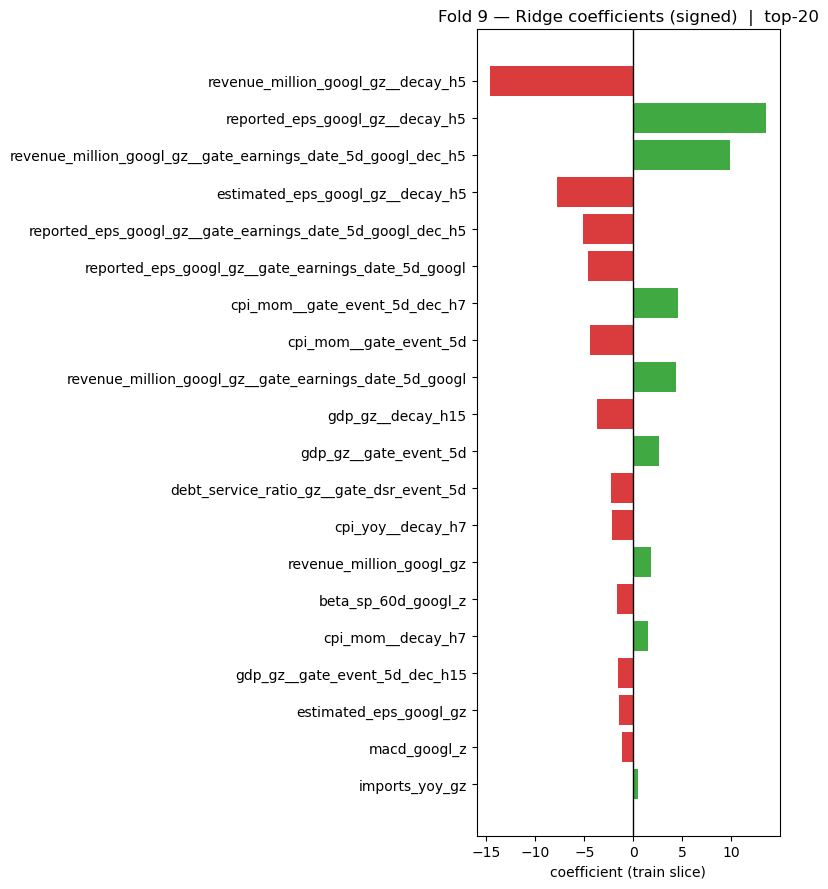

In [159]:
# Create a table + plat of Ridge signed coef
def ridge_signed_table_for_fold(loeo, fold=9, top_n=20, plot=True):
    """
    loeo: dict returned by run_loeo_full(...)
    fold: which LOEO fold to inspect (0-based)
    top_n: how many features to display (by |coef|)
    plot: draw a signed horizontal bar chart if True
    """
    dfm = loeo["dfm_final"]
    target_col = loeo["target_col"]
    splits = loeo["splits"]
    tr_idx, te_idx = splits[fold]

    # Train slice
    Xtr = dfm.drop(columns=[target_col]).iloc[tr_idx].values
    ytr = dfm[target_col].iloc[tr_idx].values
    feat_names = dfm.drop(columns=[target_col]).columns.tolist()

    # Fit Ridge on this fold's train
    ridge = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
    coefs = pd.Series(ridge.coef_, index=feat_names, name="coef")

    # Signed & ranked table
    tab = pd.DataFrame({
        "feature": coefs.index,
        "coef": coefs.values,
        "|coef|": np.abs(coefs.values),
        "sign": np.sign(coefs.values).astype(int)
    }).sort_values("|coef|", ascending=False).reset_index(drop=True)

    # Add simple family tags (optional, tweak as you like)
    def tag(f):
        s = f.lower()
        if "eps" in s or "revenue" in s: return "Earnings"
        if "cpi" in s: return "CPI"
        if "gdp" in s: return "GDP"
        if "dsr" in s: return "DSR"
        if "beta_sp" in s or "macd" in s: return "Risk/State"
        return "Other"
    tab["family"] = tab["feature"].map(tag)

    # Display top_n rows nicely
    display(tab.head(top_n).style.format({"coef":"{:+.4f}", "|coef|":"{:.4f}"}))

    if plot:
        top = tab.head(top_n).iloc[::-1]  # plot bottom->top
        colors = np.where(top["coef"]>=0, "#2ca02c", "#d62728")  # green=+, red=-
        plt.figure(figsize=(8, 0.45*len(top)))
        plt.barh(top["feature"], top["coef"], color=colors, alpha=0.9)
        plt.axvline(0, color="k", lw=1)
        plt.title(f"Fold {fold} — Ridge coefficients (signed)  |  top-{top_n}")
        plt.xlabel("coefficient (train slice)")
        plt.tight_layout()
        plt.show()

    return tab

# === run it for Fold 9 ===
ridge_signed_F9 = ridge_signed_table_for_fold(loeo, fold=9, top_n=20, plot=True)

# save full signed table to CSV for the report
ridge_signed_F9.to_csv("ridge_signed_coefficients_fold9.csv", index=False)


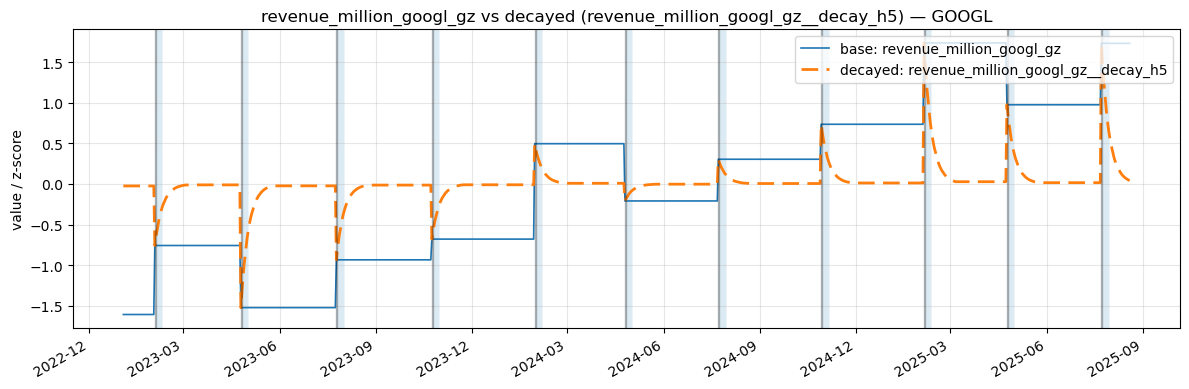

In [160]:
# --- Feature behavior around earnings (gated + decayed signals) ---
# This helper plots a base feature (e.g., reported revenue) alongside its 
# decayed version, with earnings event days clearly marked.
# Purpose:
#   • Show how the raw/gated feature “lights up” exactly at earnings events
#   • Show how the decayed version extends signal influence into the days 
#     following the event (0–5 business-day window shaded)
#   • Provide intuition for why gating/decay engineering helps the model 
#     capture both immediate event shocks and short-lived after-effects

def _get_dates(df, name="df"):
    if isinstance(df.index, pd.DatetimeIndex):
        return df.index
    if "date" in df.columns:
        return pd.DatetimeIndex(pd.to_datetime(df["date"].values), name="date")
    raise TypeError(f"{name}: need a DatetimeIndex OR a 'date' column.")

def plot_feature_with_events(df, feature_decayed,
                             base_feature=None,
                             tkr="googl",
                             anchor_cols=("days_since_earnings_trading_{t}",
                                          "days_since_earnings_{t}"),
                             shade_gate=True):
    """
    Visualize a decayed feature vs its base around earnings.
    Works with DatetimeIndex or with a 'date' column.
    """
    dates = _get_dates(df, "df")

    # 1) find days-since-earnings column
    t = tkr.lower()
    cand = [c.format(t=t) for c in anchor_cols]
    anchor_col = next((c for c in cand if c in df.columns), None)
    if anchor_col is None:
        raise KeyError(f"No earnings anchor column found. Looked for: {cand}")

    # 2) infer base feature if not provided (strip the __decay_h5 suffix)
    if base_feature is None:
        base_feature = (feature_decayed
                        .replace("__decay_h5", "")
                        .replace("__dec_h5", ""))
        if base_feature not in df.columns:
            raise KeyError("Please pass base_feature=... explicitly.")

    # 3) pull series
    s_base   = pd.to_numeric(df[base_feature], errors="coerce")
    s_decay  = pd.to_numeric(df[feature_decayed], errors="coerce")
    days     = pd.to_numeric(df[anchor_col], errors="coerce").astype("Int64")

    # 4) event days & 0–5b windows
    # Some datasets mark event at 0, some at 1; accept either.
    event_mask = days.eq(0) | days.eq(1)
    event_days = dates[event_mask.fillna(False)]

    windows = []
    for d0 in event_days:
        lo = d0
        hi = d0 + pd.tseries.offsets.BDay(5)   # 0–5 business days
        windows.append((lo, hi))

    # 5) plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(dates, s_base, lw=1.2, label=f"base: {base_feature}")
    ax.plot(dates, s_decay, lw=2.0, linestyle=(0, (6, 3)),
            label=f"decayed: {feature_decayed}")

    # vertical lines at events + optional shaded 0–5b gate window
    for d0 in event_days:
        ax.axvline(d0, lw=1, color="k", alpha=0.25)
    if shade_gate:
        for lo, hi in windows:
            ax.axvspan(lo, hi, alpha=0.08)

    ax.set_title(f"{base_feature} vs decayed ({feature_decayed}) — {tkr.upper()}")
    ax.set_ylabel("value / z-score")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

plot_feature_with_events(
    df=wide_map["googl"],
    feature_decayed="revenue_million_googl_gz__decay_h5",
    base_feature="revenue_million_googl_gz",
    tkr="googl"
)

In [163]:
# adding two diagnostics:
# (1) Sign-consistency across folds (how often each feature’s Ridge coefficient has the same sign). (in this cell)
# (2) “Gated vs Decayed” paired comparison (exploring, for the same base signal, which variant carries more 
#      weight across folds). (See Later on)

# --- ridge_fold_coefs ---
# For each LOEO fold:
#   - Fit Ridge regression on the training slice only.
#   - Record coefficients for all (or top-K) features, with both raw and absolute values.
#   - Also record the coefficient *sign* (+1 / -1 / 0).
# Returns a tidy DataFrame that tracks how each feature behaves across folds,
# enabling analysis of directional stability (whether a feature is consistently positive/negative).
def ridge_fold_coefs(loeo, use_topK=None, standardize=True):
    """
    Return a tidy DataFrame of Ridge coefficients per LOEO fold on the *training slice*.
    Columns: fold, feature, coef, |coef|, sign (+1/-1/0)
    - Fits one Ridge per fold on the TRAIN part only.
    - If use_topK is provided (int), each fold uses that fold's top-K features
      from loeo["ridge_rankings"]; otherwise fits on all dfm_final features.
    - Standardizes X on the train slice (positive scaling → sign preserved).
    """
    dfm   = loeo["dfm_final"]
    y_all = dfm[loeo["target_col"]].values
    splits = loeo["splits"]
    rankings = loeo["ridge_rankings"]

    # feature universe (dfm_final columns minus target)
    all_feats = [c for c in dfm.columns if c != loeo["target_col"]]

    rows = []
    for i, (tr_idx, te_idx) in enumerate(splits):
        tr_idx = np.asarray(tr_idx)
        # pick features for this fold
        if use_topK is None:
            feats = all_feats
        else:
            feats = rankings[i][:min(use_topK, len(rankings[i]))]
        Xtr = dfm[feats].iloc[tr_idx].values
        ytr = y_all[tr_idx]

        if standardize:
            scaler = StandardScaler().fit(Xtr)
            Xtr = scaler.transform(Xtr)

        mdl = RidgeCV(alphas=np.logspace(-4, 3, 20)).fit(Xtr, ytr)
        coefs = pd.Series(mdl.coef_, index=feats)

        for f, v in coefs.items():
            s = 0
            if v > 0: s = 1
            elif v < 0: s = -1
            rows.append({"fold": i, "feature": f, "coef": float(v), "|coef|": float(abs(v)), "sign": int(s)})

    return pd.DataFrame(rows)

# --- 2) sign_consistency_table ---
# Aggregates the fold-level Ridge coefficients into a feature-level summary:
#   - Counts how often each feature is positive, negative, or zero across folds.
#   - Computes a sign_consistency score = max(pos, neg) / (pos+neg), 
#     i.e. the fraction of times a feature points in the same direction when it matters.
#   - Also reports mean absolute coefficient size and mean coefficient.
# Filters out features seen in fewer than `min_folds` folds, then sorts by stability and magnitude.
# Returns a ranked table of the most consistently directional and influential features.
def sign_consistency_table(coefs_df, min_folds=3):
    """
    Aggregate coefficient signs across folds.
    Returns: feature, n_folds_used, pos, neg, zero, sign_consistency, mean_|coef|, mean_coef
    sign_consistency = max(pos, neg) / (pos+neg)  (ignores zeros)
    """
    g = coefs_df.groupby("feature")
    out = g.apply(lambda d: pd.Series({
        "n_folds_used": int(len(d)),
        "pos": int((d["sign"]== 1).sum()),
        "neg": int((d["sign"]==-1).sum()),
        "zero": int((d["sign"]== 0).sum()),
        "sign_consistency": (max((d["sign"]==1).sum(), (d["sign"]==-1).sum()) /
                             max(1, ((d["sign"]!=0).sum()))),
        "mean_|coef|": float(d["|coef|"].mean()),
        "mean_coef": float(d["coef"].mean())
    })).reset_index()

    out = out[out["n_folds_used"] >= min_folds].copy()
    out.sort_values(["sign_consistency", "mean_|coef|"], ascending=[False, False], inplace=True)
    return out


# --- RUN (fast) ---
coefs = ridge_fold_coefs(loeo, use_topK=loeo["BEST_K"], standardize=True)
consistency = sign_consistency_table(coefs, min_folds=3)
display(consistency.head(20))


C:\Users\shara\AppData\Local\Temp\ipykernel_35096\2563943031.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda d: pd.Series({


feature  n_folds_used   pos  \
17                    reported_eps_googl_gz__decay_h5          10.0  10.0   
21                 revenue_million_googl_gz__decay_h5          10.0   0.0   
0                                 beta_sp_60d_googl_z          10.0   0.0   
23  revenue_million_googl_gz__gate_earnings_date_5...          10.0  10.0   
7                    estimated_eps_googl_gz__decay_h5          10.0   0.0   
12                                  gdp_gz__decay_h15          10.0   0.0   
20                           revenue_million_googl_gz          10.0  10.0   
16                                       macd_googl_z          10.0   0.0   
3                       cpi_mom__gate_event_5d_dec_h7           9.0   9.0   
18  reported_eps_googl_gz__gate_earnings_date_5d_g...          10.0   0.0   
19  reported_eps_googl_gz__gate_earnings_date_5d_g...           9.0   0.0   
4                                   cpi_yoy__decay_h7          10.0   0.0   
5            debt_service_ratio_gz__gate_dsr_event_5d          10.0   0.0   
22  revenue_million_googl_gz__gate_earnings_date_5...          10.0  10.0   
2                              cpi_mom__gate_event_5d          10.0   0.0   
14                      gdp_gz__gate_event_5d_dec_h15          10.0   9.0   
1                                   cpi_mom__decay_h7           9.0   1.0   
15                                     imports_yoy_gz           6.0   1.0   
13                              gdp_gz__gate_event_5d           9.0   2.0   
6                              estimated_eps_googl_gz           3.0   1.0   

     neg  zero  sign_consistency  mean_|coef|  mean_coef  
17   0.0   0.0          1.000000     2.447204   2.447204  
21  10.0   0.0          1.000000     2.375559  -2.375559  
0   10.0   0.0          1.000000     1.750946  -1.750946  
23   0.0   0.0          1.000000     1.743223   1.743223  
7   10.0   0.0          1.000000     1.707657  -1.707657  
12  10.0   0.0          1.000000     1.573563  -1.573563  
20   0.0   0.0          1.000000     1.442797   1.442797  
16  10.0   0.0          1.000000     1.271765  -1.271765  
3    0.0   0.0          1.000000     1.017646   1.017646  
18  10.0   0.0          1.000000     0.967706  -0.967706  
19   9.0   0.0          1.000000     0.745402  -0.745402  
4   10.0   0.0          1.000000     0.734264  -0.734264  
5   10.0   0.0          1.000000     0.683133  -0.683133  
22   0.0   0.0          1.000000     0.637923   0.637923  
2   10.0   0.0          1.000000     0.485922  -0.485922  
14   1.0   0.0          0.900000     0.757082   0.710537  
1    8.0   0.0          0.888889     0.443041  -0.380962  
15   5.0   0.0          0.833333     0.581550  -0.532174  
13   7.0   0.0          0.777778     0.316450  -0.184934  
6    2.0   0.0          0.666667     0.560828  -0.062618

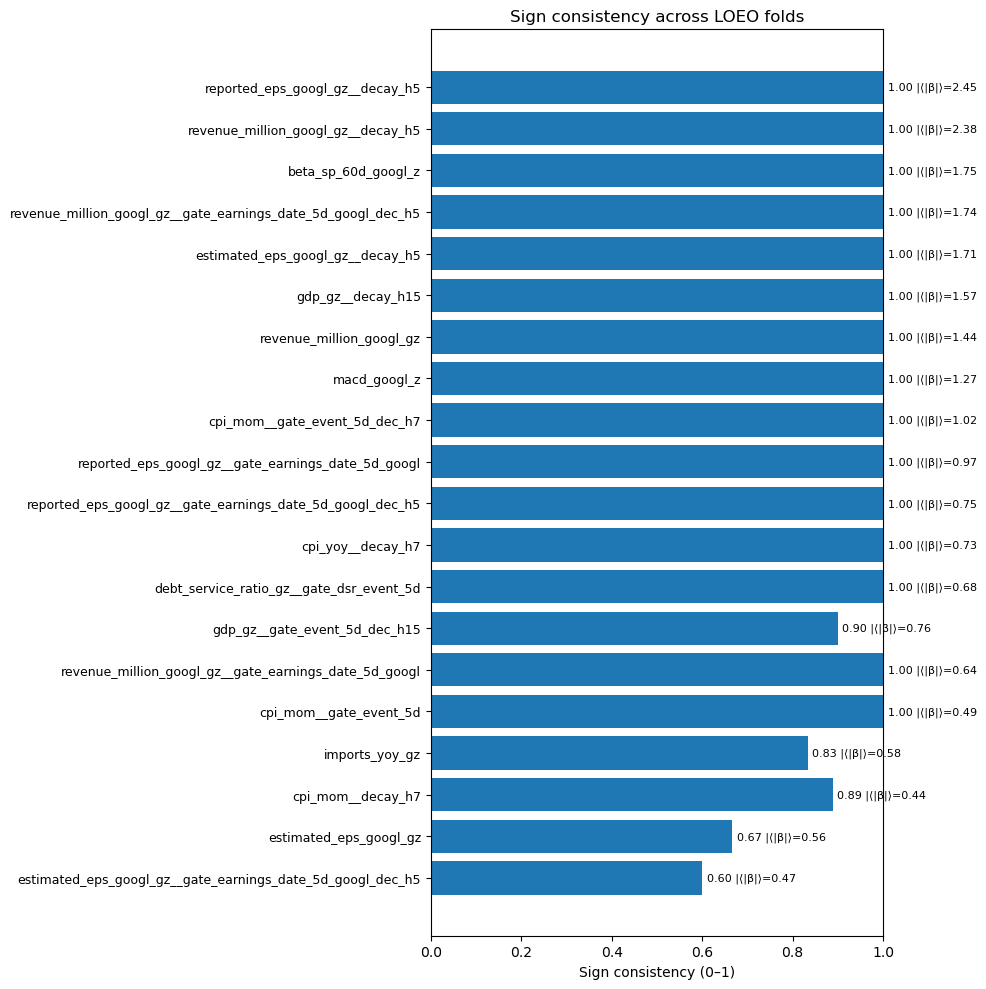

In [164]:
# bar plot (top-N by consistency × magnitude)
def plot_sign_consistency_bars(consistency, top_n=20, title="Sign consistency across LOEO folds"):
    df = consistency.copy()
    df["score"] = df["sign_consistency"] * df["mean_|coef|"]
    df = df.sort_values("score", ascending=False).head(top_n)
    labels = df["feature"].tolist()
    y = df["sign_consistency"].values

    fig, ax = plt.subplots(figsize=(10, 0.45*len(df)+1))
    ax.barh(range(len(df)), y)
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(labels, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlim(0, 1.0)
    ax.set_xlabel("Sign consistency (0–1)")
    ax.set_title(title)
    for i, (v, mag) in enumerate(zip(y, df["mean_|coef|"].values)):
        ax.text(v+0.01, i, f"{v:.2f} |⟨|β|⟩={mag:.2f}", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_sign_consistency_bars(consistency, top_n=20)


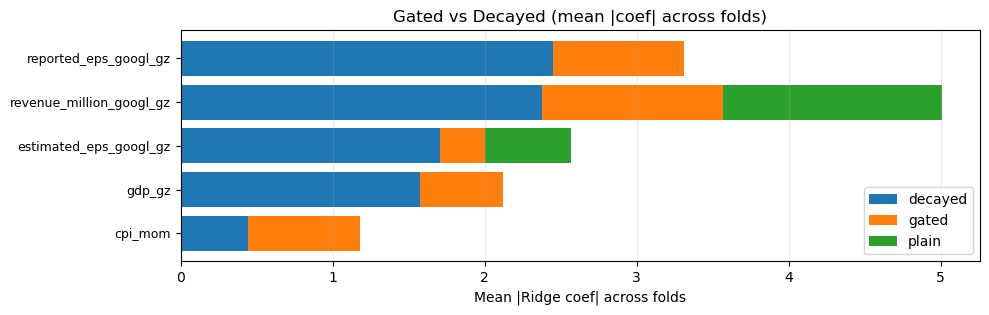

In [165]:
# “Gated vs Decayed” pairs (same base signal, different wrappers)
# step 1: parsing feature names into base (e.g., reported_eps_googl_gz) and flags (contains __gate_… and/or __decay_h…).
# step 2: compare average absolute coefficients across folds for each variant.

# parse_variant
# Purpose: Normalize feature names into a (base, variant) pair so we can compare
#          "plain" vs "gated" vs "decayed" vs "gated+decayed" versions of the same signal.
# Input:  feature_name like "reported_eps_googl_gz__gate_earnings_date_5d_googl_dec_h5"
# Output: (base, kind) → ("reported_eps_googl_gz", "gated+decayed")
def parse_variant(feature_name):
    """
    Split 'base__gate_xxx__decay_h5' → base='...', gated=True/False, decayed=True/False
    """
    parts = feature_name.split("__")
    base = parts[0]
    gated  = any("gate"  in p for p in parts[1:])
    decayed= any("decay" in p for p in parts[1:])
    if gated and decayed: kind = "gated+decayed"
    elif gated:           kind = "gated"
    elif decayed:         kind = "decayed"
    else:                 kind = "plain"
    return base, kind

# gated_decayed_summary
# Purpose: For each base signal, summarize how strong each variant (plain/gated/decayed/gated+decayed)
#          is across LOEO folds using Ridge coefficients from `coefs_df`.
# What it does:
#   1) Parses feature names into (base, kind) via parse_variant().
#   2) Groups by (base, kind) and computes:
#        - n: number of fold-coefficients observed
#        - mean_abs_coef: average |coef| (strength proxy)
#        - mean_coef: average signed coef (directional tendency)
#   3) Keeps only bases that appear in at least `min_folds` observations to avoid noise.
# Output: tidy summary table to drive comparisons/plots.
def gated_decayed_summary(coefs_df, min_folds=3):
    tmp = coefs_df.copy()
    tmp[["base","kind"]] = tmp["feature"].apply(lambda x: pd.Series(parse_variant(x)))
    g = tmp.groupby(["base","kind"])
    agg = g.agg(n=("coef","size"),
                mean_abs_coef=("|coef|","mean"),
                mean_coef=("coef","mean")).reset_index()
    # keep bases that appear in >= min_folds across any variant
    bases_keep = tmp.groupby("base").agg(n=("coef","size")).query("n >= @min_folds").index
    agg = agg[agg["base"].isin(bases_keep)].copy()
    return agg

def plot_gated_vs_decayed_pairs(agg, top_n=12, title="Gated vs Decayed (mean |coef| across folds)"):
    # focus on bases that have at least two kinds (so they can be “paired” visually)
    counts = agg.groupby("base")["kind"].nunique()
    bases = counts[counts >= 2].index
    subset = agg[agg["base"].isin(bases)].copy()

    # score bases by max variant strength
    base_score = subset.groupby("base")["mean_abs_coef"].max().sort_values(ascending=False).head(top_n).index
    subset = subset[subset["base"].isin(base_score)]

    # pivot: rows = base, cols = kind
    pivot = subset.pivot_table(index="base", columns="kind", values="mean_abs_coef", aggfunc="mean").fillna(0.0)

    order = pivot.max(axis=1).sort_values(ascending=True).index  # smallest at top for barh
    pivot = pivot.loc[order]

    fig, ax = plt.subplots(figsize=(10, 0.45*len(pivot)+1))
    left = np.zeros(len(pivot))
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#7f7f7f"]  # decayed, gated, gated+decayed, plain
    col_order = [c for c in ["decayed","gated","gated+decayed","plain"] if c in pivot.columns]

    # stacked bars (each variant side-by-side via stacked = False would be messy; stacked shows composition)
    width = 0.8
    for ci, col in enumerate(col_order):
        ax.barh(range(len(pivot)), pivot[col].values, left=left, label=col, height=width)
        left += pivot[col].values

    ax.set_yticks(range(len(pivot)))
    ax.set_yticklabels(pivot.index, fontsize=9)
    ax.set_xlabel("Mean |Ridge coef| across folds")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True, axis="x", alpha=0.25)
    plt.tight_layout()
    plt.show()

# --- RUN (fast) ---
agg_pairs = gated_decayed_summary(coefs, min_folds=3)
plot_gated_vs_decayed_pairs(agg_pairs, top_n=12)


## LOEO daily predictions

In [167]:
# loeo_daily_predictions_table
# Build a per-day LOEO test table: one row per test date with y_true, y_pred, hit (0/1),
# and daily_strat_ret = y_true * sign(y_pred). Repeats fold-level hit/Spearman on each row
# for easy slicing. Uses each fold’s Ridge top-K features (K = loeo["BEST_K"]) and fits a
# tuned XGB per fold by default (fallback to a small XGB/Ridge if unavailable).
def loeo_daily_predictions_table(loeo, use_tuned=True):
    """
    Build a per-day table of predictions/metrics for every LOEO test day.

    Columns:
      fold, date, y_true, y_pred, hit (0/1), daily_strat_ret (y_true*sign(y_pred)),
      k_used, spearman_fold, hit_fold
    """
    dfm   = loeo["dfm_final"]
    y_all = dfm[loeo["target_col"]].values
    dates = dfm.index
    splits = loeo["splits"]
    ridge_rankings = loeo["ridge_rankings"]
    K = int(loeo["BEST_K"])

    # fold-level summary we already computed
    # (if your loeo["metrics"] is a DataFrame with one row per fold)
    fold_metrics = loeo.get("metrics", None)
    if isinstance(fold_metrics, pd.DataFrame):
        # standardize expected column names
        # try common variants
        fm = fold_metrics.copy()
        rename_map = {}
        for src, dst in [("spearman","spearman"), ("rho","spearman"),
                         ("hit","hit"), ("hit_mean","hit")]:
            if src in fm.columns and dst not in fm.columns:
                rename_map[src] = dst
        if rename_map:
            fm = fm.rename(columns=rename_map)
    else:
        fm = None

    # model factory
    def _fallback_model():
        try:
            from xgboost import XGBRegressor
            return XGBRegressor(
                n_estimators=500, max_depth=3, learning_rate=0.05,
                subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
                objective="reg:squarederror", random_state=42, tree_method="hist", verbosity=0
            )
        except Exception:
            from sklearn.linear_model import RidgeCV
            return RidgeCV(alphas=np.logspace(-4, 3, 20))

    rows = []
    for i, (tr_idx, te_idx) in enumerate(tqdm(splits, desc="LOEO folds", unit="fold")):
        topK_cols = ridge_rankings[i][:K]
        Xtr = dfm[topK_cols].iloc[np.asarray(tr_idx)].values
        ytr = y_all[np.asarray(tr_idx)]
        Xte = dfm[topK_cols].iloc[np.asarray(te_idx)].values
        yte = y_all[np.asarray(te_idx)]
        dte = dates[np.asarray(te_idx)]

        # choose tuned booster if available
        if use_tuned and "_tuned_xgb_for_fold" in globals():
            mdl = _tuned_xgb_for_fold(Xtr, ytr)
            yhat = np.asarray(mdl.predict(Xte)).reshape(-1)
        else:
            mdl = _fallback_model()
            mdl.fit(Xtr, ytr)
            yhat = np.asarray(mdl.predict(Xte)).reshape(-1)

        hit_daily = (np.sign(yhat) == np.sign(yte)).astype(int)
        strat_daily = yte * np.sign(yhat)

        # fold-level stats (repeat on each row for convenience)
        spearman_fold = np.nan
        hit_fold = np.nan
        if fm is not None and i in getattr(fm, "index", []):
            spearman_fold = fm.loc[i, "spearman"] if "spearman" in fm.columns else np.nan
            hit_fold = fm.loc[i, "hit"] if "hit" in fm.columns else np.nan

        for j in range(len(dte)):
            rows.append({
                "fold": i,
                "date": pd.to_datetime(dte[j]),
                "y_true": float(yte[j]),
                "y_pred": float(yhat[j]),
                "hit": int(hit_daily[j]),
                "daily_strat_ret": float(strat_daily[j]),
                "k_used": K,
                "spearman_fold": float(spearman_fold) if np.isfinite(spearman_fold) else np.nan,
                "hit_fold": float(hit_fold) if np.isfinite(hit_fold) else np.nan,
            })

    out = pd.DataFrame(rows).sort_values(["fold","date"]).reset_index(drop=True)
    return out

daily = loeo_daily_predictions_table(loeo, use_tuned=True)

# See everything (one row per test day across all folds)
display(daily)

# Filter a specific fold (e.g., last fold)
display(daily[daily["fold"] == daily["fold"].max()])

# Per-fold hit from the daily rows (sanity-check vs your summary)
print(daily.groupby("fold")["hit"].mean())

# Export if you like
# daily.to_csv("googl_pathB_loeo_daily_predictions.csv", index=False)


LOEO folds: 100%|██████████| 10/10 [13:51<00:00, 83.11s/fold] 


fold       date    y_true    y_pred  hit  daily_strat_ret  k_used  \
0       0 2023-04-18  0.784687  3.852421    1         0.784687      20   
1       0 2023-04-19  1.180660  3.741872    1         1.180660      20   
2       0 2023-04-20 -0.569859  3.617329    0        -0.569859      20   
3       0 2023-04-21  0.151785  3.645394    1         0.151785      20   
4       0 2023-04-24  1.698579  4.115661    1         1.698579      20   
..    ...        ...       ...       ...  ...              ...     ...   
104     9 2025-07-24  2.263624 -1.982831    0        -2.263624      20   
105     9 2025-07-25  4.265455 -2.184213    0        -4.265455      20   
106     9 2025-07-28  4.372208  0.189485    1         4.372208      20   
107     9 2025-07-29  3.877393  0.016107    1         3.877393      20   
108     9 2025-07-30  2.762941 -0.953174    0        -2.762941      20   

     spearman_fold  hit_fold  
0        -0.627273  0.818182  
1        -0.627273  0.818182  
2        -0.627273  0.818182  
3        -0.627273  0.818182  
4        -0.627273  0.818182  
..             ...       ...  
104       0.209091  0.636364  
105       0.209091  0.636364  
106       0.209091  0.636364  
107       0.209091  0.636364  
108       0.209091  0.636364  

[109 rows x 9 columns]

fold       date    y_true    y_pred  hit  daily_strat_ret  k_used  \
98      9 2025-07-16  7.411050  6.073697    1         7.411050      20   
99      9 2025-07-17  4.532080  5.090364    1         4.532080      20   
100     9 2025-07-18  2.199291  4.378453    1         2.199291      20   
101     9 2025-07-21  2.598625  4.040170    1         2.598625      20   
102     9 2025-07-22  1.740358  1.712798    1         1.740358      20   
103     9 2025-07-23  3.080482 -1.820987    0        -3.080482      20   
104     9 2025-07-24  2.263624 -1.982831    0        -2.263624      20   
105     9 2025-07-25  4.265455 -2.184213    0        -4.265455      20   
106     9 2025-07-28  4.372208  0.189485    1         4.372208      20   
107     9 2025-07-29  3.877393  0.016107    1         3.877393      20   
108     9 2025-07-30  2.762941 -0.953174    0        -2.762941      20   

     spearman_fold  hit_fold  
98        0.209091  0.636364  
99        0.209091  0.636364  
100       0.209091  0.636364  
101       0.209091  0.636364  
102       0.209091  0.636364  
103       0.209091  0.636364  
104       0.209091  0.636364  
105       0.209091  0.636364  
106       0.209091  0.636364  
107       0.209091  0.636364  
108       0.209091  0.636364

fold
0    0.818182
1    0.545455
2    0.727273
3    0.727273
4    0.909091
5    0.000000
6    1.000000
7    0.000000
8    0.500000
9    0.636364
Name: hit, dtype: float64


In [169]:
daily.to_csv("googl_pathB_loeo_daily_predictions.csv", index=False)

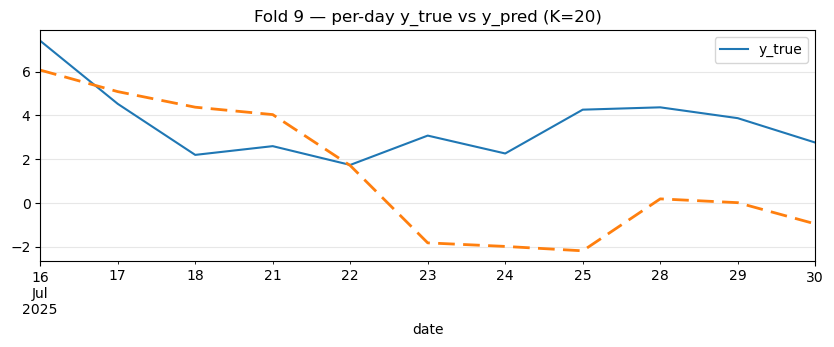

In [168]:
# Visualization of daily predictions - last fold (select fold)
# plotting the day-by-day behavior inside the held-out earnings window
f = daily["fold"].max()  # pick a fold
d = daily[daily["fold"]==f].set_index("date").sort_index()
ax = d[["y_true"]].plot(figsize=(10,3), lw=1.5)
d["y_pred"].plot(ax=ax, lw=2, ls=(0,(6,3)))
ax.set_title(f"Fold {f} — per-day y_true vs y_pred (K={int(d['k_used'].iloc[0])})")
ax.grid(True, alpha=0.3)
plt.show()

In [239]:
# visualizations of daily predictions - all earnings events

# Diagnostic scatterplot of predicted vs. actual returns on LOEO test days.
# Shows whether predictions line up with reality on a 45° line (y=x).
# Includes a "hit rate" in the title: % of times predicted and actual signs match.
def loeo_plot_parity(daily, title="LOEO Parity: Predicted vs Actual"):
    df = daily.dropna(subset=["y_true","y_pred"])
    x = df["y_true"].to_numpy()
    y = df["y_pred"].to_numpy()

    lim = float(np.nanmax(np.abs(np.r_[x, y])))
    lim = float(np.ceil(lim*10)/10) if np.isfinite(lim) else 1.0

    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=10, alpha=0.5)
    plt.plot([-lim, lim], [-lim, lim], lw=2)  # y=x
    plt.xlim(-lim, lim); plt.ylim(-lim, lim)
    hit = float((np.sign(x) == np.sign(y)).mean())
    plt.xlabel("Actual (y_true)")
    plt.ylabel("Predicted (y_pred)")
    plt.title(f"{title}  |  hit={hit:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Time-series view of predictions vs. actuals across all LOEO test days.
# Plots raw series and rolling means; optionally shades each test fold for context.
# Useful to see alignment over time and fold-to-fold consistency.
def loeo_plot_timeline(daily, roll=5, shade_folds=True,
                       title="LOEO: Actual vs Predicted over Time (test days)"):
    df = daily.copy()
    df = df.sort_values("date").set_index("date")  # DatetimeIndex
    fig, ax = plt.subplots(figsize=(12,5))

    ax.plot(df.index, df["y_true"], lw=1, alpha=0.5, label="y_true")
    ax.plot(df.index, df["y_pred"], lw=1, alpha=0.8, label="y_pred")
    ax.plot(df.index, df["y_true"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_true ({roll}d MA)")
    ax.plot(df.index, df["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_pred ({roll}d MA)")

    if shade_folds and "fold" in df.columns:
        for _, g in df.groupby("fold"):
            ax.axvspan(g.index.min(), g.index.max(), alpha=0.05)

    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))

    ax.set_title(title)
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()
# 3) Cumulative “strategy” PnL on traded days (your daily_strat_ret = y_true * sign(y_pred))
import numpy as np
import matplotlib.pyplot as plt

def loeo_plot_cum_pnl(daily, per_fold=True,
                      title_overall="LOEO: Cumulative Strategy PnL (traded days)",
                      title_folds="LOEO: Cumulative PnL by Fold (traded days)"):
    df = daily.copy().sort_values("date")
    # keep only test days (already), and only “traded” rows contribute via daily_strat_ret
    pnl = df["daily_strat_ret"].fillna(0.0).to_numpy()
    cum = np.cumsum(pnl)

    # Overall
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(df["date"], cum, lw=2)
    ax.set_title(title_overall)
    ax.set_ylabel("Cum. PnL")
    ax.grid(True, alpha=0.3)
    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
    fig.tight_layout()
    plt.show()

    if per_fold and "fold" in df.columns:
        # Small multiples per fold
        folds = sorted(df["fold"].unique())
        n = len(folds)
        h = max(2.2, 1.6 * n)  # adaptive height
        fig, axes = plt.subplots(n, 1, figsize=(10, h), sharex=False)
        if n == 1:
            axes = [axes]
        for ax, f in zip(axes, folds):
            g = df[df["fold"] == f].copy()
            g = g.sort_values("date")
            ax.plot(g["date"], np.cumsum(g["daily_strat_ret"].fillna(0.0)), lw=2)
            ax.set_title(f"Fold {f}: {g['date'].min().date()} → {g['date'].max().date()}")
            ax.grid(True, alpha=0.3)
        axes[-1].xaxis.set_major_locator(loc)
        axes[-1].xaxis.set_major_formatter(ConciseDateFormatter(loc))
        fig.suptitle(title_folds, y=1.01, fontsize=12)
        fig.tight_layout()
        plt.show()

# Evaluate strategy realism via cumulative PnL (profit & loss).
# Uses daily_strat_ret (y_true * sign(y_pred)) to simulate a simple "long if predicted >0" rule.
# Produces an overall curve across all folds and (optionally) small multiples per fold.
def loeo_plot_by_relative_day(daily, rel_col="rel_day",
                              title="LOEO: Mean Actual/Predicted by Relative Day"):
    if rel_col not in daily.columns:
        raise ValueError(f"'{rel_col}' not in daily. Provide a relative-day column first.")
    g = daily.groupby(rel_col)[["y_true","y_pred"]].mean().sort_index()
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(g.index, g["y_true"], lw=2, label="y_true (mean)")
    ax.plot(g.index, g["y_pred"], lw=2, label="y_pred (mean)")
    ax.axvline(0, lw=1, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Relative day (event=0)")
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()


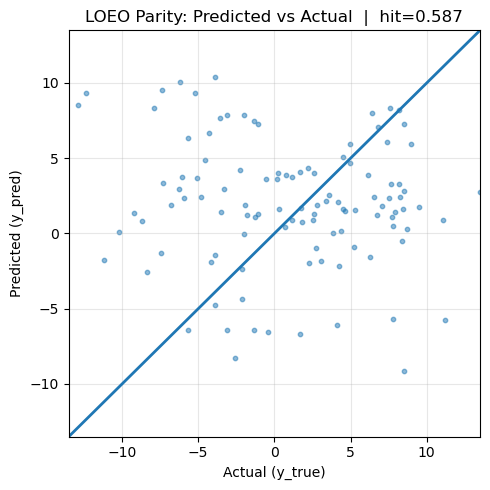

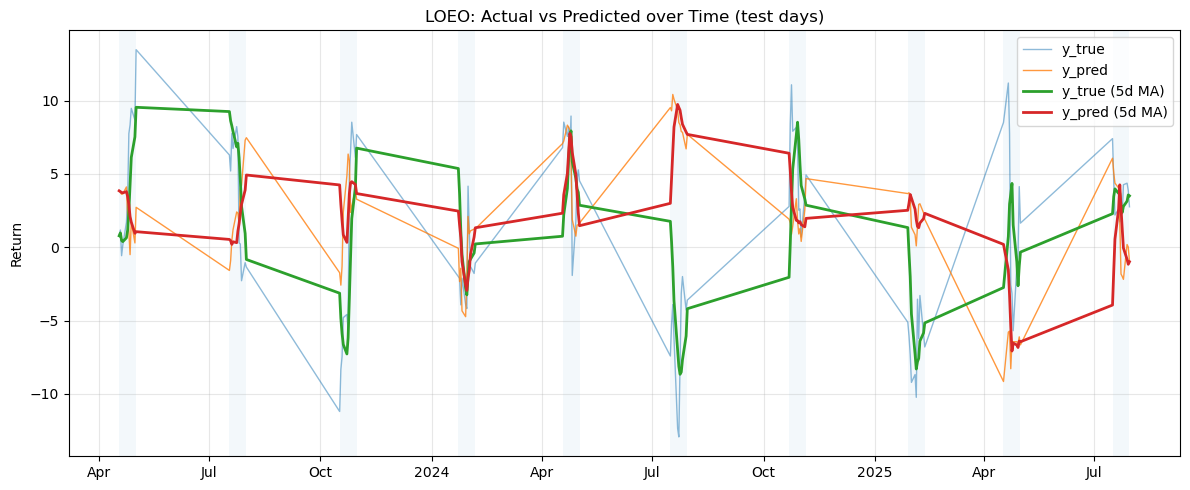

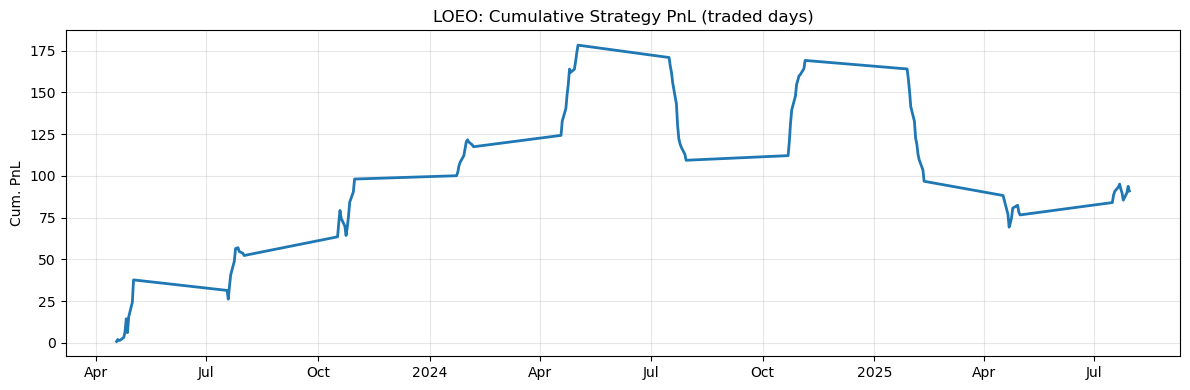

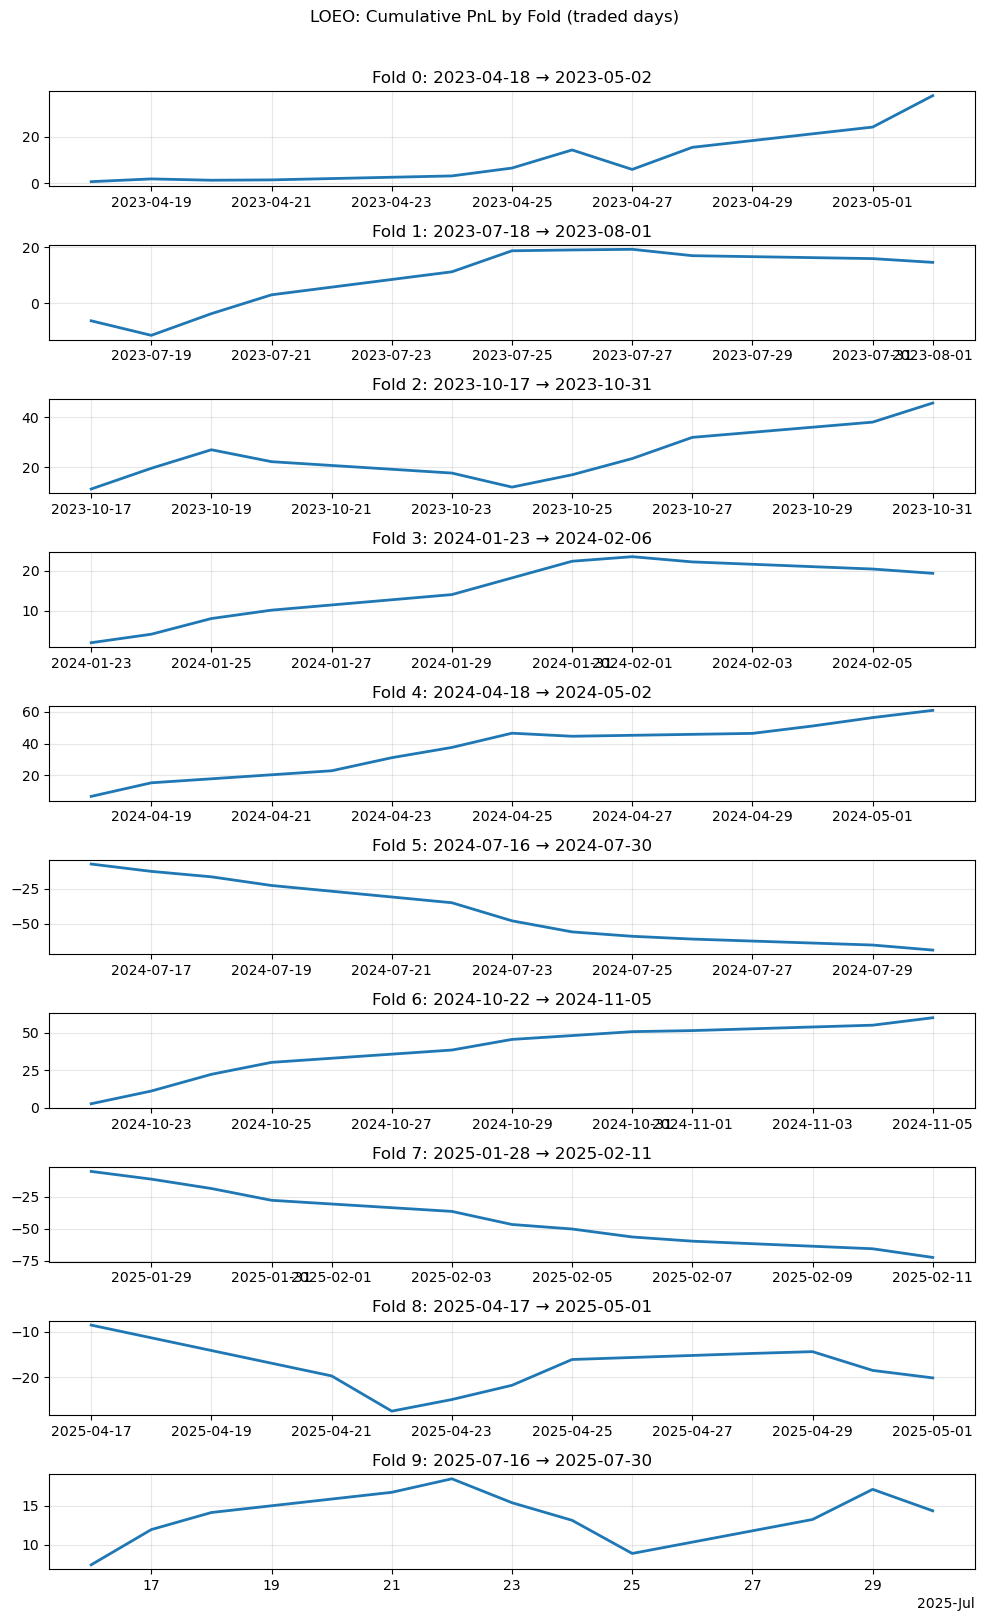

In [240]:
# Using your LOEO 'daily' table:
loeo_plot_parity(daily)
loeo_plot_timeline(daily, roll=5, shade_folds=True)
loeo_plot_cum_pnl(daily, per_fold=True)

In [241]:
# Plot timeline by event blocks: breaks lines between folds or large gaps so 
# predictions/actuals are shown eventwise (no cross-event connections).
def loeo_plot_timeline_eventwise(daily, roll=5, gap_days=5, shade_folds=True,
                                 title="LOEO: Actual vs Predicted (eventwise, no cross-event lines)"):
    df = daily.copy().sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    # define event blocks: new block if fold changes OR gap > gap_days
    d = df["date"].values
    fold = df["fold"].values
    day_gap = np.r_[True, (np.diff(d).astype("timedelta64[D]") > np.timedelta64(gap_days, "D"))]
    fold_gap = np.r_[True, np.diff(fold) != 0]
    new_block = (day_gap | fold_gap)
    df["block_id"] = new_block.cumsum()  # 1..N blocks

    fig, ax = plt.subplots(figsize=(12,5))

    # plot per block (y_true/y_pred), so no line spans across blocks
    for bid, g in df.groupby("block_id"):
        g = g.set_index("date").sort_index()
        ax.plot(g.index, g["y_true"], lw=1, alpha=0.45)
        ax.plot(g.index, g["y_pred"], lw=1.2, alpha=0.8)
        # optional per-block rolling means
        ax.plot(g.index, g["y_true"].rolling(roll, min_periods=1).mean(), lw=2, alpha=0.9)
        ax.plot(g.index, g["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, alpha=0.9)

    # optional: shade fold windows
    if shade_folds and "fold" in df.columns:
        for _, g in df.groupby("fold"):
            ax.axvspan(g["date"].min(), g["date"].max(), alpha=0.05)

    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
    ax.set_title(title)
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    plt.show()


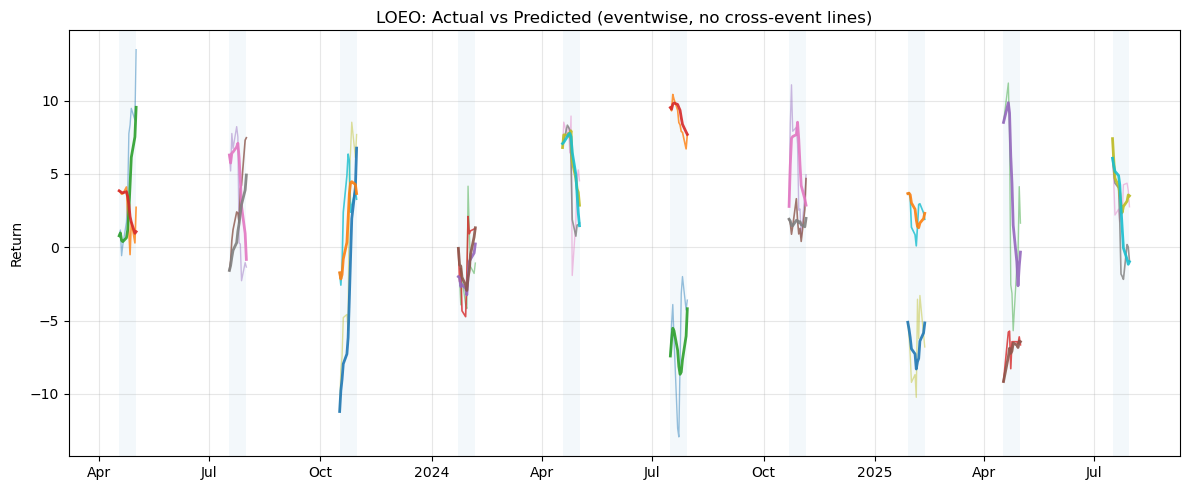

In [242]:
loeo_plot_timeline_eventwise(daily, roll=5, gap_days=5, shade_folds=True)

In [243]:
# Plot actual vs predicted as scatter points (no connecting lines),
# with optional rolling averages to show smoothed trends.
def loeo_plot_timeline_points(daily, roll=5, title="LOEO: Actual vs Predicted (points only)"):
    df = daily.copy().sort_values("date").set_index("date")
    fig, ax = plt.subplots(figsize=(12,5))
    ax.scatter(df.index, df["y_true"], s=18, alpha=0.5, label="y_true")
    ax.scatter(df.index, df["y_pred"], s=18, alpha=0.7, label="y_pred")

    ax.plot(df.index, df["y_true"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_true ({roll}d MA)")
    ax.plot(df.index, df["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_pred ({roll}d MA)")

    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
    ax.set_title(title); ax.set_ylabel("Return"); ax.grid(True, alpha=0.3); ax.legend()
    fig.tight_layout(); plt.show()


In [244]:
# Helper: insert NaNs into the series whenever gaps > gap_days occur,
# so line plots will automatically break at those gaps.
def _break_lines_on_gaps(df, gap_days=5):
    df = df.sort_values("date").copy()
    d = pd.to_datetime(df["date"]).values
    gap_mask = np.r_[False, (np.diff(d).astype("timedelta64[D]") > np.timedelta64(gap_days, "D"))]
    df.loc[gap_mask, ["y_true","y_pred"]] = np.nan
    return df

# Plot timeline with automatic breaks in lines at long gaps (via NaNs),
# preserving continuity within events but avoiding misleading cross-event links.
def loeo_plot_timeline_with_gaps(daily, roll=5, gap_days=5,
                                 title="LOEO: Actual vs Predicted (broken lines on gaps)"):
    df = _break_lines_on_gaps(daily, gap_days=gap_days).sort_values("date").set_index("date")
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df.index, df["y_true"], lw=1, alpha=0.5, label="y_true")
    ax.plot(df.index, df["y_pred"], lw=1, alpha=0.8, label="y_pred")
    ax.plot(df.index, df["y_true"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_true ({roll}d MA)")
    ax.plot(df.index, df["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, label=f"y_pred ({roll}d MA)")

    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
    ax.set_title(title); ax.set_ylabel("Return"); ax.grid(True, alpha=0.3); ax.legend()
    fig.tight_layout(); plt.show()


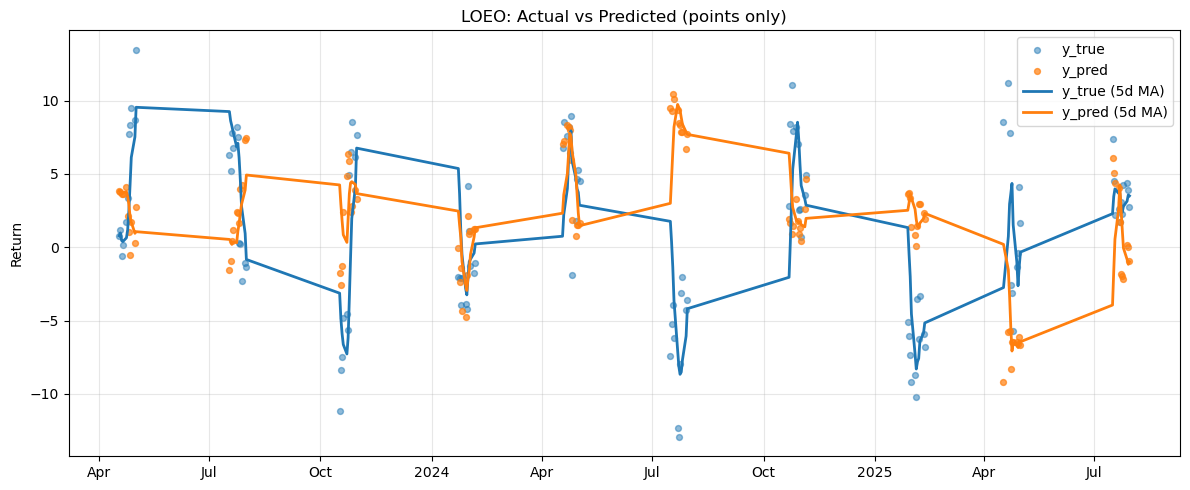

In [245]:
loeo_plot_timeline_points(daily, roll=5)

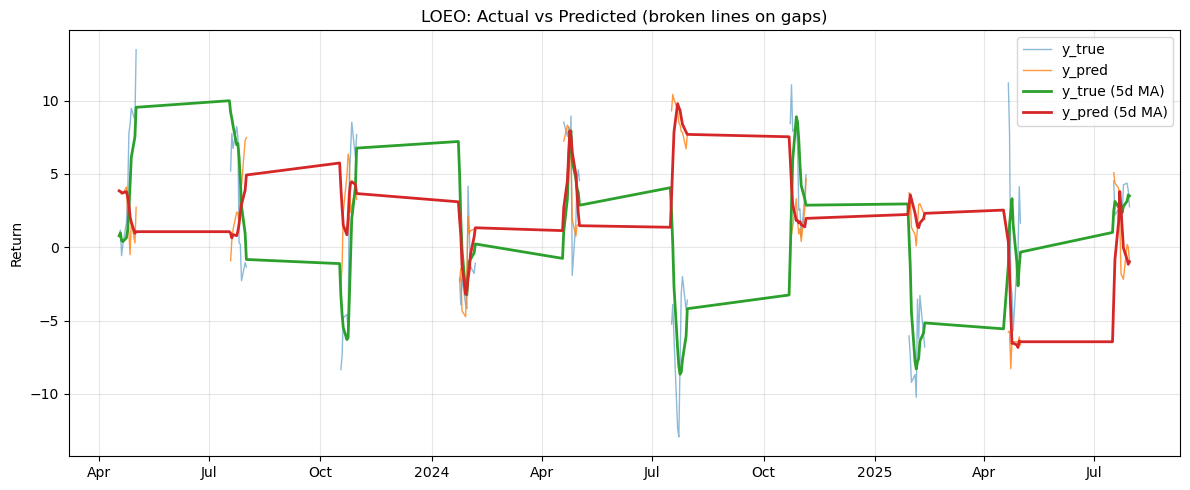

In [246]:
loeo_plot_timeline_with_gaps(daily, roll=5, gap_days=5)

In [247]:
# Helper: segment a daily predictions DataFrame into blocks separated by
#   - large calendar gaps (> gap_days), or
#   - changes in fold (if use_fold=True).
# Adds a 'block_id' column so later plots can avoid drawing lines across blocks.
def _segment_blocks(daily: pd.DataFrame, gap_days=10, use_fold=True):
    """Return a copy with a 'block_id' that increments at large gaps or fold changes."""
    df = daily.copy().sort_values("date")
    df["date"] = pd.to_datetime(df["date"])

    d = df["date"].to_numpy()
    big_gap = np.r_[True, (np.diff(d).astype("timedelta64[D]") >
                           np.timedelta64(gap_days, "D"))]

    if use_fold and "fold" in df.columns:
        f = df["fold"].to_numpy()
        fold_jump = np.r_[True, np.diff(f) != 0]
        new_block = big_gap | fold_jump
    else:
        new_block = big_gap

    df["block_id"] = new_block.cumsum()  # 1..N blocks
    return df

# Plot actual vs predicted returns segmented into blocks (no cross-event lines).
# Each block is drawn independently with raw series + rolling means.
# Optional: shade fold spans for context and show minimal legend.
def loeo_plot_timeline_segmented(daily, roll=5, gap_days=10, shade_folds=True,
                                 title="LOEO: Actual vs Predicted (segmented, no cross-event lines)"):
    df = _segment_blocks(daily, gap_days=gap_days, use_fold=True)

    fig, ax = plt.subplots(figsize=(12,5))
    # plot each block separately so lines never cross blocks
    for _, g in df.groupby("block_id"):
        g = g.sort_values("date").set_index("date")
        # raw within-block
        ax.plot(g.index, g["y_true"], lw=1, alpha=0.45, label=None)
        ax.plot(g.index, g["y_pred"], lw=1.2, alpha=0.85, label=None)
        # within-block rolling (computed per-block so it can't bridge)
        ax.plot(g.index, g["y_true"].rolling(roll, min_periods=1).mean(), lw=2, label=None)
        ax.plot(g.index, g["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, label=None)

    if shade_folds and "fold" in df.columns:
        for _, g in df.groupby("fold"):
            ax.axvspan(g["date"].min(), g["date"].max(), alpha=0.05)

    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
    ax.set_title(title)
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)

    # minimal legend
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0],[0], lw=1, alpha=0.45, label="y_true"),
        Line2D([0],[0], lw=1.2, alpha=0.85, label="y_pred"),
        Line2D([0],[0], lw=2, label=f"y_true ({roll}d MA)"),
        Line2D([0],[0], lw=2, label=f"y_pred ({roll}d MA)")
    ]
    ax.legend(handles=legend_elems, loc="upper right")
    fig.tight_layout()
    plt.show()


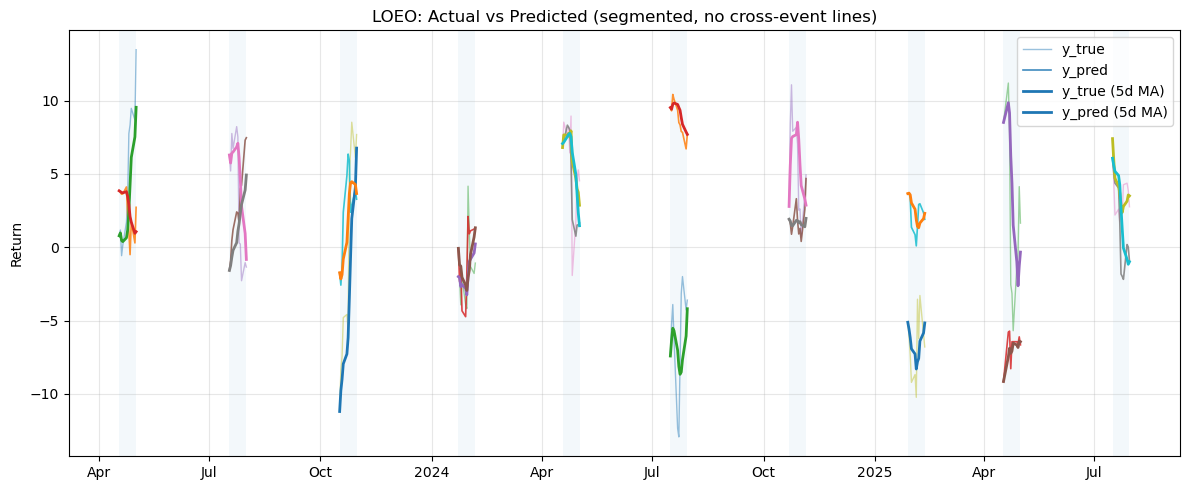

In [248]:
loeo_plot_timeline_segmented(daily, roll=5, gap_days=10, shade_folds=True)

In [251]:
# Helper: assign block IDs by detecting large date gaps (>gap_days) or fold changes.
# Ensures later plots can break lines at these boundaries (no cross-event connections).
def _segment_blocks(daily: pd.DataFrame, gap_days=10, use_fold=True):
    df = daily.copy().sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    d = df["date"].to_numpy()

    big_gap = np.r_[True, (np.diff(d).astype("timedelta64[D]") >
                           np.timedelta64(gap_days, "D"))]
    if use_fold and "fold" in df.columns:
        f = df["fold"].to_numpy()
        fold_jump = np.r_[True, np.diff(f) != 0]
        new_block = big_gap | fold_jump
    else:
        new_block = big_gap
    df["block_id"] = new_block.cumsum()
    return df
    
# Segmented LOEO timeline plot with fixed colors.
# Draws actual vs predicted returns per block (raw + rolling mean),
# shades fold spans, and shows a clean 2-color legend.
def loeo_plot_timeline_segmented_simple(
    daily, roll=5, gap_days=10, shade_folds=True,
    title="LOEO: Actual vs Predicted (segmented, two colors)"
):
    df = _segment_blocks(daily, gap_days=gap_days, use_fold=True)

    # fixed colors (no palette cycling)
    c_true = "#1f77b4"   # blue
    c_pred = "#ff7f0e"   # orange

    fig, ax = plt.subplots(figsize=(12,5))

    for _, g in df.groupby("block_id"):
        g = g.sort_values("date").set_index("date")
        # raw lines within the block (thin, semi-transparent)
        ax.plot(g.index, g["y_true"], lw=1, alpha=0.45, color=c_true)
        ax.plot(g.index, g["y_pred"], lw=1, alpha=0.65, color=c_pred)
        # rolling means within the block (thicker)
        ax.plot(g.index, g["y_true"].rolling(roll, min_periods=1).mean(), lw=2, color=c_true)
        ax.plot(g.index, g["y_pred"].rolling(roll, min_periods=1).mean(), lw=2, color=c_pred)

    if shade_folds and "fold" in df.columns:
        for _, g in df.groupby("fold"):
            ax.axvspan(g["date"].min(), g["date"].max(), alpha=0.05, color="0.5")

    loc = AutoDateLocator(minticks=6, maxticks=12)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(loc))
    ax.set_title(title)
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.3)

    # clean legend (just 2 entries + rolling note)
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0],[0], color=c_true,  lw=2, label=f"y_true ({roll}d MA)"),
        Line2D([0],[0], color=c_pred,  lw=2, label=f"y_pred ({roll}d MA)"),
        Line2D([0],[0], color=c_true,  lw=1, alpha=0.45, label="y_true (raw)"),
        Line2D([0],[0], color=c_pred,  lw=1, alpha=0.65, label="y_pred (raw)"),
    ]
    ax.legend(handles=legend_elems, loc="upper right")
    fig.tight_layout()
    plt.show()


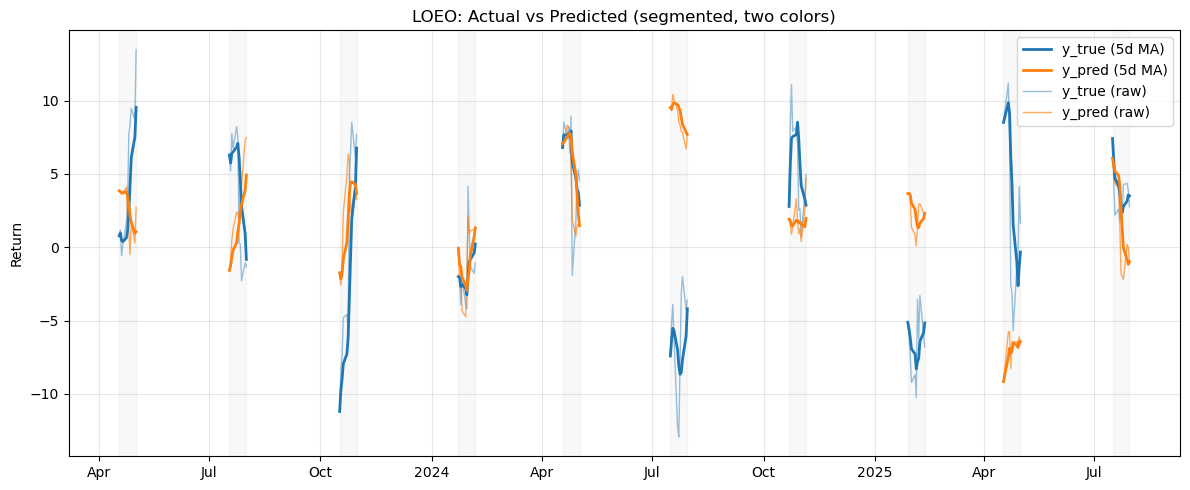

In [252]:
loeo_plot_timeline_segmented_simple(daily, roll=5, gap_days=10, shade_folds=True)

NOTE: earnings window strategies are presented separately in the report.

# Incorporating sentiment

**PLANNED METHOD**: To incorporate daily sentiment, the raw scores (bounded in [−1, +1]) are retained and a leak-safe rolling z-score is added. The rolling z-score expresses each day’s sentiment relative to the previous 60 trading days (in standard-deviations) giving the model a context-aware signal rather than an absolute level (*win=60* uses the last ~3 months to compute the trailing mean/std; *minp=40* delays z-scores until ≥40 observations exist. All stats are shifted by one day, so today’s z-score uses yesterday’s mean/std (leakage-safe)).While a raw value like ai_sentiment_googl = 0.70 means *“strongly positive today,”* the standardized counterpart ai_sentiment_googl_z = +1.8 indicates sentiment is ~1.8 standard deviations above its 60-day baseline—i.e., unusually positive. Models typically respond better to such deviation-from-baseline signals than to raw bounded levels, hence a rolling z-score is provided next to the raw metric. In modeling, robust pruning selects the variant with better validation performance.

------ end of notebook --------

In [265]:
# 1) Load & tidy the new sentiment file
# --- Load (quiet dtype warning), normalize column names ---
sent_path = "ep_sentiment_new.csv"  # <-- put your new file name here
sent = pd.read_csv(
    sent_path,
    dtype={"ticker": "string", "date": "string"},
    low_memory=False
)

# normalize names -> lowercase snake_case
sent.columns = (
    sent.columns
        .str.strip()
        .str.lower()
        .str.replace(r"[^\w]+", "_", regex=True)
)

# basic cleaning
sent["ticker"] = sent["ticker"].str.upper().str.strip()
sent["date"]   = pd.to_datetime(sent["date"], errors="coerce")

# coerce numeric cols (safely)
num_cols = [
    "ai_score","company_score",
    "total_sentiment_score","total_confidence_score",
    "avg_sentiment_score","avg_confidence_score",
    "weighted_avg_sentiment"
]
for c in num_cols:
    if c in sent.columns:
        sent[c] = pd.to_numeric(sent[c], errors="coerce")

In [266]:
def ensure_dtindex(df, name="df"):
    if isinstance(df.index, pd.DatetimeIndex):
        return df
    if "date" in df.columns:
        out = df.copy()
        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out = out.set_index("date").sort_index()
        return out
    raise AssertionError(f"{name} needs a DatetimeIndex or a 'date' column.")

# prepare sentiment table (once)
sent = sent.copy()
sent["ticker"] = sent["ticker"].str.upper().str.strip()
sent["date"]   = pd.to_datetime(sent["date"], errors="coerce")

# reindex your wide frames to dates
wide_google_aug_tied = ensure_dtindex(wide_google_aug_tied, "wide_google_aug_tied")
wide_apple_aug_tied  = ensure_dtindex(wide_apple_aug_tied,  "wide_apple_aug_tied")
wide_nvda_aug_tied   = ensure_dtindex(wide_nvda_aug_tied,   "wide_nvda_aug_tied")

# (re)define these from earlier if needed
def rolling_dm(s, win=60, minp=40):
    mu = s.rolling(win, min_periods=minp).mean().shift(1)
    return s - mu

def rolling_z(s, win=60, minp=40):
    mu  = s.rolling(win, min_periods=minp).mean().shift(1)
    sd  = s.rolling(win, min_periods=minp).std(ddof=0).shift(1)
    return (s - mu) / sd.replace(0.0, np.nan)

def build_sentiment_block_for(sent_all, tkr, align_index, win=60, minp=40):
    t = tkr.upper()
    block = (sent_all.loc[sent_all["ticker"] == t]
                     .set_index("date")
                     .sort_index()
                     .groupby(level=0).mean(numeric_only=True))

    keep_raw = [c for c in [
        "ai_score","company_score","weighted_avg_sentiment",
        "avg_sentiment_score","avg_confidence_score"
    ] if c in block.columns]
    keep_total = [c for c in ["total_sentiment_score","total_confidence_score"] if c in block.columns]

    out = pd.DataFrame(index=align_index)

    for c in keep_raw:
        s = block[c].reindex(align_index)
        base = c.lower()
        out[f"{base}_raw"]  = s
        out[f"{base}_dm"] = rolling_dm(s, win=win, minp=minp)
        out[f"{base}_z"]  = rolling_z(s,  win=win, minp=minp)

    for c in keep_total:
        s = block[c].reindex(align_index)
        base = c.lower()
        out[f"{base}_z"] = rolling_z(s, win=win, minp=minp)

    return out

def merge_sentiment_into_wide(wide_df, ticker, sent_all):
    # (now a DatetimeIndex is guaranteed)
    sent_block = build_sentiment_block_for(sent_all, ticker, wide_df.index, win=60, minp=40)
    return wide_df.join(sent_block, how="left")

wide_google_aug_tied_sent = merge_sentiment_into_wide(wide_google_aug_tied, "GOOGL", sent)
wide_apple_aug_tied_sent  = merge_sentiment_into_wide(wide_apple_aug_tied,  "AAPL",  sent)
wide_nvda_aug_tied_sent   = merge_sentiment_into_wide(wide_nvda_aug_tied,   "NVDA",  sent)

In [267]:
for name, df in [("GOOGL", wide_google_aug_tied_sent),
                 ("AAPL",  wide_apple_aug_tied_sent),
                 ("NVDA",  wide_nvda_aug_tied_sent)]:
    new_cols = [c for c in df.columns if c.endswith(("_score_raw", "_score_dm", "_score_z", "_sentiment_raw",  "_sentiment_dm",  "_sentiment_z"))]                                                   
    print(f"{name}: added {len(new_cols)} sentiment cols → e.g. {new_cols[:6]}")

GOOGL: added 17 sentiment cols → e.g. ['ai_score_raw', 'ai_score_dm', 'ai_score_z', 'company_score_raw', 'company_score_dm', 'company_score_z']
AAPL: added 17 sentiment cols → e.g. ['ai_score_raw', 'ai_score_dm', 'ai_score_z', 'company_score_raw', 'company_score_dm', 'company_score_z']
NVDA: added 17 sentiment cols → e.g. ['ai_score_raw', 'ai_score_dm', 'ai_score_z', 'company_score_raw', 'company_score_dm', 'company_score_z']


### Yeah Round Predictions: Model performance results after running the Walk Forward pipeline with sentiment features - **performance decreased**
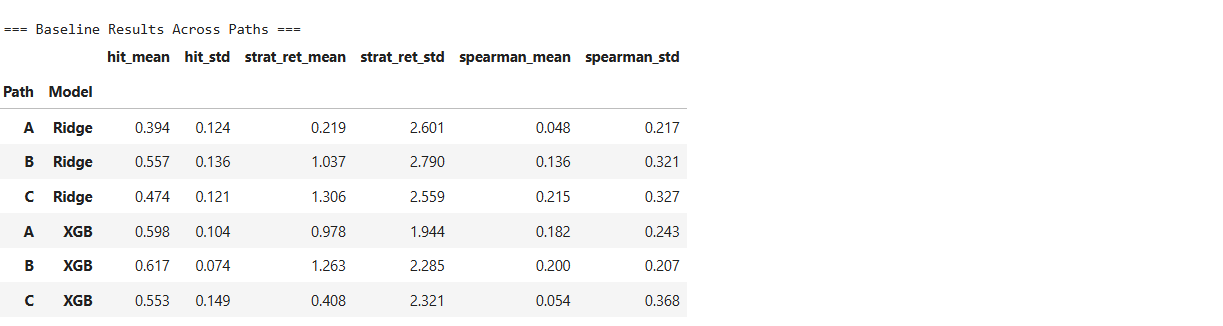

### SHAP feature importance after incorporating sentiment — **sentiment features absent from top drivers**
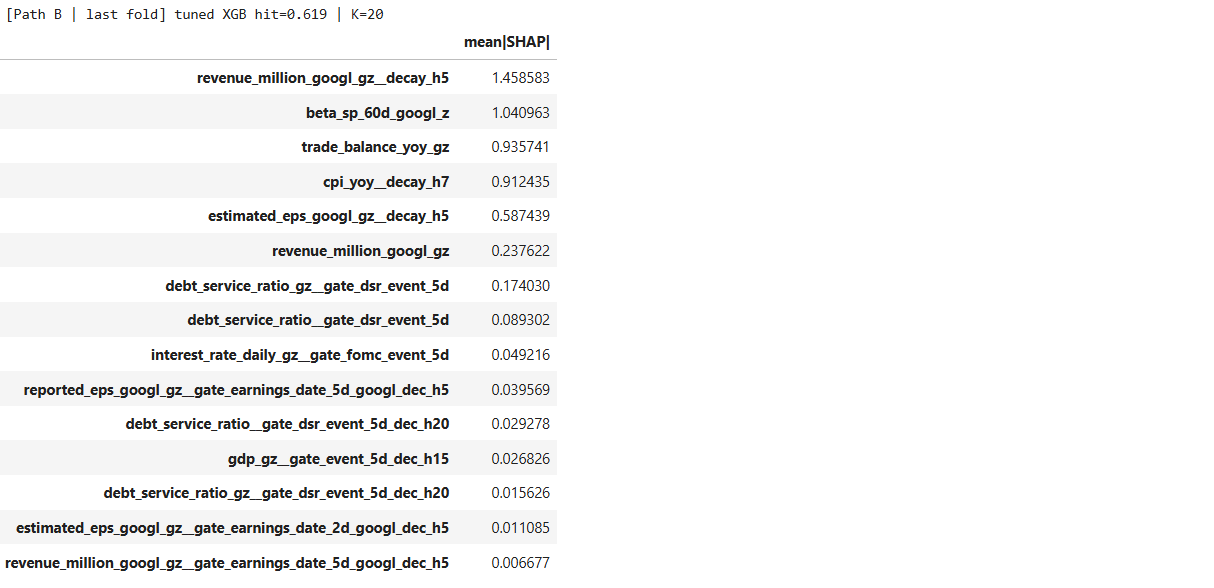

### Predictions Around Earnings: Model performance results after running the LOEO pipeline with sentiment features - **performance decreased**
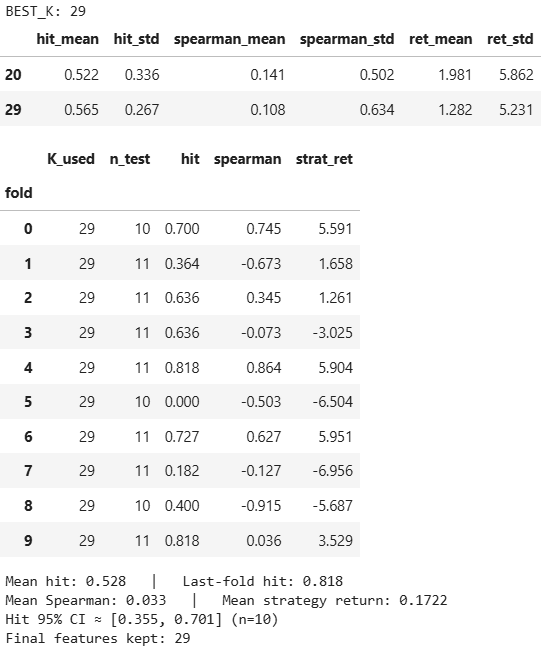

### Features kept in modeling after incorporating sentiment — **sentiment features absent**
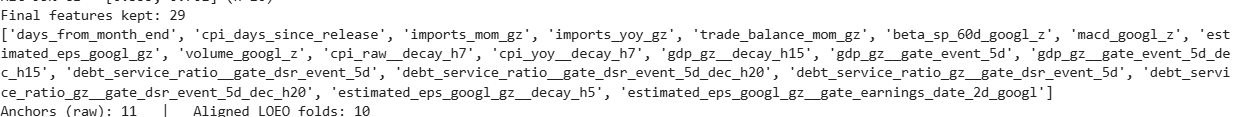

In [270]:
# check sentiment predictive power
import numpy as np
import pandas as pd

# --- helpers ---
def resolve_target_col(tkr: str, H: int) -> str:
    return f"future_{int(H)}d_ret_{tkr.lower()}"

def _spearman_ic(x: pd.Series, y: pd.Series) -> float:
    # rank-based correlation; ignores NaNs
    if x.notna().sum() < 3 or y.notna().sum() < 3:
        return np.nan
    return x.rank().corr(y.rank(), method="spearman")

def _hit_rate(x: pd.Series, y: pd.Series) -> float:
    # % days sign(x) == sign(y); ignores NaNs
    m = x.notna() & y.notna()
    if m.sum() == 0:
        return np.nan
    return (np.sign(x[m]) == np.sign(y[m])).mean()

def _window_mask(dates: pd.DatetimeIndex, anchors: pd.DatetimeIndex, W: int) -> pd.Series:
    """Boolean mask for dates in any ±W business-day window."""
    mask = pd.Series(False, index=dates)
    from pandas.tseries.offsets import BDay
    for a in anchors:
        lo = dates.searchsorted(a - BDay(W))
        hi = dates.searchsorted(a + BDay(W), side="right")
        if lo < hi:
            mask.iloc[lo:hi] = True
    return mask

def sanity_dashboard_for_sentiment(
    wide_df: pd.DataFrame,
    ticker: str,
    H: int,
    anchors: pd.DatetimeIndex,
    sentiment_cols: list[str],
    W: int = 5,                              # earnings window half-width (±W business days)
    min_valid: int = 40                      # minimum overlapping obs required to report metrics
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns (overall_table, window_table) with columns:
      ['feature','n','IC_spearman','hit_rate']
    Sorted by |IC| desc.
    """
    assert isinstance(wide_df.index, pd.DatetimeIndex), "wide_df must have a DatetimeIndex"
    tcol = resolve_target_col(ticker, H)
    if tcol not in wide_df.columns:
        raise KeyError(f"Target '{tcol}' not found in frame.")

    y = wide_df[tcol]
    # keep only sentiment columns that exist
    cols = [c for c in sentiment_cols if c in wide_df.columns]
    if not cols:
        raise ValueError("None of the requested sentiment columns are in the DataFrame.")

    def summarize(block_mask: pd.Series) -> pd.DataFrame:
        rows = []
        for c in cols:
            x = wide_df[c]
            m = x.notna() & y.notna() & block_mask
            n = int(m.sum())
            if n < min_valid:
                rows.append({"feature": c, "n": n, "IC_spearman": np.nan, "hit_rate": np.nan})
            else:
                rows.append({
                    "feature": c,
                    "n": n,
                    "IC_spearman": _spearman_ic(x[m], y[m]),
                    "hit_rate": _hit_rate(x[m], y[m]),
                })
        out = pd.DataFrame(rows)
        # sort by |IC| (descending), then by hit_rate
        out = out.sort_values(by=["IC_spearman", "hit_rate"], key=lambda s: s.abs() if s.name=="IC_spearman" else s, ascending=False, na_position="last")
        return out.reset_index(drop=True)

    dates = wide_df.index
    mask_all  = pd.Series(True, index=dates)
    mask_win  = _window_mask(dates, pd.DatetimeIndex(anchors), W=W)

    overall = summarize(mask_all)
    in_win  = summarize(mask_win)

    return overall, in_win


In [271]:
# choose sentiment columns for evaluation
sent_cols = [
    # bounded/means: we added raw, dm60, z60
    "ai_score_raw", "ai_score_dm", "ai_score_z",
    "company_score_raw", "company_score_dm", "company_score_z",
    "weighted_avg_sentiment_raw", "weighted_avg_sentiment_dm", "weighted_avg_sentiment_z",
    "avg_sentiment_score_raw", "avg_sentiment_score_dm", "avg_sentiment_score_z",
    "avg_confidence_score_raw", "avg_confidence_score_dm", "avg_confidence_score_z",
    # totals: z only (by design)
    "total_sentiment_score_z", "total_confidence_score_z",
]

# GOOGL example (adjust names to your objects)
H = 10
W = 5
goog_overall, goog_win = sanity_dashboard_for_sentiment(
    wide_df=wide_google_aug_tied_sent,
    ticker="googl",
    H=H,
    anchors=loeo["anchors"],          # or your own earnings-anchor DatetimeIndex for GOOGL
    sentiment_cols=sent_cols,
    W=W,
    min_valid=40
)

print("GOOGL — overall:")
display(goog_overall.round(3))
print(f"\nGOOGL — inside earnings windows (±{W}bd):")
display(goog_win.round(3))


GOOGL — overall:


feature    n  IC_spearman  hit_rate
0     total_confidence_score_z  602        0.116     0.535
1   weighted_avg_sentiment_raw  642       -0.070     0.519
2     avg_confidence_score_raw  642        0.068     0.631
3      avg_sentiment_score_raw  642       -0.065     0.525
4            company_score_raw  646       -0.054     0.500
5                   ai_score_z  606        0.045     0.533
6                  ai_score_dm  606        0.044     0.533
7                 ai_score_raw  646       -0.043     0.627
8      avg_confidence_score_dm  602        0.024     0.515
9       avg_confidence_score_z  602        0.023     0.515
10   weighted_avg_sentiment_dm  602       -0.023     0.528
11             company_score_z  606       -0.021     0.531
12      avg_sentiment_score_dm  602       -0.019     0.538
13            company_score_dm  606       -0.018     0.531
14    weighted_avg_sentiment_z  602       -0.011     0.528
15       avg_sentiment_score_z  602       -0.006     0.538
16     total_sentiment_score_z  602        0.001     0.532


GOOGL — inside earnings windows (±5bd):


feature    n  IC_spearman  hit_rate
0                  ai_score_dm  109        0.177     0.569
1      avg_confidence_score_dm  107        0.164     0.523
2                   ai_score_z  109        0.160     0.569
3       avg_confidence_score_z  107        0.158     0.523
4     total_confidence_score_z  107        0.143     0.589
5     avg_confidence_score_raw  118        0.125     0.517
6                 ai_score_raw  120        0.109     0.508
7      avg_sentiment_score_raw  118        0.081     0.508
8   weighted_avg_sentiment_raw  118        0.067     0.508
9            company_score_raw  120       -0.065     0.550
10             company_score_z  109       -0.044     0.578
11            company_score_dm  109       -0.044     0.578
12     total_sentiment_score_z  107        0.032     0.589
13       avg_sentiment_score_z  107        0.024     0.561
14      avg_sentiment_score_dm  107        0.024     0.561
15   weighted_avg_sentiment_dm  107        0.020     0.542
16    weighted_avg_sentiment_z  107        0.013     0.542

### **Sentiment Exploration: Key Insights**
**Incorporating sentiment features hurt modeling performance in both regimes** – year-round (Walk-Forward CV) and event-centric (LOEO). In practice, sentiment columns were consistently out-ranked during pre-selection (top-K=20); showed near-zero or negative importance in permutation/SHAP tests; and were ultimately excluded from the final XGB. **Nonethless, signal checks confirms that AI-sentiment score matters for predictions, especially around earnings**. Within earnings windows (±5 business days), sentiment features display a marked improvement in predictive power. The de-meaned AI sentiment score (ai_score_dm) and its standardized counterpart (ai_score_z) lead with meaningful rank correlations against the target (IC ≈ 0.177 and 0.160) and are more often than not aligned with the target’s sign (hit ≈ 0.569 and 0.589). Confidence-based measures (avg_confidence_*) also show elevated IC during these windows, suggesting that predictive strength comes not only from the sentiment scores themselves but also from the clarity and decisiveness of AI-related headlines and coverage.

### **At-a-Glance**: Walk-Forward CV Performance Across Targets: 
The heatmaps below show walk-forward cross-validation hit rates across companies (GOOGL, AAPL, NVDA) and horizons (T+2, T+5, T+10). As noted at the start of the notebook, the pipelines were executed in separate notebooks due to compute constraints.

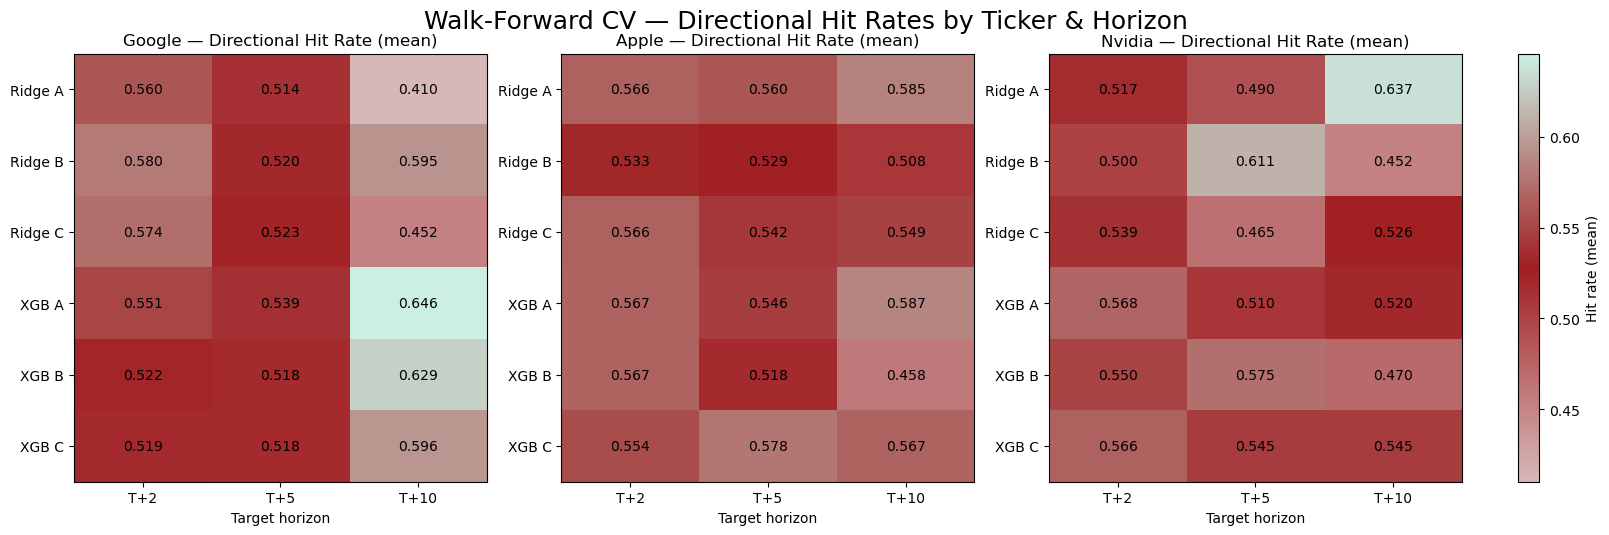

In [276]:
# plotting results across targets - year-round predictions
# --------------------------
# Data (as provided)
# --------------------------
rows = [
    ["A","Ridge","Google","t_plus_10",0.41],
    ["B","Ridge","Google","t_plus_10",0.595],
    ["C","Ridge","Google","t_plus_10",0.452],
    ["A","XGB","Google","t_plus_10",0.646],
    ["B","XGB","Google","t_plus_10",0.629],
    ["C","XGB","Google","t_plus_10",0.596],
    ["A","Ridge","Google","t_plus_5",0.514],
    ["B","Ridge","Google","t_plus_5",0.52],
    ["C","Ridge","Google","t_plus_5",0.523],
    ["A","XGB","Google","t_plus_5",0.539],
    ["B","XGB","Google","t_plus_5",0.518],
    ["C","XGB","Google","t_plus_5",0.518],
    ["A","Ridge","Google","t_plus_2",0.56],
    ["B","Ridge","Google","t_plus_2",0.58],
    ["C","Ridge","Google","t_plus_2",0.574],
    ["A","XGB","Google","t_plus_2",0.551],
    ["B","XGB","Google","t_plus_2",0.522],
    ["C","XGB","Google","t_plus_2",0.519],

    ["A","Ridge","Apple","t_plus_10",0.585],
    ["B","Ridge","Apple","t_plus_10",0.508],
    ["C","Ridge","Apple","t_plus_10",0.549],
    ["A","XGB","Apple","t_plus_10",0.587],
    ["B","XGB","Apple","t_plus_10",0.458],
    ["C","XGB","Apple","t_plus_10",0.567],
    ["A","Ridge","Apple","t_plus_5",0.56],
    ["B","Ridge","Apple","t_plus_5",0.529],
    ["C","Ridge","Apple","t_plus_5",0.542],
    ["A","XGB","Apple","t_plus_5",0.546],
    ["B","XGB","Apple","t_plus_5",0.518],
    ["C","XGB","Apple","t_plus_5",0.578],
    ["A","Ridge","Apple","t_plus_2",0.566],
    ["B","Ridge","Apple","t_plus_2",0.533],
    ["C","Ridge","Apple","t_plus_2",0.566],
    ["A","XGB","Apple","t_plus_2",0.567],
    ["B","XGB","Apple","t_plus_2",0.567],
    ["C","XGB","Apple","t_plus_2",0.554],

    ["A","Ridge","Nvidia","t_plus_10",0.637],
    ["B","Ridge","Nvidia","t_plus_10",0.452],
    ["C","Ridge","Nvidia","t_plus_10",0.526],
    ["A","XGB","Nvidia","t_plus_10",0.52],
    ["B","XGB","Nvidia","t_plus_10",0.47],
    ["C","XGB","Nvidia","t_plus_10",0.545],
    ["A","Ridge","Nvidia","t_plus_5",0.49],
    ["B","Ridge","Nvidia","t_plus_5",0.611],
    ["C","Ridge","Nvidia","t_plus_5",0.465],
    ["A","XGB","Nvidia","t_plus_5",0.51],
    ["B","XGB","Nvidia","t_plus_5",0.575],
    ["C","XGB","Nvidia","t_plus_5",0.545],
    ["A","Ridge","Nvidia","t_plus_2",0.517],
    ["B","Ridge","Nvidia","t_plus_2",0.5],
    ["C","Ridge","Nvidia","t_plus_2",0.539],
    ["A","XGB","Nvidia","t_plus_2",0.568],
    ["B","XGB","Nvidia","t_plus_2",0.55],
    ["C","XGB","Nvidia","t_plus_2",0.566],
]
df = pd.DataFrame(rows, columns=["Path","Model","Ticker","Target","hit_mean"])

# --------------------------
# Helpers
# --------------------------
def make_pivot(df_ticker):
    row_order = [("Ridge","A"),("Ridge","B"),("Ridge","C"),
                 ("XGB","A"),("XGB","B"),("XGB","C")]
    d = df_ticker.copy()
    d["Row"] = d.apply(lambda r: f"{r['Model']} {r['Path']}", axis=1)
    d["TargetLabel"] = d["Target"].map({"t_plus_2":"T+2","t_plus_5":"T+5","t_plus_10":"T+10"})
    p = d.pivot_table(index="Row", columns="TargetLabel", values="hit_mean")
    p = p.reindex([f"{m} {p}" for m,p in row_order])
    p = p[["T+2","T+5","T+10"]]  # ensure column order
    return p

P_google = make_pivot(df[df["Ticker"]=="Google"])
P_apple  = make_pivot(df[df["Ticker"]=="Apple"])
P_nvidia = make_pivot(df[df["Ticker"]=="Nvidia"])

# Shared color limits across all panels
all_vals = np.concatenate([P_google.values.flatten(),
                           P_apple.values.flatten(),
                           P_nvidia.values.flatten()])
vmin, vmax = float(all_vals.min()), float(all_vals.max())

# Your custom colormap (red center, green = highest)
colors = ["#D7B8B9", "#A01E21", "#CCEFE3"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# --------------------------
# Plot
# --------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

def draw(ax, pivot, title):
    im = ax.imshow(pivot.values, aspect="auto", cmap=custom_cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks(np.arange(pivot.shape[1])); ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_xticklabels(pivot.columns); ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Target horizon"); ax.set_title(f"{title}")
    for i in range(pivot.shape[0]):
        for j in range(pivot.shape[1]):
            ax.text(j, i, f"{pivot.values[i, j]:.3f}", ha="center", va="center", color="black", fontsize=10)
    return im

im = draw(axes[0], P_google, "Google — Directional Hit Rate (mean)")
draw(axes[1], P_apple,  "Apple — Directional Hit Rate (mean)")
draw(axes[2], P_nvidia, "Nvidia — Directional Hit Rate (mean)")

# One shared colorbar on the right
cbar = fig.colorbar(im, ax=axes, location="right", fraction=0.035, pad=0.04)
cbar.set_label("Hit rate (mean)")

# Optional: save
# plt.savefig("hit_rate_tripanel.png", dpi=300, bbox_inches="tight")
# Figure-level annotations
fig.suptitle("Walk-Forward CV — Directional Hit Rates by Ticker & Horizon", fontsize=18, y=1.04)
plt.show()


After finalizing the pipeline, the analysis evaluated all combinations of target companies and prediction horizons. As shown in the heatmaps, **the walk-forward, year-round approach delivered its strongest results for Google at the T+10-day horizon using XGBoost**. The Ridge baseline also showed relatively strong performance for Nvidia at T+10; however, because Ridge/MLR served only as a comparative benchmark in this project, that avenue was not examined further.

--- END OF NOTEBOOK ---